In [1]:
%load_ext autoreload

import os
import sys
import glob
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

# OPV NN1

### This notebook to uses only OPV processing conditions to predict device performance.


# Dataset definition

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_device.xlsx')

test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

print (f'device_df shape: {device_df.shape}')
print (f'test_df shape: {test_df.shape}')
device_df.head()

device_df shape: (366, 9)
test_df shape: (10, 60)


,Unnamed: 0,PCE,VocL,Jsc,FF,Substrate,Device,Time (min),Temp (C)
0,0,0.000000,0.000000,0.078981,0.066177,1,5,0,0
1,1,0.088229,1.000000,0.026882,0.000000,7,5,0,0
2,2,0.185014,0.934181,0.000000,0.565143,7,6,0,0
3,3,0.187694,0.915305,0.008375,0.570857,7,2,0,0
4,4,0.190771,0.928501,0.058959,0.436489,1,1,0,0


In [3]:
x_train = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
y_train = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_test = test_df[['Anneal_time', 'Anneal_temp']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

# Fit model with variety of learning rates and epochs to find best hyperparameters

In [ ]:
%autoreload

def fit(model, lr, epochs):
    
    #define the optimizer
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    
    #empty list to hold loss per epoch
    train_epoch_losses = []
    pce_train_epoch_losses = []
    voc_train_epoch_losses = []
    jsc_train_epoch_losses = []
    ff_train_epoch_losses = []

    test_epoch_losses = []
    pce_test_epoch_losses = []
    voc_test_epoch_losses = []
    jsc_test_epoch_losses = []
    ff_test_epoch_losses = []

    pce_test_epoch_accuracies = []
    voc_test_epoch_accuracies = []
    jsc_test_epoch_accuracies = []
    ff_test_epoch_accuracies = []
    test_epoch_accuracies = []

    pce_test_epoch_r2 = []
    voc_test_epoch_r2 = []
    jsc_test_epoch_r2 = []
    ff_test_epoch_r2 = []
    test_epoch_r2s = []

    save_epochs = np.arange(0, num_epochs, 5)

    for epoch in range(epochs):
        print('On epoch ', epoch)

    #     save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    #     model_name = "OPV_NN2"
    #     model_path = save_dir+model_name+'*.pt'
    #     if epoch < 10:
    #         save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    #     else:
    #         save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'

    #     if glob.glob(model_path) != []:
    #         model_states = glob.glob(model_path)
    #         model_states = sorted(model_states)
    #         previous_model = model_states[-1]    

    #         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)

        model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,                                                                                                     training_data_set = training_data_set,
                                                                                                             optimizer = optimizer)
        train_epoch_losses.append(train_loss)
        pce_train_epoch_losses.append(pce_train_loss)
        voc_train_epoch_losses.append(voc_train_loss)
        jsc_train_epoch_losses.append(jsc_train_loss)
        ff_train_epoch_losses.append(ff_train_loss)

        test_losses, test_accs, test_r2s = test.eval_OPV_df_model(model = model,
                                                                  testing_data_set = testing_data_set)
        pce_test_epoch_losses.append(test_losses[0])
        voc_test_epoch_losses.append(test_losses[1])
        jsc_test_epoch_losses.append(test_losses[2])
        ff_test_epoch_losses.append(test_losses[3])

        tot_tst_loss = sum(test_losses)
        test_epoch_losses.append(tot_tst_loss)

        pce_test_epoch_accuracies.append(test_accs[0])
        voc_test_epoch_accuracies.append(test_accs[1])
        jsc_test_epoch_accuracies.append(test_accs[2])
        ff_test_epoch_accuracies.append(test_accs[3])

        tot_tst_acc = sum(test_accs)
        test_epoch_accuracies.append(tot_tst_acc)

        pce_test_epoch_r2.append(test_r2s[0])
        voc_test_epoch_r2.append(test_r2s[1])
        jsc_test_epoch_r2.append(test_r2s[2])
        ff_test_epoch_r2.append(test_r2s[3])

        tot_tst_r2 = sum(test_r2s)
        test_epoch_r2s.append(tot_tst_r2)

        #nuts.save_trained_model(save_path, epoch, model, optimizer)
        
        print('Finished epoch ', epoch)
        
    best_loss_indx = test_epoch_losses.index(min(test_epoch_losses))
    best_acc_indx = test_epoch_accuracies.index(min(test_epoch_accuracies))
    best_r2_indx = test_epoch_r2s.index(max(test_epoch_r2s))
    
    fit_results = {
        'lr': lr,
        'best_loss_epoch': best_loss_indx,
        'best_acc_epoch': best_acc_indx,
        'best_r2_epoch': best_r2_indx,
        'pce_loss': pce_test_epoch_losses,
        'voc_loss': voc_test_epoch_losses,
        'jsc_loss': jsc_test_epoch_losses,
        'ff_loss': ff_test_epoch_losses,
        'test_losses': test_epoch_losses,        
        'pce_acc': pce_test_epoch_accuracies,
        'voc_acc': voc_test_epoch_accuracies,
        'jsc_acc': jsc_test_epoch_accuracies,
        'ff_acc': ff_test_epoch_accuracies,
        'test_accs': test_epoch_accuracies,
        'pce_r2': pce_test_epoch_r2,
        'voc_r2': voc_test_epoch_r2,
        'jsc_r2': jsc_test_epoch_r2,
        'ff_r2': ff_test_epoch_r2,
        'test_r2s': test_epoch_r2s,
        'train_pce_loss': pce_train_epoch_losses,
        'train_voc_loss': voc_train_epoch_losses,
        'train_jsc_loss': jsc_train_epoch_losses,
        'train_ff_loss': ff_train_epoch_losses
    }

    return fit_results

In [4]:
%autoreload

# Hyper parameters
num_epochs = 500
learning_rate = 1e-7

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

in_dims = int(x_train.shape[1]) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

In [5]:
%autoreload

cv_fits = {}

kf = KFold(n_splits = 5)

for fold, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
    print(f'Fold # {fold}')
    print('-----------------------------')
    
    train_loader, test_loader = nuts.get_fold_dataloaders_df(x_train, y_train, train_index, test_index)
        
    model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
    model.apply(nuts.init_weights)
    
    cv_fits[fold] = nuts.CV_OPV_fit(model, train_loader, test_loader, lr = learning_rate, epochs = num_epochs)


Fold # 0
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 98.64865112304688
                              Voc = 2339.396728515625
                              Jsc = 1519.3338623046875
                              FF = 1457.5611572265625
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 98.64865112304688
                              Voc = 2106.95849609375
                              Jsc = 1824.22119140625
                              FF = 1470.987548828125
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 98.64865112304688
                              Voc = 1965.6549072265625
                              Jsc = 2119.867431640625
                              FF = 1476.401123046875
Finished epoch  2
On epoch  3


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 98.64865112304688
                              Voc = 1878.1568603515625
                              Jsc = 2342.375
                              FF = 1474.157470703125
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 98.64865112304688
                              Voc = 1811.8177490234375
                              Jsc = 2493.607177734375
                              FF = 1478.67236328125
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 98.64865112304688
                              Voc = 1761.1839599609375
                              Jsc = 2588.496826171875
                              FF = 1484.3026123046875
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 98.64865112304688
                              Voc = 1720.8319091796875
                              Jsc = 2672.356689453125
                              FF = 1489.197021484375
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 98.648651

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 98.64865112304688
                              Voc = 1652.6136474609375
                              Jsc = 2818.479248046875
                              FF = 1494.783935546875
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 98.3419189453125
                              Voc = 1625.7286376953125
                              Jsc = 2880.1240234375
                              FF = 1497.2060546875
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 97.13615417480469
                              Voc = 1603.927978515625
                              Jsc = 2928.819580078125
                              FF = 1499.298583984375
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 96.28327178955078
                              Voc = 1584.5604248046875
                              Jsc = 2981.09033203125
                              FF = 1501.369140625
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 96.15

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 96.08133697509766
                              Voc = 1555.525146484375
                              Jsc = 3067.95556640625
                              FF = 1503.8555908203125
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 96.15289306640625
                              Voc = 1541.1832275390625
                              Jsc = 3090.63671875
                              FF = 1504.7647705078125
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 96.52066802978516
                              Voc = 1527.5723876953125
                              Jsc = 3124.058837890625
                              FF = 1506.247314453125
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 96.54499816894531
                              Voc = 1516.8231201171875
                              Jsc = 3142.875244140625
                              FF = 1507.5914306640625
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 94.14974212646484
                              Voc = 1496.859130859375
                              Jsc = 3196.5302734375
                              FF = 1508.626220703125
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 90.52584838867188
                              Voc = 1489.4613037109375
                              Jsc = 3202.564697265625
                              FF = 1507.671142578125
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 86.07969665527344
                              Voc = 1483.92919921875
                              Jsc = 3218.087890625
                              FF = 1506.3365478515625
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 82.5642318725586
                              Voc = 1476.79736328125
                              Jsc = 3234.724853515625
                              FF = 1506.3255615234375
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 8

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 77.29063415527344
                              Voc = 1472.54345703125
                              Jsc = 3256.14013671875
                              FF = 1506.4688720703125
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 74.06797790527344
                              Voc = 1471.1492919921875
                              Jsc = 3260.707763671875
                              FF = 1506.0675048828125
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 72.93187713623047
                              Voc = 1471.23828125
                              Jsc = 3268.545166015625
                              FF = 1504.4881591796875
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 71.57072448730469
                              Voc = 1471.3394775390625
                              Jsc = 3279.470703125
                              FF = 1505.35986328125
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 6

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 67.8456039428711
                              Voc = 1471.9293212890625
                              Jsc = 3291.3935546875
                              FF = 1505.33740234375
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 66.7851791381836
                              Voc = 1474.0445556640625
                              Jsc = 3295.159912109375
                              FF = 1504.462646484375
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 65.44190979003906
                              Voc = 1476.7340087890625
                              Jsc = 3304.00390625
                              FF = 1504.603515625
Finished epoch  30
On epoch  31


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 66.11693572998047
                              Voc = 1479.3197021484375
                              Jsc = 3306.392333984375
                              FF = 1504.2718505859375
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 63.30961608886719
                              Voc = 1479.9339599609375
                              Jsc = 3309.112548828125
                              FF = 1503.910400390625
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 61.929649353027344
                              Voc = 1483.955322265625
                              Jsc = 3317.59521484375
                              FF = 1503.89990234375
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 60.85840606689453
                              Voc = 1486.214599609375
                              Jsc = 3321.8876953125
                              FF = 1503.5955810546875
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.47346878051758
                              Voc = 1485.03125
                              Jsc = 3329.709716796875
                              FF = 1503.024169921875
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 57.12969970703125
                              Voc = 1486.478271484375
                              Jsc = 3330.3505859375
                              FF = 1502.7996826171875
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 56.113487243652344
                              Voc = 1491.79736328125
                              Jsc = 3330.29833984375
                              FF = 1503.786865234375
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 56.0584831237793
                              Voc = 1491.6109619140625
                              Jsc = 3329.9208984375
                              FF = 1503.3802490234375
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 57.402

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.76765060424805
                              Voc = 1498.2564697265625
                              Jsc = 3341.1259765625
                              FF = 1503.0560302734375
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 53.781150817871094
                              Voc = 1498.742431640625
                              Jsc = 3344.240966796875
                              FF = 1502.7503662109375
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 54.526920318603516
                              Voc = 1498.2796630859375
                              Jsc = 3341.703369140625
                              FF = 1503.0101318359375
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 54.19362258911133
                              Voc = 1500.6888427734375
                              Jsc = 3336.16943359375
                              FF = 1504.2613525390625
Finished epoch  44

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t


On epoch  45
Total Epoch Testing MAPE: PCE = 53.206546783447266
                              Voc = 1499.453369140625
                              Jsc = 3331.68896484375
                              FF = 1504.2833251953125
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 53.41587829589844
                              Voc = 1493.611572265625
                              Jsc = 3334.906494140625
                              FF = 1504.2879638671875
Finished epoch  46
On epoch  47


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 52.57853317260742
                              Voc = 1499.1505126953125
                              Jsc = 3344.99462890625
                              FF = 1503.427490234375
Finished epoch  47
On epoch  48
Total Epoch Testing MAPE: PCE = 53.03190994262695
                              Voc = 1501.111083984375
                              Jsc = 3346.225341796875
                              FF = 1504.123046875
Finished epoch  48
On epoch  49
Total Epoch Testing MAPE: PCE = 52.23746871948242
                              Voc = 1507.52001953125
                              Jsc = 3341.168212890625
                              FF = 1504.1341552734375
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 52.750282287597656
                              Voc = 1507.3829345703125
                              Jsc = 3332.208984375
                              FF = 1503.1650390625
Finished epoch  50
On epoch  51


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 52.99409484863281
                              Voc = 1511.654052734375
                              Jsc = 3333.135986328125
                              FF = 1502.1783447265625
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 52.49322509765625
                              Voc = 1513.5247802734375
                              Jsc = 3342.384033203125
                              FF = 1500.9521484375
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 52.09011459350586
                              Voc = 1517.790283203125
                              Jsc = 3335.784912109375
                              FF = 1502.994873046875
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 51.8450927734375
                              Voc = 1523.1944580078125
                              Jsc = 3342.8359375
                              FF = 1503.035888671875
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 5

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t


                              Voc = 1528.2552490234375
                              Jsc = 3345.71923828125
                              FF = 1503.8162841796875
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE: PCE = 54.901153564453125
                              Voc = 1526.8868408203125
                              Jsc = 3341.176513671875
                              FF = 1504.5584716796875
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 54.37981033325195
                              Voc = 1524.1473388671875
                              Jsc = 3345.001220703125
                              FF = 1504.4176025390625
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 54.925601959228516
                              Voc = 1529.638427734375
                              Jsc = 3341.037353515625
                              FF = 1505.8111572265625
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 53.23972702026367
                   

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.57978439331055
                              Voc = 1531.4410400390625
                              Jsc = 3336.00732421875
                              FF = 1504.789794921875
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 55.310855865478516
                              Voc = 1532.67822265625
                              Jsc = 3335.82421875
                              FF = 1504.7340087890625
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 54.25132369995117
                              Voc = 1537.9656982421875
                              Jsc = 3342.203125
                              FF = 1503.6048583984375
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 55.1221923828125
                              Voc = 1541.3651123046875
                              Jsc = 3341.80859375
                              FF = 1503.93017578125
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 56.08734

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.47460174560547
                              Voc = 1542.1134033203125
                              Jsc = 3348.535888671875
                              FF = 1504.3355712890625
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 55.47626495361328
                              Voc = 1551.6031494140625
                              Jsc = 3352.1416015625
                              FF = 1505.019775390625
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE = 54.700767517089844
                              Voc = 1559.948974609375
                              Jsc = 3355.891357421875
                              FF = 1506.1595458984375
Finished epoch  67
On epoch  68
Total Epoch Testing MAPE: PCE = 53.70296096801758
                              Voc = 1556.406005859375
                              Jsc = 3344.6337890625
                              FF = 1505.424072265625
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.85194778442383
                              Voc = 1568.0677490234375
                              Jsc = 3343.25244140625
                              FF = 1505.217041015625
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 55.61701202392578
                              Voc = 1576.140869140625
                              Jsc = 3346.95556640625
                              FF = 1504.577392578125
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 55.06162643432617
                              Voc = 1556.303466796875
                              Jsc = 3348.43212890625
                              FF = 1505.111572265625
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 53.6893424987793
                              Voc = 1564.070556640625
                              Jsc = 3344.90576171875
                              FF = 1505.62158203125
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 5

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 52.968692779541016
                              Voc = 1576.1976318359375
                              Jsc = 3353.115478515625
                              FF = 1504.8387451171875
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 54.19891357421875
                              Voc = 1583.428466796875
                              Jsc = 3357.6064453125
                              FF = 1504.3817138671875
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 54.245628356933594
                              Voc = 1594.7059326171875
                              Jsc = 3361.6337890625
                              FF = 1504.460205078125
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 54.27336883544922
                              Voc = 1598.962158203125
                              Jsc = 3353.37451171875
                              FF = 1503.6209716796875
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.607276916503906
                              Voc = 1606.0491943359375
                              Jsc = 3351.409423828125
                              FF = 1503.8465576171875
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 54.392372131347656
                              Voc = 1612.57763671875
                              Jsc = 3354.315185546875
                              FF = 1503.2518310546875
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 54.76102066040039
                              Voc = 1614.10791015625
                              Jsc = 3348.4091796875
                              FF = 1502.7061767578125
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 55.835662841796875
                              Voc = 1593.89453125
                              Jsc = 3351.82421875
                              FF = 1502.8236083984375
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.795082092285156
                              Voc = 1603.3095703125
                              Jsc = 3359.492431640625
                              FF = 1503.5850830078125
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 53.76787185668945
                              Voc = 1610.3740234375
                              Jsc = 3365.138916015625
                              FF = 1503.804931640625
Finished epoch  86
On epoch  87
Total Epoch Testing MAPE: PCE = 54.56426239013672
                              Voc = 1617.211181640625
                              Jsc = 3362.617919921875
                              FF = 1503.72021484375
Finished epoch  87
On epoch  88
Total Epoch Testing MAPE: PCE = 54.92766571044922
                              Voc = 1619.3470458984375
                              Jsc = 3360.007080078125
                              FF = 1503.63525390625
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.096656799316406
                              Voc = 1608.193603515625
                              Jsc = 3346.917724609375
                              FF = 1502.7235107421875
Finished epoch  90
On epoch  91
Total Epoch Testing MAPE: PCE = 55.528480529785156
                              Voc = 1619.08740234375
                              Jsc = 3341.6396484375
                              FF = 1502.639892578125
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 53.80797576904297
                              Voc = 1616.49072265625
                              Jsc = 3336.603271484375
                              FF = 1502.52978515625
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 54.747772216796875
                              Voc = 1567.9913330078125
                              Jsc = 3339.959228515625
                              FF = 1503.7744140625
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.89459228515625
                              Voc = 1578.3465576171875
                              Jsc = 3342.078857421875
                              FF = 1503.7115478515625
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 55.58556365966797
                              Voc = 1584.04443359375
                              Jsc = 3342.457275390625
                              FF = 1503.8663330078125
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 54.80058288574219
                              Voc = 1594.9696044921875
                              Jsc = 3339.1640625
                              FF = 1503.616455078125
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 54.67558670043945
                              Voc = 1601.7432861328125
                              Jsc = 3344.42431640625
                              FF = 1503.2523193359375
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.12845993041992
                              Voc = 1616.37646484375
                              Jsc = 3341.74755859375
                              FF = 1502.2572021484375
Finished epoch  100
On epoch  101
Total Epoch Testing MAPE: PCE = 55.39264678955078
                              Voc = 1620.0947265625
                              Jsc = 3338.6962890625
                              FF = 1503.28955078125
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 55.43663024902344
                              Voc = 1616.451416015625
                              Jsc = 3343.55322265625
                              FF = 1501.9334716796875
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 56.51537322998047
                              Voc = 1576.1031494140625
                              Jsc = 3348.877685546875
                              FF = 1502.703369140625
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.355262756347656
                              Voc = 1591.060302734375
                              Jsc = 3346.086181640625
                              FF = 1500.2435302734375
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 55.6584587097168
                              Voc = 1600.10009765625
                              Jsc = 3348.55615234375
                              FF = 1500.52587890625
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 56.22556686401367
                              Voc = 1589.8092041015625
                              Jsc = 3353.826416015625
                              FF = 1499.81494140625
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 55.82331466674805
                              Voc = 1595.614501953125
                              Jsc = 3356.470947265625
                              FF = 1500.81201171875
Finished epoch  108
On epoch  109
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.787086486816406
                              Voc = 1537.1575927734375
                              Jsc = 3360.82373046875
                              FF = 1503.1329345703125
Finished epoch  110
On epoch  111
Total Epoch Testing MAPE: PCE = 55.43185043334961
                              Voc = 1541.653564453125
                              Jsc = 3362.4296875
                              FF = 1502.3917236328125
Finished epoch  111
On epoch  112
Total Epoch Testing MAPE: PCE = 56.643802642822266
                              Voc = 1549.1590576171875
                              Jsc = 3362.560546875
                              FF = 1501.436279296875
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 55.71338653564453
                              Voc = 1554.9931640625
                              Jsc = 3358.814208984375
                              FF = 1502.0968017578125
Finished epoch  113
On epoch  114
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.162254333496094
                              Voc = 1571.040771484375
                              Jsc = 3357.203369140625
                              FF = 1500.0185546875
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 54.298030853271484
                              Voc = 1581.693603515625
                              Jsc = 3357.10498046875
                              FF = 1501.4874267578125
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 54.38629913330078
                              Voc = 1585.72998046875
                              Jsc = 3351.72314453125
                              FF = 1501.7333984375
Finished epoch  117
On epoch  118
Total Epoch Testing MAPE: PCE = 54.42701721191406
                              Voc = 1576.4654541015625
                              Jsc = 3354.286865234375
                              FF = 1502.511962890625
Finished epoch  118
On epoch  119
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 52.32556915283203
                              Voc = 1589.3966064453125
                              Jsc = 3347.46435546875
                              FF = 1501.302490234375
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 52.666290283203125
                              Voc = 1600.3851318359375
                              Jsc = 3341.3603515625
                              FF = 1501.4110107421875
Finished epoch  121
On epoch  122
Total Epoch Testing MAPE: PCE = 53.411590576171875
                              Voc = 1607.2845458984375
                              Jsc = 3340.267578125
                              FF = 1501.460693359375
Finished epoch  122
On epoch  123
Total Epoch Testing MAPE: PCE = 53.60930633544922
                              Voc = 1619.65087890625
                              Jsc = 3337.98828125
                              FF = 1500.78271484375
Finished epoch  123
On epoch  124
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.62626266479492
                              Voc = 1535.0638427734375
                              Jsc = 3335.24853515625
                              FF = 1501.0283203125
Finished epoch  125
On epoch  126
Total Epoch Testing MAPE: PCE = 52.69635772705078
                              Voc = 1538.3212890625
                              Jsc = 3334.502685546875
                              FF = 1501.617919921875
Finished epoch  126
On epoch  127
Total Epoch Testing MAPE: PCE = 52.2692985534668
                              Voc = 1534.3359375
                              Jsc = 3336.395263671875
                              FF = 1502.82568359375
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 52.641754150390625
                              Voc = 1539.369140625
                              Jsc = 3337.913818359375
                              FF = 1503.2357177734375
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.06894302368164
                              Voc = 1542.670654296875
                              Jsc = 3336.085205078125
                              FF = 1502.5133056640625
Finished epoch  130
On epoch  131
Total Epoch Testing MAPE: PCE = 54.63975143432617
                              Voc = 1541.3018798828125
                              Jsc = 3341.185791015625
                              FF = 1503.5294189453125
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 54.81871795654297
                              Voc = 1545.6925048828125
                              Jsc = 3340.73193359375
                              FF = 1504.4122314453125
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 53.998722076416016
                              Voc = 1545.0511474609375
                              Jsc = 3340.44140625
                              FF = 1503.7249755859375
Finished epoch  133
On epoch  134
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.66352844238281
                              Voc = 1548.8443603515625
                              Jsc = 3346.213134765625
                              FF = 1502.806640625
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 54.80617141723633
                              Voc = 1558.6466064453125
                              Jsc = 3351.232177734375
                              FF = 1502.39892578125
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 56.6520881652832
                              Voc = 1565.3270263671875
                              Jsc = 3353.68310546875
                              FF = 1502.564453125
Finished epoch  137
On epoch  138
Total Epoch Testing MAPE: PCE = 56.07328414916992
                              Voc = 1565.448486328125
                              Jsc = 3351.3955078125
                              FF = 1501.599365234375
Finished epoch  138
On epoch  139
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.60323715209961
                              Voc = 1575.1807861328125
                              Jsc = 3342.509033203125
                              FF = 1502.36865234375
Finished epoch  140
On epoch  141
Total Epoch Testing MAPE: PCE = 55.27306365966797
                              Voc = 1562.749267578125
                              Jsc = 3346.09326171875
                              FF = 1503.5394287109375
Finished epoch  141
On epoch  142
Total Epoch Testing MAPE: PCE = 54.915504455566406
                              Voc = 1563.992431640625
                              Jsc = 3344.010498046875
                              FF = 1502.0714111328125
Finished epoch  142
On epoch  143
Total Epoch Testing MAPE: PCE = 54.00358581542969
                              Voc = 1555.742919921875
                              Jsc = 3339.9638671875
                              FF = 1501.886962890625
Finished epoch  143
On epoch  144
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.24156951904297
                              Voc = 1548.547119140625
                              Jsc = 3334.590087890625
                              FF = 1502.510986328125
Finished epoch  145
On epoch  146
Total Epoch Testing MAPE: PCE = 54.755435943603516
                              Voc = 1555.79736328125
                              Jsc = 3337.617919921875
                              FF = 1504.2225341796875
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 54.26099395751953
                              Voc = 1562.0841064453125
                              Jsc = 3334.422607421875
                              FF = 1504.3642578125
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 56.154483795166016
                              Voc = 1543.5589599609375
                              Jsc = 3329.550537109375
                              FF = 1503.7373046875
Finished epoch  148
On epoch  149
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.06093978881836
                              Voc = 1547.29638671875
                              Jsc = 3333.1826171875
                              FF = 1503.1485595703125
Finished epoch  150
On epoch  151
Total Epoch Testing MAPE: PCE = 56.3819580078125
                              Voc = 1537.392822265625
                              Jsc = 3330.3017578125
                              FF = 1503.8497314453125
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 56.06003952026367
                              Voc = 1526.8916015625
                              Jsc = 3334.367431640625
                              FF = 1502.6552734375
Finished epoch  152
On epoch  153
Total Epoch Testing MAPE: PCE = 58.34893035888672
                              Voc = 1531.720458984375
                              Jsc = 3337.08984375
                              FF = 1501.8984375
Finished epoch  153
On epoch  154
Total Epoch Testing MAPE: PCE = 58.88

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 59.24772644042969
                              Voc = 1534.1956787109375
                              Jsc = 3334.299072265625
                              FF = 1501.7066650390625
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 58.61234664916992
                              Voc = 1540.1773681640625
                              Jsc = 3338.9716796875
                              FF = 1502.4588623046875
Finished epoch  156
On epoch  157
Total Epoch Testing MAPE: PCE = 57.170963287353516
                              Voc = 1537.9967041015625
                              Jsc = 3343.102294921875
                              FF = 1501.6778564453125
Finished epoch  157
On epoch  158
Total Epoch Testing MAPE: PCE = 57.18495178222656
                              Voc = 1533.3154296875
                              Jsc = 3337.211669921875
                              FF = 1500.564208984375
Finished epoch  158
On epoch  159
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.725128173828125
                              Voc = 1514.4080810546875
                              Jsc = 3328.830078125
                              FF = 1502.10546875
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 55.20936965942383
                              Voc = 1516.568115234375
                              Jsc = 3339.373779296875
                              FF = 1501.2315673828125
Finished epoch  161
On epoch  162
Total Epoch Testing MAPE: PCE = 56.14015579223633
                              Voc = 1516.62890625
                              Jsc = 3346.083740234375
                              FF = 1500.7684326171875
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 56.5020637512207
                              Voc = 1516.937255859375
                              Jsc = 3345.945068359375
                              FF = 1501.2442626953125
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.3040657043457
                              Voc = 1522.8609619140625
                              Jsc = 3347.57568359375
                              FF = 1501.3857421875
Finished epoch  165
On epoch  166
Total Epoch Testing MAPE: PCE = 56.59966278076172
                              Voc = 1528.7900390625
                              Jsc = 3343.161376953125
                              FF = 1500.7772216796875
Finished epoch  166
On epoch  167
Total Epoch Testing MAPE: PCE = 56.551307678222656
                              Voc = 1533.29052734375
                              Jsc = 3347.791259765625
                              FF = 1501.577392578125
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 56.4483642578125
                              Voc = 1541.0531005859375
                              Jsc = 3344.75927734375
                              FF = 1500.58447265625
Finished epoch  168
On epoch  169


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.7550048828125
                              Voc = 1551.9066162109375
                              Jsc = 3343.626708984375
                              FF = 1501.1116943359375
Finished epoch  169
On epoch  170
Total Epoch Testing MAPE: PCE = 57.13046646118164
                              Voc = 1549.2808837890625
                              Jsc = 3345.18505859375
                              FF = 1501.770263671875
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 57.311851501464844
                              Voc = 1554.04638671875
                              Jsc = 3340.028076171875
                              FF = 1501.0321044921875
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 57.55166244506836
                              Voc = 1557.6917724609375
                              Jsc = 3335.17919921875
                              FF = 1500.7181396484375
Finished epoch  172
On epoch  173
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.48236083984375
                              Voc = 1572.1414794921875
                              Jsc = 3323.84326171875
                              FF = 1499.6080322265625
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 57.034523010253906
                              Voc = 1577.1038818359375
                              Jsc = 3322.05615234375
                              FF = 1498.921630859375
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 56.974769592285156
                              Voc = 1585.2894287109375
                              Jsc = 3326.450439453125
                              FF = 1499.06884765625
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 57.4150390625
                              Voc = 1568.5538330078125
                              Jsc = 3318.6298828125
                              FF = 1499.078125
Finished epoch  177
On epoch  178
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.59175491333008
                              Voc = 1585.329833984375
                              Jsc = 3325.97607421875
                              FF = 1497.851318359375
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 55.98255920410156
                              Voc = 1597.0064697265625
                              Jsc = 3324.13037109375
                              FF = 1498.1705322265625
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 54.65861129760742
                              Voc = 1599.921142578125
                              Jsc = 3325.933837890625
                              FF = 1498.8143310546875
Finished epoch  181
On epoch  182
Total Epoch Testing MAPE: PCE = 54.229183197021484
                              Voc = 1610.5340576171875
                              Jsc = 3327.177734375
                              FF = 1499.7625732421875
Finished epoch  182
On epoch  183
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.63818359375
                              Voc = 1626.270263671875
                              Jsc = 3327.974365234375
                              FF = 1499.626220703125
Finished epoch  184
On epoch  185
Total Epoch Testing MAPE: PCE = 56.50693893432617
                              Voc = 1636.0687255859375
                              Jsc = 3328.736572265625
                              FF = 1499.8455810546875
Finished epoch  185
On epoch  186
Total Epoch Testing MAPE: PCE = 55.39033889770508
                              Voc = 1624.9061279296875
                              Jsc = 3333.7119140625
                              FF = 1498.5218505859375
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 54.8644905090332
                              Voc = 1583.685546875
                              Jsc = 3334.328369140625
                              FF = 1499.68310546875
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.79021453857422
                              Voc = 1605.46533203125
                              Jsc = 3335.856689453125
                              FF = 1500.4591064453125
Finished epoch  189
On epoch  190
Total Epoch Testing MAPE: PCE = 56.23197555541992
                              Voc = 1613.6363525390625
                              Jsc = 3329.944580078125
                              FF = 1499.8521728515625
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 56.57638168334961
                              Voc = 1624.314453125
                              Jsc = 3340.11083984375
                              FF = 1500.9619140625
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 56.19499588012695
                              Voc = 1612.0687255859375
                              Jsc = 3340.184326171875
                              FF = 1501.4337158203125
Finished epoch  192
On epoch  193
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.76369857788086
                              Voc = 1635.35498046875
                              Jsc = 3341.009521484375
                              FF = 1501.99951171875
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 54.21340560913086
                              Voc = 1641.97216796875
                              Jsc = 3338.34765625
                              FF = 1501.421875
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 54.69211959838867
                              Voc = 1627.7337646484375
                              Jsc = 3335.003662109375
                              FF = 1501.364013671875
Finished epoch  196
On epoch  197
Total Epoch Testing MAPE: PCE = 53.33686065673828
                              Voc = 1615.5830078125
                              Jsc = 3335.790283203125
                              FF = 1502.004638671875
Finished epoch  197
On epoch  198
Total Epoch Testing MAPE: PCE = 53

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.06857681274414
                              Voc = 1611.4169921875
                              Jsc = 3337.706787109375
                              FF = 1502.59765625
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 53.598655700683594
                              Voc = 1614.0361328125
                              Jsc = 3340.79248046875
                              FF = 1502.6112060546875
Finished epoch  200
On epoch  201
Total Epoch Testing MAPE: PCE = 54.45221710205078
                              Voc = 1566.2640380859375
                              Jsc = 3341.984619140625
                              FF = 1503.6187744140625
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 54.20439910888672
                              Voc = 1567.4478759765625
                              Jsc = 3350.800048828125
                              FF = 1504.0068359375
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.490142822265625
                              Voc = 1548.930908203125
                              Jsc = 3355.218994140625
                              FF = 1502.7750244140625
Finished epoch  204
On epoch  205
Total Epoch Testing MAPE: PCE = 55.25823211669922
                              Voc = 1553.6405029296875
                              Jsc = 3353.24365234375
                              FF = 1501.6011962890625
Finished epoch  205
On epoch  206
Total Epoch Testing MAPE: PCE = 56.188453674316406
                              Voc = 1558.1683349609375
                              Jsc = 3344.30126953125
                              FF = 1501.4752197265625
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 57.1829719543457
                              Voc = 1555.15234375
                              Jsc = 3345.083251953125
                              FF = 1501.79638671875
Finished epoch  207
On epoch  208
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.535213470458984
                              Voc = 1559.4678955078125
                              Jsc = 3339.16845703125
                              FF = 1501.5675048828125
Finished epoch  209
On epoch  210
Total Epoch Testing MAPE: PCE = 56.835426330566406
                              Voc = 1558.95703125
                              Jsc = 3338.041015625
                              FF = 1500.2523193359375
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 56.08793640136719
                              Voc = 1558.1915283203125
                              Jsc = 3335.4912109375
                              FF = 1499.7542724609375
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 54.363365173339844
                              Voc = 1562.33544921875
                              Jsc = 3334.583740234375
                              FF = 1500.2296142578125
Finished epoch  212
On epoch  213
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.30770492553711
                              Voc = 1557.2607421875
                              Jsc = 3333.404541015625
                              FF = 1499.0955810546875
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 54.36677932739258
                              Voc = 1553.3583984375
                              Jsc = 3338.406005859375
                              FF = 1499.346435546875
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 52.942657470703125
                              Voc = 1559.3594970703125
                              Jsc = 3346.7666015625
                              FF = 1499.1688232421875
Finished epoch  216
On epoch  217
Total Epoch Testing MAPE: PCE = 54.070587158203125
                              Voc = 1568.36572265625
                              Jsc = 3342.282470703125
                              FF = 1498.7999267578125
Finished epoch  217
On epoch  218
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.465633392333984
                              Voc = 1570.1712646484375
                              Jsc = 3332.911376953125
                              FF = 1499.3692626953125
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 54.544151306152344
                              Voc = 1577.9097900390625
                              Jsc = 3329.450927734375
                              FF = 1498.42431640625
Finished epoch  220
On epoch  221
Total Epoch Testing MAPE: PCE = 53.30192565917969
                              Voc = 1572.5272216796875
                              Jsc = 3333.58447265625
                              FF = 1497.841796875
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 53.384952545166016
                              Voc = 1568.6190185546875
                              Jsc = 3325.908203125
                              FF = 1497.08544921875
Finished epoch  222
On epoch  223
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 52.164398193359375
                              Voc = 1579.60009765625
                              Jsc = 3335.746826171875
                              FF = 1498.3531494140625
Finished epoch  224
On epoch  225
Total Epoch Testing MAPE: PCE = 52.853755950927734
                              Voc = 1581.384033203125
                              Jsc = 3336.66943359375
                              FF = 1497.7156982421875
Finished epoch  225
On epoch  226
Total Epoch Testing MAPE: PCE = 54.46720886230469
                              Voc = 1588.5018310546875
                              Jsc = 3333.942138671875
                              FF = 1499.833251953125
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 52.809940338134766
                              Voc = 1601.601806640625
                              Jsc = 3333.294189453125
                              FF = 1499.853759765625
Finished epoch  227
On epoch  228
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.70000457763672
                              Voc = 1578.1361083984375
                              Jsc = 3335.93017578125
                              FF = 1498.784912109375
Finished epoch  229
On epoch  230
Total Epoch Testing MAPE: PCE = 55.628353118896484
                              Voc = 1583.5927734375
                              Jsc = 3337.906982421875
                              FF = 1499.4705810546875
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 55.53217697143555
                              Voc = 1589.6337890625
                              Jsc = 3333.83056640625
                              FF = 1499.3267822265625
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 56.1228141784668
                              Voc = 1546.63134765625
                              Jsc = 3331.5146484375
                              FF = 1498.34619140625
Finished epoch  232
On epoch  233


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.125816345214844
                              Voc = 1547.4449462890625
                              Jsc = 3335.478271484375
                              FF = 1497.7105712890625
Finished epoch  233
On epoch  234
Total Epoch Testing MAPE: PCE = 56.228275299072266
                              Voc = 1534.635009765625
                              Jsc = 3337.7685546875
                              FF = 1497.03173828125
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: PCE = 55.979286193847656
                              Voc = 1541.9605712890625
                              Jsc = 3346.82421875
                              FF = 1497.1610107421875
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 56.33179473876953
                              Voc = 1548.08984375
                              Jsc = 3339.474609375
                              FF = 1497.6480712890625
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.682220458984375
                              Voc = 1554.041015625
                              Jsc = 3342.1103515625
                              FF = 1497.4168701171875
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 54.521846771240234
                              Voc = 1560.6219482421875
                              Jsc = 3338.843994140625
                              FF = 1497.6278076171875
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 56.193870544433594
                              Voc = 1545.8785400390625
                              Jsc = 3341.229248046875
                              FF = 1497.78466796875
Finished epoch  240
On epoch  241
Total Epoch Testing MAPE: PCE = 54.690181732177734
                              Voc = 1547.0517578125
                              Jsc = 3341.88525390625
                              FF = 1497.1107177734375
Finished epoch  241
On epoch  242
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.73217010498047
                              Voc = 1552.666748046875
                              Jsc = 3340.31640625
                              FF = 1497.7322998046875
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 53.14906692504883
                              Voc = 1558.859619140625
                              Jsc = 3341.583740234375
                              FF = 1496.3209228515625
Finished epoch  244
On epoch  245
Total Epoch Testing MAPE: PCE = 54.602821350097656
                              Voc = 1551.2767333984375
                              Jsc = 3339.66455078125
                              FF = 1496.6544189453125
Finished epoch  245
On epoch  246
Total Epoch Testing MAPE: PCE = 54.14903259277344
                              Voc = 1554.059326171875
                              Jsc = 3329.40966796875
                              FF = 1495.232177734375
Finished epoch  246
On epoch  247


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.4454460144043
                              Voc = 1557.8013916015625
                              Jsc = 3330.67236328125
                              FF = 1494.0147705078125
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 55.14866638183594
                              Voc = 1564.456787109375
                              Jsc = 3330.328857421875
                              FF = 1495.0223388671875
Finished epoch  248
On epoch  249
Total Epoch Testing MAPE: PCE = 56.13837814331055
                              Voc = 1562.5750732421875
                              Jsc = 3333.71240234375
                              FF = 1495.302978515625
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 54.60938262939453
                              Voc = 1559.0416259765625
                              Jsc = 3338.458251953125
                              FF = 1497.131103515625
Finished epoch  250
On epoch  251


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.185909271240234
                              Voc = 1552.021240234375
                              Jsc = 3350.164306640625
                              FF = 1496.098876953125
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 54.457027435302734
                              Voc = 1561.4468994140625
                              Jsc = 3348.20849609375
                              FF = 1495.8792724609375
Finished epoch  252
On epoch  253
Total Epoch Testing MAPE: PCE = 53.98997497558594
                              Voc = 1546.2381591796875
                              Jsc = 3343.843505859375
                              FF = 1496.1783447265625
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 53.983795166015625
                              Voc = 1557.425537109375
                              Jsc = 3339.16552734375
                              FF = 1494.970947265625
Finished epoch  254
On epoch  255
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 56.924373626708984
                              Voc = 1570.7567138671875
                              Jsc = 3334.72216796875
                              FF = 1497.392822265625
Finished epoch  256
On epoch  257
Total Epoch Testing MAPE: PCE = 56.356101989746094
                              Voc = 1565.5072021484375
                              Jsc = 3335.181884765625
                              FF = 1497.665771484375
Finished epoch  257
On epoch  258


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.363861083984375
                              Voc = 1566.8424072265625
                              Jsc = 3338.588623046875
                              FF = 1497.314208984375
Finished epoch  258
On epoch  259
Total Epoch Testing MAPE: PCE = 57.357234954833984
                              Voc = 1561.2962646484375
                              Jsc = 3335.54345703125
                              FF = 1497.1842041015625
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 56.284542083740234
                              Voc = 1564.7427978515625
                              Jsc = 3330.827392578125
                              FF = 1496.9493408203125
Finished epoch  260
On epoch  261
Total Epoch Testing MAPE: PCE = 56.7702522277832
                              Voc = 1538.3193359375
                              Jsc = 3330.3017578125
                              FF = 1495.765625
Finished epoch  261
On epoch  262


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 56.124961853027344
                              Voc = 1544.3338623046875
                              Jsc = 3329.76123046875
                              FF = 1496.447509765625
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 56.699012756347656
                              Voc = 1526.1553955078125
                              Jsc = 3323.11865234375
                              FF = 1495.532470703125
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 56.91630172729492
                              Voc = 1529.3663330078125
                              Jsc = 3324.22021484375
                              FF = 1495.7017822265625
Finished epoch  264
On epoch  265
Total Epoch Testing MAPE: PCE = 58.165870666503906
                              Voc = 1536.1187744140625
                              Jsc = 3320.815185546875
                              FF = 1495.2264404296875
Finished epoch  265
On epoch  266


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.591896057128906
                              Voc = 1521.029541015625
                              Jsc = 3321.43505859375
                              FF = 1495.7999267578125
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 56.686859130859375
                              Voc = 1527.1787109375
                              Jsc = 3320.12060546875
                              FF = 1494.8358154296875
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 55.732322692871094
                              Voc = 1535.0267333984375
                              Jsc = 3322.981689453125
                              FF = 1495.4718017578125
Finished epoch  268
On epoch  269
Total Epoch Testing MAPE: PCE = 56.58072280883789
                              Voc = 1534.2425537109375
                              Jsc = 3327.170654296875
                              FF = 1494.9510498046875
Finished epoch  269
On epoch  270
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.03301239013672
                              Voc = 1539.17138671875
                              Jsc = 3321.741943359375
                              FF = 1496.974609375
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 55.24284362792969
                              Voc = 1542.131103515625
                              Jsc = 3327.410888671875
                              FF = 1496.6146240234375
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 56.251739501953125
                              Voc = 1550.463623046875
                              Jsc = 3327.241455078125
                              FF = 1497.1158447265625
Finished epoch  273
On epoch  274
Total Epoch Testing MAPE: PCE = 56.25450134277344
                              Voc = 1549.0869140625
                              Jsc = 3331.29931640625
                              FF = 1497.9268798828125
Finished epoch  274
On epoch  275
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 58.7127685546875
                              Voc = 1559.6729736328125
                              Jsc = 3332.5908203125
                              FF = 1497.466796875
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 58.465545654296875
                              Voc = 1567.919677734375
                              Jsc = 3333.893310546875
                              FF = 1497.2418212890625
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 57.156925201416016
                              Voc = 1574.5390625
                              Jsc = 3336.739013671875
                              FF = 1496.920166015625
Finished epoch  278
On epoch  279
Total Epoch Testing MAPE: PCE = 57.850128173828125
                              Voc = 1560.7098388671875
                              Jsc = 3331.670654296875
                              FF = 1495.7919921875
Finished epoch  279
On epoch  280
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.353782653808594
                              Voc = 1575.3792724609375
                              Jsc = 3328.089599609375
                              FF = 1495.148681640625
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 55.40118408203125
                              Voc = 1581.4075927734375
                              Jsc = 3329.177001953125
                              FF = 1495.3331298828125
Finished epoch  282
On epoch  283
Total Epoch Testing MAPE: PCE = 55.970252990722656
                              Voc = 1585.2132568359375
                              Jsc = 3325.102294921875
                              FF = 1496.0213623046875
Finished epoch  283
On epoch  284
Total Epoch Testing MAPE: PCE = 55.79787063598633
                              Voc = 1587.614501953125
                              Jsc = 3325.860595703125
                              FF = 1496.1004638671875
Finished epoch  284
On epoch  285
Total Epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.18307113647461
                              Voc = 1546.5953369140625
                              Jsc = 3332.2822265625
                              FF = 1497.2041015625
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 54.67539978027344
                              Voc = 1554.504150390625
                              Jsc = 3320.994873046875
                              FF = 1495.7926025390625
Finished epoch  287
On epoch  288
Total Epoch Testing MAPE: PCE = 53.56725311279297
                              Voc = 1554.977783203125
                              Jsc = 3322.716796875
                              FF = 1495.4400634765625
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 52.637569427490234
                              Voc = 1564.526123046875
                              Jsc = 3324.4404296875
                              FF = 1495.4095458984375
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 52.88365936279297
                              Voc = 1581.529296875
                              Jsc = 3326.008544921875
                              FF = 1495.117431640625
Finished epoch  291
On epoch  292
Total Epoch Testing MAPE: PCE = 52.65167999267578
                              Voc = 1581.208740234375
                              Jsc = 3322.361083984375
                              FF = 1494.8502197265625
Finished epoch  292
On epoch  293
Total Epoch Testing MAPE: PCE = 53.21043014526367
                              Voc = 1588.757080078125
                              Jsc = 3326.05859375
                              FF = 1496.7027587890625
Finished epoch  293
On epoch  294
Total Epoch Testing MAPE: PCE = 54.31208801269531
                              Voc = 1585.910400390625
                              Jsc = 3332.475341796875
                              FF = 1496.5318603515625
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.66315841674805
                              Voc = 1582.1151123046875
                              Jsc = 3328.547607421875
                              FF = 1498.64404296875
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 55.03321838378906
                              Voc = 1556.6810302734375
                              Jsc = 3332.22119140625
                              FF = 1498.92236328125
Finished epoch  297
On epoch  298
Total Epoch Testing MAPE: PCE = 57.039947509765625
                              Voc = 1566.031982421875
                              Jsc = 3330.776611328125
                              FF = 1498.47607421875
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 56.465904235839844
                              Voc = 1574.3109130859375
                              Jsc = 3319.47412109375
                              FF = 1499.4544677734375
Finished epoch  299
On epoch  300
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.8067512512207
                              Voc = 1587.6732177734375
                              Jsc = 3331.198974609375
                              FF = 1498.1002197265625
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 54.762428283691406
                              Voc = 1594.4527587890625
                              Jsc = 3320.2919921875
                              FF = 1498.9586181640625
Finished epoch  302
On epoch  303
Total Epoch Testing MAPE: PCE = 55.52402877807617
                              Voc = 1592.5814208984375
                              Jsc = 3319.96728515625
                              FF = 1498.9219970703125
Finished epoch  303
On epoch  304


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 55.62666702270508
                              Voc = 1573.9149169921875
                              Jsc = 3317.58349609375
                              FF = 1497.664306640625
Finished epoch  304
On epoch  305
Total Epoch Testing MAPE: PCE = 55.844093322753906
                              Voc = 1543.415283203125
                              Jsc = 3319.514892578125
                              FF = 1497.9627685546875
Finished epoch  305
On epoch  306


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 56.14835739135742
                              Voc = 1510.9884033203125
                              Jsc = 3311.717529296875
                              FF = 1498.333984375
Finished epoch  306
On epoch  307


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 54.8018798828125
                              Voc = 1509.01953125
                              Jsc = 3311.787841796875
                              FF = 1495.7591552734375
Finished epoch  307
On epoch  308


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 55.654205322265625
                              Voc = 1512.9449462890625
                              Jsc = 3314.859375
                              FF = 1496.707275390625
Finished epoch  308
On epoch  309
Total Epoch Testing MAPE: PCE = 57.23546600341797
                              Voc = 1518.972900390625
                              Jsc = 3320.22021484375
                              FF = 1497.1947021484375
Finished epoch  309
On epoch  310


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 56.117767333984375
                              Voc = 1518.5020751953125
                              Jsc = 3317.179443359375
                              FF = 1496.3017578125
Finished epoch  310
On epoch  311


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 55.64894104003906
                              Voc = 1521.084716796875
                              Jsc = 3323.08740234375
                              FF = 1495.4637451171875
Finished epoch  311
On epoch  312
Total Epoch Testing MAPE: PCE = 55.966705322265625
                              Voc = 1525.482177734375
                              Jsc = 3327.940673828125
                              FF = 1496.0263671875
Finished epoch  312
On epoch  313
Total Epoch Testing MAPE: PCE = 55.01791763305664
                              Voc = 1529.6575927734375
                              Jsc = 3329.480712890625
                              FF = 1496.6470947265625
Finished epoch  313
On epoch  314


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 56.16160583496094
                              Voc = 1538.049560546875
                              Jsc = 3330.455810546875
                              FF = 1496.91259765625
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 56.52644729614258
                              Voc = 1532.6688232421875
                              Jsc = 3330.40234375
                              FF = 1496.66943359375
Finished epoch  315
On epoch  316


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 55.6286735534668
                              Voc = 1536.3106689453125
                              Jsc = 3326.789794921875
                              FF = 1497.448974609375
Finished epoch  316
On epoch  317


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 55.9727897644043
                              Voc = 1546.876953125
                              Jsc = 3328.1865234375
                              FF = 1498.07470703125
Finished epoch  317
On epoch  318
Total Epoch Testing MAPE: PCE = 56.2734260559082
                              Voc = 1522.308837890625
                              Jsc = 3330.199462890625
                              FF = 1497.6116943359375
Finished epoch  318
On epoch  319


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 56.638126373291016
                              Voc = 1527.770751953125
                              Jsc = 3332.728271484375
                              FF = 1497.9019775390625
Finished epoch  319
On epoch  320


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 56.4845085144043
                              Voc = 1527.1268310546875
                              Jsc = 3335.154296875
                              FF = 1496.4466552734375
Finished epoch  320
On epoch  321


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 58.07997131347656
                              Voc = 1533.658935546875
                              Jsc = 3339.07861328125
                              FF = 1496.36572265625
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 55.62893295288086
                              Voc = 1521.87158203125
                              Jsc = 3337.689208984375
                              FF = 1496.5670166015625
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 55.88638687133789
                              Voc = 1515.226318359375
                              Jsc = 3332.464599609375
                              FF = 1497.527099609375
Finished epoch  323
On epoch  324


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.33017349243164
                              Voc = 1521.3631591796875
                              Jsc = 3325.265869140625
                              FF = 1496.3533935546875
Finished epoch  324
On epoch  325
Total Epoch Testing MAPE: PCE = 55.26472473144531
                              Voc = 1520.95361328125
                              Jsc = 3324.720703125
                              FF = 1497.024658203125
Finished epoch  325
On epoch  326
Total Epoch Testing MAPE: PCE = 56.720699310302734
                              Voc = 1523.7357177734375
                              Jsc = 3331.6689453125
                              FF = 1495.8453369140625
Finished epoch  326
On epoch  327


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.92191696166992
                              Voc = 1531.4964599609375
                              Jsc = 3332.488525390625
                              FF = 1495.90087890625
Finished epoch  327
On epoch  328
Total Epoch Testing MAPE: PCE = 56.4160041809082
                              Voc = 1525.18896484375
                              Jsc = 3333.510498046875
                              FF = 1494.80615234375
Finished epoch  328
On epoch  329


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 55.427711486816406
                              Voc = 1526.159423828125
                              Jsc = 3341.82861328125
                              FF = 1494.684326171875
Finished epoch  329
On epoch  330
Total Epoch Testing MAPE: PCE = 55.6776123046875
                              Voc = 1533.3681640625
                              Jsc = 3338.163330078125
                              FF = 1495.6810302734375
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 53.858192443847656
                              Voc = 1539.75244140625
                              Jsc = 3342.21875
                              FF = 1495.072509765625
Finished epoch  331
On epoch  332
Total Epoch Testing MAPE: PCE = 54.508304595947266
                              Voc = 1548.9979248046875
                              Jsc = 3338.197998046875
                              FF = 1493.623779296875
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.566505432128906
                              Voc = 1561.9962158203125
                              Jsc = 3332.049560546875
                              FF = 1492.78662109375
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 54.561519622802734
                              Voc = 1570.950439453125
                              Jsc = 3329.0009765625
                              FF = 1493.2823486328125
Finished epoch  335
On epoch  336
Total Epoch Testing MAPE: PCE = 55.24102020263672
                              Voc = 1575.7706298828125
                              Jsc = 3331.85205078125
                              FF = 1493.52001953125
Finished epoch  336
On epoch  337
Total Epoch Testing MAPE: PCE = 55.221134185791016
                              Voc = 1587.688232421875
                              Jsc = 3332.373046875
                              FF = 1493.841552734375
Finished epoch  337
On epoch  338
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.43159866333008
                              Voc = 1592.2738037109375
                              Jsc = 3334.865966796875
                              FF = 1495.3607177734375
Finished epoch  339
On epoch  340
Total Epoch Testing MAPE: PCE = 57.28429412841797
                              Voc = 1520.4500732421875
                              Jsc = 3333.525390625
                              FF = 1495.0511474609375
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 56.139808654785156
                              Voc = 1514.0325927734375
                              Jsc = 3335.125244140625
                              FF = 1495.447265625
Finished epoch  341
On epoch  342
Total Epoch Testing MAPE: PCE = 55.21643829345703
                              Voc = 1518.3082275390625
                              Jsc = 3336.247314453125
                              FF = 1493.3389892578125
Finished epoch  342
On epoch  343


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.980224609375
                              Voc = 1526.0234375
                              Jsc = 3332.622802734375
                              FF = 1492.66162109375
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 54.85805130004883
                              Voc = 1531.420654296875
                              Jsc = 3328.550048828125
                              FF = 1491.532470703125
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 55.55513381958008
                              Voc = 1527.69580078125
                              Jsc = 3330.348876953125
                              FF = 1492.2147216796875
Finished epoch  345
On epoch  346
Total Epoch Testing MAPE: PCE = 54.80842590332031
                              Voc = 1533.978515625
                              Jsc = 3330.0087890625
                              FF = 1492.2662353515625
Finished epoch  346
On epoch  347


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.78435516357422
                              Voc = 1521.530029296875
                              Jsc = 3329.8056640625
                              FF = 1491.1607666015625
Finished epoch  347
On epoch  348
Total Epoch Testing MAPE: PCE = 54.73143005371094
                              Voc = 1528.9539794921875
                              Jsc = 3326.277587890625
                              FF = 1491.78466796875
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 56.489097595214844
                              Voc = 1526.430908203125
                              Jsc = 3327.440185546875
                              FF = 1492.9293212890625
Finished epoch  349
On epoch  350
Total Epoch Testing MAPE: PCE = 55.95106506347656
                              Voc = 1525.15283203125
                              Jsc = 3328.40185546875
                              FF = 1493.537841796875
Finished epoch  350
On epoch  351


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.62400817871094
                              Voc = 1531.766845703125
                              Jsc = 3329.38916015625
                              FF = 1494.6988525390625
Finished epoch  351
On epoch  352
Total Epoch Testing MAPE: PCE = 56.52294158935547
                              Voc = 1537.4453125
                              Jsc = 3328.294677734375
                              FF = 1495.8731689453125
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 54.679359436035156
                              Voc = 1543.841796875
                              Jsc = 3329.537109375
                              FF = 1496.2845458984375
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 52.89649963378906
                              Voc = 1549.341064453125
                              Jsc = 3336.53857421875
                              FF = 1496.4322509765625
Finished epoch  354
On epoch  355


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.14841079711914
                              Voc = 1545.5589599609375
                              Jsc = 3335.01123046875
                              FF = 1495.8604736328125
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 55.01930618286133
                              Voc = 1547.1046142578125
                              Jsc = 3340.07177734375
                              FF = 1495.4849853515625
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 55.18655014038086
                              Voc = 1550.5465087890625
                              Jsc = 3341.021728515625
                              FF = 1495.380126953125
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 55.85116195678711
                              Voc = 1546.9046630859375
                              Jsc = 3345.039794921875
                              FF = 1495.38671875
Finished epoch  358
On epoch  359
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.99460220336914
                              Voc = 1542.294677734375
                              Jsc = 3335.501953125
                              FF = 1496.1739501953125
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 53.54741668701172
                              Voc = 1534.7392578125
                              Jsc = 3336.754150390625
                              FF = 1496.69775390625
Finished epoch  361
On epoch  362
Total Epoch Testing MAPE: PCE = 53.23598861694336
                              Voc = 1535.839599609375
                              Jsc = 3334.5546875
                              FF = 1496.884765625
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 53.206398010253906
                              Voc = 1529.4130859375
                              Jsc = 3335.7138671875
                              FF = 1495.9207763671875
Finished epoch  363
On epoch  364
Total Epoch Testing MAPE: PCE = 54.

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.27363586425781
                              Voc = 1530.0648193359375
                              Jsc = 3329.965576171875
                              FF = 1496.91259765625
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 54.591033935546875
                              Voc = 1514.9102783203125
                              Jsc = 3325.43603515625
                              FF = 1497.068359375
Finished epoch  366
On epoch  367
Total Epoch Testing MAPE: PCE = 54.4603157043457
                              Voc = 1517.99951171875
                              Jsc = 3329.984619140625
                              FF = 1497.76318359375
Finished epoch  367
On epoch  368
Total Epoch Testing MAPE: PCE = 55.83024597167969
                              Voc = 1519.0457763671875
                              Jsc = 3327.435302734375
                              FF = 1498.5545654296875
Finished epoch  368
On epoch  369


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.228248596191406
                              Voc = 1516.1949462890625
                              Jsc = 3326.31103515625
                              FF = 1499.438232421875
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 57.69952392578125
                              Voc = 1525.6741943359375
                              Jsc = 3321.075439453125
                              FF = 1498.7171630859375
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 58.44617462158203
                              Voc = 1530.761474609375
                              Jsc = 3323.927734375
                              FF = 1497.0894775390625
Finished epoch  371
On epoch  372
Total Epoch Testing MAPE: PCE = 58.85618209838867
                              Voc = 1525.3232421875
                              Jsc = 3317.45654296875
                              FF = 1497.9298095703125
Finished epoch  372
On epoch  373


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 59.58405685424805
                              Voc = 1523.461669921875
                              Jsc = 3321.609130859375
                              FF = 1497.9603271484375
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 59.59724044799805
                              Voc = 1531.10009765625
                              Jsc = 3322.99609375
                              FF = 1497.685302734375
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 59.2484130859375
                              Voc = 1533.535888671875
                              Jsc = 3321.537353515625
                              FF = 1496.8096923828125
Finished epoch  375
On epoch  376
Total Epoch Testing MAPE: PCE = 59.03636932373047
                              Voc = 1536.63330078125
                              Jsc = 3323.5966796875
                              FF = 1498.0418701171875
Finished epoch  376
On epoch  377


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.51218795776367
                              Voc = 1541.0084228515625
                              Jsc = 3328.53955078125
                              FF = 1497.4866943359375
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 57.738121032714844
                              Voc = 1551.5108642578125
                              Jsc = 3331.015869140625
                              FF = 1496.3125
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 55.90288162231445
                              Voc = 1555.62451171875
                              Jsc = 3325.579833984375
                              FF = 1495.2481689453125
Finished epoch  379
On epoch  380
Total Epoch Testing MAPE: PCE = 55.36865997314453
                              Voc = 1567.77294921875
                              Jsc = 3321.605224609375
                              FF = 1495.610595703125
Finished epoch  380
On epoch  381


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.38264465332031
                              Voc = 1577.2811279296875
                              Jsc = 3317.73291015625
                              FF = 1494.7923583984375
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 54.83595275878906
                              Voc = 1586.0933837890625
                              Jsc = 3317.75830078125
                              FF = 1495.2825927734375
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 54.699180603027344
                              Voc = 1594.01220703125
                              Jsc = 3319.089111328125
                              FF = 1495.572021484375
Finished epoch  383
On epoch  384
Total Epoch Testing MAPE: PCE = 56.48841857910156
                              Voc = 1570.574951171875
                              Jsc = 3321.5859375
                              FF = 1497.0694580078125
Finished epoch  384
On epoch  385
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

385
On epoch  386
Total Epoch Testing MAPE: PCE = 55.9485969543457
                              Voc = 1526.447509765625
                              Jsc = 3330.14111328125
                              FF = 1495.92578125
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 55.11467361450195
                              Voc = 1530.651611328125
                              Jsc = 3327.8759765625
                              FF = 1495.9169921875
Finished epoch  387
On epoch  388
Total Epoch Testing MAPE: PCE = 53.65996551513672
                              Voc = 1537.77490234375
                              Jsc = 3332.537109375
                              FF = 1496.5191650390625
Finished epoch  388
On epoch  389
Total Epoch Testing MAPE: PCE = 54.16218566894531
                              Voc = 1545.8956298828125
                              Jsc = 3327.7255859375
                              FF = 1497.3321533203125
Finished epoch  389
On epoch  390
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.2332763671875
                              Voc = 1568.599365234375
                              Jsc = 3319.380126953125
                              FF = 1495.5599365234375
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 53.7104606628418
                              Voc = 1575.36328125
                              Jsc = 3312.744140625
                              FF = 1496.04443359375
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 54.24169921875
                              Voc = 1582.4794921875
                              Jsc = 3310.6650390625
                              FF = 1494.913818359375
Finished epoch  395
On epoch  396
Total Epoch Testing MAPE: PCE = 54.172916412353516
                              Voc = 1588.2830810546875
                              Jsc = 3320.761962890625
                              FF = 1496.0399169921875
Finished epoch  396
On epoch  397
Total Epoch Testing MAPE: PCE = 5

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t


Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 54.88648986816406
                              Voc = 1554.16015625
                              Jsc = 3318.802734375
                              FF = 1497.3797607421875
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 54.864566802978516
                              Voc = 1554.5770263671875
                              Jsc = 3314.5478515625
                              FF = 1497.76025390625
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 56.3361930847168
                              Voc = 1549.83935546875
                              Jsc = 3311.72412109375
                              FF = 1496.34130859375
Finished epoch  400
On epoch  401


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.54133987426758
                              Voc = 1551.644775390625
                              Jsc = 3311.557861328125
                              FF = 1496.04443359375
Finished epoch  401
On epoch  402
Total Epoch Testing MAPE: PCE = 56.35165023803711
                              Voc = 1557.721435546875
                              Jsc = 3305.76318359375
                              FF = 1494.1121826171875
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 56.302757263183594
                              Voc = 1567.22705078125
                              Jsc = 3308.643798828125
                              FF = 1494.321044921875
Finished epoch  403
On epoch  404
Total Epoch Testing MAPE: PCE = 54.95285415649414
                              Voc = 1572.00341796875
                              Jsc = 3304.7412109375
                              FF = 1493.908447265625
Finished epoch  

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

404
On epoch  405
Total Epoch Testing MAPE: PCE = 56.621856689453125
                              Voc = 1575.2698974609375
                              Jsc = 3307.924560546875
                              FF = 1494.128662109375
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 56.169639587402344
                              Voc = 1579.7763671875
                              Jsc = 3310.195556640625
                              FF = 1494.1396484375
Finished epoch  406
On epoch  407
Total Epoch Testing MAPE: PCE = 54.945735931396484
                              Voc = 1583.8021240234375
                              Jsc = 3312.841064453125
                              FF = 1494.9022216796875
Finished epoch  407
On epoch  408


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.016048431396484
                              Voc = 1591.5560302734375
                              Jsc = 3313.496826171875
                              FF = 1494.2001953125
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 53.508819580078125
                              Voc = 1604.0906982421875
                              Jsc = 3309.555908203125
                              FF = 1494.851318359375
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 54.10331344604492
                              Voc = 1609.8741455078125
                              Jsc = 3313.639404296875
                              FF = 1493.437255859375
Finished epoch  410
On epoch  411
Total Epoch Testing MAPE: PCE = 52.95408248901367
                              Voc = 1553.2266845703125
                              Jsc = 3311.8701171875
                              FF = 1494.858154296875
Finished epoch  411
On epoch  412


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 52.69733810424805
                              Voc = 1555.9381103515625
                              Jsc = 3310.96142578125
                              FF = 1495.2369384765625
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 52.920616149902344
                              Voc = 1556.1895751953125
                              Jsc = 3315.195556640625
                              FF = 1495.0482177734375
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 53.30376052856445
                              Voc = 1564.8736572265625
                              Jsc = 3316.309326171875
                              FF = 1494.845458984375
Finished epoch  414
On epoch  415
Total Epoch Testing MAPE: PCE = 53.349281311035156
                              Voc = 1558.733642578125
                              Jsc = 3314.138427734375
                              FF = 1493.337890625
Finished epoch  415
On epoch  416


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.123313903808594
                              Voc = 1567.7803955078125
                              Jsc = 3314.455810546875
                              FF = 1493.6207275390625
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 54.02751159667969
                              Voc = 1575.91748046875
                              Jsc = 3312.806396484375
                              FF = 1494.63037109375
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 54.282142639160156
                              Voc = 1541.57666015625
                              Jsc = 3320.3212890625
                              FF = 1493.43212890625
Finished epoch  418
On epoch  419
Total Epoch Testing MAPE: PCE = 54.21543884277344
                              Voc = 1549.2734375
                              Jsc = 3319.61181640625
                              FF = 1494.5233154296875
Finished epoch  419
On epoch  420


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.02279281616211
                              Voc = 1555.9222412109375
                              Jsc = 3317.303466796875
                              FF = 1493.462646484375
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 55.77691650390625
                              Voc = 1552.6090087890625
                              Jsc = 3310.040283203125
                              FF = 1493.9993896484375
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 55.84554672241211
                              Voc = 1561.105224609375
                              Jsc = 3312.951171875
                              FF = 1494.595703125
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 53.992183685302734
                              Voc = 1564.2109375
                              Jsc = 3310.614501953125
                              FF = 1494.4365234375
Finished epoch  423
On epoch  424


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 53.95144271850586
                              Voc = 1569.948974609375
                              Jsc = 3303.228759765625
                              FF = 1493.6541748046875
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 53.62165451049805
                              Voc = 1576.7357177734375
                              Jsc = 3308.82421875
                              FF = 1493.305419921875
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 53.87306213378906
                              Voc = 1586.7398681640625
                              Jsc = 3309.776611328125
                              FF = 1493.119384765625
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 53.364051818847656
                              Voc = 1598.7052001953125
                              Jsc = 3312.7158203125
                              FF = 1492.4837646484375
Finished epoch  427
On epoch  428


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.1630744934082
                              Voc = 1604.5362548828125
                              Jsc = 3309.816650390625
                              FF = 1493.37451171875
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 54.79730987548828
                              Voc = 1615.4547119140625
                              Jsc = 3310.317138671875
                              FF = 1494.7947998046875
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 54.976959228515625
                              Voc = 1576.788330078125
                              Jsc = 3313.814453125
                              FF = 1494.0096435546875
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 55.55868911743164
                              Voc = 1574.8505859375
                              Jsc = 3313.335693359375
                              FF = 1494.5855712890625
Finished epoch  431
On epoch  432


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.268096923828125
                              Voc = 1585.368896484375
                              Jsc = 3309.36962890625
                              FF = 1494.4202880859375
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 56.797454833984375
                              Voc = 1579.40380859375
                              Jsc = 3315.572265625
                              FF = 1494.5235595703125
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 55.826927185058594
                              Voc = 1589.71533203125
                              Jsc = 3315.64599609375
                              FF = 1494.2130126953125
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 56.250518798828125
                              Voc = 1599.04638671875
                              Jsc = 3316.24951171875
                              FF = 1495.048095703125
Finished epoch  435
On epoch  436


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.288761138916016
                              Voc = 1558.500244140625
                              Jsc = 3317.35546875
                              FF = 1494.832275390625
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 57.29478454589844
                              Voc = 1552.8017578125
                              Jsc = 3316.975341796875
                              FF = 1494.8009033203125
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 58.1138916015625
                              Voc = 1556.367431640625
                              Jsc = 3320.73291015625
                              FF = 1495.3546142578125
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 58.04719161987305
                              Voc = 1557.1640625
                              Jsc = 3312.56982421875
                              FF = 1495.10693359375
Finished epoch  439
On epoch  440


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.973934173583984
                              Voc = 1561.591064453125
                              Jsc = 3321.6083984375
                              FF = 1495.3592529296875
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 57.54196548461914
                              Voc = 1569.748046875
                              Jsc = 3320.346435546875
                              FF = 1495.373046875
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 57.08422088623047
                              Voc = 1578.1435546875
                              Jsc = 3322.111572265625
                              FF = 1495.751708984375
Finished epoch  442
On epoch  443
Total Epoch Testing MAPE: PCE = 55.91890335083008
                              Voc = 1582.5181884765625
                              Jsc = 3309.939453125
                              FF = 1494.93359375
Finished epoch  443
On epoch  444


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.020423889160156
                              Voc = 1595.2718505859375
                              Jsc = 3310.430908203125
                              FF = 1494.6810302734375
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 57.45883560180664
                              Voc = 1600.38720703125
                              Jsc = 3316.437255859375
                              FF = 1494.0740966796875
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 56.41335678100586
                              Voc = 1609.9647216796875
                              Jsc = 3314.39208984375
                              FF = 1492.950927734375
Finished epoch  446
On epoch  447
Total Epoch Testing MAPE: PCE = 56.45711898803711
                              Voc = 1618.98388671875
                              Jsc = 3315.648193359375
                              FF = 1493.09228515625
Finished epoch  447
On epoch  448
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.744510650634766
                              Voc = 1537.6220703125
                              Jsc = 3317.061279296875
                              FF = 1492.288818359375
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 55.1017951965332
                              Voc = 1545.6405029296875
                              Jsc = 3317.731201171875
                              FF = 1491.8897705078125
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 54.51622772216797
                              Voc = 1552.0234375
                              Jsc = 3312.953857421875
                              FF = 1492.3878173828125
Finished epoch  451
On epoch  452
Total Epoch Testing MAPE: PCE = 54.443023681640625
                              Voc = 1561.5059814453125
                              Jsc = 3320.857666015625
                              FF = 1493.668212890625
Finished epoch  452
On epoch  453


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.901947021484375
                              Voc = 1554.90625
                              Jsc = 3322.193603515625
                              FF = 1493.72705078125
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 54.35076904296875
                              Voc = 1557.6630859375
                              Jsc = 3319.084228515625
                              FF = 1493.3004150390625
Finished epoch  454
On epoch  455
Total Epoch Testing MAPE: PCE = 54.33124923706055
                              Voc = 1545.7803955078125
                              Jsc = 3323.42529296875
                              FF = 1491.93310546875
Finished epoch  455
On epoch  456
Total Epoch Testing MAPE: PCE = 55.06135177612305
                              Voc = 1549.7967529296875
                              Jsc = 3321.698486328125
                              FF = 1491.2103271484375
Finished epoch  456
On epoch  457


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 54.698787689208984
                              Voc = 1549.385009765625
                              Jsc = 3326.47900390625
                              FF = 1492.3837890625
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 56.69475173950195
                              Voc = 1559.4200439453125
                              Jsc = 3311.844970703125
                              FF = 1492.8970947265625
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 55.70981979370117
                              Voc = 1532.2073974609375
                              Jsc = 3309.630859375
                              FF = 1493.58837890625
Finished epoch  459
On epoch  460
Total Epoch Testing MAPE: PCE = 55.20500946044922
                              Voc = 1536.7587890625
                              Jsc = 3303.989501953125
                              FF = 1493.002197265625
Finished epoch  460
On epoch  461


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.702125549316406
                              Voc = 1537.252685546875
                              Jsc = 3303.110595703125
                              FF = 1492.8077392578125
Finished epoch  461
On epoch  462
Total Epoch Testing MAPE: PCE = 57.9360237121582
                              Voc = 1546.106201171875
                              Jsc = 3306.583740234375
                              FF = 1493.630859375
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 57.146339416503906
                              Voc = 1554.043212890625
                              Jsc = 3306.279296875
                              FF = 1493.803466796875
Finished epoch  463
On epoch  464
Total Epoch Testing MAPE: PCE = 56.73274230957031
                              Voc = 1558.797607421875
                              Jsc = 3303.0205078125
                              FF = 1494.76611328125
Finished epoch  464
On epoch  465


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.08396530151367
                              Voc = 1560.7799072265625
                              Jsc = 3310.3984375
                              FF = 1493.4925537109375
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 56.066078186035156
                              Voc = 1569.6661376953125
                              Jsc = 3310.137451171875
                              FF = 1491.59814453125
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 55.8509521484375
                              Voc = 1577.8509521484375
                              Jsc = 3308.568603515625
                              FF = 1491.1915283203125
Finished epoch  467
On epoch  468
Total Epoch Testing MAPE: PCE = 56.00631332397461
                              Voc = 1581.76318359375
                              Jsc = 3307.469482421875
                              FF = 1492.8538818359375
Finished epoch  468
On epoch  469


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.375457763671875
                              Voc = 1589.245361328125
                              Jsc = 3308.445068359375
                              FF = 1493.6573486328125
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 57.30745315551758
                              Voc = 1538.89306640625
                              Jsc = 3315.02001953125
                              FF = 1493.6739501953125
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 57.10481262207031
                              Voc = 1501.1141357421875
                              Jsc = 3315.113525390625
                              FF = 1493.5208740234375
Finished epoch  471
On epoch  472
Total Epoch Testing MAPE: PCE = 57.69480514526367
                              Voc = 1506.780029296875
                              Jsc = 3324.58984375
                              FF = 1493.1446533203125
Finished epoch  472
On epoch  473


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 57.69257354736328
                              Voc = 1513.8997802734375
                              Jsc = 3325.316162109375
                              FF = 1492.9913330078125
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 56.28131103515625
                              Voc = 1516.5321044921875
                              Jsc = 3326.16455078125
                              FF = 1491.1875
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 55.49957275390625
                              Voc = 1515.325927734375
                              Jsc = 3326.239013671875
                              FF = 1491.829833984375
Finished epoch  475
On epoch  476
Total Epoch Testing MAPE: PCE = 56.283164978027344
                              Voc = 1512.939697265625
                              Jsc = 3328.985595703125
                              FF = 1492.382568359375
Finished epoch  476
On epoch  477


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.50458908081055
                              Voc = 1510.4622802734375
                              Jsc = 3325.82666015625
                              FF = 1492.376220703125
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 55.79505157470703
                              Voc = 1513.5328369140625
                              Jsc = 3323.788818359375
                              FF = 1492.5284423828125
Finished epoch  478
On epoch  479
Total Epoch Testing MAPE: PCE = 55.71573257446289
                              Voc = 1513.8203125
                              Jsc = 3321.953857421875
                              FF = 1491.518798828125
Finished epoch  479
On epoch  480
Total Epoch Testing MAPE: PCE = 55.11903762817383
                              Voc = 1516.730224609375
                              Jsc = 3319.38525390625
                              FF = 1492.1348876953125
Finished epoch  480
On epoch  481


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.08599853515625
                              Voc = 1522.0736083984375
                              Jsc = 3320.623046875
                              FF = 1491.533935546875
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 55.24977493286133
                              Voc = 1525.85498046875
                              Jsc = 3316.453857421875
                              FF = 1489.2598876953125
Finished epoch  482
On epoch  483
Total Epoch Testing MAPE: PCE = 55.26119613647461
                              Voc = 1533.04248046875
                              Jsc = 3315.05126953125
                              FF = 1489.7353515625
Finished epoch  483
On epoch  484
Total Epoch Testing MAPE: PCE = 54.70254898071289
                              Voc = 1540.573486328125
                              Jsc = 3318.8115234375
                              FF = 1490.548583984375
Finished epoch  484
On epoch  485


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.06473159790039
                              Voc = 1546.2120361328125
                              Jsc = 3318.348388671875
                              FF = 1489.8304443359375
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 56.15682601928711
                              Voc = 1556.0784912109375
                              Jsc = 3322.1416015625
                              FF = 1490.6357421875
Finished epoch  486
On epoch  487
Total Epoch Testing MAPE: PCE = 56.26267623901367
                              Voc = 1556.3101806640625
                              Jsc = 3322.63671875
                              FF = 1492.5521240234375
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 56.890262603759766
                              Voc = 1560.747314453125
                              Jsc = 3318.91259765625
                              FF = 1492.02294921875
Finished epoch  488
On epoch  489


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.805450439453125
                              Voc = 1564.946533203125
                              Jsc = 3315.8134765625
                              FF = 1492.080322265625
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 56.50802993774414
                              Voc = 1562.4337158203125
                              Jsc = 3319.475830078125
                              FF = 1491.3956298828125
Finished epoch  490
On epoch  491
Total Epoch Testing MAPE: PCE = 55.01092529296875
                              Voc = 1569.25341796875
                              Jsc = 3322.578857421875
                              FF = 1492.434326171875
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 55.7332878112793
                              Voc = 1560.9544677734375
                              Jsc = 3318.36669921875
                              FF = 1492.3428955078125
Finished epoch  492
On epoch  493


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.23336410522461
                              Voc = 1535.7071533203125
                              Jsc = 3317.138671875
                              FF = 1493.3299560546875
Finished epoch  493
On epoch  494
Total Epoch Testing MAPE: PCE = 56.65693283081055
                              Voc = 1540.578857421875
                              Jsc = 3316.870849609375
                              FF = 1493.7081298828125
Finished epoch  494
On epoch  495
Total Epoch Testing MAPE: PCE = 57.5521125793457
                              Voc = 1549.7037353515625
                              Jsc = 3319.46630859375
                              FF = 1492.9354248046875
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 57.14609146118164
                              Voc = 1554.552734375
                              Jsc = 3326.50439453125
                              FF = 1492.48046875
Finished epoch  496
On epoch  497


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 55.61238479614258
                              Voc = 1564.1280517578125
                              Jsc = 3326.059326171875
                              FF = 1492.3052978515625
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 55.698299407958984
                              Voc = 1541.7508544921875
                              Jsc = 3326.65185546875
                              FF = 1492.687744140625
Finished epoch  498
On epoch  499
Total Epoch Testing MAPE: PCE = 56.07502365112305
                              Voc = 1502.1439208984375
                              Jsc = 3328.732666015625
                              FF = 1492.6925048828125
Finished epoch  499
Fold # 1
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 257.0093994140625
                              Voc = 100.0
                              Jsc = 35.039886474609375
                              FF = 89.4114761352539
Finished epoch  0
On epo

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 208.986083984375
                              Voc = 100.0
                              Jsc = 33.416725158691406
                              FF = 60.289974212646484
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 192.705078125
                              Voc = 100.0
                              Jsc = 32.83567428588867
                              FF = 41.902984619140625
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 178.99827575683594
                              Voc = 100.0
                              Jsc = 31.999916076660156
                              FF = 39.32160186767578
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 163.41531372070312
                              Voc = 100.0
                              Jsc = 30.903074264526367
                              FF = 34.003265380859375
Finished epoch  4
On epoch  5


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 152.37759399414062
                              Voc = 100.0
                              Jsc = 32.24053192138672
                              FF = 32.9441032409668
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 143.3208465576172
                              Voc = 100.0
                              Jsc = 32.2105827331543
                              FF = 32.81989288330078
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 136.0924072265625
                              Voc = 100.0
                              Jsc = 33.22447967529297
                              FF = 30.429807662963867
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 128.67562866210938
                              Voc = 100.0
                              Jsc = 33.22052764892578
                              FF = 30.43833351135254
Finished epoch  8
On epoch  9


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 125.23057556152344
                              Voc = 100.0
                              Jsc = 33.767303466796875
                              FF = 30.743223190307617
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 123.34486389160156
                              Voc = 100.0
                              Jsc = 33.14097213745117
                              FF = 29.089656829833984
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 117.06143951416016
                              Voc = 99.78456115722656
                              Jsc = 31.373294830322266
                              FF = 28.62091064453125
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 112.47855377197266
                              Voc = 99.495361328125
                              Jsc = 31.311317443847656
                              FF = 29.83234214782715
Finished epoch  12
On epoch  13


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 109.6637954711914
                              Voc = 99.24871063232422
                              Jsc = 30.903553009033203
                              FF = 30.426374435424805
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 106.0094985961914
                              Voc = 98.9829330444336
                              Jsc = 30.791950225830078
                              FF = 31.184598922729492
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 103.88092041015625
                              Voc = 98.7615966796875
                              Jsc = 30.34562110900879
                              FF = 31.772539138793945
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 103.08815002441406
                              Voc = 98.5704574584961
                              Jsc = 30.095449447631836
                              FF = 31.667842864990234
Finished epoch  16
On epoch  17


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 101.15617370605469
                              Voc = 98.39576721191406
                              Jsc = 29.392295837402344
                              FF = 32.14802551269531
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 100.17102813720703
                              Voc = 98.10751342773438
                              Jsc = 29.658790588378906
                              FF = 31.388795852661133
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 98.63179779052734
                              Voc = 97.90313720703125
                              Jsc = 29.555818557739258
                              FF = 33.525718688964844
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 98.1760025024414
                              Voc = 97.65557098388672
                              Jsc = 30.09796142578125
                              FF = 35.51955795288086
Finished epoch  20
On epoch  21


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 96.31037139892578
                              Voc = 97.43921661376953
                              Jsc = 29.681995391845703
                              FF = 35.19963836669922
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 96.77449035644531
                              Voc = 97.30264282226562
                              Jsc = 29.325246810913086
                              FF = 34.733341217041016
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 95.16594696044922
                              Voc = 97.08987426757812
                              Jsc = 29.791282653808594
                              FF = 35.11515808105469
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 94.43738555908203
                              Voc = 96.89704132080078
                              Jsc = 30.896419525146484
                              FF = 34.44550323486328
Finished epoch  24
On epoch  25


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 92.79364776611328
                              Voc = 96.58759307861328
                              Jsc = 31.17784881591797
                              FF = 34.770198822021484
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 91.54216766357422
                              Voc = 96.42084503173828
                              Jsc = 31.535669326782227
                              FF = 33.88923645019531
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 89.9971694946289
                              Voc = 96.18026733398438
                              Jsc = 33.41154479980469
                              FF = 35.26338195800781
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 88.65650177001953
                              Voc = 96.15950012207031
                              Jsc = 35.06650161743164
                              FF = 35.576900482177734
Finished epoch  28
On epoch  29


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.2498779296875
                              Voc = 96.10826110839844
                              Jsc = 34.26329040527344
                              FF = 34.761837005615234
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 88.41085815429688
                              Voc = 96.07452392578125
                              Jsc = 34.67485046386719
                              FF = 35.390838623046875
Finished epoch  30
On epoch  31
Total Epoch Testing MAPE: PCE = 88.56336975097656
                              Voc = 96.0042495727539
                              Jsc = 35.32863235473633
                              FF = 36.66201400756836
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 91.25889587402344
                              Voc = 95.85264587402344
                              Jsc = 33.93599319458008
                              FF = 36.786888122558594
Finished epoch  32
On epoch  33


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.09426879882812
                              Voc = 95.8062744140625
                              Jsc = 34.35053634643555
                              FF = 36.16190719604492
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 89.30034637451172
                              Voc = 95.76715850830078
                              Jsc = 35.73027420043945
                              FF = 36.7374267578125
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: PCE = 90.19518280029297
                              Voc = 95.68286895751953
                              Jsc = 37.04375076293945
                              FF = 37.32831573486328
Finished epoch  35
On epoch  36
Total Epoch Testing MAPE: PCE = 90.85469818115234
                              Voc = 95.52593231201172
                              Jsc = 35.92242431640625
                              FF = 39.58929443359375
Finished epoch  36
On epoch  37


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 91.22447204589844
                              Voc = 95.12269592285156
                              Jsc = 35.297821044921875
                              FF = 39.880035400390625
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 91.38529205322266
                              Voc = 94.90330505371094
                              Jsc = 35.45825958251953
                              FF = 41.24075698852539
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 91.67152404785156
                              Voc = 94.651123046875
                              Jsc = 35.689414978027344
                              FF = 40.05250549316406
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 90.84805297851562
                              Voc = 94.45280456542969
                              Jsc = 36.458702087402344
                              FF = 40.0654296875
Finished epoch  40
On epoch  41


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.56209564208984
                              Voc = 94.2567138671875
                              Jsc = 36.140220642089844
                              FF = 41.16328811645508
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 88.93063354492188
                              Voc = 94.19657135009766
                              Jsc = 36.26678466796875
                              FF = 41.036842346191406
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 89.32575225830078
                              Voc = 94.01870727539062
                              Jsc = 36.309059143066406
                              FF = 41.21760559082031
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 89.90790557861328
                              Voc = 93.93211364746094
                              Jsc = 37.513607025146484
                              FF = 40.6661491394043
Finished epoch  44
On epoch  45


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.99191284179688
                              Voc = 94.03768157958984
                              Jsc = 38.355892181396484
                              FF = 39.97517395019531
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 89.26526641845703
                              Voc = 93.78995513916016
                              Jsc = 40.13322067260742
                              FF = 39.06754684448242
Finished epoch  46
On epoch  47
Total Epoch Testing MAPE: PCE = 88.75191497802734
                              Voc = 93.81645965576172
                              Jsc = 37.982017517089844
                              FF = 38.15065002441406
Finished epoch  47
On epoch  48
Total Epoch Testing MAPE: PCE = 88.26063537597656
                              Voc = 93.83045196533203
                              Jsc = 37.70738983154297
                              FF = 39.189414978027344
Finished epoch  48
On epoch  49


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.83499908447266
                              Voc = 94.10778045654297
                              Jsc = 38.095664978027344
                              FF = 39.83088684082031
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 86.56486511230469
                              Voc = 93.94278717041016
                              Jsc = 37.42534637451172
                              FF = 39.71321487426758
Finished epoch  50
On epoch  51
Total Epoch Testing MAPE: PCE = 86.85884857177734
                              Voc = 94.0396957397461
                              Jsc = 38.10530471801758
                              FF = 40.30192947387695
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 87.04742431640625
                              Voc = 94.12333679199219
                              Jsc = 38.475677490234375
                              FF = 40.73589324951172
Finished epoch  52
On epoch  53


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.42488861083984
                              Voc = 94.217529296875
                              Jsc = 39.427513122558594
                              FF = 41.17518997192383
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 87.99552154541016
                              Voc = 93.80917358398438
                              Jsc = 38.76276779174805
                              FF = 41.87955093383789
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 86.391845703125
                              Voc = 93.7605972290039
                              Jsc = 38.17628860473633
                              FF = 42.18869400024414
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE: PCE = 85.58804321289062
                              Voc = 93.92668151855469
                              Jsc = 37.8629035949707
                              FF = 43.85963439941406
Finished epoch  56
On epoch  57


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.30296325683594
                              Voc = 93.89933776855469
                              Jsc = 38.44425582885742
                              FF = 42.58720397949219
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 85.63755798339844
                              Voc = 93.67475128173828
                              Jsc = 39.206825256347656
                              FF = 43.35660171508789
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 86.39846801757812
                              Voc = 93.4115982055664
                              Jsc = 37.854248046875
                              FF = 43.03021240234375
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 87.23554992675781
                              Voc = 93.20183563232422
                              Jsc = 38.606014251708984
                              FF = 42.57788848876953
Finished epoch  60
On epoch  61


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.50204467773438
                              Voc = 92.98097229003906
                              Jsc = 36.52931594848633
                              FF = 42.355743408203125
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 88.62596130371094
                              Voc = 92.51951599121094
                              Jsc = 37.362674713134766
                              FF = 42.88776779174805
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 88.63834381103516
                              Voc = 92.14692687988281
                              Jsc = 36.90413284301758
                              FF = 42.411048889160156
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 89.35823822021484
                              Voc = 92.43765258789062
                              Jsc = 37.68369674682617
                              FF = 41.511680603027344
Finished epoch  64
On epoch  65


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 91.4237289428711
                              Voc = 92.24337005615234
                              Jsc = 37.78441619873047
                              FF = 40.92435836791992
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 90.2959976196289
                              Voc = 92.20238494873047
                              Jsc = 37.17792510986328
                              FF = 39.77093505859375
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE = 90.82271575927734
                              Voc = 92.52234649658203
                              Jsc = 37.481143951416016
                              FF = 37.42989730834961
Finished epoch  67
On epoch  68


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.15835571289062
                              Voc = 92.92984008789062
                              Jsc = 37.16242218017578
                              FF = 38.468013763427734
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 90.0460205078125
                              Voc = 92.78749084472656
                              Jsc = 36.447200775146484
                              FF = 39.561607360839844
Finished epoch  69
On epoch  70
Total Epoch Testing MAPE: PCE = 90.45420837402344
                              Voc = 92.79991149902344
                              Jsc = 36.487037658691406
                              FF = 38.61019515991211
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 90.0443115234375
                              Voc = 93.0753402709961
                              Jsc = 37.33131408691406
                              FF = 38.46991729736328
Finished epoch  71
On epoch  72


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.51866912841797
                              Voc = 92.91175842285156
                              Jsc = 36.27854919433594
                              FF = 38.0198860168457
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 89.76253509521484
                              Voc = 93.18657684326172
                              Jsc = 36.19318771362305
                              FF = 39.00071716308594
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 89.95735931396484
                              Voc = 92.98810577392578
                              Jsc = 34.66326141357422
                              FF = 39.739463806152344
Finished epoch  74
On epoch  75


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.88146209716797
                              Voc = 93.10821533203125
                              Jsc = 33.48275375366211
                              FF = 38.63005828857422
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 89.96283721923828
                              Voc = 93.07347869873047
                              Jsc = 33.006893157958984
                              FF = 39.50667190551758
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 90.299560546875
                              Voc = 93.15377807617188
                              Jsc = 34.05771255493164
                              FF = 39.317779541015625
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 91.0020980834961
                              Voc = 93.23009490966797
                              Jsc = 34.23603057861328
                              FF = 39.712894439697266
Finished epoch  78
On epoch  79


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.72364044189453
                              Voc = 93.11538696289062
                              Jsc = 34.94130325317383
                              FF = 41.636898040771484
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 90.1009292602539
                              Voc = 92.9927978515625
                              Jsc = 35.23124313354492
                              FF = 40.89149856567383
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 91.46319580078125
                              Voc = 93.1843032836914
                              Jsc = 35.335994720458984
                              FF = 39.859588623046875
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 91.71702575683594
                              Voc = 92.90930938720703
                              Jsc = 34.883209228515625
                              FF = 39.57490158081055
Finished epoch  82
On epoch  83


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 91.42794799804688
                              Voc = 92.94834899902344
                              Jsc = 34.734466552734375
                              FF = 40.6508674621582
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 90.58914184570312
                              Voc = 92.99864196777344
                              Jsc = 35.48126220703125
                              FF = 39.68043899536133
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 89.61153411865234
                              Voc = 93.3021240234375
                              Jsc = 36.63486099243164
                              FF = 39.02851867675781
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 89.92034912109375
                              Voc = 93.38053131103516
                              Jsc = 37.21410369873047
                              FF = 40.06782150268555
Finished epoch  86
On epoch  87


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.73258209228516
                              Voc = 93.04300689697266
                              Jsc = 37.04680252075195
                              FF = 39.50846862792969
Finished epoch  87
On epoch  88
Total Epoch Testing MAPE: PCE = 88.78170013427734
                              Voc = 93.38579559326172
                              Jsc = 37.2047004699707
                              FF = 38.70503616333008
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 88.83634948730469
                              Voc = 93.19693756103516
                              Jsc = 36.257469177246094
                              FF = 40.01119613647461
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 87.84228515625
                              Voc = 93.21484375
                              Jsc = 35.56560516357422
                              FF = 39.42039489746094
Finished epoch  90
On epoch  91


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.24699401855469
                              Voc = 93.2864990234375
                              Jsc = 34.29050064086914
                              FF = 41.15599822998047
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 89.73981475830078
                              Voc = 93.192138671875
                              Jsc = 35.40975570678711
                              FF = 40.59794616699219
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 88.93524169921875
                              Voc = 93.0219497680664
                              Jsc = 36.06607437133789
                              FF = 40.79060745239258
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 89.41908264160156
                              Voc = 92.90689849853516
                              Jsc = 35.60272216796875
                              FF = 39.046878814697266
Finished epoch  94
On epoch  95


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.47293853759766
                              Voc = 93.04084014892578
                              Jsc = 34.80587387084961
                              FF = 39.475379943847656
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 86.68099212646484
                              Voc = 92.9497299194336
                              Jsc = 34.64789581298828
                              FF = 39.38682556152344
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 87.34713745117188
                              Voc = 92.36036682128906
                              Jsc = 34.87834930419922
                              FF = 38.08008575439453
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 89.2955093383789
                              Voc = 92.5589828491211
                              Jsc = 35.545291900634766
                              FF = 39.77293395996094
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.1824722290039
                              Voc = 92.7585678100586
                              Jsc = 35.05002975463867
                              FF = 38.912357330322266
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 87.7131118774414
                              Voc = 92.76197814941406
                              Jsc = 36.24381637573242
                              FF = 39.210670471191406
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE: PCE = 87.42472839355469
                              Voc = 92.83534240722656
                              Jsc = 36.84718704223633
                              FF = 40.29753875732422
Finished epoch  104
On epoch  105
Total Epoch Testing MAPE: PCE = 87.46106719970703
                              Voc = 93.04027557373047
                              Jsc = 36.09096145629883
                              FF = 40.314735412597656
Finished epoch  105
On epoch  106


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.17969512939453
                              Voc = 93.10641479492188
                              Jsc = 36.60076904296875
                              FF = 39.20612716674805
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 87.99736785888672
                              Voc = 92.78836059570312
                              Jsc = 35.66313552856445
                              FF = 40.37006378173828
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 87.30411529541016
                              Voc = 92.60370635986328
                              Jsc = 35.56284713745117
                              FF = 39.09844970703125
Finished epoch  108
On epoch  109
Total Epoch Testing MAPE: PCE = 86.92012023925781
                              Voc = 92.56375122070312
                              Jsc = 35.06896209716797
                              FF = 40.06043243408203
Finished epoch  109
On epoch  110


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.61107635498047
                              Voc = 92.39939880371094
                              Jsc = 35.49744415283203
                              FF = 39.170501708984375
Finished epoch  110
On epoch  111
Total Epoch Testing MAPE: PCE = 87.57234954833984
                              Voc = 92.52092742919922
                              Jsc = 35.67817687988281
                              FF = 38.76887893676758
Finished epoch  111
On epoch  112
Total Epoch Testing MAPE: PCE = 86.72102355957031
                              Voc = 92.63525390625
                              Jsc = 35.59427261352539
                              FF = 38.22423553466797
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 87.00810241699219
                              Voc = 92.53079223632812
                              Jsc = 34.45413589477539
                              FF = 38.73463821411133
Finished epoch  113
On epoch  114


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.53467559814453
                              Voc = 92.5709228515625
                              Jsc = 34.31584167480469
                              FF = 39.218353271484375
Finished epoch  114
On epoch  115
Total Epoch Testing MAPE: PCE = 85.91161346435547
                              Voc = 92.62649536132812
                              Jsc = 33.468048095703125
                              FF = 38.8561897277832
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 84.79408264160156
                              Voc = 92.95790100097656
                              Jsc = 34.57444763183594
                              FF = 38.630943298339844
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 86.03263854980469
                              Voc = 92.97209167480469
                              Jsc = 34.66270446777344
                              FF = 38.7350959777832
Finished epoch  117
On epoch  118


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.28260040283203
                              Voc = 93.06871795654297
                              Jsc = 34.4781379699707
                              FF = 37.75030517578125
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 86.22981262207031
                              Voc = 92.9134292602539
                              Jsc = 34.88616180419922
                              FF = 36.833099365234375
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 85.69515991210938
                              Voc = 92.93763732910156
                              Jsc = 35.101478576660156
                              FF = 36.88287353515625
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 86.84568786621094
                              Voc = 92.62508392333984
                              Jsc = 36.0845947265625
                              FF = 37.80580139160156
Finished epoch  121
On epoch  122


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.73038482666016
                              Voc = 92.8533935546875
                              Jsc = 37.05107498168945
                              FF = 37.74555206298828
Finished epoch  122
On epoch  123
Total Epoch Testing MAPE: PCE = 86.11557006835938
                              Voc = 92.99994659423828
                              Jsc = 35.551719665527344
                              FF = 38.8287467956543
Finished epoch  123
On epoch  124
Total Epoch Testing MAPE: PCE = 88.00850677490234
                              Voc = 93.01972961425781
                              Jsc = 35.096031188964844
                              FF = 38.97749328613281
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 88.80757141113281
                              Voc = 93.06340789794922
                              Jsc = 35.37321090698242
                              FF = 38.28461456298828
Finished epoch  125
On epoch  126


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.28715515136719
                              Voc = 93.4362564086914
                              Jsc = 35.833866119384766
                              FF = 39.330299377441406
Finished epoch  126
On epoch  127
Total Epoch Testing MAPE: PCE = 87.55858612060547
                              Voc = 93.43160247802734
                              Jsc = 34.913978576660156
                              FF = 38.94071578979492
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 87.73046112060547
                              Voc = 93.28933715820312
                              Jsc = 35.03256607055664
                              FF = 38.943748474121094
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 87.19940948486328
                              Voc = 93.27375793457031
                              Jsc = 36.78657913208008
                              FF = 40.03663635253906
Finished epoch  129
On epoch  130


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.3870849609375
                              Voc = 92.86297607421875
                              Jsc = 37.10452651977539
                              FF = 41.439327239990234
Finished epoch  130
On epoch  131
Total Epoch Testing MAPE: PCE = 87.90111541748047
                              Voc = 92.68791961669922
                              Jsc = 38.1946907043457
                              FF = 40.98631286621094
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 88.1084213256836
                              Voc = 92.68213653564453
                              Jsc = 38.43997573852539
                              FF = 41.931861877441406
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 87.71365356445312
                              Voc = 92.64141082763672
                              Jsc = 36.23050308227539
                              FF = 42.14298629760742
Finished epoch  133
On epoch  134


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.65188598632812
                              Voc = 92.7571792602539
                              Jsc = 36.49676513671875
                              FF = 42.79773712158203
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 87.13084411621094
                              Voc = 92.75175476074219
                              Jsc = 35.2650146484375
                              FF = 41.675140380859375
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 87.4967269897461
                              Voc = 92.73930358886719
                              Jsc = 36.67051315307617
                              FF = 41.645057678222656
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 87.68898010253906
                              Voc = 92.78929138183594
                              Jsc = 36.07334518432617
                              FF = 42.97903823852539
Finished epoch  137
On epoch  138


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.2795639038086
                              Voc = 92.82780456542969
                              Jsc = 35.693870544433594
                              FF = 43.70899963378906
Finished epoch  138
On epoch  139
Total Epoch Testing MAPE: PCE = 88.16703796386719
                              Voc = 92.90129089355469
                              Jsc = 35.1844596862793
                              FF = 41.75062561035156
Finished epoch  139
On epoch  140
Total Epoch Testing MAPE: PCE = 87.15449523925781
                              Voc = 93.13662719726562
                              Jsc = 34.68705368041992
                              FF = 41.33322525024414
Finished epoch  140
On epoch  141
Total Epoch Testing MAPE: PCE = 86.12288665771484
                              Voc = 93.03691101074219
                              Jsc = 34.64896774291992
                              FF = 42.022071838378906
Finished epoch  141
On epoch  142
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.6845703125
                              Voc = 93.03770446777344
                              Jsc = 33.862335205078125
                              FF = 42.3353385925293
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 86.63468170166016
                              Voc = 93.17057037353516
                              Jsc = 33.504207611083984
                              FF = 41.393070220947266
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 87.12623596191406
                              Voc = 93.26380157470703
                              Jsc = 33.71063232421875
                              FF = 41.45313262939453
Finished epoch  145
On epoch  146


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.6546859741211
                              Voc = 93.18989562988281
                              Jsc = 34.401981353759766
                              FF = 42.04265594482422
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 88.06275939941406
                              Voc = 93.24720764160156
                              Jsc = 32.85182571411133
                              FF = 40.97905731201172
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 86.93878173828125
                              Voc = 93.42089080810547
                              Jsc = 33.549983978271484
                              FF = 41.19290542602539
Finished epoch  148
On epoch  149
Total Epoch Testing MAPE: PCE = 86.34302520751953
                              Voc = 93.60161590576172
                              Jsc = 33.86726379394531
                              FF = 41.33391189575195
Finished epoch  149
On epoch  150


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.28170776367188
                              Voc = 93.69620513916016
                              Jsc = 34.718353271484375
                              FF = 41.511802673339844
Finished epoch  150
On epoch  151
Total Epoch Testing MAPE: PCE = 85.9235610961914
                              Voc = 93.56962585449219
                              Jsc = 35.093753814697266
                              FF = 40.94351577758789
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 86.23173522949219
                              Voc = 93.34536743164062
                              Jsc = 35.68296432495117
                              FF = 39.94277572631836
Finished epoch  152
On epoch  153
Total Epoch Testing MAPE: PCE = 87.25788879394531
                              Voc = 93.62633514404297
                              Jsc = 37.77902603149414
                              FF = 38.39557647705078
Finished epoch  153
On epoch  154


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.21510314941406
                              Voc = 93.61170196533203
                              Jsc = 38.517059326171875
                              FF = 38.699859619140625
Finished epoch  154
On epoch  155
Total Epoch Testing MAPE: PCE = 89.3184585571289
                              Voc = 93.63998413085938
                              Jsc = 39.472293853759766
                              FF = 38.75640869140625
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 89.91014099121094
                              Voc = 93.63609313964844
                              Jsc = 39.8919677734375
                              FF = 38.70555877685547
Finished epoch  156
On epoch  157
Total Epoch Testing MAPE: PCE = 89.68754577636719
                              Voc = 93.2364273071289
                              Jsc = 38.63656234741211
                              FF = 38.53239440917969
Finished epoch  157
On epoch  158


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.12923431396484
                              Voc = 92.97694396972656
                              Jsc = 38.78850173950195
                              FF = 39.00289535522461
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 87.76284790039062
                              Voc = 93.05439758300781
                              Jsc = 37.189327239990234
                              FF = 39.16709899902344
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 87.6024169921875
                              Voc = 93.02622985839844
                              Jsc = 37.011478424072266
                              FF = 40.06867599487305
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 87.38713836669922
                              Voc = 93.19536590576172
                              Jsc = 36.49430847167969
                              FF = 40.748069763183594
Finished epoch  161
On epoch  162


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.55412292480469
                              Voc = 92.78109741210938
                              Jsc = 36.68852996826172
                              FF = 41.610198974609375
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 88.44467163085938
                              Voc = 92.67267608642578
                              Jsc = 35.44768524169922
                              FF = 41.630741119384766
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: PCE = 89.68473815917969
                              Voc = 92.57841491699219
                              Jsc = 36.56612777709961
                              FF = 41.53935241699219
Finished epoch  164
On epoch  165
Total Epoch Testing MAPE: PCE = 89.32844543457031
                              Voc = 93.12557983398438
                              Jsc = 36.21297073364258
                              FF = 41.36212921142578
Finished epoch  165
On epoch  166


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.50243377685547
                              Voc = 93.08464813232422
                              Jsc = 35.76966857910156
                              FF = 40.871726989746094
Finished epoch  166
On epoch  167
Total Epoch Testing MAPE: PCE = 88.89862060546875
                              Voc = 93.06018829345703
                              Jsc = 35.52696990966797
                              FF = 39.91499710083008
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 88.71761322021484
                              Voc = 92.95259094238281
                              Jsc = 35.10789108276367
                              FF = 39.85000991821289
Finished epoch  168
On epoch  169
Total Epoch Testing MAPE: PCE = 89.51412200927734
                              Voc = 93.00958251953125
                              Jsc = 35.92308044433594
                              FF = 40.515499114990234
Finished epoch  169
On epoch  170


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.19839477539062
                              Voc = 92.85932922363281
                              Jsc = 35.39958190917969
                              FF = 40.87309265136719
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 88.68804931640625
                              Voc = 93.09785461425781
                              Jsc = 36.142520904541016
                              FF = 41.97282791137695
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 89.02901458740234
                              Voc = 93.2037124633789
                              Jsc = 36.05662536621094
                              FF = 41.58052444458008
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 87.22203063964844
                              Voc = 92.96238708496094
                              Jsc = 35.6192626953125
                              FF = 39.726524353027344
Finished epoch  173
On epoch  174


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.27281188964844
                              Voc = 92.73204040527344
                              Jsc = 34.9842643737793
                              FF = 39.82149124145508
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 86.5881576538086
                              Voc = 92.81083679199219
                              Jsc = 34.71728515625
                              FF = 39.654266357421875
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 87.45246887207031
                              Voc = 93.06493377685547
                              Jsc = 34.27398681640625
                              FF = 40.70907211303711
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 87.3462142944336
                              Voc = 93.26396942138672
                              Jsc = 34.02161407470703
                              FF = 40.02531814575195
Finished epoch  177
On epoch  178


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.74382019042969
                              Voc = 93.26313018798828
                              Jsc = 35.114173889160156
                              FF = 41.355289459228516
Finished epoch  178
On epoch  179
Total Epoch Testing MAPE: PCE = 87.36787414550781
                              Voc = 93.23548889160156
                              Jsc = 34.74429702758789
                              FF = 41.795475006103516
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 87.599365234375
                              Voc = 93.043212890625
                              Jsc = 34.744869232177734
                              FF = 41.01190185546875
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 86.68132019042969
                              Voc = 93.02018737792969
                              Jsc = 34.99497604370117
                              FF = 40.80079650878906
Finished epoch  181
On epoch  182
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.70126342773438
                              Voc = 93.00276947021484
                              Jsc = 35.979820251464844
                              FF = 38.92955780029297
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 87.3303451538086
                              Voc = 92.8734130859375
                              Jsc = 35.27973937988281
                              FF = 38.347869873046875
Finished epoch  184
On epoch  185
Total Epoch Testing MAPE: PCE = 87.0576171875
                              Voc = 92.99816131591797
                              Jsc = 36.11448287963867
                              FF = 39.483375549316406
Finished epoch  185
On epoch  186
Total Epoch Testing MAPE: PCE = 88.09029388427734
                              Voc = 92.58992767333984
                              Jsc = 35.81489181518555
                              FF = 39.10487747192383
Finished epoch  186
On epoch  187


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.1916732788086
                              Voc = 93.15436553955078
                              Jsc = 35.511878967285156
                              FF = 39.54250717163086
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 86.48971557617188
                              Voc = 93.4966812133789
                              Jsc = 36.07713317871094
                              FF = 38.904685974121094
Finished epoch  188
On epoch  189
Total Epoch Testing MAPE: PCE = 85.93637084960938
                              Voc = 93.48927307128906
                              Jsc = 35.529083251953125
                              FF = 37.65659713745117
Finished epoch  189
On epoch  190
Total Epoch Testing MAPE: PCE = 85.87248229980469
                              Voc = 93.19031524658203
                              Jsc = 35.8457145690918
                              FF = 37.73447036743164
Finished epoch  190
On epoch  191


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.2679214477539
                              Voc = 93.44181060791016
                              Jsc = 34.52052688598633
                              FF = 37.0328254699707
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 86.94296264648438
                              Voc = 93.27094268798828
                              Jsc = 35.54609298706055
                              FF = 37.483741760253906
Finished epoch  192
On epoch  193
Total Epoch Testing MAPE: PCE = 85.73565673828125
                              Voc = 93.26702880859375
                              Jsc = 35.4776725769043
                              FF = 39.47038650512695
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 84.45955657958984
                              Voc = 93.1493148803711
                              Jsc = 35.24323654174805
                              FF = 39.41006851196289
Finished epoch  194
On epoch  195


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 84.76714324951172
                              Voc = 93.22402954101562
                              Jsc = 34.32032012939453
                              FF = 38.593345642089844
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 85.69367218017578
                              Voc = 93.27347564697266
                              Jsc = 34.55096435546875
                              FF = 38.309574127197266
Finished epoch  196
On epoch  197
Total Epoch Testing MAPE: PCE = 85.67501831054688
                              Voc = 92.86064147949219
                              Jsc = 34.288719177246094
                              FF = 38.18489456176758
Finished epoch  197
On epoch  198
Total Epoch Testing MAPE: PCE = 86.1707763671875
                              Voc = 92.733154296875
                              Jsc = 34.35087203979492
                              FF = 40.14567947387695
Finished epoch  198
On epoch  199
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.59666442871094
                              Voc = 92.6705093383789
                              Jsc = 34.12752151489258
                              FF = 40.010841369628906
Finished epoch  200
On epoch  201
Total Epoch Testing MAPE: PCE = 86.11260986328125
                              Voc = 92.5799560546875
                              Jsc = 33.167259216308594
                              FF = 40.170108795166016
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 86.29463195800781
                              Voc = 92.91207122802734
                              Jsc = 33.87594223022461
                              FF = 40.32901382446289
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: PCE = 86.08163452148438
                              Voc = 92.81404113769531
                              Jsc = 34.24070739746094
                              FF = 40.60451889038086
Finished epoch  203
On epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

 204
Total Epoch Testing MAPE: PCE = 85.72960662841797
                              Voc = 92.69031524658203
                              Jsc = 33.81698226928711
                              FF = 40.7003059387207
Finished epoch  204
On epoch  205
Total Epoch Testing MAPE: PCE = 86.74435424804688
                              Voc = 92.81099700927734
                              Jsc = 32.70574188232422
                              FF = 40.336395263671875
Finished epoch  205
On epoch  206


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 87.3454818725586
                              Voc = 92.9192123413086
                              Jsc = 32.742454528808594
                              FF = 40.05915069580078
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 85.85324096679688
                              Voc = 92.99345397949219
                              Jsc = 33.14023971557617
                              FF = 39.16170120239258
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 86.3763427734375
                              Voc = 92.9299087524414
                              Jsc = 34.584228515625
                              FF = 38.286659240722656
Finished epoch  208
On epoch  209


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.4011001586914
                              Voc = 93.15685272216797
                              Jsc = 34.05179977416992
                              FF = 38.57322692871094
Finished epoch  209
On epoch  210
Total Epoch Testing MAPE: PCE = 87.36090850830078
                              Voc = 93.00785064697266
                              Jsc = 34.60134506225586
                              FF = 38.282047271728516
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 88.3217544555664
                              Voc = 92.80321502685547
                              Jsc = 34.12769317626953
                              FF = 36.81746292114258
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 87.51180267333984
                              Voc = 92.81748962402344
                              Jsc = 34.419395446777344
                              FF = 37.50347900390625
Finished epoch  212
On epoch  213


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.09876251220703
                              Voc = 93.25374603271484
                              Jsc = 35.2762565612793
                              FF = 38.1897087097168
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 86.29249572753906
                              Voc = 93.44121551513672
                              Jsc = 35.18700408935547
                              FF = 39.066104888916016
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 86.91925048828125
                              Voc = 93.3499984741211
                              Jsc = 34.447105407714844
                              FF = 38.924652099609375
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 85.98899841308594
                              Voc = 93.16230773925781
                              Jsc = 33.69160079956055
                              FF = 37.59147262573242
Finished epoch  216
On epoch  217


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.77372741699219
                              Voc = 93.00521850585938
                              Jsc = 32.403472900390625
                              FF = 39.01289749145508
Finished epoch  217
On epoch  218
Total Epoch Testing MAPE: PCE = 86.57454681396484
                              Voc = 92.98056030273438
                              Jsc = 33.387176513671875
                              FF = 37.984031677246094
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 87.37442016601562
                              Voc = 93.20185089111328
                              Jsc = 34.315364837646484
                              FF = 37.19276428222656
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 86.07447052001953
                              Voc = 92.84526824951172
                              Jsc = 34.50688552856445
                              FF = 38.07861328125
Finished epoch  220
On epoch  221


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.53057861328125
                              Voc = 92.8427734375
                              Jsc = 34.676090240478516
                              FF = 38.972496032714844
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 87.84889221191406
                              Voc = 93.018798828125
                              Jsc = 34.11011505126953
                              FF = 38.241233825683594
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 88.30628967285156
                              Voc = 92.90708923339844
                              Jsc = 33.82265853881836
                              FF = 38.63673400878906
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 88.23612976074219
                              Voc = 92.64873504638672
                              Jsc = 35.59988784790039
                              FF = 39.01781463623047
Finished epoch  224
On epoch  225


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.27546691894531
                              Voc = 92.70516204833984
                              Jsc = 36.231727600097656
                              FF = 38.91099166870117
Finished epoch  225
On epoch  226
Total Epoch Testing MAPE: PCE = 87.18797302246094
                              Voc = 92.97578430175781
                              Jsc = 36.53240203857422
                              FF = 40.201507568359375
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 87.2162094116211
                              Voc = 93.22136688232422
                              Jsc = 36.22333908081055
                              FF = 40.718971252441406
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 86.70279693603516
                              Voc = 93.19800567626953
                              Jsc = 36.15454864501953
                              FF = 39.95856857299805
Finished epoch  228
On epoch  229
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.16461181640625
                              Voc = 93.57840728759766
                              Jsc = 34.915199279785156
                              FF = 38.93851852416992
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 87.45304870605469
                              Voc = 93.41799926757812
                              Jsc = 34.389122009277344
                              FF = 38.35323715209961
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 88.08941650390625
                              Voc = 93.43215942382812
                              Jsc = 34.78094482421875
                              FF = 36.49608612060547
Finished epoch  232
On epoch  233
Total Epoch Testing MAPE: PCE = 87.96903228759766
                              Voc = 93.23442840576172
                              Jsc = 34.2765007019043
                              FF = 35.130828857421875
Finished epoch  233
On epoch  234


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.66213989257812
                              Voc = 93.22032928466797
                              Jsc = 35.11294174194336
                              FF = 34.004913330078125
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: PCE = 88.25534057617188
                              Voc = 93.14755249023438
                              Jsc = 36.043704986572266
                              FF = 34.64003372192383
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 87.88299560546875
                              Voc = 93.23716735839844
                              Jsc = 34.561161041259766
                              FF = 35.535240173339844
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: PCE = 88.18667602539062
                              Voc = 93.23666381835938
                              Jsc = 34.09226989746094
                              FF = 35.687110900878906
Finished epoch  237
On epoch  238


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.07001495361328
                              Voc = 93.0104751586914
                              Jsc = 32.68653869628906
                              FF = 36.00286865234375
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 88.90226745605469
                              Voc = 92.9885482788086
                              Jsc = 33.32365417480469
                              FF = 37.732948303222656
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 88.42565155029297
                              Voc = 92.84696960449219
                              Jsc = 34.46504592895508
                              FF = 37.07272720336914
Finished epoch  240
On epoch  241
Total Epoch Testing MAPE: PCE = 88.21945190429688
                              Voc = 92.96702575683594
                              Jsc = 33.79607391357422
                              FF = 38.27230453491211
Finished epoch  241
On epoch  242


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.82797241210938
                              Voc = 93.03163146972656
                              Jsc = 33.42427062988281
                              FF = 37.98865509033203
Finished epoch  242
On epoch  243
Total Epoch Testing MAPE: PCE = 86.32462310791016
                              Voc = 92.9244155883789
                              Jsc = 33.352935791015625
                              FF = 39.51465606689453
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 87.21408081054688
                              Voc = 92.76277160644531
                              Jsc = 33.28202819824219
                              FF = 41.585655212402344
Finished epoch  244
On epoch  245
Total Epoch Testing MAPE: PCE = 87.85840606689453
                              Voc = 92.96994018554688
                              Jsc = 32.47466278076172
                              FF = 41.39802932739258
Finished epoch  245
On epoch  246
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.58587646484375
                              Voc = 92.97531127929688
                              Jsc = 31.881898880004883
                              FF = 39.41025161743164
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 89.506103515625
                              Voc = 92.90339660644531
                              Jsc = 32.40492630004883
                              FF = 39.37016677856445
Finished epoch  248
On epoch  249
Total Epoch Testing MAPE: PCE = 89.2624282836914
                              Voc = 93.07373046875
                              Jsc = 31.744462966918945
                              FF = 38.06013107299805
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 90.14136505126953
                              Voc = 92.96463012695312
                              Jsc = 32.625675201416016
                              FF = 38.455810546875
Finished epoch  250
On epoch  251


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.34040832519531
                              Voc = 92.70104217529297
                              Jsc = 32.70143127441406
                              FF = 38.04370880126953
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 88.57627868652344
                              Voc = 92.70549774169922
                              Jsc = 33.10938262939453
                              FF = 38.02667999267578
Finished epoch  252
On epoch  253
Total Epoch Testing MAPE: PCE = 89.48946380615234
                              Voc = 92.48765563964844
                              Jsc = 33.13094711303711
                              FF = 38.009002685546875
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 88.29925537109375
                              Voc = 92.63471984863281
                              Jsc = 33.112178802490234
                              FF = 38.86143112182617
Finished epoch  254
On epoch  255


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.06952667236328
                              Voc = 92.82323455810547
                              Jsc = 32.85805130004883
                              FF = 37.99790573120117
Finished epoch  255
On epoch  256
Total Epoch Testing MAPE: PCE = 90.28828430175781
                              Voc = 92.8562240600586
                              Jsc = 32.278411865234375
                              FF = 37.56175994873047
Finished epoch  256
On epoch  257
Total Epoch Testing MAPE: PCE = 90.92814636230469
                              Voc = 92.8038330078125
                              Jsc = 32.72649002075195
                              FF = 37.88560485839844
Finished epoch  257
On epoch  258


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.53809356689453
                              Voc = 92.9375228881836
                              Jsc = 32.94129180908203
                              FF = 37.957157135009766
Finished epoch  258
On epoch  259
Total Epoch Testing MAPE: PCE = 90.62092590332031
                              Voc = 93.03103637695312
                              Jsc = 32.62493133544922
                              FF = 36.83451843261719
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 89.4717788696289
                              Voc = 93.031005859375
                              Jsc = 33.90455627441406
                              FF = 36.63500213623047
Finished epoch  260
On epoch  261


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.30023956298828
                              Voc = 93.20597076416016
                              Jsc = 34.059017181396484
                              FF = 37.192508697509766
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 90.115966796875
                              Voc = 93.22742462158203
                              Jsc = 35.25921630859375
                              FF = 39.28010940551758
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 89.12673950195312
                              Voc = 93.3551025390625
                              Jsc = 34.206424713134766
                              FF = 40.45487594604492
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 87.42859649658203
                              Voc = 93.42427825927734
                              Jsc = 34.474029541015625
                              FF = 39.69950485229492
Finished epoch  264
On epoch  265


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.27725982666016
                              Voc = 93.56861877441406
                              Jsc = 34.1926383972168
                              FF = 39.62880325317383
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 86.97809600830078
                              Voc = 93.31099700927734
                              Jsc = 32.34986877441406
                              FF = 39.123531341552734
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 87.10263061523438
                              Voc = 93.4728775024414
                              Jsc = 31.5863037109375
                              FF = 38.92893600463867
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 86.46337127685547
                              Voc = 93.7412109375
                              Jsc = 32.03242874145508
                              FF = 39.65821075439453
Finished epoch  268
On epoch  269


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.43540954589844
                              Voc = 93.50995635986328
                              Jsc = 33.74647521972656
                              FF = 38.78759765625
Finished epoch  269
On epoch  270
Total Epoch Testing MAPE: PCE = 89.22491455078125
                              Voc = 93.25541687011719
                              Jsc = 33.76492691040039
                              FF = 39.150333404541016
Finished epoch  270
On epoch  271
Total Epoch Testing MAPE: PCE = 88.36820220947266
                              Voc = 93.15584564208984
                              Jsc = 32.95085906982422
                              FF = 39.666114807128906
Finished epoch  271
On epoch  272


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.56170654296875
                              Voc = 92.74829864501953
                              Jsc = 33.40862274169922
                              FF = 39.82468795776367
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 88.33524322509766
                              Voc = 92.73924255371094
                              Jsc = 33.34016418457031
                              FF = 39.82910919189453
Finished epoch  273
On epoch  274
Total Epoch Testing MAPE: PCE = 87.9180908203125
                              Voc = 92.60013580322266
                              Jsc = 34.15568923950195
                              FF = 39.37675094604492
Finished epoch  274
On epoch  275
Total Epoch Testing MAPE: PCE = 87.63365173339844
                              Voc = 92.56818389892578
                              Jsc = 34.86592102050781
                              FF = 39.93288803100586
Finished epoch  275
On epoch  276


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.99723815917969
                              Voc = 92.69868469238281
                              Jsc = 34.41077423095703
                              FF = 39.69219207763672
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 86.66569519042969
                              Voc = 92.4859619140625
                              Jsc = 33.20075225830078
                              FF = 38.7187385559082
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 86.07476806640625
                              Voc = 92.6300277709961
                              Jsc = 32.73381423950195
                              FF = 39.10079574584961
Finished epoch  278
On epoch  279
Total Epoch Testing MAPE: PCE = 83.83793640136719
                              Voc = 92.86766815185547
                              Jsc = 31.820926666259766
                              FF = 38.78871154785156
Finished epoch  279
On epoch  280


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 84.1957778930664
                              Voc = 92.92160034179688
                              Jsc = 31.82464599609375
                              FF = 36.92790985107422
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 83.6893539428711
                              Voc = 92.55661010742188
                              Jsc = 31.799427032470703
                              FF = 37.17019271850586
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 83.77896881103516
                              Voc = 92.49437713623047
                              Jsc = 31.189281463623047
                              FF = 36.75605392456055
Finished epoch  282
On epoch  283
Total Epoch Testing MAPE: PCE = 83.64033508300781
                              Voc = 92.51129150390625
                              Jsc = 31.10176658630371
                              FF = 35.8753662109375
Finished epoch  283
On epoch  284


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 84.64710235595703
                              Voc = 92.5869140625
                              Jsc = 30.778535842895508
                              FF = 36.119361877441406
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 85.31806182861328
                              Voc = 92.27399444580078
                              Jsc = 29.62264633178711
                              FF = 36.79182815551758
Finished epoch  285
On epoch  286
Total Epoch Testing MAPE: PCE = 86.59163665771484
                              Voc = 92.32733917236328
                              Jsc = 28.68883514404297
                              FF = 37.3155403137207
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 86.3340835571289
                              Voc = 92.72198486328125
                              Jsc = 28.721792221069336
                              FF = 38.028053283691406
Finished epoch  287
On epoch  288


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.73786926269531
                              Voc = 92.77274322509766
                              Jsc = 30.2805118560791
                              FF = 38.34636688232422
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 87.34843444824219
                              Voc = 92.88018035888672
                              Jsc = 32.06398391723633
                              FF = 37.836570739746094
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE: PCE = 88.14649963378906
                              Voc = 92.8333740234375
                              Jsc = 32.149574279785156
                              FF = 37.769596099853516
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 89.62678527832031
                              Voc = 92.85182189941406
                              Jsc = 31.397789001464844
                              FF = 38.44237518310547
Finished epoch  291
On epoch  292


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.76181030273438
                              Voc = 92.66658782958984
                              Jsc = 31.987234115600586
                              FF = 37.1985969543457
Finished epoch  292
On epoch  293
Total Epoch Testing MAPE: PCE = 87.60518646240234
                              Voc = 92.60909271240234
                              Jsc = 31.635385513305664
                              FF = 37.94309616088867
Finished epoch  293
On epoch  294
Total Epoch Testing MAPE: PCE = 88.13648223876953
                              Voc = 92.75914764404297
                              Jsc = 30.70102310180664
                              FF = 38.06406021118164
Finished epoch  294
On epoch  295


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.14878845214844
                              Voc = 93.08350372314453
                              Jsc = 30.6528263092041
                              FF = 37.29304504394531
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 86.45264434814453
                              Voc = 93.16697692871094
                              Jsc = 31.22621726989746
                              FF = 37.33804702758789
Finished epoch  296
On epoch  297


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 86.26202392578125
                              Voc = 93.11969757080078
                              Jsc = 29.924768447875977
                              FF = 37.08037567138672
Finished epoch  297
On epoch  298


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 85.73043060302734
                              Voc = 93.32830047607422
                              Jsc = 30.575252532958984
                              FF = 37.29533767700195
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 86.97718048095703
                              Voc = 93.2325210571289
                              Jsc = 30.853736877441406
                              FF = 38.240055084228516
Finished epoch  299
On epoch  300


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 86.78540802001953
                              Voc = 93.31839752197266
                              Jsc = 30.89533805847168
                              FF = 35.87675094604492
Finished epoch  300
On epoch  301
Total Epoch Testing MAPE: PCE = 87.22870635986328
                              Voc = 93.21326446533203
                              Jsc = 32.03532028198242
                              FF = 36.10637664794922
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 86.19036865234375
                              Voc = 93.14239501953125
                              Jsc = 31.761037826538086
                              FF = 36.37937927246094
Finished epoch  302
On epoch  303


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.1484146118164
                              Voc = 92.93653869628906
                              Jsc = 32.17444610595703
                              FF = 35.555843353271484
Finished epoch  303
On epoch  304
Total Epoch Testing MAPE: PCE = 87.24464416503906
                              Voc = 92.91282653808594
                              Jsc = 32.563880920410156
                              FF = 37.65640640258789
Finished epoch  304
On epoch  305


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 84.8651123046875
                              Voc = 92.9281997680664
                              Jsc = 33.52269744873047
                              FF = 39.00306701660156
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 85.81133270263672
                              Voc = 92.7579574584961
                              Jsc = 34.61069107055664
                              FF = 40.34223556518555
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 84.72563934326172
                              Voc = 92.79056549072266
                              Jsc = 34.86275863647461
                              FF = 40.26008987426758
Finished epoch  307
On epoch  308


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 83.25636291503906
                              Voc = 92.64441680908203
                              Jsc = 35.08847427368164
                              FF = 40.01863479614258
Finished epoch  308
On epoch  309


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 83.47816467285156
                              Voc = 92.69462585449219
                              Jsc = 34.87688446044922
                              FF = 40.02688217163086
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 84.28119659423828
                              Voc = 92.64973449707031
                              Jsc = 35.19633865356445
                              FF = 39.381473541259766
Finished epoch  310
On epoch  311


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 84.98259735107422
                              Voc = 92.90571594238281
                              Jsc = 35.312374114990234
                              FF = 39.07767105102539
Finished epoch  311
On epoch  312
Total Epoch Testing MAPE: PCE = 85.01224517822266
                              Voc = 92.57530212402344
                              Jsc = 34.8770637512207
                              FF = 39.3900032043457
Finished epoch  312
On epoch  313
Total Epoch Testing MAPE: PCE = 83.82463073730469
                              Voc = 92.9437255859375
                              Jsc = 34.87434005737305
                              FF = 40.219154357910156
Finished epoch  313
On epoch  314


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 83.9571304321289
                              Voc = 92.79024505615234
                              Jsc = 36.105010986328125
                              FF = 39.50115966796875
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 83.82332611083984
                              Voc = 92.51669311523438
                              Jsc = 34.949920654296875
                              FF = 40.29078674316406
Finished epoch  315
On epoch  316
Total Epoch Testing MAPE: PCE = 83.3313217163086
                              Voc = 92.23746490478516
                              Jsc = 33.891170501708984
                              FF = 39.44374084472656
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: PCE = 84.30087280273438
                              Voc = 92.1178207397461
                              Jsc = 34.261905670166016
                              FF = 39.5081672668457
Finished epoch  317
On epoch  318


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.71894073486328
                              Voc = 92.43126678466797
                              Jsc = 34.307334899902344
                              FF = 40.95024871826172
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 86.0645980834961
                              Voc = 92.14616394042969
                              Jsc = 33.73923873901367
                              FF = 40.64620590209961
Finished epoch  319
On epoch  320
Total Epoch Testing MAPE: PCE = 85.31396484375
                              Voc = 91.74779510498047
                              Jsc = 33.00510025024414
                              FF = 40.83901596069336
Finished epoch  320
On epoch  321
Total Epoch Testing MAPE: PCE = 85.85010528564453
                              Voc = 91.13238525390625
                              Jsc = 31.986555099487305
                              FF = 40.73195266723633
Finished epoch  321
On epoch  322


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.77066802978516
                              Voc = 91.55133056640625
                              Jsc = 31.661701202392578
                              FF = 41.540260314941406
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 84.22281646728516
                              Voc = 91.73091888427734
                              Jsc = 31.292903900146484
                              FF = 42.76544952392578
Finished epoch  323
On epoch  324
Total Epoch Testing MAPE: PCE = 85.3859634399414
                              Voc = 91.99571228027344
                              Jsc = 30.81667137145996
                              FF = 43.58195114135742
Finished epoch  324
On epoch  325
Total Epoch Testing MAPE: PCE = 84.51535034179688
                              Voc = 91.78146362304688
                              Jsc = 30.295042037963867
                              FF = 43.49671173095703
Finished epoch  325
On epoch  326


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.2977066040039
                              Voc = 91.69912719726562
                              Jsc = 30.68292999267578
                              FF = 43.467559814453125
Finished epoch  326
On epoch  327
Total Epoch Testing MAPE: PCE = 85.10855865478516
                              Voc = 91.8959732055664
                              Jsc = 31.25999641418457
                              FF = 42.78554916381836
Finished epoch  327
On epoch  328
Total Epoch Testing MAPE: PCE = 85.40935516357422
                              Voc = 91.98792266845703
                              Jsc = 30.082534790039062
                              FF = 42.295982360839844
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 85.9156494140625
                              Voc = 92.2613525390625
                              Jsc = 28.861934661865234
                              FF = 41.620819091796875
Finished epoch  329
On epoch  330


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.04236602783203
                              Voc = 92.35311126708984
                              Jsc = 29.894817352294922
                              FF = 40.961517333984375
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 88.61324310302734
                              Voc = 92.66131591796875
                              Jsc = 30.38440704345703
                              FF = 40.491477966308594
Finished epoch  331
On epoch  332
Total Epoch Testing MAPE: PCE = 88.9883804321289
                              Voc = 92.6165771484375
                              Jsc = 29.70995330810547
                              FF = 38.66154861450195
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 86.82221984863281
                              Voc = 92.49314880371094
                              Jsc = 29.547405242919922
                              FF = 38.864994049072266
Finished epoch  333
On epoch  334


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.12823486328125
                              Voc = 92.64842224121094
                              Jsc = 29.041820526123047
                              FF = 38.53410339355469
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 86.74958801269531
                              Voc = 92.56696319580078
                              Jsc = 28.750747680664062
                              FF = 38.1185417175293
Finished epoch  335
On epoch  336
Total Epoch Testing MAPE: PCE = 87.49658203125
                              Voc = 92.7620849609375
                              Jsc = 28.903303146362305
                              FF = 37.432281494140625
Finished epoch  336
On epoch  337
Total Epoch Testing MAPE: PCE = 87.13988494873047
                              Voc = 92.7194595336914
                              Jsc = 29.183420181274414
                              FF = 36.775394439697266
Finished epoch  337
On epoch  338


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.13105773925781
                              Voc = 92.76017761230469
                              Jsc = 29.565372467041016
                              FF = 36.577571868896484
Finished epoch  338
On epoch  339
Total Epoch Testing MAPE: PCE = 87.51970672607422
                              Voc = 92.66986846923828
                              Jsc = 28.951868057250977
                              FF = 37.72219467163086
Finished epoch  339
On epoch  340
Total Epoch Testing MAPE: PCE = 88.0327377319336
                              Voc = 92.49666595458984
                              Jsc = 29.264089584350586
                              FF = 38.040138244628906
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 89.72858428955078
                              Voc = 92.36834716796875
                              Jsc = 30.0286865234375
                              FF = 37.70246887207031
Finished epoch  341
On epoch  342


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.80941772460938
                              Voc = 92.41778564453125
                              Jsc = 30.603870391845703
                              FF = 37.5972785949707
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 89.75426483154297
                              Voc = 92.73500061035156
                              Jsc = 30.305978775024414
                              FF = 37.63408660888672
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 88.72314453125
                              Voc = 93.11621856689453
                              Jsc = 30.294355392456055
                              FF = 37.772254943847656
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 88.39161682128906
                              Voc = 93.33626556396484
                              Jsc = 31.137052536010742
                              FF = 37.47083282470703
Finished epoch  345
On epoch  346


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.01436614990234
                              Voc = 93.26248168945312
                              Jsc = 32.136016845703125
                              FF = 37.50442886352539
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 90.17139434814453
                              Voc = 92.99224853515625
                              Jsc = 33.01654052734375
                              FF = 38.529083251953125
Finished epoch  347
On epoch  348
Total Epoch Testing MAPE: PCE = 89.03585052490234
                              Voc = 92.94050598144531
                              Jsc = 32.91266632080078
                              FF = 39.27480697631836
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 89.0613784790039
                              Voc = 92.76133728027344
                              Jsc = 33.10857391357422
                              FF = 41.01905822753906
Finished epoch  349
On epoch  350


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.70389556884766
                              Voc = 92.90817260742188
                              Jsc = 33.18503952026367
                              FF = 41.022186279296875
Finished epoch  350
On epoch  351
Total Epoch Testing MAPE: PCE = 88.96023559570312
                              Voc = 93.04232788085938
                              Jsc = 32.37907409667969
                              FF = 40.75807189941406
Finished epoch  351
On epoch  352
Total Epoch Testing MAPE: PCE = 87.56954193115234
                              Voc = 93.2552719116211
                              Jsc = 31.849933624267578
                              FF = 40.60771942138672
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 87.81367492675781
                              Voc = 93.0359115600586
                              Jsc = 32.49897003173828
                              FF = 41.206851959228516
Finished epoch  353
On epoch  354


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.70760345458984
                              Voc = 92.78199768066406
                              Jsc = 32.498531341552734
                              FF = 41.052555084228516
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 88.42359924316406
                              Voc = 93.10804748535156
                              Jsc = 32.475276947021484
                              FF = 40.433441162109375
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 88.0046615600586
                              Voc = 93.26181030273438
                              Jsc = 32.5667724609375
                              FF = 40.53047180175781
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 87.2471694946289
                              Voc = 93.31639099121094
                              Jsc = 31.84260368347168
                              FF = 40.324256896972656
Finished epoch  357
On epoch  358


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.8167495727539
                              Voc = 93.55938720703125
                              Jsc = 31.03293228149414
                              FF = 40.663516998291016
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 87.22282409667969
                              Voc = 93.3603744506836
                              Jsc = 31.137222290039062
                              FF = 39.876705169677734
Finished epoch  359
On epoch  360
Total Epoch Testing MAPE: PCE = 86.37532043457031
                              Voc = 93.43680572509766
                              Jsc = 30.436908721923828
                              FF = 39.99420928955078
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 85.52188873291016
                              Voc = 93.609130859375
                              Jsc = 29.697641372680664
                              FF = 39.76140594482422
Finished epoch  361
On epoch  362


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.22354125976562
                              Voc = 93.3709945678711
                              Jsc = 27.797866821289062
                              FF = 39.44452667236328
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 85.90796661376953
                              Voc = 93.5624008178711
                              Jsc = 28.670665740966797
                              FF = 39.994197845458984
Finished epoch  363
On epoch  364
Total Epoch Testing MAPE: PCE = 86.51968383789062
                              Voc = 93.6270523071289
                              Jsc = 29.490556716918945
                              FF = 40.167503356933594
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 86.76249694824219
                              Voc = 93.59583282470703
                              Jsc = 29.78934097290039
                              FF = 38.85237121582031
Finished epoch  365
On epoch  366


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.27542877197266
                              Voc = 93.72595977783203
                              Jsc = 30.48979377746582
                              FF = 38.6613655090332
Finished epoch  366
On epoch  367
Total Epoch Testing MAPE: PCE = 87.73565673828125
                              Voc = 93.75774383544922
                              Jsc = 29.21949005126953
                              FF = 38.51807403564453
Finished epoch  367
On epoch  368
Total Epoch Testing MAPE: PCE = 87.23609161376953
                              Voc = 93.70653533935547
                              Jsc = 29.730850219726562
                              FF = 37.53403854370117
Finished epoch  368
On epoch  369
Total Epoch Testing MAPE: PCE = 86.51788330078125
                              Voc = 93.63340759277344
                              Jsc = 30.20194435119629
                              FF = 38.14592361450195
Finished epoch  369
On epoch  370


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.15243530273438
                              Voc = 93.71945190429688
                              Jsc = 29.11809730529785
                              FF = 38.87844467163086
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 85.8907699584961
                              Voc = 93.16275787353516
                              Jsc = 29.237812042236328
                              FF = 37.675331115722656
Finished epoch  371
On epoch  372
Total Epoch Testing MAPE: PCE = 85.84553527832031
                              Voc = 92.81523132324219
                              Jsc = 29.607343673706055
                              FF = 37.88410568237305
Finished epoch  372
On epoch  373


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 84.97830200195312
                              Voc = 92.89005279541016
                              Jsc = 29.09020233154297
                              FF = 37.716453552246094
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 85.63834381103516
                              Voc = 92.85150909423828
                              Jsc = 30.499181747436523
                              FF = 37.004798889160156
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 85.4180908203125
                              Voc = 93.08983612060547
                              Jsc = 31.231990814208984
                              FF = 38.782997131347656
Finished epoch  375
On epoch  376
Total Epoch Testing MAPE: PCE = 85.83517456054688
                              Voc = 93.12740325927734
                              Jsc = 32.061283111572266
                              FF = 38.0747184753418
Finished epoch  376
On epoch  377


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.376953125
                              Voc = 92.94840240478516
                              Jsc = 31.512149810791016
                              FF = 37.4361572265625
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 86.11555480957031
                              Voc = 93.43276977539062
                              Jsc = 31.200328826904297
                              FF = 38.25169372558594
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 86.19318389892578
                              Voc = 93.38427734375
                              Jsc = 30.460115432739258
                              FF = 37.99238967895508
Finished epoch  379
On epoch  380
Total Epoch Testing MAPE: PCE = 87.08614349365234
                              Voc = 93.28119659423828
                              Jsc = 30.02058219909668
                              FF = 38.286109924316406
Finished epoch  380
On epoch  381


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.78124237060547
                              Voc = 93.2855224609375
                              Jsc = 30.38424301147461
                              FF = 38.29670715332031
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 88.2176513671875
                              Voc = 93.2801513671875
                              Jsc = 30.456851959228516
                              FF = 38.34490203857422
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 88.24324035644531
                              Voc = 93.2144546508789
                              Jsc = 30.660491943359375
                              FF = 36.849205017089844
Finished epoch  383
On epoch  384
Total Epoch Testing MAPE: PCE = 88.73841857910156
                              Voc = 93.07100677490234
                              Jsc = 30.229318618774414
                              FF = 37.42333221435547
Finished epoch  384
On epoch  385


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.3438491821289
                              Voc = 93.07991790771484
                              Jsc = 29.910560607910156
                              FF = 37.17921829223633
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 88.27864074707031
                              Voc = 92.82083129882812
                              Jsc = 29.870689392089844
                              FF = 37.54264831542969
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 88.59004974365234
                              Voc = 92.63835906982422
                              Jsc = 29.52854347229004
                              FF = 38.93989181518555
Finished epoch  387
On epoch  388
Total Epoch Testing MAPE: PCE = 87.06998443603516
                              Voc = 92.72242736816406
                              Jsc = 28.820127487182617
                              FF = 40.06562805175781
Finished epoch  388
On epoch  389


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.9708251953125
                              Voc = 92.83023834228516
                              Jsc = 26.480844497680664
                              FF = 40.559566497802734
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 87.33028411865234
                              Voc = 92.777099609375
                              Jsc = 26.412338256835938
                              FF = 40.108375549316406
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 87.84910583496094
                              Voc = 93.00330352783203
                              Jsc = 26.28910255432129
                              FF = 39.66721725463867
Finished epoch  391
On epoch  392
Total Epoch Testing MAPE: PCE = 87.75526428222656
                              Voc = 92.88321685791016
                              Jsc = 26.448366165161133
                              FF = 39.777671813964844
Finished epoch  392
On epoch  393


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.4561538696289
                              Voc = 92.70246124267578
                              Jsc = 25.830608367919922
                              FF = 39.601436614990234
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 89.65858459472656
                              Voc = 92.61022186279297
                              Jsc = 25.5167179107666
                              FF = 38.63587951660156
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 86.78192138671875
                              Voc = 92.59617614746094
                              Jsc = 26.087867736816406
                              FF = 37.57535171508789
Finished epoch  395
On epoch  396
Total Epoch Testing MAPE: PCE = 85.3444595336914
                              Voc = 92.43852233886719
                              Jsc = 26.857677459716797
                              FF = 38.427433013916016
Finished epoch  396
On epoch  397


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.41264343261719
                              Voc = 92.63678741455078
                              Jsc = 26.487323760986328
                              FF = 37.89370346069336
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 86.39786529541016
                              Voc = 92.46549987792969
                              Jsc = 26.866317749023438
                              FF = 38.08147430419922
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 85.43441009521484
                              Voc = 92.30962371826172
                              Jsc = 28.681427001953125
                              FF = 37.88486862182617
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 84.99951171875
                              Voc = 92.35836791992188
                              Jsc = 27.96249008178711
                              FF = 37.38438415527344
Finished epoch  400
On epoch  401


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.89952087402344
                              Voc = 92.25186157226562
                              Jsc = 27.720081329345703
                              FF = 35.963340759277344
Finished epoch  401
On epoch  402
Total Epoch Testing MAPE: PCE = 86.49027252197266
                              Voc = 92.20650482177734
                              Jsc = 27.9537296295166
                              FF = 36.265201568603516
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 84.47924041748047
                              Voc = 91.94650268554688
                              Jsc = 27.72308921813965
                              FF = 35.17207336425781
Finished epoch  403
On epoch  404


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 82.81684875488281
                              Voc = 91.77599334716797
                              Jsc = 27.640289306640625
                              FF = 34.78322982788086
Finished epoch  404
On epoch  405
Total Epoch Testing MAPE: PCE = 84.26007080078125
                              Voc = 91.64273834228516
                              Jsc = 26.710643768310547
                              FF = 35.09656524658203
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 84.61148834228516
                              Voc = 91.66802978515625
                              Jsc = 27.63458251953125
                              FF = 34.98666000366211
Finished epoch  406
On epoch  407
Total Epoch Testing MAPE: PCE = 85.68243408203125
                              Voc = 91.85565948486328
                              Jsc = 28.358884811401367
                              FF = 35.6554069519043
Finished epoch  407
On epoch  408


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.58898162841797
                              Voc = 91.9057846069336
                              Jsc = 28.80687713623047
                              FF = 36.738224029541016
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 85.89729309082031
                              Voc = 92.00080871582031
                              Jsc = 29.36834716796875
                              FF = 36.80678176879883
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 85.7354965209961
                              Voc = 92.27743530273438
                              Jsc = 29.682573318481445
                              FF = 37.855159759521484
Finished epoch  410
On epoch  411
Total Epoch Testing MAPE: PCE = 87.06233978271484
                              Voc = 92.32450866699219
                              Jsc = 30.00200080871582
                              FF = 36.502601623535156
Finished epoch  411
On epoch  412


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 84.39530944824219
                              Voc = 92.59070587158203
                              Jsc = 30.797649383544922
                              FF = 36.656490325927734
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 83.88455963134766
                              Voc = 92.59906768798828
                              Jsc = 29.251129150390625
                              FF = 36.82120132446289
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 83.35803985595703
                              Voc = 92.53605651855469
                              Jsc = 29.13102149963379
                              FF = 37.42919921875
Finished epoch  414
On epoch  415
Total Epoch Testing MAPE: PCE = 84.40949249267578
                              Voc = 92.5699234008789
                              Jsc = 29.419729232788086
                              FF = 37.89656066894531
Finished epoch  415
On epoch  416


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 83.72867584228516
                              Voc = 92.52812957763672
                              Jsc = 28.588550567626953
                              FF = 39.729576110839844
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 84.36266326904297
                              Voc = 92.800048828125
                              Jsc = 28.577226638793945
                              FF = 40.72256088256836
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 84.00357055664062
                              Voc = 93.2254409790039
                              Jsc = 30.91969108581543
                              FF = 40.012794494628906
Finished epoch  418
On epoch  419
Total Epoch Testing MAPE: PCE = 83.99214172363281
                              Voc = 93.26212310791016
                              Jsc = 31.997745513916016
                              FF = 39.54899978637695
Finished epoch  419
On epoch  420


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.02488708496094
                              Voc = 93.2366943359375
                              Jsc = 30.144912719726562
                              FF = 40.44686508178711
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 85.67440795898438
                              Voc = 92.90125274658203
                              Jsc = 30.032995223999023
                              FF = 39.354557037353516
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 85.10929107666016
                              Voc = 92.73151397705078
                              Jsc = 30.56421661376953
                              FF = 39.85802459716797
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 87.11709594726562
                              Voc = 92.7206802368164
                              Jsc = 30.186138153076172
                              FF = 39.03335189819336
Finished epoch  423
On epoch  424


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.8875732421875
                              Voc = 92.37372589111328
                              Jsc = 29.786434173583984
                              FF = 39.447166442871094
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 88.77404022216797
                              Voc = 92.11255645751953
                              Jsc = 29.70212745666504
                              FF = 39.2227783203125
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 87.76213073730469
                              Voc = 92.10769653320312
                              Jsc = 29.774168014526367
                              FF = 40.1324348449707
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 87.05841064453125
                              Voc = 91.93476104736328
                              Jsc = 29.563724517822266
                              FF = 39.91963577270508
Finished epoch  427
On epoch  428


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.01470947265625
                              Voc = 92.16340637207031
                              Jsc = 29.957061767578125
                              FF = 39.53611373901367
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 86.56905364990234
                              Voc = 92.44681549072266
                              Jsc = 28.955703735351562
                              FF = 40.28743362426758
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 87.34893035888672
                              Voc = 92.3095703125
                              Jsc = 28.373640060424805
                              FF = 39.13299560546875
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 86.77823638916016
                              Voc = 92.64306640625
                              Jsc = 27.432199478149414
                              FF = 39.39188003540039
Finished epoch  431
On epoch  432


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.31089782714844
                              Voc = 92.78631591796875
                              Jsc = 27.56948471069336
                              FF = 39.07560348510742
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 85.53893280029297
                              Voc = 92.64278411865234
                              Jsc = 26.68715476989746
                              FF = 38.73844528198242
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 86.26371765136719
                              Voc = 92.64041137695312
                              Jsc = 25.977567672729492
                              FF = 39.270652770996094
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 86.5198974609375
                              Voc = 92.62742614746094
                              Jsc = 27.29189682006836
                              FF = 39.71010208129883
Finished epoch  435
On epoch  436


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.67229461669922
                              Voc = 92.54283905029297
                              Jsc = 27.893383026123047
                              FF = 40.24066162109375
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 85.75773620605469
                              Voc = 92.36551666259766
                              Jsc = 25.98618507385254
                              FF = 40.050201416015625
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 87.13331604003906
                              Voc = 92.49790954589844
                              Jsc = 26.32421875
                              FF = 39.955753326416016
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 87.50765228271484
                              Voc = 92.49576568603516
                              Jsc = 27.238862991333008
                              FF = 39.27914047241211
Finished epoch  439
On epoch  440


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.52222442626953
                              Voc = 92.18865966796875
                              Jsc = 27.019071578979492
                              FF = 37.93508529663086
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 87.53121948242188
                              Voc = 92.31480407714844
                              Jsc = 26.648765563964844
                              FF = 37.17409896850586
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 88.005859375
                              Voc = 91.75640869140625
                              Jsc = 26.7800235748291
                              FF = 35.973052978515625
Finished epoch  442
On epoch  443
Total Epoch Testing MAPE: PCE = 88.75191497802734
                              Voc = 91.67522430419922
                              Jsc = 28.016921997070312
                              FF = 37.414100646972656
Finished epoch  443
On epoch  444


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.90016174316406
                              Voc = 91.85943603515625
                              Jsc = 28.666400909423828
                              FF = 36.4990119934082
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 88.23255920410156
                              Voc = 92.08275604248047
                              Jsc = 28.236202239990234
                              FF = 37.6026611328125
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 87.53641510009766
                              Voc = 91.99012756347656
                              Jsc = 29.462982177734375
                              FF = 36.807926177978516
Finished epoch  446
On epoch  447
Total Epoch Testing MAPE: PCE = 88.01969909667969
                              Voc = 92.00607299804688
                              Jsc = 30.032649993896484
                              FF = 37.08805847167969
Finished epoch  447
On epoch  448


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.46365356445312
                              Voc = 92.19982147216797
                              Jsc = 29.747257232666016
                              FF = 37.853233337402344
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 88.52143859863281
                              Voc = 92.58295440673828
                              Jsc = 29.580467224121094
                              FF = 37.49808883666992
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 89.96705627441406
                              Voc = 92.4020004272461
                              Jsc = 31.04568099975586
                              FF = 38.79867935180664
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 90.78314971923828
                              Voc = 92.15635681152344
                              Jsc = 31.56220245361328
                              FF = 38.443077087402344
Finished epoch  451
On epoch  452


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.20599365234375
                              Voc = 92.45903778076172
                              Jsc = 30.828853607177734
                              FF = 39.1512565612793
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 90.30925750732422
                              Voc = 92.31865692138672
                              Jsc = 30.80160903930664
                              FF = 38.32756423950195
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 89.9808578491211
                              Voc = 92.42584991455078
                              Jsc = 31.994089126586914
                              FF = 38.90510940551758
Finished epoch  454
On epoch  455
Total Epoch Testing MAPE: PCE = 91.11351776123047
                              Voc = 92.25765228271484
                              Jsc = 30.886274337768555
                              FF = 37.67875289916992
Finished epoch  455
On epoch  456


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 90.21176147460938
                              Voc = 92.37849426269531
                              Jsc = 31.014997482299805
                              FF = 37.45254135131836
Finished epoch  456
On epoch  457
Total Epoch Testing MAPE: PCE = 91.2314453125
                              Voc = 92.15658569335938
                              Jsc = 31.062408447265625
                              FF = 36.903404235839844
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 90.85131072998047
                              Voc = 92.11524963378906
                              Jsc = 31.50682830810547
                              FF = 36.870269775390625
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 88.1290283203125
                              Voc = 92.3055191040039
                              Jsc = 31.354232788085938
                              FF = 36.49070739746094
Finished epoch  459
On epoch  460


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.14210510253906
                              Voc = 92.57498931884766
                              Jsc = 30.445110321044922
                              FF = 36.375003814697266
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 86.48434448242188
                              Voc = 92.63810729980469
                              Jsc = 29.63170051574707
                              FF = 36.39426040649414
Finished epoch  461
On epoch  462
Total Epoch Testing MAPE: PCE = 86.38143920898438
                              Voc = 92.8282470703125
                              Jsc = 30.031600952148438
                              FF = 35.49632263183594
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 87.04530334472656
                              Voc = 92.53923034667969
                              Jsc = 30.048316955566406
                              FF = 35.966678619384766
Finished epoch  463
On epoch  464


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.08802795410156
                              Voc = 92.49453735351562
                              Jsc = 30.748918533325195
                              FF = 36.77588653564453
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 87.49370574951172
                              Voc = 92.71316528320312
                              Jsc = 30.785295486450195
                              FF = 37.18827819824219
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 87.93709564208984
                              Voc = 92.51988220214844
                              Jsc = 30.12753677368164
                              FF = 37.073970794677734
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 88.59708404541016
                              Voc = 92.50726318359375
                              Jsc = 29.582246780395508
                              FF = 37.086181640625
Finished epoch  467
On epoch  468


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.11962890625
                              Voc = 92.11690521240234
                              Jsc = 28.96656608581543
                              FF = 36.77676773071289
Finished epoch  468
On epoch  469
Total Epoch Testing MAPE: PCE = 86.51686096191406
                              Voc = 92.13626098632812
                              Jsc = 29.28370475769043
                              FF = 36.845706939697266
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 86.33836364746094
                              Voc = 92.35989379882812
                              Jsc = 29.32516860961914
                              FF = 37.6098747253418
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 85.02179718017578
                              Voc = 92.64299774169922
                              Jsc = 29.37845230102539
                              FF = 37.882049560546875
Finished epoch  471
On epoch  472


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.9471206665039
                              Voc = 92.62718200683594
                              Jsc = 28.549968719482422
                              FF = 37.974632263183594
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 86.38097381591797
                              Voc = 92.81412506103516
                              Jsc = 27.42460060119629
                              FF = 37.25271224975586
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 84.58718872070312
                              Voc = 92.84789276123047
                              Jsc = 26.904701232910156
                              FF = 37.491817474365234
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 85.82247924804688
                              Voc = 92.55995178222656
                              Jsc = 27.737564086914062
                              FF = 37.341644287109375
Finished epoch  475
On epoch  476


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.12096405029297
                              Voc = 92.25106048583984
                              Jsc = 29.18238639831543
                              FF = 37.642391204833984
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 87.2972640991211
                              Voc = 92.0510025024414
                              Jsc = 30.3503360748291
                              FF = 37.61204528808594
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 86.72098541259766
                              Voc = 92.15342712402344
                              Jsc = 29.85171127319336
                              FF = 37.69137954711914
Finished epoch  478
On epoch  479
Total Epoch Testing MAPE: PCE = 88.60636901855469
                              Voc = 92.44571685791016
                              Jsc = 29.73346710205078
                              FF = 37.497283935546875
Finished epoch  479
On epoch  480


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.6728286743164
                              Voc = 92.18590545654297
                              Jsc = 28.806039810180664
                              FF = 38.06427001953125
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 87.83309173583984
                              Voc = 92.46565246582031
                              Jsc = 30.70464515686035
                              FF = 38.43677520751953
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 87.91268157958984
                              Voc = 92.63558197021484
                              Jsc = 31.09165382385254
                              FF = 39.27577590942383
Finished epoch  482
On epoch  483
Total Epoch Testing MAPE: PCE = 87.73684692382812
                              Voc = 92.53802490234375
                              Jsc = 31.278789520263672
                              FF = 39.027225494384766
Finished epoch  483
On epoch  484


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.7908706665039
                              Voc = 92.3802490234375
                              Jsc = 30.142276763916016
                              FF = 38.19849395751953
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 86.42681884765625
                              Voc = 92.27806854248047
                              Jsc = 30.38726234436035
                              FF = 37.66261672973633
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 86.90589904785156
                              Voc = 92.23469543457031
                              Jsc = 31.024879455566406
                              FF = 37.28074264526367
Finished epoch  486
On epoch  487


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.31161499023438
                              Voc = 91.83552551269531
                              Jsc = 30.661094665527344
                              FF = 37.835060119628906
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 87.37809753417969
                              Voc = 92.02950286865234
                              Jsc = 30.645353317260742
                              FF = 37.90142059326172
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 86.97067260742188
                              Voc = 91.77149963378906
                              Jsc = 29.61443328857422
                              FF = 37.562461853027344
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 87.58279418945312
                              Voc = 91.59953308105469
                              Jsc = 29.56433868408203
                              FF = 37.273277282714844
Finished epoch  490
On epoch  491


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.74510192871094
                              Voc = 91.27566528320312
                              Jsc = 28.731956481933594
                              FF = 36.63258361816406
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 85.89539337158203
                              Voc = 91.59813690185547
                              Jsc = 28.93272590637207
                              FF = 37.09320831298828
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 86.1155014038086
                              Voc = 91.81558990478516
                              Jsc = 29.192686080932617
                              FF = 37.04338836669922
Finished epoch  493
On epoch  494
Total Epoch Testing MAPE: PCE = 86.13984680175781
                              Voc = 91.64558410644531
                              Jsc = 28.243244171142578
                              FF = 35.407657623291016
Finished epoch  494
On epoch  495


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.2618408203125
                              Voc = 91.66007995605469
                              Jsc = 28.19114112854004
                              FF = 35.39484786987305
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 86.04963684082031
                              Voc = 91.48307037353516
                              Jsc = 27.938175201416016
                              FF = 35.86433410644531
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 86.41438293457031
                              Voc = 91.52983093261719
                              Jsc = 27.70499038696289
                              FF = 34.5194206237793
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 86.0352783203125
                              Voc = 91.1475830078125
                              Jsc = 27.846548080444336
                              FF = 34.89025115966797
Finished epoch  498
On epoch  499


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.6502685546875
                              Voc = 91.58089447021484
                              Jsc = 29.46822738647461
                              FF = 35.56821060180664
Finished epoch  499
Fold # 2
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 66.1346206665039
                              Jsc = 92.11988830566406
                              FF = 100.0
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 50.76509094238281
                              Jsc = 92.78262329101562
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 48.7010612487793
                              Jsc = 91.24698638916016
                              FF = 100.0
Finished epoch  2
On epoch  3


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 45.01115036010742
                              Jsc = 88.20755767822266
                              FF = 100.0
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 48.04686737060547
                              Jsc = 86.10212707519531
                              FF = 100.0
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 51.624385833740234
                              Jsc = 85.24632263183594
                              FF = 100.0
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 52.31649398803711
                              Jsc = 83.51683807373047
                              FF = 100.0
Finished epoch  6
On epoch  7


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 55.76176071166992
                              Jsc = 84.4892578125
                              FF = 100.0
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 56.22041320800781
                              Jsc = 83.53826141357422
                              FF = 100.0
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 58.69858932495117
                              Jsc = 82.37299346923828
                              FF = 100.0
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 58.43724060058594
                              Jsc = 81.86348724365234
                              FF = 100.0
Finished epoch  10
On epoch  11


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 59.425689697265625
                              Jsc = 81.51888275146484
                              FF = 97.21401977539062
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 60.95944595336914
                              Jsc = 80.09832000732422
                              FF = 86.23185729980469
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 99.42488098144531
                              Voc = 61.23295974731445
                              Jsc = 78.10107421875
                              FF = 75.30036163330078
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 95.96297454833984
                              Voc = 62.912391662597656
                              Jsc = 76.95923614501953
                              FF = 69.54264068603516
Finished epoch  14
On epoch  15


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 89.46348571777344
                              Voc = 62.959075927734375
                              Jsc = 75.43045806884766
                              FF = 67.1860122680664
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 84.41845703125
                              Voc = 63.232017517089844
                              Jsc = 73.65680694580078
                              FF = 65.63735961914062
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 79.62869262695312
                              Voc = 64.36563110351562
                              Jsc = 72.90383911132812
                              FF = 64.38038635253906
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 75.6296157836914
                              Voc = 65.12016296386719
                              Jsc = 73.32745361328125
                              FF = 63.3124885559082
Finished epoch  18
On epoch  19


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 72.41236877441406
                              Voc = 65.45784759521484
                              Jsc = 71.57491302490234
                              FF = 62.285369873046875
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 69.45729064941406
                              Voc = 64.88488006591797
                              Jsc = 71.39041137695312
                              FF = 61.324119567871094
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 66.41292572021484
                              Voc = 64.97242736816406
                              Jsc = 71.2352523803711
                              FF = 60.497920989990234
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 63.596439361572266
                              Voc = 64.7386474609375
                              Jsc = 71.65396118164062
                              FF = 59.90807342529297
Finished epoch  22
On epoch  23


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.47783279418945
                              Voc = 66.47908782958984
                              Jsc = 70.95359802246094
                              FF = 59.5834846496582
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 59.779483795166016
                              Voc = 67.27996826171875
                              Jsc = 69.31464385986328
                              FF = 59.49785614013672
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 58.39430618286133
                              Voc = 65.80995178222656
                              Jsc = 67.92720031738281
                              FF = 59.39553451538086
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 57.00579833984375
                              Voc = 64.50270080566406
                              Jsc = 66.69160461425781
                              FF = 59.19297409057617
Finished epoch  26
On epoch  27


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.15668487548828
                              Voc = 65.55775451660156
                              Jsc = 66.23825073242188
                              FF = 59.13507843017578
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 56.00679397583008
                              Voc = 66.1754150390625
                              Jsc = 66.58153533935547
                              FF = 59.10921859741211
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 56.24361038208008
                              Voc = 66.0065689086914
                              Jsc = 65.36512756347656
                              FF = 59.17009735107422
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 56.538368225097656
                              Voc = 66.11618041992188
                              Jsc = 65.28856658935547
                              FF = 59.07170867919922
Finished epoch  30
On epoch  31


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 56.84840774536133
                              Voc = 66.28763580322266
                              Jsc = 64.68229675292969
                              FF = 59.162330627441406
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 57.017494201660156
                              Voc = 67.06237030029297
                              Jsc = 64.54032897949219
                              FF = 59.240840911865234
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 57.49592208862305
                              Voc = 67.30830383300781
                              Jsc = 63.770538330078125
                              FF = 59.292030334472656
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 57.78872299194336
                              Voc = 67.39410400390625
                              Jsc = 63.49758529663086
                              FF = 59.24957275390625
Finished epoch  34
On epoch  35


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 58.18446731567383
                              Voc = 67.21105194091797
                              Jsc = 62.48651885986328
                              FF = 59.26072692871094
Finished epoch  35
On epoch  36
Total Epoch Testing MAPE: PCE = 58.79243087768555
                              Voc = 67.38255310058594
                              Jsc = 62.55625915527344
                              FF = 59.392784118652344
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 58.931915283203125
                              Voc = 65.87384033203125
                              Jsc = 62.40835189819336
                              FF = 59.49428176879883
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 59.30628967285156
                              Voc = 65.2574462890625
                              Jsc = 62.345741271972656
                              FF = 59.493011474609375
Finished epoch  38
On epoch  39


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 59.53653335571289
                              Voc = 65.33404541015625
                              Jsc = 62.015419006347656
                              FF = 59.382755279541016
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 59.706573486328125
                              Voc = 65.82829284667969
                              Jsc = 62.817840576171875
                              FF = 59.467750549316406
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 59.889793395996094
                              Voc = 65.76251220703125
                              Jsc = 61.867637634277344
                              FF = 59.70560836791992
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 59.91648483276367
                              Voc = 66.33506774902344
                              Jsc = 61.8304557800293
                              FF = 59.458457946777344
Finished epoch  42
On epoch  43


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.21525955200195
                              Voc = 66.65165710449219
                              Jsc = 61.8800163269043
                              FF = 59.26950454711914
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 60.253108978271484
                              Voc = 65.98580169677734
                              Jsc = 61.79159164428711
                              FF = 59.237586975097656
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 60.19560241699219
                              Voc = 66.51019287109375
                              Jsc = 62.4905891418457
                              FF = 59.13711166381836
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 60.437416076660156
                              Voc = 68.22064208984375
                              Jsc = 62.15037536621094
                              FF = 58.859317779541016
Finished epoch  46
On epoch  47


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.39040756225586
                              Voc = 67.74755859375
                              Jsc = 61.88923263549805
                              FF = 58.910560607910156
Finished epoch  47
On epoch  48
Total Epoch Testing MAPE: PCE = 60.66456604003906
                              Voc = 68.42233276367188
                              Jsc = 61.11820983886719
                              FF = 59.23451232910156
Finished epoch  48
On epoch  49
Total Epoch Testing MAPE: PCE = 60.566349029541016
                              Voc = 67.8497314453125
                              Jsc = 61.52656173706055
                              FF = 59.149147033691406
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 60.412742614746094
                              Voc = 67.783203125
                              Jsc = 62.62568664550781
                              FF = 58.89885330200195
Finished epoch  50
On epoch  51


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.34340286254883
                              Voc = 67.78315734863281
                              Jsc = 62.78327560424805
                              FF = 59.304039001464844
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 60.451507568359375
                              Voc = 67.74200439453125
                              Jsc = 62.721900939941406
                              FF = 59.43857955932617
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 60.60865020751953
                              Voc = 66.50761413574219
                              Jsc = 63.46074295043945
                              FF = 59.457130432128906
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 60.38603210449219
                              Voc = 66.0246353149414
                              Jsc = 63.631404876708984
                              FF = 59.75725555419922
Finished epoch  54
On epoch  55


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.69961929321289
                              Voc = 66.71385955810547
                              Jsc = 64.08332824707031
                              FF = 59.710662841796875
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE: PCE = 60.84433364868164
                              Voc = 67.539306640625
                              Jsc = 63.85266876220703
                              FF = 59.72603988647461
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 60.793704986572266
                              Voc = 66.7925033569336
                              Jsc = 64.31033325195312
                              FF = 59.78984832763672
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 60.90170669555664
                              Voc = 67.24253845214844
                              Jsc = 65.26630401611328
                              FF = 59.5975456237793
Finished epoch  58
On epoch  59


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.945556640625
                              Voc = 67.28170776367188
                              Jsc = 65.72956085205078
                              FF = 59.820152282714844
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 60.890811920166016
                              Voc = 67.10761260986328
                              Jsc = 66.54043579101562
                              FF = 59.852134704589844
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 60.936851501464844
                              Voc = 67.25978088378906
                              Jsc = 66.19647216796875
                              FF = 59.864742279052734
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 61.05231475830078
                              Voc = 67.6812744140625
                              Jsc = 65.50724029541016
                              FF = 59.61167907714844
Finished epoch  62
On epoch  63


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.71989059448242
                              Voc = 67.98374938964844
                              Jsc = 66.02850341796875
                              FF = 59.566253662109375
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 60.75642776489258
                              Voc = 67.81692504882812
                              Jsc = 65.61238861083984
                              FF = 59.412479400634766
Finished epoch  64
On epoch  65
Total Epoch Testing MAPE: PCE = 61.00478744506836
                              Voc = 67.61468505859375
                              Jsc = 64.7179183959961
                              FF = 59.215736389160156
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 60.94124984741211
                              Voc = 68.19342041015625
                              Jsc = 63.53561782836914
                              FF = 59.281009674072266
Finished epoch  66
On epoch  67


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.829959869384766
                              Voc = 68.58431243896484
                              Jsc = 62.583126068115234
                              FF = 59.37299728393555
Finished epoch  67
On epoch  68
Total Epoch Testing MAPE: PCE = 60.91221618652344
                              Voc = 68.85282135009766
                              Jsc = 62.641056060791016
                              FF = 59.14908218383789
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 61.381988525390625
                              Voc = 69.56198120117188
                              Jsc = 61.671478271484375
                              FF = 59.333587646484375
Finished epoch  69
On epoch  70
Total Epoch Testing MAPE: PCE = 61.58043670654297
                              Voc = 68.4162826538086
                              Jsc = 60.33694839477539
                              FF = 59.05492401123047
Finished epoch  70
On epoch  71


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.70659637451172
                              Voc = 69.8458023071289
                              Jsc = 60.566341400146484
                              FF = 59.00801467895508
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 61.7442741394043
                              Voc = 69.67680358886719
                              Jsc = 60.883689880371094
                              FF = 59.12485122680664
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 61.691123962402344
                              Voc = 70.23719787597656
                              Jsc = 61.403709411621094
                              FF = 59.374183654785156
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 61.53279495239258
                              Voc = 70.30306243896484
                              Jsc = 61.35745620727539
                              FF = 59.53435134887695
Finished epoch  74
On epoch  75


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.64645004272461
                              Voc = 69.26760864257812
                              Jsc = 61.323429107666016
                              FF = 59.413002014160156
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 61.74525451660156
                              Voc = 68.45671081542969
                              Jsc = 61.92157745361328
                              FF = 59.32999801635742
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 61.42314529418945
                              Voc = 68.46292877197266
                              Jsc = 62.1295280456543
                              FF = 59.345394134521484
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 61.51866912841797
                              Voc = 68.46852111816406
                              Jsc = 62.064022064208984
                              FF = 59.76564407348633
Finished epoch  78
On epoch  79


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.64290237426758
                              Voc = 69.5446548461914
                              Jsc = 62.13711929321289
                              FF = 59.5313835144043
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 61.54399490356445
                              Voc = 68.21821594238281
                              Jsc = 62.0157356262207
                              FF = 59.42766571044922
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 61.32878494262695
                              Voc = 68.20886993408203
                              Jsc = 61.96364212036133
                              FF = 59.76735305786133
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 61.26988983154297
                              Voc = 68.18537902832031
                              Jsc = 62.654136657714844
                              FF = 59.86293029785156
Finished epoch  82
On epoch  83


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.14542007446289
                              Voc = 67.66048431396484
                              Jsc = 62.94449996948242
                              FF = 59.84827423095703
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 61.35090637207031
                              Voc = 66.39447784423828
                              Jsc = 62.486629486083984
                              FF = 59.65049362182617
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 61.3339958190918
                              Voc = 66.1874771118164
                              Jsc = 61.80360412597656
                              FF = 59.61058044433594
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 61.0617561340332
                              Voc = 65.9814682006836
                              Jsc = 62.54483413696289
                              FF = 59.505184173583984
Finished epoch  86
On epoch  87


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.31336212158203
                              Voc = 66.01640319824219
                              Jsc = 62.39322280883789
                              FF = 59.62998962402344
Finished epoch  87
On epoch  88
Total Epoch Testing MAPE: PCE = 61.30406951904297
                              Voc = 66.55335235595703
                              Jsc = 62.18952941894531
                              FF = 59.51662826538086
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 61.2020263671875
                              Voc = 66.90601348876953
                              Jsc = 63.18911361694336
                              FF = 59.43317413330078
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 61.15734100341797
                              Voc = 67.31547546386719
                              Jsc = 62.754417419433594
                              FF = 59.329010009765625
Finished epoch  90
On epoch  91


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.3072395324707
                              Voc = 67.3580551147461
                              Jsc = 62.70270919799805
                              FF = 59.069435119628906
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 61.44877624511719
                              Voc = 67.47039031982422
                              Jsc = 62.34114074707031
                              FF = 59.297950744628906
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 61.56416702270508
                              Voc = 66.09506225585938
                              Jsc = 61.88811492919922
                              FF = 59.12543487548828
Finished epoch  93
On epoch  94


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.508907318115234
                              Voc = 65.72943115234375
                              Jsc = 62.632896423339844
                              FF = 59.051639556884766
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE = 61.406124114990234
                              Voc = 66.54442596435547
                              Jsc = 61.33575439453125
                              FF = 59.18899917602539
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 61.66265106201172
                              Voc = 66.47967529296875
                              Jsc = 61.882747650146484
                              FF = 59.213531494140625
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 61.72539138793945
                              Voc = 66.895263671875
                              Jsc = 62.48162841796875
                              FF = 59.24141311645508
Finished epoch  97
On epoch  98


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.728179931640625
                              Voc = 66.46311950683594
                              Jsc = 62.706809997558594
                              FF = 58.932640075683594
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 62.12469482421875
                              Voc = 66.22234344482422
                              Jsc = 63.5474853515625
                              FF = 58.842830657958984
Finished epoch  99
On epoch  100
Total Epoch Testing MAPE: PCE = 61.963462829589844
                              Voc = 67.18712615966797
                              Jsc = 63.568145751953125
                              FF = 58.83048629760742
Finished epoch  100
On epoch  101


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.850948333740234
                              Voc = 67.288818359375
                              Jsc = 63.55303955078125
                              FF = 59.039794921875
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 61.871612548828125
                              Voc = 66.88452911376953
                              Jsc = 63.231014251708984
                              FF = 59.03683853149414
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 61.95542907714844
                              Voc = 66.74288177490234
                              Jsc = 62.33513259887695
                              FF = 59.09797668457031
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE: PCE = 62.10185241699219
                              Voc = 67.4560775756836
                              Jsc = 62.800514221191406
                              FF = 59.17201614379883
Finished epoch  104
On epoch  105


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 62.04454803466797
                              Voc = 66.79789733886719
                              Jsc = 62.152435302734375
                              FF = 59.15188217163086
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 62.1413459777832
                              Voc = 67.11688995361328
                              Jsc = 63.18305206298828
                              FF = 59.14732360839844
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 61.91790008544922
                              Voc = 66.21879577636719
                              Jsc = 63.110435485839844
                              FF = 59.44987106323242
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 62.057621002197266
                              Voc = 66.0286865234375
                              Jsc = 62.97944259643555
                              FF = 59.78334426879883
Finished epoch  108
On epoch  109


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 62.13069152832031
                              Voc = 66.362548828125
                              Jsc = 62.52279281616211
                              FF = 59.99114990234375
Finished epoch  109
On epoch  110
Total Epoch Testing MAPE: PCE = 62.5218391418457
                              Voc = 67.35301208496094
                              Jsc = 61.99060821533203
                              FF = 59.991050720214844
Finished epoch  110
On epoch  111
Total Epoch Testing MAPE: PCE = 62.388633728027344
                              Voc = 66.8440933227539
                              Jsc = 62.11137008666992
                              FF = 59.65373992919922
Finished epoch  111
On epoch  112


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 62.09358596801758
                              Voc = 67.89273071289062
                              Jsc = 63.47712707519531
                              FF = 59.44415283203125
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 62.19772720336914
                              Voc = 67.8782730102539
                              Jsc = 63.71745300292969
                              FF = 59.62958908081055
Finished epoch  113
On epoch  114
Total Epoch Testing MAPE: PCE = 62.40711212158203
                              Voc = 67.1917495727539
                              Jsc = 63.52851486206055
                              FF = 59.5364875793457
Finished epoch  114
On epoch  115


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 62.42546463012695
                              Voc = 67.42330932617188
                              Jsc = 63.90043640136719
                              FF = 59.423011779785156
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 62.52900314331055
                              Voc = 66.96361541748047
                              Jsc = 63.84623718261719
                              FF = 59.72712707519531
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 62.268943786621094
                              Voc = 66.49490356445312
                              Jsc = 63.08260726928711
                              FF = 59.94620895385742
Finished epoch  117
On epoch  118
Total Epoch Testing MAPE: PCE = 62.2140007019043
                              Voc = 67.6189956665039
                              Jsc = 62.25926971435547
                              FF = 59.898902893066406
Finished epoch  118
On epoch  119


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 62.277366638183594
                              Voc = 67.30274200439453
                              Jsc = 61.89522171020508
                              FF = 60.169185638427734
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 62.1016731262207
                              Voc = 67.18746185302734
                              Jsc = 62.92867660522461
                              FF = 60.370235443115234
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 62.01740646362305
                              Voc = 66.64893341064453
                              Jsc = 63.43280792236328
                              FF = 60.396812438964844
Finished epoch  121
On epoch  122
Total Epoch Testing MAPE: PCE = 62.15385818481445
                              Voc = 67.84805297851562
                              Jsc = 63.70048522949219
                              FF = 60.35994338989258
Finished epoch  122
On epoch  123


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.90988540649414
                              Voc = 68.29399871826172
                              Jsc = 62.82060241699219
                              FF = 60.16983413696289
Finished epoch  123
On epoch  124
Total Epoch Testing MAPE: PCE = 62.11702346801758
                              Voc = 68.25390625
                              Jsc = 62.21135330200195
                              FF = 60.097450256347656
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 62.081932067871094
                              Voc = 68.24533081054688
                              Jsc = 61.352081298828125
                              FF = 60.1572265625
Finished epoch  125
On epoch  126
Total Epoch Testing MAPE: PCE = 62.12371063232422
                              Voc = 69.64461517333984
                              Jsc = 60.857666015625
                              FF = 60.29865264892578
Finished epoch  126
On epoch  127


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 62.140037536621094
                              Voc = 69.16339874267578
                              Jsc = 62.18324279785156
                              FF = 60.30596923828125
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 62.18684768676758
                              Voc = 69.22452545166016
                              Jsc = 62.773197174072266
                              FF = 60.15822219848633
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 62.3814582824707
                              Voc = 68.95413970947266
                              Jsc = 62.21392822265625
                              FF = 60.08113479614258
Finished epoch  129
On epoch  130
Total Epoch Testing MAPE: PCE = 62.169734954833984
                              Voc = 68.9329833984375
                              Jsc = 63.230506896972656
                              FF = 60.00126647949219
Finished epoch  130
On epoch  131


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.79243850708008
                              Voc = 68.72550201416016
                              Jsc = 63.74403762817383
                              FF = 59.82021713256836
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 61.805870056152344
                              Voc = 68.45166778564453
                              Jsc = 63.59761428833008
                              FF = 59.617286682128906
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 61.69054412841797
                              Voc = 68.24634552001953
                              Jsc = 63.22484588623047
                              FF = 59.52540588378906
Finished epoch  133
On epoch  134
Total Epoch Testing MAPE: PCE = 61.82209777832031
                              Voc = 67.92595672607422
                              Jsc = 63.47734451293945
                              FF = 59.351051330566406
Finished epoch  134
On epoch  135


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.8909912109375
                              Voc = 67.62512969970703
                              Jsc = 63.560855865478516
                              FF = 59.14165496826172
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 61.9598388671875
                              Voc = 67.06754302978516
                              Jsc = 63.35316467285156
                              FF = 58.73556900024414
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 61.9675407409668
                              Voc = 66.58583068847656
                              Jsc = 62.889705657958984
                              FF = 58.927940368652344
Finished epoch  137
On epoch  138
Total Epoch Testing MAPE: PCE = 61.742794036865234
                              Voc = 66.70985412597656
                              Jsc = 62.78465270996094
                              FF = 58.81928253173828
Finished epoch  138
On epoch  139


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.585975646972656
                              Voc = 66.4740219116211
                              Jsc = 62.82329559326172
                              FF = 58.63212203979492
Finished epoch  139
On epoch  140
Total Epoch Testing MAPE: PCE = 61.43751907348633
                              Voc = 66.89371490478516
                              Jsc = 62.91671371459961
                              FF = 58.822059631347656
Finished epoch  140
On epoch  141
Total Epoch Testing MAPE: PCE = 61.486000061035156
                              Voc = 67.03020477294922
                              Jsc = 63.97261047363281
                              FF = 58.73207473754883
Finished epoch  141
On epoch  142
Total Epoch Testing MAPE: PCE = 61.472808837890625
                              Voc = 67.34654998779297
                              Jsc = 63.36882019042969
                              FF = 58.8026237487793
Finished epoch  142
On epoch  143


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.45424270629883
                              Voc = 67.46947479248047
                              Jsc = 63.19480514526367
                              FF = 58.85413360595703
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 61.59321594238281
                              Voc = 66.58566284179688
                              Jsc = 63.34313201904297
                              FF = 58.98365783691406
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 61.584983825683594
                              Voc = 66.4403305053711
                              Jsc = 63.51918029785156
                              FF = 58.9268913269043
Finished epoch  145
On epoch  146
Total Epoch Testing MAPE: PCE = 61.40296936035156
                              Voc = 67.13397216796875
                              Jsc = 62.94527053833008
                              FF = 58.925777435302734
Finished epoch  146
On epoch  147


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.509124755859375
                              Voc = 66.45423126220703
                              Jsc = 62.71744918823242
                              FF = 59.03382110595703
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 61.51850128173828
                              Voc = 66.59797668457031
                              Jsc = 62.91704177856445
                              FF = 59.000770568847656
Finished epoch  148
On epoch  149
Total Epoch Testing MAPE: PCE = 61.48912811279297
                              Voc = 64.99826049804688
                              Jsc = 62.70269012451172
                              FF = 58.80392074584961
Finished epoch  149
On epoch  150
Total Epoch Testing MAPE: PCE = 61.39206314086914
                              Voc = 64.58721160888672
                              Jsc = 61.89752197265625
                              FF = 58.89784622192383
Finished epoch  150
On epoch  151


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.095245361328125
                              Voc = 65.88033294677734
                              Jsc = 62.458274841308594
                              FF = 59.15840148925781
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 60.975677490234375
                              Voc = 66.16960144042969
                              Jsc = 61.98065185546875
                              FF = 59.082305908203125
Finished epoch  152
On epoch  153
Total Epoch Testing MAPE: PCE = 61.022586822509766
                              Voc = 66.26651000976562
                              Jsc = 61.338138580322266
                              FF = 59.222572326660156
Finished epoch  153
On epoch  154
Total Epoch Testing MAPE: PCE = 60.964054107666016
                              Voc = 67.1253890991211
                              Jsc = 61.585105895996094
                              FF = 59.14262008666992
Finished epoch  154
On epoch  155


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.238525390625
                              Voc = 67.83707427978516
                              Jsc = 61.30246353149414
                              FF = 58.92367935180664
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 61.35981750488281
                              Voc = 68.62799072265625
                              Jsc = 61.92133331298828
                              FF = 59.42603302001953
Finished epoch  156
On epoch  157
Total Epoch Testing MAPE: PCE = 61.27082061767578
                              Voc = 68.82205963134766
                              Jsc = 61.80800247192383
                              FF = 59.32261276245117
Finished epoch  157
On epoch  158


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.2478141784668
                              Voc = 67.7292709350586
                              Jsc = 61.638492584228516
                              FF = 59.60845947265625
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 61.43592071533203
                              Voc = 67.2337646484375
                              Jsc = 60.71508026123047
                              FF = 59.39911651611328
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 61.58432388305664
                              Voc = 68.35234832763672
                              Jsc = 60.878501892089844
                              FF = 59.419071197509766
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 61.548954010009766
                              Voc = 68.2361831665039
                              Jsc = 60.7373046875
                              FF = 59.48421859741211
Finished epoch  161
On epoch  162


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.81254577636719
                              Voc = 68.36460876464844
                              Jsc = 60.33857345581055
                              FF = 59.56218338012695
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 61.75341796875
                              Voc = 69.06951141357422
                              Jsc = 59.77619171142578
                              FF = 59.51422882080078
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: PCE = 61.804561614990234
                              Voc = 67.73272705078125
                              Jsc = 60.36997985839844
                              FF = 59.733558654785156
Finished epoch  164
On epoch  165
Total Epoch Testing MAPE: PCE = 61.70136260986328
                              Voc = 67.63294982910156
                              Jsc = 60.749061584472656
                              FF = 59.44110107421875
Finished epoch  165
On epoch  166


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.42487335205078
                              Voc = 68.51715087890625
                              Jsc = 60.509239196777344
                              FF = 59.48417663574219
Finished epoch  166
On epoch  167
Total Epoch Testing MAPE: PCE = 61.27677536010742
                              Voc = 68.53234100341797
                              Jsc = 60.80062484741211
                              FF = 59.7282829284668
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 61.1600341796875
                              Voc = 68.1129379272461
                              Jsc = 61.47653579711914
                              FF = 59.915184020996094
Finished epoch  168
On epoch  169
Total Epoch Testing MAPE: PCE = 61.11973571777344
                              Voc = 68.93336486816406
                              Jsc = 61.948524475097656
                              FF = 59.60806655883789
Finished epoch  169
On epoch  170


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.38912582397461
                              Voc = 69.39071655273438
                              Jsc = 61.69086837768555
                              FF = 59.775901794433594
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 61.30434799194336
                              Voc = 68.90432739257812
                              Jsc = 61.77190017700195
                              FF = 59.601593017578125
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 61.16630935668945
                              Voc = 68.83610534667969
                              Jsc = 61.83766174316406
                              FF = 59.493873596191406
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 61.50990295410156
                              Voc = 69.13645935058594
                              Jsc = 62.16839599609375
                              FF = 59.40943908691406
Finished epoch  173
On epoch  174
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.41086959838867
                              Voc = 69.53284454345703
                              Jsc = 62.06743621826172
                              FF = 59.74602508544922
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 61.34955978393555
                              Voc = 69.03227233886719
                              Jsc = 61.324737548828125
                              FF = 59.72511672973633
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 61.38256072998047
                              Voc = 69.02102661132812
                              Jsc = 61.39604568481445
                              FF = 59.54905700683594
Finished epoch  177
On epoch  178


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.25356674194336
                              Voc = 67.49893951416016
                              Jsc = 61.26624298095703
                              FF = 59.67627716064453
Finished epoch  178
On epoch  179
Total Epoch Testing MAPE: PCE = 61.44981384277344
                              Voc = 67.93321990966797
                              Jsc = 60.863189697265625
                              FF = 59.54136276245117
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 61.262657165527344
                              Voc = 67.92963409423828
                              Jsc = 62.01980209350586
                              FF = 59.49993133544922
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 61.28459548950195
                              Voc = 66.77043151855469
                              Jsc = 62.38648986816406
                              FF = 59.548736572265625
Finished epoch  181
On epoch  182


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.14924621582031
                              Voc = 67.50265502929688
                              Jsc = 61.73939514160156
                              FF = 59.49962615966797
Finished epoch  182
On epoch  183
Total Epoch Testing MAPE: PCE = 61.19497299194336
                              Voc = 68.08172607421875
                              Jsc = 61.403804779052734
                              FF = 59.44769287109375
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 61.35933303833008
                              Voc = 68.12492370605469
                              Jsc = 60.72665023803711
                              FF = 59.665958404541016
Finished epoch  184
On epoch  185
Total Epoch Testing MAPE: PCE = 61.28969192504883
                              Voc = 68.00836181640625
                              Jsc = 60.49922561645508
                              FF = 59.82647705078125
Finished epoch  185
On epoch  186


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.41550064086914
                              Voc = 66.65495300292969
                              Jsc = 60.147159576416016
                              FF = 59.44830322265625
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 61.358619689941406
                              Voc = 66.49759674072266
                              Jsc = 61.23416519165039
                              FF = 59.068511962890625
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 61.38960266113281
                              Voc = 66.9871597290039
                              Jsc = 61.92363357543945
                              FF = 59.0726432800293
Finished epoch  188
On epoch  189


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.42088317871094
                              Voc = 66.95367431640625
                              Jsc = 62.11692810058594
                              FF = 59.122352600097656
Finished epoch  189
On epoch  190
Total Epoch Testing MAPE: PCE = 61.21173095703125
                              Voc = 67.4272232055664
                              Jsc = 61.69533157348633
                              FF = 59.38907241821289
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 60.97672653198242
                              Voc = 67.8721923828125
                              Jsc = 62.27893829345703
                              FF = 59.32817459106445
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 60.9210319519043
                              Voc = 68.47344207763672
                              Jsc = 62.29375076293945
                              FF = 59.16190719604492
Finished epoch  192
On epoch  193


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.14398193359375
                              Voc = 68.08135223388672
                              Jsc = 62.80553436279297
                              FF = 58.8468017578125
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 61.0118408203125
                              Voc = 67.90082550048828
                              Jsc = 62.669097900390625
                              FF = 58.844383239746094
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 60.83876419067383
                              Voc = 68.26811218261719
                              Jsc = 63.299434661865234
                              FF = 59.04203796386719
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 60.87317657470703
                              Voc = 68.08393096923828
                              Jsc = 62.750465393066406
                              FF = 59.009944915771484
Finished epoch  196
On epoch  197


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.83397674560547
                              Voc = 67.84565734863281
                              Jsc = 61.4647102355957
                              FF = 58.95109939575195
Finished epoch  197
On epoch  198
Total Epoch Testing MAPE: PCE = 60.76951599121094
                              Voc = 68.35282135009766
                              Jsc = 62.401283264160156
                              FF = 58.98588180541992
Finished epoch  198
On epoch  199
Total Epoch Testing MAPE: PCE = 60.88848114013672
                              Voc = 68.06729888916016
                              Jsc = 62.28583526611328
                              FF = 59.145591735839844
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 61.18914031982422
                              Voc = 67.7664566040039
                              Jsc = 62.97323226928711
                              FF = 59.11490249633789
Finished epoch  200
On epoch  201


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.24894714355469
                              Voc = 67.50634002685547
                              Jsc = 63.58330154418945
                              FF = 59.341983795166016
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 61.32802200317383
                              Voc = 66.99321746826172
                              Jsc = 64.02674865722656
                              FF = 59.52256393432617
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: PCE = 61.19083786010742
                              Voc = 66.48804473876953
                              Jsc = 63.43836975097656
                              FF = 59.66447067260742
Finished epoch  203
On epoch  204
Total Epoch Testing MAPE: PCE = 61.05717468261719
                              Voc = 65.1483154296875
                              Jsc = 63.442508697509766
                              FF = 59.360443115234375
Finished epoch  204
On epoch  205


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.470115661621094
                              Voc = 64.45844268798828
                              Jsc = 64.25826263427734
                              FF = 59.286617279052734
Finished epoch  205
On epoch  206
Total Epoch Testing MAPE: PCE = 61.47202682495117
                              Voc = 64.05610656738281
                              Jsc = 63.634681701660156
                              FF = 59.457611083984375
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 61.537925720214844
                              Voc = 63.062591552734375
                              Jsc = 63.905845642089844
                              FF = 59.43511199951172
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 61.48515319824219
                              Voc = 64.79161071777344
                              Jsc = 63.38046646118164
                              FF = 59.64091491699219
Finished epoch  208
On epoch  209


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.58341598510742
                              Voc = 64.64630126953125
                              Jsc = 63.09955596923828
                              FF = 59.509010314941406
Finished epoch  209
On epoch  210
Total Epoch Testing MAPE: PCE = 61.58708953857422
                              Voc = 64.23531341552734
                              Jsc = 63.31850814819336
                              FF = 59.250057220458984
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 61.53439712524414
                              Voc = 63.99629592895508
                              Jsc = 62.76649856567383
                              FF = 59.2592658996582
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 61.398841857910156
                              Voc = 65.40664672851562
                              Jsc = 62.90537643432617
                              FF = 59.02651596069336
Finished epoch  212
On epoch  213


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.23917770385742
                              Voc = 66.47053527832031
                              Jsc = 63.74724578857422
                              FF = 59.07014083862305
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 60.95481491088867
                              Voc = 66.68241882324219
                              Jsc = 63.52365493774414
                              FF = 58.93490219116211
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 61.07767868041992
                              Voc = 65.91695404052734
                              Jsc = 64.40618133544922
                              FF = 58.99702453613281
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 60.86592102050781
                              Voc = 65.70698547363281
                              Jsc = 64.11011505126953
                              FF = 58.74360275268555
Finished epoch  216
On epoch  217


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.94085693359375
                              Voc = 66.23592376708984
                              Jsc = 63.33203125
                              FF = 58.92626190185547
Finished epoch  217
On epoch  218
Total Epoch Testing MAPE: PCE = 60.9177360534668
                              Voc = 66.9142074584961
                              Jsc = 63.21617889404297
                              FF = 58.75197219848633
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 61.04273986816406
                              Voc = 68.18527221679688
                              Jsc = 63.537261962890625
                              FF = 58.87029266357422
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 61.00356674194336
                              Voc = 69.25119018554688
                              Jsc = 63.97553253173828
                              FF = 58.6817626953125
Finished epoch  220
On epoch  221


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.9464111328125
                              Voc = 69.11862182617188
                              Jsc = 63.306297302246094
                              FF = 59.07368469238281
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 61.129356384277344
                              Voc = 68.3235855102539
                              Jsc = 62.413726806640625
                              FF = 58.891658782958984
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 61.06852722167969
                              Voc = 67.89643096923828
                              Jsc = 62.29607391357422
                              FF = 58.879150390625
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 61.08324432373047
                              Voc = 67.9399642944336
                              Jsc = 62.78465270996094
                              FF = 58.658164978027344
Finished epoch  224
On epoch  225


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.2010498046875
                              Voc = 67.42707824707031
                              Jsc = 63.01013946533203
                              FF = 58.89057540893555
Finished epoch  225
On epoch  226
Total Epoch Testing MAPE: PCE = 61.0788688659668
                              Voc = 67.39810943603516
                              Jsc = 63.654319763183594
                              FF = 58.91181182861328
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 61.143367767333984
                              Voc = 67.65868377685547
                              Jsc = 64.14865112304688
                              FF = 58.92390060424805
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 61.38220977783203
                              Voc = 67.56441497802734
                              Jsc = 64.18824768066406
                              FF = 58.86595153808594
Finished epoch  228
On epoch  229


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.15496063232422
                              Voc = 67.56378173828125
                              Jsc = 64.5147705078125
                              FF = 58.643524169921875
Finished epoch  229
On epoch  230
Total Epoch Testing MAPE: PCE = 61.11309051513672
                              Voc = 66.71590423583984
                              Jsc = 63.926727294921875
                              FF = 58.547908782958984
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 61.22825622558594
                              Voc = 66.54969787597656
                              Jsc = 63.69363021850586
                              FF = 58.637935638427734
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 61.19431686401367
                              Voc = 66.67970275878906
                              Jsc = 64.02565002441406
                              FF = 58.679222106933594
Finished epoch  232
On epoch  233


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.38554763793945
                              Voc = 67.5743408203125
                              Jsc = 64.64505004882812
                              FF = 58.63005447387695
Finished epoch  233
On epoch  234
Total Epoch Testing MAPE: PCE = 61.21488952636719
                              Voc = 67.36988067626953
                              Jsc = 65.14344787597656
                              FF = 58.813072204589844
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: PCE = 61.38211441040039
                              Voc = 67.1454086303711
                              Jsc = 65.61319732666016
                              FF = 58.936370849609375
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 61.554019927978516
                              Voc = 66.84327697753906
                              Jsc = 65.09007263183594
                              FF = 58.98871994018555
Finished epoch  236
On epoch  237


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.54810333251953
                              Voc = 67.14767456054688
                              Jsc = 64.08979034423828
                              FF = 59.177146911621094
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 61.63857650756836
                              Voc = 67.52291107177734
                              Jsc = 63.80931854248047
                              FF = 59.226078033447266
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 61.574214935302734
                              Voc = 67.98016357421875
                              Jsc = 62.55144500732422
                              FF = 59.26331329345703
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 61.442108154296875
                              Voc = 68.0472640991211
                              Jsc = 62.65053176879883
                              FF = 59.30156707763672
Finished epoch  240
On epoch  241


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.18391036987305
                              Voc = 67.39696502685547
                              Jsc = 62.27648162841797
                              FF = 59.064083099365234
Finished epoch  241
On epoch  242
Total Epoch Testing MAPE: PCE = 61.2714958190918
                              Voc = 68.57400512695312
                              Jsc = 62.6324348449707
                              FF = 59.05763626098633
Finished epoch  242
On epoch  243
Total Epoch Testing MAPE: PCE = 61.260276794433594
                              Voc = 67.69317626953125
                              Jsc = 61.42516326904297
                              FF = 59.00475311279297
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 61.61166000366211
                              Voc = 67.25814056396484
                              Jsc = 61.827308654785156
                              FF = 58.779685974121094
Finished epoch  244
On epoch  245


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.71761703491211
                              Voc = 68.09298706054688
                              Jsc = 60.894287109375
                              FF = 58.84721755981445
Finished epoch  245
On epoch  246
Total Epoch Testing MAPE: PCE = 61.92864227294922
                              Voc = 68.17227935791016
                              Jsc = 61.369441986083984
                              FF = 58.9398193359375
Finished epoch  246
On epoch  247
Total Epoch Testing MAPE: PCE = 62.187747955322266
                              Voc = 67.93035125732422
                              Jsc = 61.3621711730957
                              FF = 58.83228302001953
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 61.97307586669922
                              Voc = 67.92206573486328
                              Jsc = 61.77497482299805
                              FF = 58.613765716552734
Finished epoch  248
On epoch  249


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.9649658203125
                              Voc = 68.34770202636719
                              Jsc = 61.545413970947266
                              FF = 58.82248306274414
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 61.681331634521484
                              Voc = 67.25141906738281
                              Jsc = 61.50008010864258
                              FF = 58.892738342285156
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 61.54220199584961
                              Voc = 66.75765228271484
                              Jsc = 60.78475570678711
                              FF = 58.88322067260742
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 61.41442108154297
                              Voc = 66.3304214477539
                              Jsc = 61.363792419433594
                              FF = 58.9618034362793
Finished epoch  252
On epoch  253


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.32597351074219
                              Voc = 67.12007904052734
                              Jsc = 61.87474060058594
                              FF = 58.88165283203125
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 61.423255920410156
                              Voc = 66.99933624267578
                              Jsc = 62.128700256347656
                              FF = 59.114051818847656
Finished epoch  254
On epoch  255
Total Epoch Testing MAPE: PCE = 61.58344268798828
                              Voc = 67.2524185180664
                              Jsc = 63.476898193359375
                              FF = 58.944427490234375
Finished epoch  255
On epoch  256
Total Epoch Testing MAPE: PCE = 61.450897216796875
                              Voc = 66.4878158569336
                              Jsc = 62.595947265625
                              FF = 58.91463851928711
Finished epoch  256
On epoch  257


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.53868865966797
                              Voc = 67.23796081542969
                              Jsc = 62.78441619873047
                              FF = 58.73215866088867
Finished epoch  257
On epoch  258
Total Epoch Testing MAPE: PCE = 61.22346496582031
                              Voc = 67.48556518554688
                              Jsc = 62.54216003417969
                              FF = 58.51408767700195
Finished epoch  258
On epoch  259
Total Epoch Testing MAPE: PCE = 61.085384368896484
                              Voc = 67.20954895019531
                              Jsc = 63.88768005371094
                              FF = 58.707176208496094
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 61.329280853271484
                              Voc = 67.92677307128906
                              Jsc = 63.19074630737305
                              FF = 58.64488983154297
Finished epoch  260
On epoch  261


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.27781295776367
                              Voc = 67.86669158935547
                              Jsc = 63.11327362060547
                              FF = 58.6811408996582
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 61.21773147583008
                              Voc = 67.48495483398438
                              Jsc = 63.115501403808594
                              FF = 58.80807113647461
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 61.10730743408203
                              Voc = 67.31725311279297
                              Jsc = 63.658546447753906
                              FF = 58.80569076538086
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 61.15485382080078
                              Voc = 67.63208770751953
                              Jsc = 63.81615447998047
                              FF = 58.85859680175781
Finished epoch  264
On epoch  265


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.089412689208984
                              Voc = 68.09466552734375
                              Jsc = 63.45188522338867
                              FF = 58.82667922973633
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 61.34320068359375
                              Voc = 67.41622924804688
                              Jsc = 63.78775405883789
                              FF = 58.9949836730957
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 61.42563247680664
                              Voc = 66.74424743652344
                              Jsc = 64.2422866821289
                              FF = 59.01432800292969
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 61.422847747802734
                              Voc = 67.56227111816406
                              Jsc = 64.24463653564453
                              FF = 59.35955810546875
Finished epoch  268
On epoch  269


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.24407196044922
                              Voc = 67.46156311035156
                              Jsc = 64.31684875488281
                              FF = 59.24613952636719
Finished epoch  269
On epoch  270
Total Epoch Testing MAPE: PCE = 61.28338623046875
                              Voc = 67.81843566894531
                              Jsc = 64.48352813720703
                              FF = 59.10358428955078
Finished epoch  270
On epoch  271
Total Epoch Testing MAPE: PCE = 61.3136100769043
                              Voc = 66.66352844238281
                              Jsc = 64.51383972167969
                              FF = 59.37657928466797
Finished epoch  271
On epoch  272


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.30384826660156
                              Voc = 66.97852325439453
                              Jsc = 64.29025268554688
                              FF = 59.45896530151367
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 61.104034423828125
                              Voc = 67.69783020019531
                              Jsc = 64.43812561035156
                              FF = 59.38243865966797
Finished epoch  273
On epoch  274
Total Epoch Testing MAPE: PCE = 61.01084518432617
                              Voc = 67.59695434570312
                              Jsc = 64.34037017822266
                              FF = 59.10254669189453
Finished epoch  274
On epoch  275
Total Epoch Testing MAPE: PCE = 60.98809814453125
                              Voc = 67.6061019897461
                              Jsc = 63.89839553833008
                              FF = 58.745635986328125
Finished epoch  275
On epoch  276


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.841434478759766
                              Voc = 67.06121063232422
                              Jsc = 62.97892379760742
                              FF = 58.47880172729492
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 60.871864318847656
                              Voc = 66.54386138916016
                              Jsc = 62.85967254638672
                              FF = 58.27690887451172
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 61.10968780517578
                              Voc = 66.92134857177734
                              Jsc = 62.49285888671875
                              FF = 58.007633209228516
Finished epoch  278
On epoch  279
Total Epoch Testing MAPE: PCE = 61.19331741333008
                              Voc = 66.72413635253906
                              Jsc = 62.40802001953125
                              FF = 58.05284881591797
Finished epoch  279
On epoch  280


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.11140823364258
                              Voc = 66.98819732666016
                              Jsc = 63.05044937133789
                              FF = 58.287017822265625
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 61.198455810546875
                              Voc = 67.64592742919922
                              Jsc = 62.961341857910156
                              FF = 58.27985382080078
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 60.83975601196289
                              Voc = 67.89878845214844
                              Jsc = 62.03364181518555
                              FF = 58.29117202758789
Finished epoch  282
On epoch  283
Total Epoch Testing MAPE: PCE = 60.92442321777344
                              Voc = 67.6187515258789
                              Jsc = 62.02534484863281
                              FF = 58.1495475769043
Finished epoch  283
On epoch  284


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.68227767944336
                              Voc = 67.01956176757812
                              Jsc = 61.61016082763672
                              FF = 58.44347381591797
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 60.654605865478516
                              Voc = 67.35838317871094
                              Jsc = 61.95514678955078
                              FF = 58.46127700805664
Finished epoch  285
On epoch  286
Total Epoch Testing MAPE: PCE = 60.926692962646484
                              Voc = 68.00680541992188
                              Jsc = 62.02161407470703
                              FF = 58.27806091308594
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 60.866546630859375
                              Voc = 67.89962768554688
                              Jsc = 61.70044708251953
                              FF = 58.19666290283203
Finished epoch  287
On epoch  288


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.918067932128906
                              Voc = 68.05903625488281
                              Jsc = 61.36612319946289
                              FF = 58.33017349243164
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 60.971092224121094
                              Voc = 68.32147979736328
                              Jsc = 62.02413558959961
                              FF = 58.51594924926758
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE: PCE = 60.978309631347656
                              Voc = 67.92999267578125
                              Jsc = 62.53664016723633
                              FF = 58.66124725341797
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 60.785709381103516
                              Voc = 68.37752532958984
                              Jsc = 62.89090347290039
                              FF = 58.649879455566406
Finished epoch  291
On epoch  292


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.98249053955078
                              Voc = 68.4031753540039
                              Jsc = 63.198936462402344
                              FF = 58.67082977294922
Finished epoch  292
On epoch  293
Total Epoch Testing MAPE: PCE = 61.04484176635742
                              Voc = 67.6426010131836
                              Jsc = 62.44586181640625
                              FF = 58.59233856201172
Finished epoch  293
On epoch  294
Total Epoch Testing MAPE: PCE = 61.10890579223633
                              Voc = 66.98103332519531
                              Jsc = 62.45709228515625
                              FF = 58.39044952392578
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 60.845458984375
                              Voc = 67.69149017333984
                              Jsc = 62.04657745361328
                              FF = 58.52235412597656
Finished epoch  295
On epoch  296


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.67467498779297
                              Voc = 67.04289245605469
                              Jsc = 61.481605529785156
                              FF = 58.407020568847656
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 60.52708053588867
                              Voc = 68.2575912475586
                              Jsc = 62.72879409790039
                              FF = 58.60548782348633
Finished epoch  297
On epoch  298
Total Epoch Testing MAPE: PCE = 60.32984161376953
                              Voc = 68.26787567138672
                              Jsc = 62.26831817626953
                              FF = 58.42414474487305
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 60.393470764160156
                              Voc = 68.79666137695312
                              Jsc = 62.19292449951172
                              FF = 58.505130767822266
Finished epoch  299
On epoch  300


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.210262298583984
                              Voc = 68.02538299560547
                              Jsc = 61.79069900512695
                              FF = 58.54987335205078
Finished epoch  300
On epoch  301
Total Epoch Testing MAPE: PCE = 60.18618392944336
                              Voc = 67.29915618896484
                              Jsc = 61.78851318359375
                              FF = 58.100486755371094
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 60.01670837402344
                              Voc = 68.03662872314453
                              Jsc = 61.80892562866211
                              FF = 58.32444381713867
Finished epoch  302
On epoch  303
Total Epoch Testing MAPE: PCE = 60.194332122802734
                              Voc = 67.33246612548828
                              Jsc = 61.37724685668945
                              FF = 58.4411506652832
Finished epoch  303
On epoch  304


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.080360412597656
                              Voc = 68.13652801513672
                              Jsc = 61.531280517578125
                              FF = 58.16954803466797
Finished epoch  304
On epoch  305
Total Epoch Testing MAPE: PCE = 60.06667709350586
                              Voc = 67.71965026855469
                              Jsc = 61.17152404785156
                              FF = 58.21437072753906
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 60.213775634765625
                              Voc = 67.63838195800781
                              Jsc = 62.07697296142578
                              FF = 58.33082962036133
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 60.32901382446289
                              Voc = 66.63335418701172
                              Jsc = 63.424617767333984
                              FF = 58.33561325073242
Finished epoch  307
On epoch  308


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.3123664855957
                              Voc = 67.8465347290039
                              Jsc = 63.709537506103516
                              FF = 58.36539840698242
Finished epoch  308
On epoch  309
Total Epoch Testing MAPE: PCE = 60.20946502685547
                              Voc = 67.10601806640625
                              Jsc = 64.26000213623047
                              FF = 58.45125198364258
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 60.305519104003906
                              Voc = 67.52244567871094
                              Jsc = 64.35635375976562
                              FF = 58.416282653808594
Finished epoch  310
On epoch  311
Total Epoch Testing MAPE: PCE = 60.51365661621094
                              Voc = 68.14138793945312
                              Jsc = 63.52263641357422
                              FF = 58.28654861450195
Finished epoch  311
On epoch  312


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.52980422973633
                              Voc = 67.76248168945312
                              Jsc = 62.547481536865234
                              FF = 57.9209098815918
Finished epoch  312
On epoch  313
Total Epoch Testing MAPE: PCE = 60.60822677612305
                              Voc = 67.74895477294922
                              Jsc = 62.61956787109375
                              FF = 58.013641357421875
Finished epoch  313
On epoch  314
Total Epoch Testing MAPE: PCE = 60.58595657348633
                              Voc = 67.83415985107422
                              Jsc = 62.41436767578125
                              FF = 58.25968933105469
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 60.64869689941406
                              Voc = 68.70164489746094
                              Jsc = 62.4020881652832
                              FF = 58.45069122314453
Finished epoch  315
On epoch  316


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.316139221191406
                              Voc = 69.08539581298828
                              Jsc = 62.683921813964844
                              FF = 58.613609313964844
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: PCE = 60.32252883911133
                              Voc = 68.81526184082031
                              Jsc = 62.911903381347656
                              FF = 58.87442398071289
Finished epoch  317
On epoch  318
Total Epoch Testing MAPE: PCE = 60.4212646484375
                              Voc = 68.10530853271484
                              Jsc = 63.5240478515625
                              FF = 58.942867279052734
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 60.446144104003906
                              Voc = 67.06362915039062
                              Jsc = 64.19688415527344
                              FF = 59.093963623046875
Finished epoch  319
On epoch  320


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.51300048828125
                              Voc = 66.51763153076172
                              Jsc = 64.67211151123047
                              FF = 59.17374038696289
Finished epoch  320
On epoch  321
Total Epoch Testing MAPE: PCE = 60.63238525390625
                              Voc = 67.00035095214844
                              Jsc = 64.7457275390625
                              FF = 59.37376022338867
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 60.94307327270508
                              Voc = 66.8550033569336
                              Jsc = 64.39215850830078
                              FF = 59.14745330810547
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 60.95256042480469
                              Voc = 67.19721221923828
                              Jsc = 63.84558868408203
                              FF = 59.1679801940918
Finished epoch  323
On epoch  324


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.551387786865234
                              Voc = 67.16763305664062
                              Jsc = 63.70180130004883
                              FF = 58.89191436767578
Finished epoch  324
On epoch  325
Total Epoch Testing MAPE: PCE = 60.7374382019043
                              Voc = 66.77680969238281
                              Jsc = 63.11500549316406
                              FF = 58.796531677246094
Finished epoch  325
On epoch  326
Total Epoch Testing MAPE: PCE = 60.770111083984375
                              Voc = 65.54351806640625
                              Jsc = 62.83234786987305
                              FF = 58.65415954589844
Finished epoch  326
On epoch  327
Total Epoch Testing MAPE: PCE = 60.533626556396484
                              Voc = 65.96223449707031
                              Jsc = 62.82432556152344
                              FF = 58.273868560791016
Finished epoch  327
On epoch  328


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.7647590637207
                              Voc = 67.62287139892578
                              Jsc = 62.35248947143555
                              FF = 58.28398895263672
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 60.591461181640625
                              Voc = 66.79869842529297
                              Jsc = 61.753089904785156
                              FF = 58.30659866333008
Finished epoch  329
On epoch  330
Total Epoch Testing MAPE: PCE = 60.771514892578125
                              Voc = 66.65245819091797
                              Jsc = 61.663700103759766
                              FF = 58.15852737426758
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 60.61469268798828
                              Voc = 66.65690612792969
                              Jsc = 61.55325698852539
                              FF = 58.128971099853516
Finished epoch  331
On epoch  332


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.65180206298828
                              Voc = 67.81966400146484
                              Jsc = 62.32393264770508
                              FF = 58.259246826171875
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 60.8034553527832
                              Voc = 68.1784896850586
                              Jsc = 62.02305603027344
                              FF = 57.95323181152344
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 60.80392074584961
                              Voc = 67.66126251220703
                              Jsc = 63.06346130371094
                              FF = 58.20111083984375
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 60.845726013183594
                              Voc = 67.80945587158203
                              Jsc = 63.57725143432617
                              FF = 58.29974365234375
Finished epoch  335
On epoch  336


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.626060485839844
                              Voc = 68.88251495361328
                              Jsc = 63.51199722290039
                              FF = 58.368534088134766
Finished epoch  336
On epoch  337
Total Epoch Testing MAPE: PCE = 60.66546630859375
                              Voc = 69.06876373291016
                              Jsc = 63.921600341796875
                              FF = 58.335697174072266
Finished epoch  337
On epoch  338
Total Epoch Testing MAPE: PCE = 60.71839904785156
                              Voc = 68.81632232666016
                              Jsc = 63.49806213378906
                              FF = 58.372276306152344
Finished epoch  338
On epoch  339
Total Epoch Testing MAPE: PCE = 60.52394485473633
                              Voc = 69.55110931396484
                              Jsc = 63.55220031738281
                              FF = 58.50273513793945
Finished epoch  339
On epoch  340


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.4314079284668
                              Voc = 69.65723419189453
                              Jsc = 62.969566345214844
                              FF = 58.31529998779297
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 60.57339859008789
                              Voc = 70.59077453613281
                              Jsc = 62.608116149902344
                              FF = 58.30113983154297
Finished epoch  341
On epoch  342
Total Epoch Testing MAPE: PCE = 60.652767181396484
                              Voc = 69.02198028564453
                              Jsc = 62.21894073486328
                              FF = 58.18416976928711
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 60.270328521728516
                              Voc = 69.2615737915039
                              Jsc = 62.34500503540039
                              FF = 58.20457458496094
Finished epoch  343
On epoch  344


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.359596252441406
                              Voc = 67.85823822021484
                              Jsc = 62.05918884277344
                              FF = 58.06572341918945
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 60.437435150146484
                              Voc = 68.14674377441406
                              Jsc = 61.688743591308594
                              FF = 58.11737060546875
Finished epoch  345
On epoch  346
Total Epoch Testing MAPE: PCE = 60.1780891418457
                              Voc = 69.45366668701172
                              Jsc = 61.950904846191406
                              FF = 58.15620422363281
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 60.34832000732422
                              Voc = 69.44659423828125
                              Jsc = 61.956871032714844
                              FF = 58.30615234375
Finished epoch  347
On epoch  348


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.265499114990234
                              Voc = 70.00601959228516
                              Jsc = 61.93828582763672
                              FF = 58.628990173339844
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 59.954376220703125
                              Voc = 69.36937713623047
                              Jsc = 62.30896759033203
                              FF = 58.563743591308594
Finished epoch  349
On epoch  350
Total Epoch Testing MAPE: PCE = 60.15669631958008
                              Voc = 69.58063507080078
                              Jsc = 63.04949951171875
                              FF = 58.281349182128906
Finished epoch  350
On epoch  351
Total Epoch Testing MAPE: PCE = 60.290557861328125
                              Voc = 69.50480651855469
                              Jsc = 63.384159088134766
                              FF = 58.20933532714844
Finished epoch  351
On epoch  352


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.330570220947266
                              Voc = 69.48011779785156
                              Jsc = 63.095462799072266
                              FF = 58.17909240722656
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 60.63774871826172
                              Voc = 69.29503631591797
                              Jsc = 63.66129684448242
                              FF = 58.31155776977539
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 60.789215087890625
                              Voc = 68.91184997558594
                              Jsc = 63.52685546875
                              FF = 58.40602493286133
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 60.911537170410156
                              Voc = 68.83679962158203
                              Jsc = 63.136863708496094
                              FF = 58.658111572265625
Finished epoch  355
On epoch  356


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.87529754638672
                              Voc = 67.34693908691406
                              Jsc = 63.0293083190918
                              FF = 58.80134201049805
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 60.65137481689453
                              Voc = 66.66341400146484
                              Jsc = 63.73290252685547
                              FF = 58.66621780395508
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 60.70677185058594
                              Voc = 67.56993865966797
                              Jsc = 63.52022171020508
                              FF = 58.66929244995117
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 60.902923583984375
                              Voc = 66.88314056396484
                              Jsc = 64.01194763183594
                              FF = 58.51078796386719
Finished epoch  359
On epoch  360


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.790096282958984
                              Voc = 66.90137481689453
                              Jsc = 63.45145797729492
                              FF = 58.529258728027344
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 61.147605895996094
                              Voc = 66.82997131347656
                              Jsc = 63.36137008666992
                              FF = 58.66542053222656
Finished epoch  361
On epoch  362
Total Epoch Testing MAPE: PCE = 61.09410095214844
                              Voc = 66.64783477783203
                              Jsc = 63.49977111816406
                              FF = 58.610069274902344
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 61.34074401855469
                              Voc = 66.8806381225586
                              Jsc = 63.58674621582031
                              FF = 58.616661071777344
Finished epoch  363
On epoch  364


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.04766845703125
                              Voc = 68.39421081542969
                              Jsc = 63.936378479003906
                              FF = 58.5094108581543
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 61.01699447631836
                              Voc = 68.44110107421875
                              Jsc = 63.58506774902344
                              FF = 58.67439651489258
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 61.02593994140625
                              Voc = 68.70199584960938
                              Jsc = 63.62458419799805
                              FF = 58.66460037231445
Finished epoch  366
On epoch  367
Total Epoch Testing MAPE: PCE = 61.02425003051758
                              Voc = 68.3846664428711
                              Jsc = 62.67528533935547
                              FF = 58.65192413330078
Finished epoch  367
On epoch  368


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.96942901611328
                              Voc = 67.6185073852539
                              Jsc = 62.73927688598633
                              FF = 58.592044830322266
Finished epoch  368
On epoch  369
Total Epoch Testing MAPE: PCE = 60.841346740722656
                              Voc = 69.13906860351562
                              Jsc = 62.86922073364258
                              FF = 58.62042999267578
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 60.55613327026367
                              Voc = 69.08735656738281
                              Jsc = 62.646095275878906
                              FF = 58.75106430053711
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 60.3865852355957
                              Voc = 68.5546646118164
                              Jsc = 61.76291275024414
                              FF = 58.69296646118164
Finished epoch  371
On epoch  372


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.507232666015625
                              Voc = 68.83824157714844
                              Jsc = 62.1177978515625
                              FF = 58.55833435058594
Finished epoch  372
On epoch  373
Total Epoch Testing MAPE: PCE = 60.28540802001953
                              Voc = 68.69035339355469
                              Jsc = 62.81297302246094
                              FF = 58.44647979736328
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 60.31867218017578
                              Voc = 68.75824737548828
                              Jsc = 63.498531341552734
                              FF = 58.39202880859375
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 60.410552978515625
                              Voc = 69.28255462646484
                              Jsc = 63.62787628173828
                              FF = 58.50489044189453
Finished epoch  375
On epoch  376


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.61158752441406
                              Voc = 68.66593170166016
                              Jsc = 63.75815200805664
                              FF = 58.410953521728516
Finished epoch  376
On epoch  377
Total Epoch Testing MAPE: PCE = 60.695106506347656
                              Voc = 69.1581039428711
                              Jsc = 64.80741882324219
                              FF = 58.56732177734375
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 60.472869873046875
                              Voc = 68.09156799316406
                              Jsc = 64.7579574584961
                              FF = 58.433937072753906
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 60.4942512512207
                              Voc = 67.42059326171875
                              Jsc = 64.80392456054688
                              FF = 58.50709533691406
Finished epoch  379
On epoch  380


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.632240295410156
                              Voc = 67.66384887695312
                              Jsc = 64.56584930419922
                              FF = 58.475135803222656
Finished epoch  380
On epoch  381
Total Epoch Testing MAPE: PCE = 60.79724884033203
                              Voc = 67.93374633789062
                              Jsc = 63.97407150268555
                              FF = 58.32695388793945
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 61.15701675415039
                              Voc = 67.23198699951172
                              Jsc = 63.74581527709961
                              FF = 58.26966094970703
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 61.01911544799805
                              Voc = 67.3757553100586
                              Jsc = 63.45813751220703
                              FF = 58.40122604370117
Finished epoch  383
On epoch  384


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.032188415527344
                              Voc = 67.90300750732422
                              Jsc = 63.13214874267578
                              FF = 58.317047119140625
Finished epoch  384
On epoch  385
Total Epoch Testing MAPE: PCE = 61.07686233520508
                              Voc = 67.55126953125
                              Jsc = 62.65116500854492
                              FF = 58.293819427490234
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 61.0166130065918
                              Voc = 67.38680267333984
                              Jsc = 63.42731857299805
                              FF = 58.41083526611328
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 61.2347412109375
                              Voc = 66.94865417480469
                              Jsc = 64.15950012207031
                              FF = 58.57579040527344
Finished epoch  387
On epoch  388


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.045265197753906
                              Voc = 65.84747314453125
                              Jsc = 62.5526237487793
                              FF = 58.52239227294922
Finished epoch  388
On epoch  389
Total Epoch Testing MAPE: PCE = 61.08549118041992
                              Voc = 65.86727142333984
                              Jsc = 63.215572357177734
                              FF = 58.59851837158203
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 60.94381332397461
                              Voc = 66.54219818115234
                              Jsc = 63.708316802978516
                              FF = 58.61349105834961
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 61.0024528503418
                              Voc = 67.00129699707031
                              Jsc = 64.02082824707031
                              FF = 58.47079086303711
Finished epoch  391
On epoch  392


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.95118713378906
                              Voc = 67.12032318115234
                              Jsc = 64.1558609008789
                              FF = 58.46062469482422
Finished epoch  392
On epoch  393
Total Epoch Testing MAPE: PCE = 61.074466705322266
                              Voc = 67.0048599243164
                              Jsc = 63.94320297241211
                              FF = 58.53416442871094
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 61.23943328857422
                              Voc = 67.42627716064453
                              Jsc = 62.99665069580078
                              FF = 58.62146759033203
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 61.25710678100586
                              Voc = 67.3078384399414
                              Jsc = 64.00247955322266
                              FF = 58.43968200683594
Finished epoch  395
On epoch  396


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.21078872680664
                              Voc = 66.6646957397461
                              Jsc = 63.766788482666016
                              FF = 58.43010711669922
Finished epoch  396
On epoch  397
Total Epoch Testing MAPE: PCE = 61.26577377319336
                              Voc = 66.18603515625
                              Jsc = 63.2296142578125
                              FF = 58.351261138916016
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 61.031681060791016
                              Voc = 67.60730743408203
                              Jsc = 63.51442337036133
                              FF = 58.15676498413086
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 60.693389892578125
                              Voc = 66.56797790527344
                              Jsc = 64.04811096191406
                              FF = 58.08869552612305
Finished epoch  399
On epoch  400


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.454769134521484
                              Voc = 66.41764068603516
                              Jsc = 63.863468170166016
                              FF = 58.04008865356445
Finished epoch  400
On epoch  401
Total Epoch Testing MAPE: PCE = 60.28708267211914
                              Voc = 67.30403900146484
                              Jsc = 63.941158294677734
                              FF = 57.90263366699219
Finished epoch  401
On epoch  402
Total Epoch Testing MAPE: PCE = 60.26976776123047
                              Voc = 67.21444702148438
                              Jsc = 63.678653717041016
                              FF = 58.12583541870117
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 60.21029281616211
                              Voc = 67.25759887695312
                              Jsc = 63.879974365234375
                              FF = 58.15956115722656
Finished epoch  403
On epoch  404


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.15813446044922
                              Voc = 67.48908996582031
                              Jsc = 63.276397705078125
                              FF = 58.34819030761719
Finished epoch  404
On epoch  405
Total Epoch Testing MAPE: PCE = 60.16831970214844
                              Voc = 67.51155090332031
                              Jsc = 63.842247009277344
                              FF = 58.321468353271484
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 60.08831787109375
                              Voc = 67.19790649414062
                              Jsc = 64.04755401611328
                              FF = 58.10493850708008
Finished epoch  406
On epoch  407
Total Epoch Testing MAPE: PCE = 60.213279724121094
                              Voc = 66.73380279541016
                              Jsc = 63.36430358886719
                              FF = 58.17852783203125
Finished epoch  407
On epoch  408


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.18312454223633
                              Voc = 67.82013702392578
                              Jsc = 63.7291259765625
                              FF = 58.16508483886719
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 60.25621795654297
                              Voc = 68.16819763183594
                              Jsc = 63.703208923339844
                              FF = 58.110904693603516
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 60.439491271972656
                              Voc = 68.45568084716797
                              Jsc = 63.829986572265625
                              FF = 58.349002838134766
Finished epoch  410
On epoch  411
Total Epoch Testing MAPE: PCE = 60.533172607421875
                              Voc = 68.34288024902344
                              Jsc = 63.386619567871094
                              FF = 58.2021598815918
Finished epoch  411
On epoch  412


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.59004592895508
                              Voc = 67.32715606689453
                              Jsc = 63.569034576416016
                              FF = 58.22536849975586
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 60.32671356201172
                              Voc = 67.2551498413086
                              Jsc = 62.41889572143555
                              FF = 58.14239501953125
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 60.432254791259766
                              Voc = 68.13893127441406
                              Jsc = 63.32427215576172
                              FF = 58.36924743652344
Finished epoch  414
On epoch  415
Total Epoch Testing MAPE: PCE = 60.351287841796875
                              Voc = 67.88996124267578
                              Jsc = 63.398231506347656
                              FF = 58.45904541015625
Finished epoch  415
On epoch  416


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.311553955078125
                              Voc = 67.96731567382812
                              Jsc = 63.64372253417969
                              FF = 58.649559020996094
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 60.214500427246094
                              Voc = 67.88043975830078
                              Jsc = 64.11698150634766
                              FF = 58.28923034667969
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 60.276371002197266
                              Voc = 67.69609069824219
                              Jsc = 64.40512084960938
                              FF = 58.346168518066406
Finished epoch  418
On epoch  419
Total Epoch Testing MAPE: PCE = 60.25947952270508
                              Voc = 67.86515045166016
                              Jsc = 64.45711517333984
                              FF = 58.48438262939453
Finished epoch  419
On epoch  420


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.46904373168945
                              Voc = 68.01863098144531
                              Jsc = 63.98392868041992
                              FF = 58.504844665527344
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 60.53337478637695
                              Voc = 68.14482879638672
                              Jsc = 64.10513305664062
                              FF = 58.543609619140625
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 60.45473098754883
                              Voc = 68.64060974121094
                              Jsc = 64.28080749511719
                              FF = 58.512752532958984
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 60.69218444824219
                              Voc = 68.68692779541016
                              Jsc = 63.960968017578125
                              FF = 58.296512603759766
Finished epoch  423
On epoch  424


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.49632263183594
                              Voc = 68.95687103271484
                              Jsc = 63.597869873046875
                              FF = 58.43182373046875
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 60.334171295166016
                              Voc = 70.22635650634766
                              Jsc = 63.73797607421875
                              FF = 58.402889251708984
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 60.369895935058594
                              Voc = 70.03954315185547
                              Jsc = 64.38063049316406
                              FF = 58.11944580078125
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 60.27165222167969
                              Voc = 69.4729995727539
                              Jsc = 64.2686996459961
                              FF = 58.11650085449219
Finished epoch  427
On epoch  428


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.19016647338867
                              Voc = 70.5219497680664
                              Jsc = 64.73587036132812
                              FF = 58.06083679199219
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 60.39020919799805
                              Voc = 69.92138671875
                              Jsc = 63.669769287109375
                              FF = 57.88023376464844
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 60.506351470947266
                              Voc = 68.91914367675781
                              Jsc = 63.29779815673828
                              FF = 57.70393753051758
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 60.534278869628906
                              Voc = 68.82194519042969
                              Jsc = 64.07386779785156
                              FF = 57.62812042236328
Finished epoch  431
On epoch  432


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.61735153198242
                              Voc = 68.99406433105469
                              Jsc = 63.76887130737305
                              FF = 57.73554611206055
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 60.72240447998047
                              Voc = 69.39376831054688
                              Jsc = 63.196380615234375
                              FF = 57.90941619873047
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 60.624324798583984
                              Voc = 70.06295013427734
                              Jsc = 62.96963119506836
                              FF = 57.76789093017578
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 60.80309295654297
                              Voc = 71.23893737792969
                              Jsc = 62.5863151550293
                              FF = 57.83774948120117
Finished epoch  435
On epoch  436


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 61.00306701660156
                              Voc = 70.81288146972656
                              Jsc = 63.3392448425293
                              FF = 57.59693908691406
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 60.725276947021484
                              Voc = 71.26029968261719
                              Jsc = 63.06952667236328
                              FF = 57.714080810546875
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 60.86378860473633
                              Voc = 71.14457702636719
                              Jsc = 62.723731994628906
                              FF = 57.860416412353516
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 60.57044219970703
                              Voc = 70.64392852783203
                              Jsc = 62.78921890258789
                              FF = 57.91962814331055
Finished epoch  439
On epoch  440


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.38439178466797
                              Voc = 70.40828704833984
                              Jsc = 63.40092468261719
                              FF = 57.86798095703125
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 60.37163543701172
                              Voc = 70.48918151855469
                              Jsc = 64.07606506347656
                              FF = 57.59296417236328
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 60.34721755981445
                              Voc = 70.30477142333984
                              Jsc = 64.29914093017578
                              FF = 57.53913497924805
Finished epoch  442
On epoch  443
Total Epoch Testing MAPE: PCE = 60.3126106262207
                              Voc = 69.92887878417969
                              Jsc = 64.20710754394531
                              FF = 57.546634674072266
Finished epoch  443
On epoch  444


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.35597229003906
                              Voc = 69.64293670654297
                              Jsc = 63.403587341308594
                              FF = 57.687896728515625
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 60.52893829345703
                              Voc = 69.44615173339844
                              Jsc = 62.70947265625
                              FF = 57.81193542480469
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 60.37822341918945
                              Voc = 69.83245849609375
                              Jsc = 63.50581741333008
                              FF = 57.7143669128418
Finished epoch  446
On epoch  447
Total Epoch Testing MAPE: PCE = 59.969581604003906
                              Voc = 69.41259765625
                              Jsc = 63.202388763427734
                              FF = 57.788841247558594
Finished epoch  447
On epoch  448


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 59.94355773925781
                              Voc = 70.40735626220703
                              Jsc = 63.3681526184082
                              FF = 57.67487716674805
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 60.05912399291992
                              Voc = 71.04736328125
                              Jsc = 63.845314025878906
                              FF = 57.549774169921875
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 60.13051223754883
                              Voc = 71.35867309570312
                              Jsc = 64.08332061767578
                              FF = 57.57894515991211
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 60.24573516845703
                              Voc = 71.64733123779297
                              Jsc = 63.2011604309082
                              FF = 57.686580657958984
Finished epoch  451
On epoch  452


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.25387191772461
                              Voc = 71.38796997070312
                              Jsc = 64.0480728149414
                              FF = 57.65917205810547
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 60.37105941772461
                              Voc = 71.71027374267578
                              Jsc = 64.11811065673828
                              FF = 57.68913650512695
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 60.49463653564453
                              Voc = 72.59310150146484
                              Jsc = 63.356544494628906
                              FF = 57.74688720703125
Finished epoch  454
On epoch  455
Total Epoch Testing MAPE: PCE = 60.40605163574219
                              Voc = 72.60382080078125
                              Jsc = 62.61715316772461
                              FF = 57.907222747802734
Finished epoch  455
On epoch  456


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.4656867980957
                              Voc = 72.36177825927734
                              Jsc = 62.63657760620117
                              FF = 57.89082717895508
Finished epoch  456
On epoch  457
Total Epoch Testing MAPE: PCE = 60.314170837402344
                              Voc = 71.7779541015625
                              Jsc = 63.438873291015625
                              FF = 57.91951370239258
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 60.32229232788086
                              Voc = 71.92279052734375
                              Jsc = 64.11581420898438
                              FF = 57.98331069946289
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 60.316688537597656
                              Voc = 71.51397705078125
                              Jsc = 63.70790481567383
                              FF = 57.98961639404297
Finished epoch  459
On epoch  460


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.17626953125
                              Voc = 70.83660125732422
                              Jsc = 63.22696304321289
                              FF = 57.7855339050293
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 60.37051010131836
                              Voc = 71.17536926269531
                              Jsc = 63.71401596069336
                              FF = 57.75930404663086
Finished epoch  461
On epoch  462
Total Epoch Testing MAPE: PCE = 60.51161193847656
                              Voc = 70.43368530273438
                              Jsc = 63.72090148925781
                              FF = 57.753543853759766
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 60.07981872558594
                              Voc = 71.13711547851562
                              Jsc = 62.776206970214844
                              FF = 57.75313949584961
Finished epoch  463
On epoch  464


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.04836654663086
                              Voc = 70.43315124511719
                              Jsc = 63.209903717041016
                              FF = 57.88726806640625
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 60.042564392089844
                              Voc = 70.36875915527344
                              Jsc = 64.64545440673828
                              FF = 58.01261520385742
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 60.10145568847656
                              Voc = 70.64614868164062
                              Jsc = 64.77144622802734
                              FF = 57.982994079589844
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 60.222511291503906
                              Voc = 69.806884765625
                              Jsc = 65.11614990234375
                              FF = 58.207427978515625
Finished epoch  467
On epoch  468


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.33629608154297
                              Voc = 70.67741394042969
                              Jsc = 65.2520523071289
                              FF = 58.30167007446289
Finished epoch  468
On epoch  469
Total Epoch Testing MAPE: PCE = 60.42608642578125
                              Voc = 70.3326644897461
                              Jsc = 64.90802764892578
                              FF = 58.22740173339844
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 60.2724609375
                              Voc = 69.51793670654297
                              Jsc = 64.05353546142578
                              FF = 58.258445739746094
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 59.9987907409668
                              Voc = 68.29828643798828
                              Jsc = 63.44060134887695
                              FF = 58.50240707397461
Finished epoch  471
On epoch  472


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.08501052856445
                              Voc = 68.84839630126953
                              Jsc = 63.38594436645508
                              FF = 58.18349075317383
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 60.135494232177734
                              Voc = 67.39995574951172
                              Jsc = 63.36968994140625
                              FF = 58.130775451660156
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 60.23551940917969
                              Voc = 67.88954162597656
                              Jsc = 62.30080032348633
                              FF = 58.251041412353516
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 60.15092086791992
                              Voc = 67.21717071533203
                              Jsc = 61.76119613647461
                              FF = 58.05187225341797
Finished epoch  475
On epoch  476


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.25716781616211
                              Voc = 66.66202545166016
                              Jsc = 61.608036041259766
                              FF = 58.1324462890625
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 60.22971725463867
                              Voc = 67.24784088134766
                              Jsc = 62.547325134277344
                              FF = 58.134605407714844
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 60.335506439208984
                              Voc = 67.69119262695312
                              Jsc = 63.283790588378906
                              FF = 58.09048843383789
Finished epoch  478
On epoch  479
Total Epoch Testing MAPE: PCE = 60.20340347290039
                              Voc = 68.19065856933594
                              Jsc = 63.255184173583984
                              FF = 58.037574768066406
Finished epoch  479
On epoch  480


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.40290069580078
                              Voc = 68.52508544921875
                              Jsc = 63.645912170410156
                              FF = 58.25163650512695
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 60.23255157470703
                              Voc = 68.29073333740234
                              Jsc = 63.99428939819336
                              FF = 58.05717849731445
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 60.47888946533203
                              Voc = 67.64366912841797
                              Jsc = 63.61256790161133
                              FF = 57.938194274902344
Finished epoch  482
On epoch  483
Total Epoch Testing MAPE: PCE = 60.51301956176758
                              Voc = 67.98643493652344
                              Jsc = 64.16366577148438
                              FF = 58.01195526123047
Finished epoch  483
On epoch  484


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.548675537109375
                              Voc = 67.82904052734375
                              Jsc = 63.747222900390625
                              FF = 58.042579650878906
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 60.4055290222168
                              Voc = 68.16764068603516
                              Jsc = 63.95469284057617
                              FF = 58.082698822021484
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 60.246299743652344
                              Voc = 68.43827056884766
                              Jsc = 64.15796661376953
                              FF = 58.25086212158203
Finished epoch  486
On epoch  487
Total Epoch Testing MAPE: PCE = 60.21798324584961
                              Voc = 68.18017578125
                              Jsc = 63.59379959106445
                              FF = 58.22346878051758
Finished epoch  487
On epoch  488


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.29732894897461
                              Voc = 68.02047729492188
                              Jsc = 63.03452682495117
                              FF = 58.293609619140625
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 60.53141403198242
                              Voc = 67.75328826904297
                              Jsc = 62.9072380065918
                              FF = 58.099246978759766
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 60.60313034057617
                              Voc = 67.63237762451172
                              Jsc = 63.225128173828125
                              FF = 58.264808654785156
Finished epoch  490
On epoch  491


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.45463180541992
                              Voc = 68.6507339477539
                              Jsc = 62.53263473510742
                              FF = 58.13139724731445
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 60.24949645996094
                              Voc = 68.5548095703125
                              Jsc = 62.71172332763672
                              FF = 58.05314636230469
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 59.91732406616211
                              Voc = 69.67312622070312
                              Jsc = 62.28091049194336
                              FF = 58.20109939575195
Finished epoch  493
On epoch  494
Total Epoch Testing MAPE: PCE = 60.12078094482422
                              Voc = 69.59934997558594
                              Jsc = 62.244964599609375
                              FF = 57.98210525512695
Finished epoch  494
On epoch  495


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.36140823364258
                              Voc = 69.60882568359375
                              Jsc = 62.9176139831543
                              FF = 57.83612823486328
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 60.42328643798828
                              Voc = 69.2486572265625
                              Jsc = 63.362098693847656
                              FF = 57.67601013183594
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 60.566925048828125
                              Voc = 69.60409545898438
                              Jsc = 64.58692169189453
                              FF = 57.74844741821289
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 60.41533279418945
                              Voc = 69.79798889160156
                              Jsc = 63.81645965576172
                              FF = 57.79555892944336
Finished epoch  498
On epoch  499


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 60.300235748291016
                              Voc = 70.37992095947266
                              Jsc = 63.80238342285156
                              FF = 57.75313949584961
Finished epoch  499
Fold # 3
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 396.68402099609375
                              Voc = 1441.0098876953125
                              Jsc = 100.0
                              FF = 153.345947265625
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 291.4050598144531
                              Voc = 1086.7291259765625
                              Jsc = 100.0
                              FF = 106.09555053710938
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 220.60365295410156
                              Voc = 861.1497802734375
                              Jsc = 100.0
                              FF = 72.50826263427734
Finished epoch  2
On epoch  3


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 172.392578125
                              Voc = 705.155029296875
                              Jsc = 100.0
                              FF = 56.721134185791016
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 133.81683349609375
                              Voc = 584.1443481445312
                              Jsc = 100.0
                              FF = 45.56937026977539
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 103.61664581298828
                              Voc = 485.7654113769531
                              Jsc = 99.8058090209961
                              FF = 39.992454528808594
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 81.84520721435547
                              Voc = 410.0674743652344
                              Jsc = 94.94352722167969
                              FF = 38.52545928955078
Finished epoch  6
On epoch  7


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 62.52143478393555
                              Voc = 346.01531982421875
                              Jsc = 91.20457458496094
                              FF = 40.80615234375
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 47.78329086303711
                              Voc = 292.7432556152344
                              Jsc = 87.84942626953125
                              FF = 43.572608947753906
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 38.63105392456055
                              Voc = 248.00613403320312
                              Jsc = 86.75407409667969
                              FF = 49.56920623779297
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 35.610599517822266
                              Voc = 209.0008087158203
                              Jsc = 84.84131622314453
                              FF = 53.613365173339844
Finished epoch  10
On epoch  11


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 31.266006469726562
                              Voc = 175.1602020263672
                              Jsc = 81.8432846069336
                              FF = 57.536495208740234
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 27.260520935058594
                              Voc = 145.80274963378906
                              Jsc = 80.21202850341797
                              FF = 61.941383361816406
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 23.544910430908203
                              Voc = 119.2724838256836
                              Jsc = 78.90214538574219
                              FF = 66.24537658691406
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 22.90899085998535
                              Voc = 100.71953582763672
                              Jsc = 79.05266571044922
                              FF = 70.55233764648438
Finished epoch  14
On epoch  15


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.443470001220703
                              Voc = 93.97809600830078
                              Jsc = 79.23985290527344
                              FF = 72.99174499511719
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 22.123268127441406
                              Voc = 90.2602767944336
                              Jsc = 79.05005645751953
                              FF = 74.7228775024414
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 22.14340591430664
                              Voc = 86.84940338134766
                              Jsc = 78.72189331054688
                              FF = 76.45033264160156
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 21.423099517822266
                              Voc = 83.86692810058594
                              Jsc = 78.91285705566406
                              FF = 78.36986541748047
Finished epoch  18
On epoch  19


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 20.982620239257812
                              Voc = 81.44154357910156
                              Jsc = 79.07158660888672
                              FF = 79.39170837402344
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 20.823957443237305
                              Voc = 79.14713287353516
                              Jsc = 78.51438903808594
                              FF = 80.35649108886719
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 20.37002944946289
                              Voc = 76.08251953125
                              Jsc = 78.58959197998047
                              FF = 80.83695983886719
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 20.326622009277344
                              Voc = 73.35038757324219
                              Jsc = 77.78074645996094
                              FF = 80.84764099121094
Finished epoch  22
On epoch  23


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 20.808725357055664
                              Voc = 72.90028381347656
                              Jsc = 77.66749572753906
                              FF = 82.55406951904297
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 21.18583869934082
                              Voc = 72.88031768798828
                              Jsc = 77.66792297363281
                              FF = 83.3664321899414
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 21.504684448242188
                              Voc = 72.85962677001953
                              Jsc = 77.69801330566406
                              FF = 84.14057159423828
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 21.85980987548828
                              Voc = 72.82785034179688
                              Jsc = 77.11046600341797
                              FF = 84.89104461669922
Finished epoch  26
On epoch  27


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.532390594482422
                              Voc = 72.79029846191406
                              Jsc = 76.56658172607422
                              FF = 84.8519287109375
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 23.2771053314209
                              Voc = 72.7284927368164
                              Jsc = 76.517578125
                              FF = 84.86896514892578
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 22.867813110351562
                              Voc = 72.62876892089844
                              Jsc = 76.47876739501953
                              FF = 84.63147735595703
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 23.544544219970703
                              Voc = 72.63787078857422
                              Jsc = 75.42066955566406
                              FF = 84.35566711425781
Finished epoch  30
On epoch  31


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.422103881835938
                              Voc = 72.6218032836914
                              Jsc = 75.40744018554688
                              FF = 85.09748840332031
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 24.474105834960938
                              Voc = 72.56185913085938
                              Jsc = 75.245849609375
                              FF = 84.7911148071289
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 23.83437728881836
                              Voc = 72.5396728515625
                              Jsc = 75.0643539428711
                              FF = 84.67169189453125
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 23.44131088256836
                              Voc = 72.57600402832031
                              Jsc = 75.38134765625
                              FF = 84.44941711425781
Finished epoch  34
On epoch  35


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.304340362548828
                              Voc = 72.57096099853516
                              Jsc = 76.0435791015625
                              FF = 84.45503997802734
Finished epoch  35
On epoch  36
Total Epoch Testing MAPE: PCE = 23.206571578979492
                              Voc = 72.5998306274414
                              Jsc = 76.1396255493164
                              FF = 85.072021484375
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 23.3640193939209
                              Voc = 72.6112289428711
                              Jsc = 76.18445587158203
                              FF = 85.45244598388672
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 23.581640243530273
                              Voc = 72.62059020996094
                              Jsc = 75.74419403076172
                              FF = 85.5907974243164
Finished epoch  38
On epoch  39


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.052610397338867
                              Voc = 72.69173431396484
                              Jsc = 75.57388305664062
                              FF = 85.49755096435547
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 24.580646514892578
                              Voc = 72.68840789794922
                              Jsc = 75.50703430175781
                              FF = 84.80968475341797
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 23.59124183654785
                              Voc = 72.73269653320312
                              Jsc = 75.5621337890625
                              FF = 84.80784606933594
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 23.521289825439453
                              Voc = 72.71830749511719
                              Jsc = 76.09213256835938
                              FF = 84.63961029052734
Finished epoch  42
On epoch  43


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.10926628112793
                              Voc = 72.72217559814453
                              Jsc = 76.67214965820312
                              FF = 84.68053436279297
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 23.37869644165039
                              Voc = 72.67436981201172
                              Jsc = 76.28606414794922
                              FF = 84.82857513427734
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 23.791284561157227
                              Voc = 72.66226196289062
                              Jsc = 77.05194854736328
                              FF = 84.61550903320312
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 24.18008804321289
                              Voc = 72.64010620117188
                              Jsc = 77.3253173828125
                              FF = 84.78819274902344
Finished epoch  46
On epoch  47


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.10092544555664
                              Voc = 72.66356658935547
                              Jsc = 78.06045532226562
                              FF = 84.5678482055664
Finished epoch  47
On epoch  48
Total Epoch Testing MAPE: PCE = 24.318220138549805
                              Voc = 72.6802749633789
                              Jsc = 78.26751708984375
                              FF = 84.29289245605469
Finished epoch  48
On epoch  49
Total Epoch Testing MAPE: PCE = 23.55156898498535
                              Voc = 72.66931915283203
                              Jsc = 77.71245574951172
                              FF = 84.01624298095703
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 23.30430793762207
                              Voc = 72.7135238647461
                              Jsc = 78.12564086914062
                              FF = 83.72526550292969
Finished epoch  50
On epoch  51


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.24001121520996
                              Voc = 72.75349426269531
                              Jsc = 78.22694396972656
                              FF = 83.81134796142578
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 23.508094787597656
                              Voc = 72.74515533447266
                              Jsc = 76.94623565673828
                              FF = 83.97970581054688
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 22.804025650024414
                              Voc = 72.7193603515625
                              Jsc = 77.55521392822266
                              FF = 83.92405700683594
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 22.908702850341797
                              Voc = 72.71624755859375
                              Jsc = 77.67938232421875
                              FF = 83.90556335449219
Finished epoch  54
On epoch  55


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.11214828491211
                              Voc = 72.70974731445312
                              Jsc = 77.71519470214844
                              FF = 83.87117767333984
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE: PCE = 22.98686981201172
                              Voc = 72.70266723632812
                              Jsc = 78.0621337890625
                              FF = 83.8912124633789
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 22.31639862060547
                              Voc = 72.66582489013672
                              Jsc = 78.30705261230469
                              FF = 84.29166412353516
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 22.681453704833984
                              Voc = 72.67293548583984
                              Jsc = 77.91236877441406
                              FF = 83.87442016601562
Finished epoch  58
On epoch  59


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.518335342407227
                              Voc = 72.70355987548828
                              Jsc = 77.45040893554688
                              FF = 83.57914733886719
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 22.76395606994629
                              Voc = 72.70179748535156
                              Jsc = 77.93435668945312
                              FF = 83.7420883178711
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 22.274517059326172
                              Voc = 72.68406677246094
                              Jsc = 77.43476867675781
                              FF = 83.51161193847656
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 22.133262634277344
                              Voc = 72.65168762207031
                              Jsc = 76.98660278320312
                              FF = 83.19367980957031
Finished epoch  62
On epoch  63


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.011289596557617
                              Voc = 72.77323913574219
                              Jsc = 77.35154724121094
                              FF = 83.30218505859375
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 22.270505905151367
                              Voc = 72.81982421875
                              Jsc = 77.34001922607422
                              FF = 83.65796661376953
Finished epoch  64
On epoch  65
Total Epoch Testing MAPE: PCE = 23.049602508544922
                              Voc = 72.83867645263672
                              Jsc = 77.19819641113281
                              FF = 84.14610290527344
Finished epoch  65
On epoch  66


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.815994262695312
                              Voc = 72.81930541992188
                              Jsc = 77.47142028808594
                              FF = 84.27589416503906
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE = 22.880908966064453
                              Voc = 72.83097076416016
                              Jsc = 77.49857330322266
                              FF = 84.59942626953125
Finished epoch  67
On epoch  68
Total Epoch Testing MAPE: PCE = 23.434499740600586
                              Voc = 72.82704162597656
                              Jsc = 77.72020721435547
                              FF = 84.65025329589844
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 23.18983268737793
                              Voc = 72.74032592773438
                              Jsc = 77.3490219116211
                              FF = 84.87883758544922
Finished epoch  69
On epoch  70


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.28767204284668
                              Voc = 72.6667251586914
                              Jsc = 77.71410369873047
                              FF = 84.9699935913086
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 23.41730499267578
                              Voc = 72.71028900146484
                              Jsc = 77.89452362060547
                              FF = 85.35118103027344
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 23.943359375
                              Voc = 72.74321746826172
                              Jsc = 77.5497055053711
                              FF = 84.8989486694336
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 23.04254722595215
                              Voc = 72.80728149414062
                              Jsc = 77.45181274414062
                              FF = 85.1281967163086
Finished epoch  73
On epoch  74


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.9457950592041
                              Voc = 72.85539245605469
                              Jsc = 77.1165771484375
                              FF = 84.99329376220703
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: PCE = 23.173959732055664
                              Voc = 72.83721923828125
                              Jsc = 77.29945373535156
                              FF = 85.5391845703125
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 22.658411026000977
                              Voc = 72.84200286865234
                              Jsc = 77.328125
                              FF = 85.62566375732422
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 22.89247703552246
                              Voc = 72.86933898925781
                              Jsc = 77.7862548828125
                              FF = 85.36422729492188
Finished epoch  77
On epoch  78


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 21.887042999267578
                              Voc = 72.8095474243164
                              Jsc = 77.00375366210938
                              FF = 85.3541259765625
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: PCE = 22.059322357177734
                              Voc = 72.81343078613281
                              Jsc = 76.99041748046875
                              FF = 85.24552154541016
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 22.126359939575195
                              Voc = 72.8832015991211
                              Jsc = 76.96797943115234
                              FF = 85.70043182373047
Finished epoch  80
On epoch  81


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 21.91119956970215
                              Voc = 72.80148315429688
                              Jsc = 77.78025817871094
                              FF = 85.90819549560547
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 22.292850494384766
                              Voc = 72.85179138183594
                              Jsc = 78.34223175048828
                              FF = 85.26402282714844
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 22.361557006835938
                              Voc = 72.86800384521484
                              Jsc = 78.0263900756836
                              FF = 84.41036224365234
Finished epoch  83
On epoch  84


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.533254623413086
                              Voc = 72.85429382324219
                              Jsc = 78.46604919433594
                              FF = 84.76457214355469
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 22.536773681640625
                              Voc = 72.83348083496094
                              Jsc = 78.12451171875
                              FF = 84.75254821777344
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 22.548620223999023
                              Voc = 72.81732177734375
                              Jsc = 78.65237426757812
                              FF = 84.80528259277344
Finished epoch  86
On epoch  87


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.558229446411133
                              Voc = 72.77699279785156
                              Jsc = 79.25577545166016
                              FF = 85.4251708984375
Finished epoch  87
On epoch  88
Total Epoch Testing MAPE: PCE = 22.677846908569336
                              Voc = 72.79407501220703
                              Jsc = 78.19798278808594
                              FF = 85.39791107177734
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 22.516149520874023
                              Voc = 72.70883178710938
                              Jsc = 78.20203399658203
                              FF = 85.46525573730469
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 23.046192169189453
                              Voc = 72.75643157958984
                              Jsc = 78.7767562866211
                              FF = 85.27793884277344
Finished epoch  90
On epoch  91


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.673202514648438
                              Voc = 72.7767333984375
                              Jsc = 78.50070190429688
                              FF = 84.88873291015625
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 23.115482330322266
                              Voc = 72.7877426147461
                              Jsc = 77.24180603027344
                              FF = 84.83683776855469
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 23.276111602783203
                              Voc = 72.81868743896484
                              Jsc = 77.4964828491211
                              FF = 84.95555877685547
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 23.146238327026367
                              Voc = 72.76597595214844
                              Jsc = 77.9219970703125
                              FF = 84.89801788330078
Finished epoch  94
On epoch  95


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.588518142700195
                              Voc = 72.79345703125
                              Jsc = 77.61735534667969
                              FF = 84.89712524414062
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 22.520185470581055
                              Voc = 72.8524398803711
                              Jsc = 77.75548553466797
                              FF = 84.61982727050781
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 21.95819854736328
                              Voc = 72.9114990234375
                              Jsc = 77.28142547607422
                              FF = 84.84024047851562
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 21.76849365234375
                              Voc = 72.91233825683594
                              Jsc = 76.71180725097656
                              FF = 84.99881744384766
Finished epoch  98
On epoch  99


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.061925888061523
                              Voc = 72.86851501464844
                              Jsc = 76.77300262451172
                              FF = 85.06202697753906
Finished epoch  99
On epoch  100
Total Epoch Testing MAPE: PCE = 22.32624053955078
                              Voc = 72.8249740600586
                              Jsc = 76.75716400146484
                              FF = 85.30322265625
Finished epoch  100
On epoch  101
Total Epoch Testing MAPE: PCE = 22.634687423706055
                              Voc = 72.85147857666016
                              Jsc = 77.38837432861328
                              FF = 85.45626068115234
Finished epoch  101
On epoch  102


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.55722427368164
                              Voc = 72.80860900878906
                              Jsc = 77.3445816040039
                              FF = 85.41680145263672
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 22.286840438842773
                              Voc = 72.824951171875
                              Jsc = 77.2955322265625
                              FF = 85.76495361328125
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE: PCE = 22.883834838867188
                              Voc = 72.7785415649414
                              Jsc = 77.19944763183594
                              FF = 85.9596939086914
Finished epoch  104
On epoch  105
Total Epoch Testing MAPE: PCE = 22.1650390625
                              Voc = 72.69161987304688
                              Jsc = 77.17080688476562
                              FF = 86.04298400878906
Finished epoch  105
On epoch  106


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.525423049926758
                              Voc = 72.70049285888672
                              Jsc = 77.27506256103516
                              FF = 86.20747375488281
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 22.845699310302734
                              Voc = 72.76945495605469
                              Jsc = 77.0578842163086
                              FF = 85.51184844970703
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 23.1577205657959
                              Voc = 72.80348205566406
                              Jsc = 76.92433166503906
                              FF = 85.42861938476562
Finished epoch  108
On epoch  109
Total Epoch Testing MAPE: PCE = 22.408409118652344
                              Voc = 72.7169189453125
                              Jsc = 76.71954345703125
                              FF = 85.56443786621094
Finished epoch  109
On epoch  110


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.506206512451172
                              Voc = 72.76464080810547
                              Jsc = 76.82275390625
                              FF = 85.2682113647461
Finished epoch  110
On epoch  111
Total Epoch Testing MAPE: PCE = 22.783512115478516
                              Voc = 72.79576110839844
                              Jsc = 76.64627075195312
                              FF = 84.63849639892578
Finished epoch  111
On epoch  112
Total Epoch Testing MAPE: PCE = 22.967330932617188
                              Voc = 72.720947265625
                              Jsc = 76.4849853515625
                              FF = 85.34375762939453
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 23.269725799560547
                              Voc = 72.79183197021484
                              Jsc = 76.04443359375
                              FF = 85.86822509765625
Finished epoch  113
On epoch  114


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.056665420532227
                              Voc = 72.81562042236328
                              Jsc = 76.22295379638672
                              FF = 85.79061126708984
Finished epoch  114
On epoch  115
Total Epoch Testing MAPE: PCE = 22.839677810668945
                              Voc = 72.80514526367188
                              Jsc = 76.86286926269531
                              FF = 86.14502716064453
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 23.43323516845703
                              Voc = 72.78215026855469
                              Jsc = 77.36820220947266
                              FF = 85.80162048339844
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 22.567506790161133
                              Voc = 72.81880187988281
                              Jsc = 76.65222930908203
                              FF = 85.99589538574219
Finished epoch  117
On epoch  118


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.294071197509766
                              Voc = 72.8497543334961
                              Jsc = 76.59811401367188
                              FF = 85.44393157958984
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 23.774126052856445
                              Voc = 72.8513412475586
                              Jsc = 76.5955810546875
                              FF = 85.6274642944336
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 23.61946678161621
                              Voc = 72.85897064208984
                              Jsc = 77.2467041015625
                              FF = 85.43683624267578
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 23.051544189453125
                              Voc = 72.91285705566406
                              Jsc = 77.3505630493164
                              FF = 85.77285766601562
Finished epoch  121
On epoch  122


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.7418155670166
                              Voc = 72.969970703125
                              Jsc = 77.1941146850586
                              FF = 85.64402770996094
Finished epoch  122
On epoch  123
Total Epoch Testing MAPE: PCE = 23.62358856201172
                              Voc = 73.02008819580078
                              Jsc = 77.64680480957031
                              FF = 85.91887664794922
Finished epoch  123
On epoch  124
Total Epoch Testing MAPE: PCE = 23.848365783691406
                              Voc = 73.05070495605469
                              Jsc = 77.72874450683594
                              FF = 85.9764175415039
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 23.62786293029785
                              Voc = 73.0562744140625
                              Jsc = 78.17283630371094
                              FF = 86.09525299072266
Finished epoch  125
On epoch  126


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.377750396728516
                              Voc = 73.08013916015625
                              Jsc = 77.99577331542969
                              FF = 85.93807220458984
Finished epoch  126
On epoch  127
Total Epoch Testing MAPE: PCE = 22.999649047851562
                              Voc = 73.01852416992188
                              Jsc = 78.330322265625
                              FF = 85.67357635498047
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 22.731138229370117
                              Voc = 73.009765625
                              Jsc = 77.66864013671875
                              FF = 85.37554168701172
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 22.867359161376953
                              Voc = 72.99209594726562
                              Jsc = 77.28337860107422
                              FF = 85.2946548461914
Finished epoch  129
On epoch  130


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.13311004638672
                              Voc = 73.02825927734375
                              Jsc = 77.74699401855469
                              FF = 85.63282775878906
Finished epoch  130
On epoch  131
Total Epoch Testing MAPE: PCE = 23.501487731933594
                              Voc = 72.98602294921875
                              Jsc = 78.03215026855469
                              FF = 85.94375610351562
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 23.77399444580078
                              Voc = 73.01031494140625
                              Jsc = 78.32450866699219
                              FF = 86.05169677734375
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 23.895008087158203
                              Voc = 72.97233581542969
                              Jsc = 78.09554290771484
                              FF = 85.76500701904297
Finished epoch  133
On epoch  134


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.69118309020996
                              Voc = 72.95172119140625
                              Jsc = 77.77482604980469
                              FF = 85.45121765136719
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 23.25942611694336
                              Voc = 72.97340393066406
                              Jsc = 78.56896209716797
                              FF = 85.23241424560547
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 23.593647003173828
                              Voc = 72.98912811279297
                              Jsc = 78.41706085205078
                              FF = 84.93293762207031
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 23.08896827697754
                              Voc = 73.02922821044922
                              Jsc = 78.16841888427734
                              FF = 85.11956024169922
Finished epoch  137
On epoch  138


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.85556411743164
                              Voc = 72.99763488769531
                              Jsc = 77.5889663696289
                              FF = 85.4859848022461
Finished epoch  138
On epoch  139
Total Epoch Testing MAPE: PCE = 22.81831932067871
                              Voc = 73.00765228271484
                              Jsc = 77.35289001464844
                              FF = 85.31724548339844
Finished epoch  139
On epoch  140
Total Epoch Testing MAPE: PCE = 22.3612003326416
                              Voc = 73.0124740600586
                              Jsc = 76.85987091064453
                              FF = 85.50102233886719
Finished epoch  140
On epoch  141
Total Epoch Testing MAPE: PCE = 22.269058227539062
                              Voc = 73.08767700195312
                              Jsc = 76.6132583618164
                              FF = 85.3067626953125
Finished epoch  141
On epoch  142


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.74807357788086
                              Voc = 73.12004852294922
                              Jsc = 77.08578491210938
                              FF = 86.07394409179688
Finished epoch  142
On epoch  143
Total Epoch Testing MAPE: PCE = 22.786209106445312
                              Voc = 73.04854583740234
                              Jsc = 77.57440948486328
                              FF = 86.41377258300781
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 22.671682357788086
                              Voc = 73.01876831054688
                              Jsc = 77.2430648803711
                              FF = 86.29454040527344
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 22.3227596282959
                              Voc = 73.06948852539062
                              Jsc = 77.59447479248047
                              FF = 86.2906723022461
Finished epoch  145
On epoch  146


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.849645614624023
                              Voc = 73.12387084960938
                              Jsc = 78.209716796875
                              FF = 86.0992660522461
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 22.900043487548828
                              Voc = 73.11759948730469
                              Jsc = 78.52098846435547
                              FF = 85.93002319335938
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 22.74583625793457
                              Voc = 73.08609771728516
                              Jsc = 78.12095642089844
                              FF = 85.21089172363281
Finished epoch  148
On epoch  149
Total Epoch Testing MAPE: PCE = 22.73013687133789
                              Voc = 73.07151794433594
                              Jsc = 78.46662902832031
                              FF = 85.30677032470703
Finished epoch  149
On epoch  150


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.710283279418945
                              Voc = 73.10345458984375
                              Jsc = 78.25716400146484
                              FF = 85.5087661743164
Finished epoch  150
On epoch  151
Total Epoch Testing MAPE: PCE = 23.22574234008789
                              Voc = 73.15082550048828
                              Jsc = 78.05990600585938
                              FF = 85.31018829345703
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 22.982524871826172
                              Voc = 73.17546081542969
                              Jsc = 78.09950256347656
                              FF = 85.4750747680664
Finished epoch  152
On epoch  153
Total Epoch Testing MAPE: PCE = 22.69811248779297
                              Voc = 73.16770935058594
                              Jsc = 77.93477630615234
                              FF = 85.1681137084961
Finished epoch  153
On epoch  154


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.504852294921875
                              Voc = 73.0941390991211
                              Jsc = 77.89114379882812
                              FF = 84.78546142578125
Finished epoch  154
On epoch  155
Total Epoch Testing MAPE: PCE = 24.061626434326172
                              Voc = 73.02877807617188
                              Jsc = 77.79700469970703
                              FF = 84.42484283447266
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 23.85338592529297
                              Voc = 73.02389526367188
                              Jsc = 78.42438507080078
                              FF = 84.36980438232422
Finished epoch  156
On epoch  157
Total Epoch Testing MAPE: PCE = 23.23712921142578
                              Voc = 73.0057144165039
                              Jsc = 77.60671997070312
                              FF = 84.61113739013672
Finished epoch  157
On epoch  158


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.912063598632812
                              Voc = 73.0571517944336
                              Jsc = 78.34873962402344
                              FF = 84.5394058227539
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 22.065656661987305
                              Voc = 73.05206298828125
                              Jsc = 78.89279174804688
                              FF = 84.9251708984375
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 21.900827407836914
                              Voc = 73.04535675048828
                              Jsc = 79.07540893554688
                              FF = 85.18109130859375
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 21.908714294433594
                              Voc = 73.07481384277344
                              Jsc = 79.18702697753906
                              FF = 85.39269256591797
Finished epoch  161
On epoch  162


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.09835433959961
                              Voc = 73.1191635131836
                              Jsc = 79.10701751708984
                              FF = 85.44046783447266
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 22.160737991333008
                              Voc = 73.10411834716797
                              Jsc = 79.19161224365234
                              FF = 85.14724731445312
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: PCE = 22.45943260192871
                              Voc = 73.04159545898438
                              Jsc = 78.94731903076172
                              FF = 85.00299072265625
Finished epoch  164
On epoch  165
Total Epoch Testing MAPE: PCE = 21.583148956298828
                              Voc = 73.07647705078125
                              Jsc = 79.29765319824219
                              FF = 85.19187927246094
Finished epoch  165
On epoch  166


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 21.96151351928711
                              Voc = 73.03514862060547
                              Jsc = 79.26472473144531
                              FF = 84.99431610107422
Finished epoch  166
On epoch  167
Total Epoch Testing MAPE: PCE = 22.884950637817383
                              Voc = 72.9724349975586
                              Jsc = 79.19496154785156
                              FF = 85.2059555053711
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 22.878429412841797
                              Voc = 73.02429962158203
                              Jsc = 79.1308364868164
                              FF = 85.11505889892578
Finished epoch  168
On epoch  169
Total Epoch Testing MAPE: PCE = 22.966440200805664
                              Voc = 72.98445129394531
                              Jsc = 79.47441864013672
                              FF = 84.80167388916016
Finished epoch  169
On epoch  170


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.016759872436523
                              Voc = 72.98930358886719
                              Jsc = 79.0649185180664
                              FF = 85.04500579833984
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 23.188053131103516
                              Voc = 73.04850769042969
                              Jsc = 78.45877075195312
                              FF = 85.01190185546875
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 24.639209747314453
                              Voc = 73.08616638183594
                              Jsc = 78.13551330566406
                              FF = 85.31011199951172
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 24.915254592895508
                              Voc = 73.12879180908203
                              Jsc = 78.25115966796875
                              FF = 84.92426300048828
Finished epoch  173
On epoch  174


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.493942260742188
                              Voc = 73.17041015625
                              Jsc = 78.37620544433594
                              FF = 85.04020690917969
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 24.67806625366211
                              Voc = 73.19353485107422
                              Jsc = 78.07542419433594
                              FF = 85.0348892211914
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 24.391733169555664
                              Voc = 73.15144348144531
                              Jsc = 78.48500061035156
                              FF = 85.47866821289062
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 23.62727165222168
                              Voc = 73.20184326171875
                              Jsc = 78.78511047363281
                              FF = 85.503173828125
Finished epoch  177
On epoch  178


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.750198364257812
                              Voc = 73.20697021484375
                              Jsc = 78.89767456054688
                              FF = 85.494384765625
Finished epoch  178
On epoch  179
Total Epoch Testing MAPE: PCE = 23.920122146606445
                              Voc = 73.24923706054688
                              Jsc = 78.0054931640625
                              FF = 85.9474868774414
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 23.650239944458008
                              Voc = 73.24593353271484
                              Jsc = 77.18583679199219
                              FF = 85.4882583618164
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 24.448591232299805
                              Voc = 73.26496887207031
                              Jsc = 76.446044921875
                              FF = 85.47132110595703
Finished epoch  181
On epoch  182


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.888452529907227
                              Voc = 73.21826171875
                              Jsc = 76.45130157470703
                              FF = 85.00039672851562
Finished epoch  182
On epoch  183
Total Epoch Testing MAPE: PCE = 23.640871047973633
                              Voc = 73.23981475830078
                              Jsc = 76.50218963623047
                              FF = 84.73640441894531
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 23.60887908935547
                              Voc = 73.18315887451172
                              Jsc = 76.85926818847656
                              FF = 84.62174224853516
Finished epoch  184
On epoch  185
Total Epoch Testing MAPE: PCE = 24.06159019470215
                              Voc = 73.23580932617188
                              Jsc = 76.64694213867188
                              FF = 85.19424438476562
Finished epoch  185
On epoch  186


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.07378387451172
                              Voc = 73.17435455322266
                              Jsc = 76.8039321899414
                              FF = 85.15885162353516
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 24.603042602539062
                              Voc = 73.14157104492188
                              Jsc = 77.27019500732422
                              FF = 85.13660430908203
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 24.482192993164062
                              Voc = 73.09688568115234
                              Jsc = 76.66683197021484
                              FF = 85.5025863647461
Finished epoch  188
On epoch  189
Total Epoch Testing MAPE: PCE = 24.486648559570312
                              Voc = 73.13849639892578
                              Jsc = 76.18144226074219
                              FF = 85.11717224121094
Finished epoch  189
On epoch  190


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.03986358642578
                              Voc = 73.12653350830078
                              Jsc = 76.57499694824219
                              FF = 85.43561553955078
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 23.726022720336914
                              Voc = 73.12802124023438
                              Jsc = 76.20050048828125
                              FF = 84.95590209960938
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 23.11521339416504
                              Voc = 73.11402893066406
                              Jsc = 76.6337661743164
                              FF = 85.03471374511719
Finished epoch  192
On epoch  193
Total Epoch Testing MAPE: PCE = 23.530092239379883
                              Voc = 73.11436462402344
                              Jsc = 77.09684753417969
                              FF = 85.33737182617188
Finished epoch  193
On epoch  194


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.52256202697754
                              Voc = 73.13677215576172
                              Jsc = 77.28697967529297
                              FF = 85.07494354248047
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 23.503889083862305
                              Voc = 73.11766815185547
                              Jsc = 77.07019805908203
                              FF = 85.3392333984375
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 23.423690795898438
                              Voc = 73.09251403808594
                              Jsc = 77.49376678466797
                              FF = 85.18201446533203
Finished epoch  196
On epoch  197
Total Epoch Testing MAPE: PCE = 23.495668411254883
                              Voc = 73.1194076538086
                              Jsc = 77.35118865966797
                              FF = 84.88062286376953
Finished epoch  197
On epoch  198


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.56023406982422
                              Voc = 73.03691864013672
                              Jsc = 76.9693374633789
                              FF = 84.74949645996094
Finished epoch  198
On epoch  199
Total Epoch Testing MAPE: PCE = 23.67811393737793
                              Voc = 73.08819580078125
                              Jsc = 76.75164031982422
                              FF = 84.97645568847656
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 24.458412170410156
                              Voc = 73.1091537475586
                              Jsc = 77.05580139160156
                              FF = 84.90362548828125
Finished epoch  200
On epoch  201
Total Epoch Testing MAPE: PCE = 24.764795303344727
                              Voc = 73.1149673461914
                              Jsc = 77.4720687866211
                              FF = 84.47201538085938
Finished epoch  201
On epoch  202


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.882551193237305
                              Voc = 73.13359069824219
                              Jsc = 77.89543151855469
                              FF = 84.88928985595703
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: PCE = 24.49713897705078
                              Voc = 73.13560485839844
                              Jsc = 77.33230590820312
                              FF = 85.01054382324219
Finished epoch  203
On epoch  204
Total Epoch Testing MAPE: PCE = 24.300003051757812
                              Voc = 73.14579772949219
                              Jsc = 77.60902404785156
                              FF = 84.8949966430664
Finished epoch  204
On epoch  205
Total Epoch Testing MAPE: PCE = 24.748653411865234
                              Voc = 73.13492584228516
                              Jsc = 76.68869018554688
                              FF = 85.0272445678711
Finished epoch  205
On epoch  206


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.7999267578125
                              Voc = 73.16558837890625
                              Jsc = 76.94481658935547
                              FF = 85.23356628417969
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 24.105173110961914
                              Voc = 73.08753967285156
                              Jsc = 76.61293029785156
                              FF = 84.60330963134766
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 23.63686180114746
                              Voc = 73.11531066894531
                              Jsc = 76.880859375
                              FF = 84.60833740234375
Finished epoch  208
On epoch  209
Total Epoch Testing MAPE: PCE = 24.20136260986328
                              Voc = 73.13555145263672
                              Jsc = 76.89363098144531
                              FF = 84.90081787109375
Finished epoch  209
On epoch  210


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.83914566040039
                              Voc = 73.15647888183594
                              Jsc = 76.68327331542969
                              FF = 85.19257354736328
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 23.644752502441406
                              Voc = 73.16998291015625
                              Jsc = 76.66132354736328
                              FF = 85.41260528564453
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 24.21339225769043
                              Voc = 73.21200561523438
                              Jsc = 76.84449768066406
                              FF = 85.35572052001953
Finished epoch  212
On epoch  213
Total Epoch Testing MAPE: PCE = 24.267879486083984
                              Voc = 73.22959899902344
                              Jsc = 76.63078308105469
                              FF = 85.26316833496094
Finished epoch  213
On epoch  214


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.481115341186523
                              Voc = 73.26681518554688
                              Jsc = 76.80391693115234
                              FF = 84.93878936767578
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 24.635448455810547
                              Voc = 73.25752258300781
                              Jsc = 76.86373901367188
                              FF = 84.4122085571289
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 24.25432586669922
                              Voc = 73.30121612548828
                              Jsc = 77.08011627197266
                              FF = 84.88550567626953
Finished epoch  216
On epoch  217
Total Epoch Testing MAPE: PCE = 24.09907341003418
                              Voc = 73.28644561767578
                              Jsc = 76.95133972167969
                              FF = 85.0499038696289
Finished epoch  217
On epoch  218


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.83186912536621
                              Voc = 73.3293228149414
                              Jsc = 76.9952392578125
                              FF = 84.99833679199219
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 24.89105224609375
                              Voc = 73.30784606933594
                              Jsc = 77.56170654296875
                              FF = 84.97254943847656
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 24.63189125061035
                              Voc = 73.27594757080078
                              Jsc = 77.39389038085938
                              FF = 85.28584289550781
Finished epoch  220
On epoch  221
Total Epoch Testing MAPE: PCE = 25.032743453979492
                              Voc = 73.26105499267578
                              Jsc = 77.5195541381836
                              FF = 85.13160705566406
Finished epoch  221
On epoch  222


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.92268180847168
                              Voc = 73.20930480957031
                              Jsc = 78.06436920166016
                              FF = 84.7992172241211
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 24.634355545043945
                              Voc = 73.1930160522461
                              Jsc = 78.29300689697266
                              FF = 84.98119354248047
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 24.558786392211914
                              Voc = 73.17648315429688
                              Jsc = 77.57276153564453
                              FF = 85.1436767578125
Finished epoch  224
On epoch  225
Total Epoch Testing MAPE: PCE = 24.60674285888672
                              Voc = 73.1955795288086
                              Jsc = 76.97377014160156
                              FF = 85.37895965576172
Finished epoch  225
On epoch  226


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.12180519104004
                              Voc = 73.22004699707031
                              Jsc = 77.3004150390625
                              FF = 85.78435516357422
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 24.682846069335938
                              Voc = 73.21418762207031
                              Jsc = 77.06733703613281
                              FF = 85.60691833496094
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 23.998905181884766
                              Voc = 73.26854705810547
                              Jsc = 76.02965545654297
                              FF = 85.57538604736328
Finished epoch  228
On epoch  229
Total Epoch Testing MAPE: PCE = 24.186790466308594
                              Voc = 73.22718811035156
                              Jsc = 76.17851257324219
                              FF = 85.5221939086914
Finished epoch  229
On epoch  230


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.922576904296875
                              Voc = 73.2582778930664
                              Jsc = 76.18173217773438
                              FF = 85.48162841796875
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 23.584739685058594
                              Voc = 73.30610656738281
                              Jsc = 76.48796081542969
                              FF = 85.88145446777344
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 23.28109359741211
                              Voc = 73.30108642578125
                              Jsc = 76.73003387451172
                              FF = 85.58944702148438
Finished epoch  232
On epoch  233
Total Epoch Testing MAPE: PCE = 23.23712730407715
                              Voc = 73.29841613769531
                              Jsc = 76.44002532958984
                              FF = 85.75372314453125
Finished epoch  233
On epoch  234


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.88998794555664
                              Voc = 73.30028533935547
                              Jsc = 76.82736206054688
                              FF = 86.13023376464844
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: PCE = 23.2008056640625
                              Voc = 73.26984405517578
                              Jsc = 77.13249206542969
                              FF = 86.3281021118164
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 23.24449348449707
                              Voc = 73.31828308105469
                              Jsc = 76.8509292602539
                              FF = 86.14094543457031
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: PCE = 23.52056884765625
                              Voc = 73.31170654296875
                              Jsc = 76.97006225585938
                              FF = 86.21692657470703
Finished epoch  237
On epoch  238


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.013858795166016
                              Voc = 73.27120208740234
                              Jsc = 76.86588287353516
                              FF = 86.22124481201172
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 24.11822509765625
                              Voc = 73.32837677001953
                              Jsc = 77.37716674804688
                              FF = 86.22843933105469
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 23.80337142944336
                              Voc = 73.3620376586914
                              Jsc = 77.18036651611328
                              FF = 86.39041900634766
Finished epoch  240
On epoch  241
Total Epoch Testing MAPE: PCE = 23.722429275512695
                              Voc = 73.36279296875
                              Jsc = 77.195068359375
                              FF = 86.47246551513672
Finished epoch  241
On epoch  242


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.479124069213867
                              Voc = 73.37361907958984
                              Jsc = 76.9532470703125
                              FF = 86.05775451660156
Finished epoch  242
On epoch  243
Total Epoch Testing MAPE: PCE = 23.453323364257812
                              Voc = 73.47203826904297
                              Jsc = 77.21847534179688
                              FF = 85.91275787353516
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 22.67681121826172
                              Voc = 73.44481658935547
                              Jsc = 76.86827087402344
                              FF = 85.81483459472656
Finished epoch  244
On epoch  245
Total Epoch Testing MAPE: PCE = 22.702669143676758
                              Voc = 73.43387603759766
                              Jsc = 76.65120697021484
                              FF = 85.76031494140625
Finished epoch  245
On epoch  246


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.88651466369629
                              Voc = 73.46290588378906
                              Jsc = 75.95146942138672
                              FF = 85.95365905761719
Finished epoch  246
On epoch  247
Total Epoch Testing MAPE: PCE = 22.554086685180664
                              Voc = 73.44590759277344
                              Jsc = 75.79972076416016
                              FF = 86.16448974609375
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 22.308012008666992
                              Voc = 73.4754638671875
                              Jsc = 75.65682983398438
                              FF = 86.15647888183594
Finished epoch  248
On epoch  249
Total Epoch Testing MAPE: PCE = 22.917455673217773
                              Voc = 73.4813461303711
                              Jsc = 76.8979721069336
                              FF = 85.63395690917969
Finished epoch  249
On epoch  250


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.443872451782227
                              Voc = 73.37947845458984
                              Jsc = 76.34272003173828
                              FF = 85.48125457763672
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 22.648311614990234
                              Voc = 73.44717407226562
                              Jsc = 76.06137084960938
                              FF = 85.36556243896484
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 22.292089462280273
                              Voc = 73.44828033447266
                              Jsc = 75.67855072021484
                              FF = 84.87108612060547
Finished epoch  252
On epoch  253
Total Epoch Testing MAPE: PCE = 22.52475357055664
                              Voc = 73.35165405273438
                              Jsc = 76.5843276977539
                              FF = 84.55647277832031
Finished epoch  253
On epoch  254


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.125001907348633
                              Voc = 73.41606140136719
                              Jsc = 76.88488006591797
                              FF = 84.38419342041016
Finished epoch  254
On epoch  255
Total Epoch Testing MAPE: PCE = 22.40935516357422
                              Voc = 73.41897583007812
                              Jsc = 76.97965240478516
                              FF = 83.95065307617188
Finished epoch  255
On epoch  256
Total Epoch Testing MAPE: PCE = 22.15669822692871
                              Voc = 73.51880645751953
                              Jsc = 77.53742218017578
                              FF = 83.74261474609375
Finished epoch  256
On epoch  257
Total Epoch Testing MAPE: PCE = 22.122400283813477
                              Voc = 73.48621368408203
                              Jsc = 77.59121704101562
                              FF = 83.7376708984375
Finished epoch  257
On epoch  258


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.443893432617188
                              Voc = 73.49201965332031
                              Jsc = 76.58358764648438
                              FF = 83.44673156738281
Finished epoch  258
On epoch  259
Total Epoch Testing MAPE: PCE = 22.506071090698242
                              Voc = 73.49356079101562
                              Jsc = 76.8946762084961
                              FF = 83.58448791503906
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 22.68096160888672
                              Voc = 73.44673919677734
                              Jsc = 76.75020599365234
                              FF = 83.44356536865234
Finished epoch  260
On epoch  261
Total Epoch Testing MAPE: PCE = 22.369901657104492
                              Voc = 73.40831756591797
                              Jsc = 76.32032012939453
                              FF = 83.78146362304688
Finished epoch  261
On epoch  262


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.464460372924805
                              Voc = 73.44339752197266
                              Jsc = 76.27031707763672
                              FF = 83.75611114501953
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 22.48536491394043
                              Voc = 73.47555541992188
                              Jsc = 76.40088653564453
                              FF = 84.08556365966797
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 21.77629852294922
                              Voc = 73.43649291992188
                              Jsc = 77.20317840576172
                              FF = 84.25919342041016
Finished epoch  264
On epoch  265
Total Epoch Testing MAPE: PCE = 21.876270294189453
                              Voc = 73.33263397216797
                              Jsc = 77.21602630615234
                              FF = 84.469970703125
Finished epoch  265
On epoch  266


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.28437614440918
                              Voc = 73.3730697631836
                              Jsc = 76.73474884033203
                              FF = 84.79739379882812
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 21.816364288330078
                              Voc = 73.33446502685547
                              Jsc = 77.25367736816406
                              FF = 84.65165710449219
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 21.948482513427734
                              Voc = 73.34813690185547
                              Jsc = 77.00379180908203
                              FF = 85.13497161865234
Finished epoch  268
On epoch  269
Total Epoch Testing MAPE: PCE = 22.863800048828125
                              Voc = 73.35061645507812
                              Jsc = 77.25141906738281
                              FF = 85.2934799194336
Finished epoch  269
On epoch  270


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.797775268554688
                              Voc = 73.32596588134766
                              Jsc = 77.52961730957031
                              FF = 85.68754577636719
Finished epoch  270
On epoch  271
Total Epoch Testing MAPE: PCE = 23.332834243774414
                              Voc = 73.30252838134766
                              Jsc = 77.6541976928711
                              FF = 85.45378112792969
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 24.25961685180664
                              Voc = 73.34591674804688
                              Jsc = 78.26109313964844
                              FF = 85.10614013671875
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 24.27326202392578
                              Voc = 73.28306579589844
                              Jsc = 78.26287078857422
                              FF = 85.22639465332031
Finished epoch  273
On epoch  274


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.003427505493164
                              Voc = 73.30127716064453
                              Jsc = 78.42921447753906
                              FF = 85.17082977294922
Finished epoch  274
On epoch  275
Total Epoch Testing MAPE: PCE = 23.704736709594727
                              Voc = 73.3062973022461
                              Jsc = 79.16938018798828
                              FF = 85.43862915039062
Finished epoch  275
On epoch  276
Total Epoch Testing MAPE: PCE = 23.95204734802246
                              Voc = 73.3843002319336
                              Jsc = 79.2081527709961
                              FF = 85.05379486083984
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 24.3327579498291
                              Voc = 73.41077423095703
                              Jsc = 79.57307434082031
                              FF = 85.10765838623047
Finished epoch  277
On epoch  278


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.215164184570312
                              Voc = 73.38655853271484
                              Jsc = 79.35435485839844
                              FF = 84.908447265625
Finished epoch  278
On epoch  279
Total Epoch Testing MAPE: PCE = 24.841218948364258
                              Voc = 73.37017822265625
                              Jsc = 78.6800765991211
                              FF = 85.11036682128906
Finished epoch  279
On epoch  280
Total Epoch Testing MAPE: PCE = 24.760761260986328
                              Voc = 73.39198303222656
                              Jsc = 78.12187194824219
                              FF = 84.95014953613281
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 24.574623107910156
                              Voc = 73.37998962402344
                              Jsc = 78.3025894165039
                              FF = 85.11515045166016
Finished epoch  281
On epoch  282


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 25.352764129638672
                              Voc = 73.40982055664062
                              Jsc = 78.79405212402344
                              FF = 85.20804595947266
Finished epoch  282
On epoch  283
Total Epoch Testing MAPE: PCE = 24.692136764526367
                              Voc = 73.3847885131836
                              Jsc = 78.12890625
                              FF = 84.8994140625
Finished epoch  283
On epoch  284
Total Epoch Testing MAPE: PCE = 24.558307647705078
                              Voc = 73.40737915039062
                              Jsc = 77.98004150390625
                              FF = 84.50696563720703
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 24.129676818847656
                              Voc = 73.47542572021484
                              Jsc = 77.55915832519531
                              FF = 84.70118713378906
Finished epoch  285
On epoch  286


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.826213836669922
                              Voc = 73.49956512451172
                              Jsc = 77.74684143066406
                              FF = 84.7683334350586
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 25.064350128173828
                              Voc = 73.48329162597656
                              Jsc = 77.55345153808594
                              FF = 84.36244201660156
Finished epoch  287
On epoch  288
Total Epoch Testing MAPE: PCE = 24.376346588134766
                              Voc = 73.441650390625
                              Jsc = 77.21656799316406
                              FF = 84.77494049072266
Finished epoch  288
On epoch  289


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.722692489624023
                              Voc = 73.51363372802734
                              Jsc = 77.09539794921875
                              FF = 84.82096099853516
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE: PCE = 24.474889755249023
                              Voc = 73.55555725097656
                              Jsc = 76.9738540649414
                              FF = 84.70346069335938
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 24.12425994873047
                              Voc = 73.57441711425781
                              Jsc = 77.29512786865234
                              FF = 84.80708312988281
Finished epoch  291
On epoch  292
Total Epoch Testing MAPE: PCE = 24.414596557617188
                              Voc = 73.58009338378906
                              Jsc = 77.34741973876953
                              FF = 85.25051879882812
Finished epoch  292
On epoch  293


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.1354923248291
                              Voc = 73.53845977783203
                              Jsc = 77.67097473144531
                              FF = 85.934814453125
Finished epoch  293
On epoch  294
Total Epoch Testing MAPE: PCE = 23.902740478515625
                              Voc = 73.55856323242188
                              Jsc = 77.107666015625
                              FF = 85.813720703125
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 23.46409034729004
                              Voc = 73.57294464111328
                              Jsc = 77.19810485839844
                              FF = 85.70999908447266
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 23.426618576049805
                              Voc = 73.59161376953125
                              Jsc = 77.32330322265625
                              FF = 85.38270568847656
Finished epoch  296
On epoch  297


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.46624183654785
                              Voc = 73.59525299072266
                              Jsc = 77.1650161743164
                              FF = 84.9883041381836
Finished epoch  297
On epoch  298
Total Epoch Testing MAPE: PCE = 23.60433578491211
                              Voc = 73.6136245727539
                              Jsc = 77.12574768066406
                              FF = 84.53398132324219
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 23.436614990234375
                              Voc = 73.65631103515625
                              Jsc = 77.10110473632812
                              FF = 84.67121887207031
Finished epoch  299
On epoch  300
Total Epoch Testing MAPE: PCE = 23.212080001831055
                              Voc = 73.63041687011719
                              Jsc = 77.01681518554688
                              FF = 84.5477066040039
Finished epoch  300
On epoch  301


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.315692901611328
                              Voc = 73.63745880126953
                              Jsc = 77.0588607788086
                              FF = 84.31665802001953
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 23.316551208496094
                              Voc = 73.61453247070312
                              Jsc = 77.21308135986328
                              FF = 84.41161346435547
Finished epoch  302
On epoch  303
Total Epoch Testing MAPE: PCE = 23.357383728027344
                              Voc = 73.5877456665039
                              Jsc = 76.5726547241211
                              FF = 84.82498168945312
Finished epoch  303
On epoch  304
Total Epoch Testing MAPE: PCE = 23.49765396118164
                              Voc = 73.62944793701172
                              Jsc = 76.772216796875
                              FF = 84.56269836425781
Finished epoch  304
On epoch  305


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.326133728027344
                              Voc = 73.65587615966797
                              Jsc = 77.46424865722656
                              FF = 84.2870101928711
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 23.61199188232422
                              Voc = 73.65550994873047
                              Jsc = 77.05692291259766
                              FF = 84.40503692626953
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 22.991336822509766
                              Voc = 73.57891845703125
                              Jsc = 77.4366455078125
                              FF = 84.36924743652344
Finished epoch  307
On epoch  308
Total Epoch Testing MAPE: PCE = 23.534025192260742
                              Voc = 73.57960510253906
                              Jsc = 78.14318084716797
                              FF = 83.8602066040039
Finished epoch  308
On epoch  309


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.978456497192383
                              Voc = 73.572265625
                              Jsc = 78.13243865966797
                              FF = 83.572021484375
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 23.33223533630371
                              Voc = 73.55906677246094
                              Jsc = 78.84842681884766
                              FF = 83.53705596923828
Finished epoch  310
On epoch  311
Total Epoch Testing MAPE: PCE = 23.443862915039062
                              Voc = 73.50042724609375
                              Jsc = 79.37255859375
                              FF = 83.52098083496094
Finished epoch  311
On epoch  312
Total Epoch Testing MAPE: PCE = 23.892940521240234
                              Voc = 73.4957504272461
                              Jsc = 79.0901870727539
                              FF = 84.04209899902344
Finished epoch  312
On epoch  313


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.922958374023438
                              Voc = 73.4991455078125
                              Jsc = 79.7485580444336
                              FF = 83.64887237548828
Finished epoch  313
On epoch  314
Total Epoch Testing MAPE: PCE = 23.929166793823242
                              Voc = 73.49874114990234
                              Jsc = 79.77770233154297
                              FF = 83.50670623779297
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 24.620580673217773
                              Voc = 73.49617767333984
                              Jsc = 79.09149932861328
                              FF = 83.47798156738281
Finished epoch  315
On epoch  316
Total Epoch Testing MAPE: PCE = 24.202884674072266
                              Voc = 73.49113464355469
                              Jsc = 78.80757141113281
                              FF = 83.63111114501953
Finished epoch  316
On epoch  317


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.859350204467773
                              Voc = 73.519775390625
                              Jsc = 78.54608917236328
                              FF = 84.08676147460938
Finished epoch  317
On epoch  318
Total Epoch Testing MAPE: PCE = 25.2711124420166
                              Voc = 73.52532196044922
                              Jsc = 78.82400512695312
                              FF = 84.21221923828125
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 26.13532829284668
                              Voc = 73.51378631591797
                              Jsc = 78.77955627441406
                              FF = 84.33475494384766
Finished epoch  319
On epoch  320
Total Epoch Testing MAPE: PCE = 26.263614654541016
                              Voc = 73.54103088378906
                              Jsc = 79.30897521972656
                              FF = 84.58653259277344
Finished epoch  320
On epoch  321


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 26.209491729736328
                              Voc = 73.49678039550781
                              Jsc = 78.98770141601562
                              FF = 84.31825256347656
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 25.854476928710938
                              Voc = 73.47254943847656
                              Jsc = 78.45491790771484
                              FF = 84.5901870727539
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 25.161808013916016
                              Voc = 73.54051208496094
                              Jsc = 78.16681671142578
                              FF = 84.22065734863281
Finished epoch  323
On epoch  324
Total Epoch Testing MAPE: PCE = 24.945241928100586
                              Voc = 73.5538558959961
                              Jsc = 78.18498229980469
                              FF = 84.37177276611328
Finished epoch  324
On epoch  325


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.523887634277344
                              Voc = 73.55865478515625
                              Jsc = 77.16227722167969
                              FF = 84.1802749633789
Finished epoch  325
On epoch  326
Total Epoch Testing MAPE: PCE = 24.551298141479492
                              Voc = 73.56887817382812
                              Jsc = 77.0116195678711
                              FF = 83.83184814453125
Finished epoch  326
On epoch  327
Total Epoch Testing MAPE: PCE = 24.76355743408203
                              Voc = 73.54627990722656
                              Jsc = 76.98474884033203
                              FF = 83.65877532958984
Finished epoch  327
On epoch  328
Total Epoch Testing MAPE: PCE = 24.80965232849121
                              Voc = 73.53063201904297
                              Jsc = 77.56156158447266
                              FF = 83.857421875
Finished epoch  328
On epoch  329


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.30043601989746
                              Voc = 73.573974609375
                              Jsc = 77.65641784667969
                              FF = 84.08040618896484
Finished epoch  329
On epoch  330
Total Epoch Testing MAPE: PCE = 23.54910659790039
                              Voc = 73.62263488769531
                              Jsc = 77.72125244140625
                              FF = 83.79261779785156
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 23.629423141479492
                              Voc = 73.5510025024414
                              Jsc = 77.55579376220703
                              FF = 83.2158203125
Finished epoch  331
On epoch  332
Total Epoch Testing MAPE: PCE = 23.667016983032227
                              Voc = 73.56119537353516
                              Jsc = 77.00700378417969
                              FF = 83.22826385498047
Finished epoch  332
On epoch  333


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.746173858642578
                              Voc = 73.52545928955078
                              Jsc = 76.39060974121094
                              FF = 83.83696746826172
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 23.551963806152344
                              Voc = 73.54381561279297
                              Jsc = 76.1858901977539
                              FF = 83.994140625
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 23.188417434692383
                              Voc = 73.4988784790039
                              Jsc = 76.31358337402344
                              FF = 84.2215805053711
Finished epoch  335
On epoch  336
Total Epoch Testing MAPE: PCE = 22.57842445373535
                              Voc = 73.47067260742188
                              Jsc = 76.40498352050781
                              FF = 84.07109069824219
Finished epoch  336
On epoch  337


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.809202194213867
                              Voc = 73.42961120605469
                              Jsc = 76.55493927001953
                              FF = 83.92581939697266
Finished epoch  337
On epoch  338
Total Epoch Testing MAPE: PCE = 23.597925186157227
                              Voc = 73.37186431884766
                              Jsc = 76.61727905273438
                              FF = 83.84400939941406
Finished epoch  338
On epoch  339
Total Epoch Testing MAPE: PCE = 23.849695205688477
                              Voc = 73.36288452148438
                              Jsc = 76.47398376464844
                              FF = 84.17982482910156
Finished epoch  339
On epoch  340
Total Epoch Testing MAPE: PCE = 24.336023330688477
                              Voc = 73.3458023071289
                              Jsc = 75.84929656982422
                              FF = 84.0530014038086
Finished epoch  340
On epoch  341


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.128400802612305
                              Voc = 73.42240905761719
                              Jsc = 75.67058563232422
                              FF = 83.81192016601562
Finished epoch  341
On epoch  342
Total Epoch Testing MAPE: PCE = 24.6783447265625
                              Voc = 73.39468383789062
                              Jsc = 76.64321899414062
                              FF = 83.97825622558594
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 23.929494857788086
                              Voc = 73.39824676513672
                              Jsc = 76.91761779785156
                              FF = 84.38648986816406
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 24.050912857055664
                              Voc = 73.41162872314453
                              Jsc = 76.40612030029297
                              FF = 84.9594497680664
Finished epoch  344
On epoch  345


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.69533920288086
                              Voc = 73.47848510742188
                              Jsc = 76.47953033447266
                              FF = 84.72587585449219
Finished epoch  345
On epoch  346
Total Epoch Testing MAPE: PCE = 24.148807525634766
                              Voc = 73.5101547241211
                              Jsc = 76.56259155273438
                              FF = 84.48868560791016
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 23.66621208190918
                              Voc = 73.44473266601562
                              Jsc = 76.74376678466797
                              FF = 84.73994445800781
Finished epoch  347
On epoch  348
Total Epoch Testing MAPE: PCE = 23.76491928100586
                              Voc = 73.40564727783203
                              Jsc = 75.97034454345703
                              FF = 84.54468536376953
Finished epoch  348
On epoch  349


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.97100257873535
                              Voc = 73.4392318725586
                              Jsc = 76.04704284667969
                              FF = 84.81338500976562
Finished epoch  349
On epoch  350
Total Epoch Testing MAPE: PCE = 24.5745906829834
                              Voc = 73.43474578857422
                              Jsc = 75.66653442382812
                              FF = 84.3111343383789
Finished epoch  350
On epoch  351
Total Epoch Testing MAPE: PCE = 24.009769439697266
                              Voc = 73.48868560791016
                              Jsc = 75.77628326416016
                              FF = 84.5779037475586
Finished epoch  351
On epoch  352
Total Epoch Testing MAPE: PCE = 24.82863426208496
                              Voc = 73.48640441894531
                              Jsc = 75.47979736328125
                              FF = 84.8792953491211
Finished epoch  352
On epoch  353


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 25.023975372314453
                              Voc = 73.41703796386719
                              Jsc = 75.15846252441406
                              FF = 84.66943359375
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 24.759078979492188
                              Voc = 73.4035873413086
                              Jsc = 74.7507095336914
                              FF = 84.40113067626953
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 24.165260314941406
                              Voc = 73.42145538330078
                              Jsc = 75.34425354003906
                              FF = 84.557373046875
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 24.71664047241211
                              Voc = 73.47852325439453
                              Jsc = 75.24610137939453
                              FF = 84.66714477539062
Finished epoch  356
On epoch  357


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.45606803894043
                              Voc = 73.48407745361328
                              Jsc = 74.80086517333984
                              FF = 84.5412368774414
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 23.995025634765625
                              Voc = 73.54747009277344
                              Jsc = 75.50716400146484
                              FF = 84.7490005493164
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 24.11958122253418
                              Voc = 73.4856185913086
                              Jsc = 75.84661102294922
                              FF = 84.70784759521484
Finished epoch  359
On epoch  360
Total Epoch Testing MAPE: PCE = 24.38335418701172
                              Voc = 73.50891876220703
                              Jsc = 76.17202758789062
                              FF = 84.82533264160156
Finished epoch  360
On epoch  361


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.790874481201172
                              Voc = 73.47859954833984
                              Jsc = 76.7776870727539
                              FF = 85.11046600341797
Finished epoch  361
On epoch  362
Total Epoch Testing MAPE: PCE = 24.543926239013672
                              Voc = 73.44803619384766
                              Jsc = 76.51771545410156
                              FF = 85.09160614013672
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 24.383350372314453
                              Voc = 73.47528076171875
                              Jsc = 76.89288330078125
                              FF = 84.78570556640625
Finished epoch  363
On epoch  364
Total Epoch Testing MAPE: PCE = 25.07331657409668
                              Voc = 73.46996307373047
                              Jsc = 77.5887451171875
                              FF = 84.69988250732422
Finished epoch  364
On epoch  365


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.485275268554688
                              Voc = 73.52494049072266
                              Jsc = 78.12328338623047
                              FF = 84.37515258789062
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 24.43474006652832
                              Voc = 73.54849243164062
                              Jsc = 78.16847229003906
                              FF = 84.82303619384766
Finished epoch  366
On epoch  367
Total Epoch Testing MAPE: PCE = 24.236608505249023
                              Voc = 73.46343994140625
                              Jsc = 78.09890747070312
                              FF = 84.75120544433594
Finished epoch  367
On epoch  368
Total Epoch Testing MAPE: PCE = 24.300817489624023
                              Voc = 73.49037170410156
                              Jsc = 78.3178482055664
                              FF = 84.4784164428711
Finished epoch  368
On epoch  369


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.780187606811523
                              Voc = 73.5264663696289
                              Jsc = 78.45732116699219
                              FF = 84.62916564941406
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 25.251747131347656
                              Voc = 73.50237274169922
                              Jsc = 78.46058654785156
                              FF = 84.28345489501953
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 24.913389205932617
                              Voc = 73.486083984375
                              Jsc = 78.63605499267578
                              FF = 83.92532348632812
Finished epoch  371
On epoch  372
Total Epoch Testing MAPE: PCE = 24.029062271118164
                              Voc = 73.45780944824219
                              Jsc = 78.61279296875
                              FF = 83.58899688720703
Finished epoch  372
On epoch  373


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.68319320678711
                              Voc = 73.45230102539062
                              Jsc = 78.98213958740234
                              FF = 83.61005401611328
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 23.592815399169922
                              Voc = 73.4548568725586
                              Jsc = 78.9554214477539
                              FF = 83.97893524169922
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 23.297740936279297
                              Voc = 73.44505310058594
                              Jsc = 79.61040496826172
                              FF = 83.74584197998047
Finished epoch  375
On epoch  376
Total Epoch Testing MAPE: PCE = 23.10829734802246
                              Voc = 73.50228118896484
                              Jsc = 79.4786148071289
                              FF = 83.74237060546875
Finished epoch  376
On epoch  377


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.810152053833008
                              Voc = 73.51363372802734
                              Jsc = 79.2697525024414
                              FF = 84.04889678955078
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 23.233673095703125
                              Voc = 73.48251342773438
                              Jsc = 79.1707763671875
                              FF = 83.88907623291016
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 23.21726417541504
                              Voc = 73.44542694091797
                              Jsc = 78.9023208618164
                              FF = 83.84188079833984
Finished epoch  379
On epoch  380
Total Epoch Testing MAPE: PCE = 23.882373809814453
                              Voc = 73.42735290527344
                              Jsc = 78.1131591796875
                              FF = 83.62406158447266
Finished epoch  380
On epoch  381


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.90534210205078
                              Voc = 73.49192810058594
                              Jsc = 77.30220031738281
                              FF = 84.40647888183594
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 23.713825225830078
                              Voc = 73.509765625
                              Jsc = 76.77195739746094
                              FF = 84.51072692871094
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 23.509199142456055
                              Voc = 73.5259780883789
                              Jsc = 76.35360717773438
                              FF = 84.57733154296875
Finished epoch  383
On epoch  384
Total Epoch Testing MAPE: PCE = 24.1319522857666
                              Voc = 73.50404357910156
                              Jsc = 76.68751525878906
                              FF = 84.59342956542969
Finished epoch  384
On epoch  385


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.85025405883789
                              Voc = 73.49886322021484
                              Jsc = 76.430908203125
                              FF = 84.4631118774414
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 23.369766235351562
                              Voc = 73.54119110107422
                              Jsc = 76.38709259033203
                              FF = 84.81861114501953
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 22.85018539428711
                              Voc = 73.52105712890625
                              Jsc = 77.64185333251953
                              FF = 85.5133056640625
Finished epoch  387
On epoch  388
Total Epoch Testing MAPE: PCE = 22.502361297607422
                              Voc = 73.537109375
                              Jsc = 77.84215545654297
                              FF = 85.48973083496094
Finished epoch  388
On epoch  389


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.113027572631836
                              Voc = 73.46210479736328
                              Jsc = 78.21466064453125
                              FF = 85.54256439208984
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 22.370006561279297
                              Voc = 73.49171447753906
                              Jsc = 77.6498031616211
                              FF = 84.93778991699219
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 22.482940673828125
                              Voc = 73.51078033447266
                              Jsc = 78.53315734863281
                              FF = 85.08868408203125
Finished epoch  391
On epoch  392
Total Epoch Testing MAPE: PCE = 22.596210479736328
                              Voc = 73.47745513916016
                              Jsc = 77.99191284179688
                              FF = 84.92308044433594
Finished epoch  392
On epoch  393


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.275840759277344
                              Voc = 73.40209197998047
                              Jsc = 77.51556396484375
                              FF = 85.27367401123047
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 24.147846221923828
                              Voc = 73.43498992919922
                              Jsc = 77.61312866210938
                              FF = 85.42804718017578
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 24.81557273864746
                              Voc = 73.40628814697266
                              Jsc = 77.95836639404297
                              FF = 84.89111328125
Finished epoch  395
On epoch  396


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 25.329086303710938
                              Voc = 73.43951416015625
                              Jsc = 77.24844360351562
                              FF = 85.29779815673828
Finished epoch  396
On epoch  397
Total Epoch Testing MAPE: PCE = 24.81977653503418
                              Voc = 73.47518920898438
                              Jsc = 77.65223693847656
                              FF = 84.97772216796875
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 24.922714233398438
                              Voc = 73.44572448730469
                              Jsc = 77.53105163574219
                              FF = 85.00359344482422
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 25.45734405517578
                              Voc = 73.4911117553711
                              Jsc = 77.62104034423828
                              FF = 85.00901794433594
Finished epoch  399
On epoch  400


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.666231155395508
                              Voc = 73.44498443603516
                              Jsc = 78.22120666503906
                              FF = 85.01689147949219
Finished epoch  400
On epoch  401
Total Epoch Testing MAPE: PCE = 24.998706817626953
                              Voc = 73.44161224365234
                              Jsc = 78.37779235839844
                              FF = 84.84322357177734
Finished epoch  401
On epoch  402
Total Epoch Testing MAPE: PCE = 24.15960121154785
                              Voc = 73.50056457519531
                              Jsc = 78.81968688964844
                              FF = 84.7665786743164
Finished epoch  402
On epoch  403


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.9647274017334
                              Voc = 73.51545715332031
                              Jsc = 79.74110412597656
                              FF = 84.5356674194336
Finished epoch  403
On epoch  404
Total Epoch Testing MAPE: PCE = 24.940462112426758
                              Voc = 73.43521118164062
                              Jsc = 78.87638854980469
                              FF = 84.50736999511719
Finished epoch  404
On epoch  405
Total Epoch Testing MAPE: PCE = 24.418405532836914
                              Voc = 73.45158386230469
                              Jsc = 79.6407470703125
                              FF = 84.73690795898438
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 24.57037353515625
                              Voc = 73.4939956665039
                              Jsc = 79.70879364013672
                              FF = 84.36936950683594
Finished epoch  406
On epoch  407


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.842409133911133
                              Voc = 73.517578125
                              Jsc = 78.6582260131836
                              FF = 84.02128601074219
Finished epoch  407
On epoch  408
Total Epoch Testing MAPE: PCE = 24.771326065063477
                              Voc = 73.5191879272461
                              Jsc = 79.13227081298828
                              FF = 84.43866729736328
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 23.898365020751953
                              Voc = 73.59761047363281
                              Jsc = 79.6041030883789
                              FF = 84.33969116210938
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 24.296348571777344
                              Voc = 73.53610229492188
                              Jsc = 79.62677764892578
                              FF = 84.8841552734375
Finished epoch  410
On epoch  411


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.543210983276367
                              Voc = 73.45539855957031
                              Jsc = 79.67755126953125
                              FF = 84.50297546386719
Finished epoch  411
On epoch  412
Total Epoch Testing MAPE: PCE = 23.486011505126953
                              Voc = 73.49899291992188
                              Jsc = 78.82102966308594
                              FF = 84.38703155517578
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 23.059158325195312
                              Voc = 73.48477172851562
                              Jsc = 78.64134979248047
                              FF = 84.4988784790039
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 22.969289779663086
                              Voc = 73.48164367675781
                              Jsc = 79.26603698730469
                              FF = 85.26240539550781
Finished epoch  414
On epoch  415


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.266389846801758
                              Voc = 73.44721984863281
                              Jsc = 79.55835723876953
                              FF = 84.89141845703125
Finished epoch  415
On epoch  416
Total Epoch Testing MAPE: PCE = 23.073394775390625
                              Voc = 73.41041564941406
                              Jsc = 79.82588958740234
                              FF = 84.34197235107422
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 23.520654678344727
                              Voc = 73.37350463867188
                              Jsc = 79.77960968017578
                              FF = 83.97798919677734
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 23.26874351501465
                              Voc = 73.30705261230469
                              Jsc = 79.54170989990234
                              FF = 84.25917053222656
Finished epoch  418
On epoch  419


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.339406967163086
                              Voc = 73.37567901611328
                              Jsc = 78.41536712646484
                              FF = 84.1805648803711
Finished epoch  419
On epoch  420
Total Epoch Testing MAPE: PCE = 24.253358840942383
                              Voc = 73.4111099243164
                              Jsc = 78.55888366699219
                              FF = 84.62461853027344
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 24.630393981933594
                              Voc = 73.42166137695312
                              Jsc = 77.83354949951172
                              FF = 84.82990264892578
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 24.859792709350586
                              Voc = 73.43645477294922
                              Jsc = 77.92140197753906
                              FF = 84.44766998291016
Finished epoch  422
On epoch  423


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.7165470123291
                              Voc = 73.46681213378906
                              Jsc = 77.50820922851562
                              FF = 84.43376159667969
Finished epoch  423
On epoch  424
Total Epoch Testing MAPE: PCE = 24.407339096069336
                              Voc = 73.52977752685547
                              Jsc = 77.39421081542969
                              FF = 84.2080307006836
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 24.592205047607422
                              Voc = 73.49845123291016
                              Jsc = 76.92406463623047
                              FF = 84.02806854248047
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 24.572847366333008
                              Voc = 73.41282653808594
                              Jsc = 75.87493896484375
                              FF = 83.77230072021484
Finished epoch  426
On epoch  427


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.27371597290039
                              Voc = 73.44091033935547
                              Jsc = 76.1371078491211
                              FF = 83.40584564208984
Finished epoch  427
On epoch  428
Total Epoch Testing MAPE: PCE = 24.626611709594727
                              Voc = 73.36395263671875
                              Jsc = 76.0284652709961
                              FF = 83.85041046142578
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 23.81851577758789
                              Voc = 73.330322265625
                              Jsc = 76.76171112060547
                              FF = 84.07894134521484
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 24.05903434753418
                              Voc = 73.33428955078125
                              Jsc = 77.01837921142578
                              FF = 84.05343627929688
Finished epoch  430
On epoch  431


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.80143165588379
                              Voc = 73.29019927978516
                              Jsc = 77.04474639892578
                              FF = 84.2689208984375
Finished epoch  431
On epoch  432
Total Epoch Testing MAPE: PCE = 24.976764678955078
                              Voc = 73.2834701538086
                              Jsc = 76.6682357788086
                              FF = 83.7056884765625
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 25.05962562561035
                              Voc = 73.3123550415039
                              Jsc = 76.63837432861328
                              FF = 84.11634826660156
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 25.305744171142578
                              Voc = 73.31451416015625
                              Jsc = 77.18687438964844
                              FF = 84.08109283447266
Finished epoch  434
On epoch  435


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 25.026735305786133
                              Voc = 73.32626342773438
                              Jsc = 76.58238983154297
                              FF = 83.73390197753906
Finished epoch  435
On epoch  436
Total Epoch Testing MAPE: PCE = 24.814790725708008
                              Voc = 73.30553436279297
                              Jsc = 76.19075012207031
                              FF = 83.54019165039062
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 25.05916976928711
                              Voc = 73.34907531738281
                              Jsc = 76.16651153564453
                              FF = 84.16736602783203
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 24.81026268005371
                              Voc = 73.2889404296875
                              Jsc = 76.70882415771484
                              FF = 83.8306655883789
Finished epoch  438
On epoch  439


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.511367797851562
                              Voc = 73.24845886230469
                              Jsc = 77.38734436035156
                              FF = 83.53726196289062
Finished epoch  439
On epoch  440
Total Epoch Testing MAPE: PCE = 24.687923431396484
                              Voc = 73.30046844482422
                              Jsc = 77.8315200805664
                              FF = 83.22696685791016
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 24.8539981842041
                              Voc = 73.361328125
                              Jsc = 77.55384826660156
                              FF = 83.0887222290039
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 25.066879272460938
                              Voc = 73.3520278930664
                              Jsc = 77.58050537109375
                              FF = 82.69740295410156
Finished epoch  442
On epoch  443


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.991273880004883
                              Voc = 73.28286743164062
                              Jsc = 77.46414947509766
                              FF = 82.93623352050781
Finished epoch  443
On epoch  444
Total Epoch Testing MAPE: PCE = 24.79053497314453
                              Voc = 73.32786560058594
                              Jsc = 77.83787536621094
                              FF = 83.43665313720703
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 25.106674194335938
                              Voc = 73.36209106445312
                              Jsc = 77.16083526611328
                              FF = 83.58499908447266
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 24.658140182495117
                              Voc = 73.39936828613281
                              Jsc = 77.32975006103516
                              FF = 83.61225128173828
Finished epoch  446
On epoch  447


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 25.093143463134766
                              Voc = 73.41563415527344
                              Jsc = 77.10627746582031
                              FF = 84.0738525390625
Finished epoch  447
On epoch  448
Total Epoch Testing MAPE: PCE = 24.784751892089844
                              Voc = 73.40713500976562
                              Jsc = 76.86859893798828
                              FF = 84.33546447753906
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 24.837549209594727
                              Voc = 73.40470886230469
                              Jsc = 76.76558685302734
                              FF = 84.63080596923828
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 24.270404815673828
                              Voc = 73.40684509277344
                              Jsc = 76.159423828125
                              FF = 84.37305450439453
Finished epoch  450
On epoch  451


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.612958908081055
                              Voc = 73.37870788574219
                              Jsc = 76.02632904052734
                              FF = 84.47201538085938
Finished epoch  451
On epoch  452
Total Epoch Testing MAPE: PCE = 24.246532440185547
                              Voc = 73.35086059570312
                              Jsc = 75.849365234375
                              FF = 83.93395233154297
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 23.986743927001953
                              Voc = 73.41313934326172
                              Jsc = 75.64969635009766
                              FF = 84.38429260253906
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 23.71422576904297
                              Voc = 73.37362670898438
                              Jsc = 75.17677307128906
                              FF = 84.09192657470703
Finished epoch  454
On epoch  455


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.10076141357422
                              Voc = 73.42481994628906
                              Jsc = 75.74066162109375
                              FF = 83.7360610961914
Finished epoch  455
On epoch  456
Total Epoch Testing MAPE: PCE = 23.998897552490234
                              Voc = 73.33535766601562
                              Jsc = 76.23043060302734
                              FF = 83.34695434570312
Finished epoch  456
On epoch  457
Total Epoch Testing MAPE: PCE = 24.15900230407715
                              Voc = 73.30341339111328
                              Jsc = 76.2822265625
                              FF = 83.5318374633789
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 23.951444625854492
                              Voc = 73.36402130126953
                              Jsc = 76.77281188964844
                              FF = 83.30795288085938
Finished epoch  458
On epoch  459


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.862367630004883
                              Voc = 73.38951873779297
                              Jsc = 76.27955627441406
                              FF = 83.49699401855469
Finished epoch  459
On epoch  460
Total Epoch Testing MAPE: PCE = 24.024555206298828
                              Voc = 73.35624694824219
                              Jsc = 76.33393859863281
                              FF = 83.19827270507812
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 24.108074188232422
                              Voc = 73.42721557617188
                              Jsc = 76.77741241455078
                              FF = 83.78924560546875
Finished epoch  461
On epoch  462
Total Epoch Testing MAPE: PCE = 24.31476593017578
                              Voc = 73.37216186523438
                              Jsc = 76.28385925292969
                              FF = 83.57817840576172
Finished epoch  462
On epoch  463


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.71359634399414
                              Voc = 73.3755111694336
                              Jsc = 76.78279876708984
                              FF = 83.77589416503906
Finished epoch  463
On epoch  464
Total Epoch Testing MAPE: PCE = 24.734760284423828
                              Voc = 73.38241577148438
                              Jsc = 76.44625854492188
                              FF = 84.05814361572266
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 25.114032745361328
                              Voc = 73.45457458496094
                              Jsc = 76.88216400146484
                              FF = 84.29955291748047
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 25.117895126342773
                              Voc = 73.49092102050781
                              Jsc = 76.78226470947266
                              FF = 83.83961486816406
Finished epoch  466
On epoch  467


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.664623260498047
                              Voc = 73.51126098632812
                              Jsc = 76.54522705078125
                              FF = 83.75686645507812
Finished epoch  467
On epoch  468
Total Epoch Testing MAPE: PCE = 24.203144073486328
                              Voc = 73.55827331542969
                              Jsc = 77.20767211914062
                              FF = 83.76734161376953
Finished epoch  468
On epoch  469
Total Epoch Testing MAPE: PCE = 23.49367332458496
                              Voc = 73.58345031738281
                              Jsc = 77.75746154785156
                              FF = 84.11699676513672
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 22.97516632080078
                              Voc = 73.50292205810547
                              Jsc = 78.11367797851562
                              FF = 83.71854400634766
Finished epoch  470
On epoch  471


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.685810089111328
                              Voc = 73.4690170288086
                              Jsc = 78.67166900634766
                              FF = 83.97953033447266
Finished epoch  471
On epoch  472
Total Epoch Testing MAPE: PCE = 22.51947021484375
                              Voc = 73.44134521484375
                              Jsc = 78.8507080078125
                              FF = 83.7996597290039
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 23.052108764648438
                              Voc = 73.54155731201172
                              Jsc = 78.43719482421875
                              FF = 83.86814880371094
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 23.045120239257812
                              Voc = 73.4613037109375
                              Jsc = 77.96916961669922
                              FF = 83.79328918457031
Finished epoch  474
On epoch  475


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.124544143676758
                              Voc = 73.47876739501953
                              Jsc = 77.43965148925781
                              FF = 83.95367431640625
Finished epoch  475
On epoch  476
Total Epoch Testing MAPE: PCE = 24.690166473388672
                              Voc = 73.4882583618164
                              Jsc = 77.25804138183594
                              FF = 84.05526733398438
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 24.362438201904297
                              Voc = 73.38822174072266
                              Jsc = 77.0604476928711
                              FF = 84.04009246826172
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 23.589296340942383
                              Voc = 73.38917541503906
                              Jsc = 77.04871368408203
                              FF = 84.39632415771484
Finished epoch  478
On epoch  479


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.544479370117188
                              Voc = 73.35558319091797
                              Jsc = 76.51055145263672
                              FF = 84.07447814941406
Finished epoch  479
On epoch  480
Total Epoch Testing MAPE: PCE = 23.363567352294922
                              Voc = 73.4045181274414
                              Jsc = 76.17330169677734
                              FF = 84.3342056274414
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 23.856943130493164
                              Voc = 73.3327865600586
                              Jsc = 75.03873443603516
                              FF = 84.45539855957031
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 23.73341941833496
                              Voc = 73.3001480102539
                              Jsc = 75.6983871459961
                              FF = 84.7330551147461
Finished epoch  482
On epoch  483


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.966243743896484
                              Voc = 73.32160186767578
                              Jsc = 75.85877990722656
                              FF = 84.39320373535156
Finished epoch  483
On epoch  484
Total Epoch Testing MAPE: PCE = 23.139280319213867
                              Voc = 73.32311248779297
                              Jsc = 76.12779998779297
                              FF = 83.63582611083984
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 23.0054931640625
                              Voc = 73.37225341796875
                              Jsc = 76.83576202392578
                              FF = 83.81392669677734
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 22.253517150878906
                              Voc = 73.42489624023438
                              Jsc = 77.74066925048828
                              FF = 83.85887908935547
Finished epoch  486
On epoch  487


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.148038864135742
                              Voc = 73.4452133178711
                              Jsc = 77.4727783203125
                              FF = 84.05671691894531
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 22.265718460083008
                              Voc = 73.46833801269531
                              Jsc = 76.93063354492188
                              FF = 84.50759887695312
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 22.56352996826172
                              Voc = 73.49673461914062
                              Jsc = 77.00762939453125
                              FF = 84.99168395996094
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 22.354087829589844
                              Voc = 73.45365142822266
                              Jsc = 77.03559112548828
                              FF = 84.39624786376953
Finished epoch  490
On epoch  491


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.784597396850586
                              Voc = 73.49629974365234
                              Jsc = 77.1059341430664
                              FF = 84.5745849609375
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 22.192291259765625
                              Voc = 73.52996826171875
                              Jsc = 77.4236831665039
                              FF = 84.7643051147461
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 22.694358825683594
                              Voc = 73.43852233886719
                              Jsc = 77.4044189453125
                              FF = 84.40371704101562
Finished epoch  493
On epoch  494


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 23.322011947631836
                              Voc = 73.41573333740234
                              Jsc = 76.90567016601562
                              FF = 84.40885925292969
Finished epoch  494
On epoch  495
Total Epoch Testing MAPE: PCE = 23.838476181030273
                              Voc = 73.3551254272461
                              Jsc = 76.2530517578125
                              FF = 84.12598419189453
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 24.023828506469727
                              Voc = 73.39579010009766
                              Jsc = 77.00786590576172
                              FF = 83.72576141357422
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 23.351882934570312
                              Voc = 73.40323638916016
                              Jsc = 76.97064208984375
                              FF = 83.43025207519531
Finished epoch  497
On epoch  498


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 22.96529769897461
                              Voc = 73.40486907958984
                              Jsc = 77.7137451171875
                              FF = 83.6068115234375
Finished epoch  498
On epoch  499
Total Epoch Testing MAPE: PCE = 22.7760009765625
                              Voc = 73.40853118896484
                              Jsc = 78.33812713623047
                              FF = 83.7419662475586
Finished epoch  499
Fold # 4
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 285.89215087890625
                              Voc = 100.0
                              Jsc = 76.65635681152344
                              FF = 359.49700927734375
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 202.51075744628906
                              Voc = 100.0
                              Jsc = 13.235458374023438
                              FF = 273.4521484375
Finished epoch  1
On epoch  2


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 149.5357208251953
                              Voc = 100.0
                              Jsc = 12.393708229064941
                              FF = 213.012451171875
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 111.14659118652344
                              Voc = 100.0
                              Jsc = 29.800912857055664
                              FF = 166.86614990234375
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 78.5347900390625
                              Voc = 100.0
                              Jsc = 42.691654205322266
                              FF = 131.4022979736328
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 55.61559295654297
                              Voc = 100.0
                              Jsc = 47.68372344970703
                              FF = 103.07141876220703
Finished epoch  5
On epoch  6


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 37.55807113647461
                              Voc = 100.0
                              Jsc = 52.80279541015625
                              FF = 81.85808563232422
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 24.809282302856445
                              Voc = 100.0
                              Jsc = 55.69634246826172
                              FF = 65.12730407714844
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 20.4736328125
                              Voc = 100.0
                              Jsc = 60.29412078857422
                              FF = 51.840484619140625
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 22.060508728027344
                              Voc = 100.0
                              Jsc = 64.30203247070312
                              FF = 45.28201675415039
Finished epoch  9
On epoch  10


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 24.124330520629883
                              Voc = 100.0
                              Jsc = 66.2692642211914
                              FF = 40.1527099609375
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 28.621488571166992
                              Voc = 99.70694732666016
                              Jsc = 69.09588623046875
                              FF = 35.80250549316406
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 36.0086784362793
                              Voc = 98.89354705810547
                              Jsc = 71.36305236816406
                              FF = 34.34935760498047
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 42.93815231323242
                              Voc = 98.13032531738281
                              Jsc = 72.99272918701172
                              FF = 33.18805694580078
Finished epoch  13
On epoch  14


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 48.51483917236328
                              Voc = 97.55049133300781
                              Jsc = 74.66661071777344
                              FF = 32.7630615234375
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 53.15444564819336
                              Voc = 96.48247528076172
                              Jsc = 73.99869537353516
                              FF = 32.834014892578125
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 58.425392150878906
                              Voc = 94.05410766601562
                              Jsc = 75.53843688964844
                              FF = 32.9078483581543
Finished epoch  16
On epoch  17


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 62.88527297973633
                              Voc = 91.03447723388672
                              Jsc = 76.73499298095703
                              FF = 32.78468704223633
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 66.72569274902344
                              Voc = 88.11974334716797
                              Jsc = 78.02006530761719
                              FF = 33.091609954833984
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 69.21249389648438
                              Voc = 84.80646514892578
                              Jsc = 79.47282409667969
                              FF = 34.83417892456055
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 71.92677307128906
                              Voc = 81.4674301147461
                              Jsc = 80.88941955566406
                              FF = 36.48598861694336
Finished epoch  20
On epoch  21


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 73.73530578613281
                              Voc = 78.1811752319336
                              Jsc = 82.6040267944336
                              FF = 37.929595947265625
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 75.40911865234375
                              Voc = 76.10559844970703
                              Jsc = 83.80369567871094
                              FF = 38.996620178222656
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 77.10673522949219
                              Voc = 73.74781799316406
                              Jsc = 83.81493377685547
                              FF = 40.10391616821289
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 79.27047729492188
                              Voc = 72.24886322021484
                              Jsc = 84.52247619628906
                              FF = 40.93380355834961
Finished epoch  24
On epoch  25


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 80.70362854003906
                              Voc = 70.98149108886719
                              Jsc = 85.00907897949219
                              FF = 42.0648078918457
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 81.72754669189453
                              Voc = 68.78789520263672
                              Jsc = 85.64395904541016
                              FF = 42.98717498779297
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 82.01509094238281
                              Voc = 67.39462280273438
                              Jsc = 85.71404266357422
                              FF = 44.1643180847168
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 82.98934173583984
                              Voc = 65.98169708251953
                              Jsc = 87.18191528320312
                              FF = 44.74553680419922
Finished epoch  28
On epoch  29


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 83.80133056640625
                              Voc = 65.08332824707031
                              Jsc = 87.23316955566406
                              FF = 45.88037109375
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 84.38831329345703
                              Voc = 63.567710876464844
                              Jsc = 87.44795989990234
                              FF = 46.89998245239258
Finished epoch  30
On epoch  31
Total Epoch Testing MAPE: PCE = 84.5884017944336
                              Voc = 62.39630126953125
                              Jsc = 88.61514282226562
                              FF = 46.947566986083984
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 84.52447509765625
                              Voc = 62.33226013183594
                              Jsc = 88.8753890991211
                              FF = 46.375431060791016
Finished epoch  32
On epoch  33


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 84.92554473876953
                              Voc = 61.00967025756836
                              Jsc = 88.87311553955078
                              FF = 46.78813934326172
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 84.98719787597656
                              Voc = 60.250282287597656
                              Jsc = 88.99369812011719
                              FF = 47.07052230834961
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: PCE = 85.14773559570312
                              Voc = 59.92020797729492
                              Jsc = 89.57141876220703
                              FF = 47.655189514160156
Finished epoch  35
On epoch  36
Total Epoch Testing MAPE: PCE = 85.60813903808594
                              Voc = 59.45082473754883
                              Jsc = 90.13897705078125
                              FF = 47.24445724487305
Finished epoch  36
On epoch  37


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 85.5505142211914
                              Voc = 58.128971099853516
                              Jsc = 89.9400863647461
                              FF = 47.400413513183594
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 85.9963150024414
                              Voc = 57.949256896972656
                              Jsc = 89.93074035644531
                              FF = 47.474021911621094
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 86.3708267211914
                              Voc = 57.40929412841797
                              Jsc = 89.62806701660156
                              FF = 47.44865417480469
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 86.41572570800781
                              Voc = 56.79115676879883
                              Jsc = 90.008544921875
                              FF = 47.58761215209961
Finished epoch  40
On epoch  41


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.61892700195312
                              Voc = 57.092498779296875
                              Jsc = 90.29222106933594
                              FF = 48.03714370727539
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 86.85884094238281
                              Voc = 55.93876266479492
                              Jsc = 90.50740051269531
                              FF = 47.98581314086914
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 87.03861236572266
                              Voc = 55.86821365356445
                              Jsc = 90.3371353149414
                              FF = 48.522850036621094
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 87.23023223876953
                              Voc = 55.64558410644531
                              Jsc = 90.09407806396484
                              FF = 49.440494537353516
Finished epoch  44
On epoch  45


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.7723388671875
                              Voc = 56.169158935546875
                              Jsc = 89.9615478515625
                              FF = 49.43960189819336
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 88.05661010742188
                              Voc = 56.09260177612305
                              Jsc = 90.62773895263672
                              FF = 49.38044738769531
Finished epoch  46
On epoch  47
Total Epoch Testing MAPE: PCE = 88.20829010009766
                              Voc = 55.40085983276367
                              Jsc = 90.90340423583984
                              FF = 49.71857452392578
Finished epoch  47
On epoch  48


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.00249481201172
                              Voc = 56.002044677734375
                              Jsc = 91.21392059326172
                              FF = 49.71049118041992
Finished epoch  48
On epoch  49
Total Epoch Testing MAPE: PCE = 88.46245574951172
                              Voc = 56.62106704711914
                              Jsc = 91.56514739990234
                              FF = 49.54669952392578
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 88.28182220458984
                              Voc = 55.621910095214844
                              Jsc = 90.82624053955078
                              FF = 48.985069274902344
Finished epoch  50
On epoch  51


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.15719604492188
                              Voc = 56.791542053222656
                              Jsc = 90.72440338134766
                              FF = 49.343997955322266
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 88.17535400390625
                              Voc = 56.51689910888672
                              Jsc = 90.17855834960938
                              FF = 49.68042755126953
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 87.77627563476562
                              Voc = 56.65037155151367
                              Jsc = 90.46173095703125
                              FF = 49.869842529296875
Finished epoch  53
On epoch  54


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.67884826660156
                              Voc = 56.46759796142578
                              Jsc = 90.21112823486328
                              FF = 50.21294403076172
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 87.63652801513672
                              Voc = 56.409366607666016
                              Jsc = 89.9775390625
                              FF = 49.850948333740234
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE: PCE = 87.61478424072266
                              Voc = 54.87802505493164
                              Jsc = 90.32759094238281
                              FF = 49.27428436279297
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 87.35497283935547
                              Voc = 54.33245849609375
                              Jsc = 90.08534240722656
                              FF = 49.0833740234375
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.25186157226562
                              Voc = 54.48271560668945
                              Jsc = 90.89915466308594
                              FF = 50.391357421875
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 86.85555267333984
                              Voc = 54.57833480834961
                              Jsc = 91.43340301513672
                              FF = 50.36225891113281
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 86.99269104003906
                              Voc = 55.2143440246582
                              Jsc = 91.29662322998047
                              FF = 50.84917068481445
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 87.145263671875
                              Voc = 55.59018325805664
                              Jsc = 91.14447021484375
                              FF = 51.200042724609375
Finished epoch  63
On epoch  64


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.2212905883789
                              Voc = 54.24919891357422
                              Jsc = 90.9660873413086
                              FF = 50.666534423828125
Finished epoch  64
On epoch  65
Total Epoch Testing MAPE: PCE = 87.18827819824219
                              Voc = 53.63317108154297
                              Jsc = 90.65699005126953
                              FF = 50.48234939575195
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 87.31780242919922
                              Voc = 53.24352264404297
                              Jsc = 90.06484985351562
                              FF = 50.48817825317383
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE = 87.24396514892578
                              Voc = 52.77265930175781
                              Jsc = 90.6371841430664
                              FF = 50.192535400390625
Finished epoch  67
On epoch  68


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.20062255859375
                              Voc = 53.619014739990234
                              Jsc = 90.341796875
                              FF = 50.00823211669922
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 87.23915100097656
                              Voc = 53.12199020385742
                              Jsc = 90.3034896850586
                              FF = 50.091697692871094
Finished epoch  69
On epoch  70
Total Epoch Testing MAPE: PCE = 86.92510223388672
                              Voc = 52.762062072753906
                              Jsc = 90.52446746826172
                              FF = 50.03468322753906
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 87.0011978149414
                              Voc = 52.95018005371094
                              Jsc = 91.04292297363281
                              FF = 50.3679084777832
Finished epoch  71
On epoch  72


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.05815124511719
                              Voc = 52.6057014465332
                              Jsc = 91.04753112792969
                              FF = 50.38470458984375
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 87.09687805175781
                              Voc = 53.1172981262207
                              Jsc = 91.5832290649414
                              FF = 50.56849670410156
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 86.94563293457031
                              Voc = 52.57679748535156
                              Jsc = 91.26614379882812
                              FF = 50.469120025634766
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: PCE = 87.0724105834961
                              Voc = 52.31427001953125
                              Jsc = 91.47240447998047
                              FF = 50.6605339050293
Finished epoch  75
On epoch  76


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.00736999511719
                              Voc = 51.844703674316406
                              Jsc = 91.28034973144531
                              FF = 50.3730354309082
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 87.12763977050781
                              Voc = 52.827178955078125
                              Jsc = 91.56513977050781
                              FF = 50.382083892822266
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 86.85576629638672
                              Voc = 54.37297821044922
                              Jsc = 91.44539642333984
                              FF = 50.07461929321289
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: PCE = 86.669677734375
                              Voc = 54.99518966674805
                              Jsc = 92.04143524169922
                              FF = 49.27212142944336
Finished epoch  79
On epoch  80


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.61363983154297
                              Voc = 54.475425720214844
                              Jsc = 92.46080017089844
                              FF = 49.75722885131836
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 86.9814453125
                              Voc = 53.98909378051758
                              Jsc = 92.11084747314453
                              FF = 49.2335090637207
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 87.02205657958984
                              Voc = 53.503944396972656
                              Jsc = 91.74758911132812
                              FF = 49.69390869140625
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 86.97303771972656
                              Voc = 52.72212600708008
                              Jsc = 91.90914916992188
                              FF = 50.355987548828125
Finished epoch  83
On epoch  84


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.14866638183594
                              Voc = 53.50886154174805
                              Jsc = 91.9737548828125
                              FF = 49.23272705078125
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 87.10285186767578
                              Voc = 54.52831268310547
                              Jsc = 91.87906646728516
                              FF = 50.226741790771484
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 87.2352523803711
                              Voc = 53.878814697265625
                              Jsc = 91.51517486572266
                              FF = 50.71373748779297
Finished epoch  86
On epoch  87
Total Epoch Testing MAPE: PCE = 87.3828125
                              Voc = 53.91749572753906
                              Jsc = 91.96099853515625
                              FF = 50.4089469909668
Finished epoch  87
On epoch  88


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.1577377319336
                              Voc = 54.29127883911133
                              Jsc = 91.84309387207031
                              FF = 49.78208541870117
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 87.2409439086914
                              Voc = 55.62614822387695
                              Jsc = 91.92804718017578
                              FF = 49.61723327636719
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 87.39777374267578
                              Voc = 54.90643310546875
                              Jsc = 91.6739273071289
                              FF = 49.968013763427734
Finished epoch  90
On epoch  91
Total Epoch Testing MAPE: PCE = 87.42115783691406
                              Voc = 56.2601318359375
                              Jsc = 91.28662109375
                              FF = 49.6368293762207
Finished epoch  91
On epoch  92


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.07616424560547
                              Voc = 56.03406524658203
                              Jsc = 91.2509994506836
                              FF = 49.854881286621094
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 86.90579223632812
                              Voc = 55.926788330078125
                              Jsc = 91.30279541015625
                              FF = 49.93202209472656
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 86.7118911743164
                              Voc = 55.30952835083008
                              Jsc = 91.14559936523438
                              FF = 50.445926666259766
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE = 86.57682037353516
                              Voc = 56.52316665649414
                              Jsc = 91.58108520507812
                              FF = 49.6180534362793
Finished epoch  95
On epoch  96


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.66492462158203
                              Voc = 55.90068054199219
                              Jsc = 91.35648345947266
                              FF = 49.50564956665039
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 86.67461395263672
                              Voc = 56.216365814208984
                              Jsc = 91.29528045654297
                              FF = 49.58989334106445
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 86.7822494506836
                              Voc = 56.10149383544922
                              Jsc = 91.39946746826172
                              FF = 49.307586669921875
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 87.35968017578125
                              Voc = 56.81477355957031
                              Jsc = 91.45481872558594
                              FF = 49.53897476196289
Finished epoch  99
On epoch  100


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.1255874633789
                              Voc = 55.388980865478516
                              Jsc = 91.83756256103516
                              FF = 49.701107025146484
Finished epoch  100
On epoch  101
Total Epoch Testing MAPE: PCE = 87.16453552246094
                              Voc = 53.912715911865234
                              Jsc = 91.71379852294922
                              FF = 49.3587646484375
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 86.81835174560547
                              Voc = 54.45819091796875
                              Jsc = 91.47206115722656
                              FF = 48.900611877441406
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 86.65721130371094
                              Voc = 55.22040557861328
                              Jsc = 91.0447006225586
                              FF = 49.34415054321289
Finished epoch  103
On epoch  104


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.64521789550781
                              Voc = 55.09640121459961
                              Jsc = 90.9660873413086
                              FF = 49.30164337158203
Finished epoch  104
On epoch  105
Total Epoch Testing MAPE: PCE = 86.7538070678711
                              Voc = 55.23259735107422
                              Jsc = 90.82633209228516
                              FF = 49.30241012573242
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 86.67185974121094
                              Voc = 54.575496673583984
                              Jsc = 90.8456802368164
                              FF = 49.14578628540039
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 86.47296142578125
                              Voc = 54.440391540527344
                              Jsc = 91.29874420166016
                              FF = 48.85371017456055
Finished epoch  107
On epoch  108


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.31902313232422
                              Voc = 54.498626708984375
                              Jsc = 91.68626403808594
                              FF = 49.20092010498047
Finished epoch  108
On epoch  109
Total Epoch Testing MAPE: PCE = 86.33580017089844
                              Voc = 55.788570404052734
                              Jsc = 91.32981872558594
                              FF = 49.32902908325195
Finished epoch  109
On epoch  110
Total Epoch Testing MAPE: PCE = 86.3314208984375
                              Voc = 54.89358901977539
                              Jsc = 91.31067657470703
                              FF = 49.2889518737793
Finished epoch  110
On epoch  111
Total Epoch Testing MAPE: PCE = 86.52749633789062
                              Voc = 54.37111282348633
                              Jsc = 91.36929321289062
                              FF = 49.11586380004883
Finished epoch  111
On epoch  112


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.6562271118164
                              Voc = 54.187129974365234
                              Jsc = 91.2575454711914
                              FF = 49.642433166503906
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 86.55333709716797
                              Voc = 55.149375915527344
                              Jsc = 90.42050170898438
                              FF = 50.0655403137207
Finished epoch  113
On epoch  114
Total Epoch Testing MAPE: PCE = 86.90403747558594
                              Voc = 55.0821418762207
                              Jsc = 90.20960235595703
                              FF = 50.10651779174805
Finished epoch  114
On epoch  115
Total Epoch Testing MAPE: PCE = 86.87737274169922
                              Voc = 55.313087463378906
                              Jsc = 90.51019287109375
                              FF = 50.409324645996094
Finished epoch  115
On epoch  116


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.77477264404297
                              Voc = 56.03672409057617
                              Jsc = 90.62821960449219
                              FF = 50.45536804199219
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 86.92178344726562
                              Voc = 55.54281997680664
                              Jsc = 91.14778900146484
                              FF = 50.04499053955078
Finished epoch  117
On epoch  118
Total Epoch Testing MAPE: PCE = 86.74102020263672
                              Voc = 56.4992790222168
                              Jsc = 91.36725616455078
                              FF = 49.9999885559082
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 86.99763488769531
                              Voc = 57.11777114868164
                              Jsc = 91.717529296875
                              FF = 49.64598083496094
Finished epoch  119
On epoch  120


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.08526611328125
                              Voc = 58.03196334838867
                              Jsc = 91.53688049316406
                              FF = 49.54004669189453
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 86.7279281616211
                              Voc = 58.312713623046875
                              Jsc = 91.33012390136719
                              FF = 48.96694564819336
Finished epoch  121
On epoch  122
Total Epoch Testing MAPE: PCE = 86.76411437988281
                              Voc = 58.14753723144531
                              Jsc = 91.26595306396484
                              FF = 48.150108337402344
Finished epoch  122
On epoch  123
Total Epoch Testing MAPE: PCE = 86.72927856445312
                              Voc = 57.73426818847656
                              Jsc = 91.52750396728516
                              FF = 47.633819580078125
Finished epoch  123
On epoch  124


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.89138793945312
                              Voc = 57.63065719604492
                              Jsc = 91.4843521118164
                              FF = 48.62491989135742
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 86.77942657470703
                              Voc = 57.52193832397461
                              Jsc = 91.4877700805664
                              FF = 48.2568359375
Finished epoch  125
On epoch  126
Total Epoch Testing MAPE: PCE = 86.95812225341797
                              Voc = 58.386409759521484
                              Jsc = 91.99999237060547
                              FF = 48.321632385253906
Finished epoch  126
On epoch  127
Total Epoch Testing MAPE: PCE = 87.1658706665039
                              Voc = 57.18125534057617
                              Jsc = 92.1573715209961
                              FF = 48.914276123046875
Finished epoch  127
On epoch  128


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.8448486328125
                              Voc = 56.88868713378906
                              Jsc = 92.5307388305664
                              FF = 49.00600051879883
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 87.18750762939453
                              Voc = 56.87461471557617
                              Jsc = 92.40449523925781
                              FF = 48.28427505493164
Finished epoch  129
On epoch  130
Total Epoch Testing MAPE: PCE = 86.97728729248047
                              Voc = 56.3978271484375
                              Jsc = 92.4019546508789
                              FF = 48.23160171508789
Finished epoch  130
On epoch  131


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.11970520019531
                              Voc = 56.1908073425293
                              Jsc = 91.96927642822266
                              FF = 48.946964263916016
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 87.56832122802734
                              Voc = 55.61207962036133
                              Jsc = 91.74591064453125
                              FF = 48.92411804199219
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 87.46475219726562
                              Voc = 54.729103088378906
                              Jsc = 91.52062225341797
                              FF = 49.65364074707031
Finished epoch  133
On epoch  134
Total Epoch Testing MAPE: PCE = 87.44220733642578
                              Voc = 55.033546447753906
                              Jsc = 91.3602523803711
                              FF = 49.243900299072266
Finished epoch  134
On epoch  135


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.9425277709961
                              Voc = 55.110572814941406
                              Jsc = 91.29979705810547
                              FF = 50.19000244140625
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 86.80902862548828
                              Voc = 54.02076721191406
                              Jsc = 91.71037292480469
                              FF = 50.40327453613281
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 86.9526138305664
                              Voc = 54.379798889160156
                              Jsc = 90.97137451171875
                              FF = 50.203025817871094
Finished epoch  137
On epoch  138
Total Epoch Testing MAPE: PCE = 87.26300048828125
                              Voc = 53.91293716430664
                              Jsc = 91.00633239746094
                              FF = 50.173126220703125
Finished epoch  138
On epoch  139


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.26459503173828
                              Voc = 54.1881103515625
                              Jsc = 91.29203033447266
                              FF = 50.279624938964844
Finished epoch  139
On epoch  140
Total Epoch Testing MAPE: PCE = 87.34072875976562
                              Voc = 53.86888885498047
                              Jsc = 91.84593200683594
                              FF = 49.70591354370117
Finished epoch  140
On epoch  141
Total Epoch Testing MAPE: PCE = 86.84719848632812
                              Voc = 53.473480224609375
                              Jsc = 91.84061431884766
                              FF = 50.32584762573242
Finished epoch  141
On epoch  142
Total Epoch Testing MAPE: PCE = 86.85496520996094
                              Voc = 52.917152404785156
                              Jsc = 92.05618286132812
                              FF = 49.80756759643555
Finished epoch  142
On epoch  143


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.89851379394531
                              Voc = 52.53024673461914
                              Jsc = 91.64683532714844
                              FF = 49.347984313964844
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 86.84767150878906
                              Voc = 51.59652328491211
                              Jsc = 90.94119262695312
                              FF = 49.455101013183594
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 86.85423278808594
                              Voc = 51.471500396728516
                              Jsc = 90.86471557617188
                              FF = 49.58194351196289
Finished epoch  145
On epoch  146
Total Epoch Testing MAPE: PCE = 87.07636260986328
                              Voc = 51.30850601196289
                              Jsc = 91.04712677001953
                              FF = 49.694583892822266
Finished epoch  146
On epoch  147


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.14057159423828
                              Voc = 51.448429107666016
                              Jsc = 91.12623596191406
                              FF = 48.97121047973633
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 87.25599670410156
                              Voc = 51.494659423828125
                              Jsc = 91.70281219482422
                              FF = 49.24284362792969
Finished epoch  148
On epoch  149
Total Epoch Testing MAPE: PCE = 87.23359680175781
                              Voc = 51.758724212646484
                              Jsc = 91.00526428222656
                              FF = 49.9824104309082
Finished epoch  149
On epoch  150
Total Epoch Testing MAPE: PCE = 87.2960205078125
                              Voc = 52.070011138916016
                              Jsc = 90.56462097167969
                              FF = 50.2711067199707
Finished epoch  150
On epoch  151


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.3204116821289
                              Voc = 50.6599235534668
                              Jsc = 90.40713500976562
                              FF = 50.09169006347656
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 87.16618347167969
                              Voc = 50.936912536621094
                              Jsc = 90.15988159179688
                              FF = 50.1264762878418
Finished epoch  152
On epoch  153
Total Epoch Testing MAPE: PCE = 87.12666320800781
                              Voc = 51.55521774291992
                              Jsc = 89.85458374023438
                              FF = 50.252227783203125
Finished epoch  153
On epoch  154
Total Epoch Testing MAPE: PCE = 87.02447509765625
                              Voc = 50.91025161743164
                              Jsc = 90.15245819091797
                              FF = 49.91600036621094
Finished epoch  154
On epoch  155


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.2386245727539
                              Voc = 50.24213790893555
                              Jsc = 89.95587158203125
                              FF = 49.904693603515625
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 87.3953628540039
                              Voc = 51.40830993652344
                              Jsc = 89.6259994506836
                              FF = 49.623233795166016
Finished epoch  156
On epoch  157
Total Epoch Testing MAPE: PCE = 87.3122787475586
                              Voc = 52.058738708496094
                              Jsc = 90.3634033203125
                              FF = 49.40518569946289
Finished epoch  157
On epoch  158


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.46016693115234
                              Voc = 52.91403579711914
                              Jsc = 90.02529907226562
                              FF = 49.53059005737305
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 87.6411361694336
                              Voc = 53.70813751220703
                              Jsc = 90.56672668457031
                              FF = 50.066017150878906
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 87.56575012207031
                              Voc = 53.25616455078125
                              Jsc = 90.67501068115234
                              FF = 49.52448654174805
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 87.89014434814453
                              Voc = 53.24346923828125
                              Jsc = 91.1521224975586
                              FF = 49.47627639770508
Finished epoch  161
On epoch  162


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.8208236694336
                              Voc = 53.78215408325195
                              Jsc = 90.49057006835938
                              FF = 49.67810821533203
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 87.79203033447266
                              Voc = 53.32154083251953
                              Jsc = 91.28551483154297
                              FF = 49.71129608154297
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: PCE = 87.86833190917969
                              Voc = 53.07376480102539
                              Jsc = 90.92904663085938
                              FF = 49.90817642211914
Finished epoch  164
On epoch  165
Total Epoch Testing MAPE: PCE = 87.89922332763672
                              Voc = 54.27937316894531
                              Jsc = 90.9290771484375
                              FF = 49.57856369018555
Finished epoch  165
On epoch  166


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.52938842773438
                              Voc = 54.99697494506836
                              Jsc = 90.47122192382812
                              FF = 49.48788833618164
Finished epoch  166
On epoch  167
Total Epoch Testing MAPE: PCE = 88.04718017578125
                              Voc = 56.15554428100586
                              Jsc = 90.47413635253906
                              FF = 49.648250579833984
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 88.46317291259766
                              Voc = 56.139923095703125
                              Jsc = 90.46349334716797
                              FF = 49.84386444091797
Finished epoch  168
On epoch  169
Total Epoch Testing MAPE: PCE = 87.91436004638672
                              Voc = 55.456520080566406
                              Jsc = 91.12264251708984
                              FF = 49.49595260620117
Finished epoch  169
On epoch  170


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.67929077148438
                              Voc = 54.17656707763672
                              Jsc = 91.57538604736328
                              FF = 49.54909133911133
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 87.39581298828125
                              Voc = 54.545997619628906
                              Jsc = 91.87279510498047
                              FF = 50.073768615722656
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 87.34988403320312
                              Voc = 54.56901931762695
                              Jsc = 92.24461364746094
                              FF = 50.21095275878906
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 87.56578063964844
                              Voc = 54.579246520996094
                              Jsc = 92.34090423583984
                              FF = 49.651092529296875
Finished epoch  173
On epoch  174


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.2586898803711
                              Voc = 53.65605926513672
                              Jsc = 92.1282730102539
                              FF = 49.428794860839844
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 87.07783508300781
                              Voc = 53.36510467529297
                              Jsc = 92.44759368896484
                              FF = 49.27302169799805
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 86.96455383300781
                              Voc = 52.20807647705078
                              Jsc = 92.50001525878906
                              FF = 48.78770065307617
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 86.82106018066406
                              Voc = 52.59473419189453
                              Jsc = 92.46451568603516
                              FF = 48.42115783691406
Finished epoch  177
On epoch  178


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.83109283447266
                              Voc = 53.03759765625
                              Jsc = 92.7950210571289
                              FF = 48.33197021484375
Finished epoch  178
On epoch  179
Total Epoch Testing MAPE: PCE = 86.7040786743164
                              Voc = 52.660858154296875
                              Jsc = 92.40149688720703
                              FF = 48.832828521728516
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 86.5944595336914
                              Voc = 52.82865905761719
                              Jsc = 92.54972076416016
                              FF = 48.446990966796875
Finished epoch  180
On epoch  181


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.54812622070312
                              Voc = 52.15252685546875
                              Jsc = 92.53814697265625
                              FF = 48.06529998779297
Finished epoch  181
On epoch  182
Total Epoch Testing MAPE: PCE = 86.45066833496094
                              Voc = 51.77277374267578
                              Jsc = 92.00656127929688
                              FF = 48.1193962097168
Finished epoch  182
On epoch  183
Total Epoch Testing MAPE: PCE = 87.03955078125
                              Voc = 51.781612396240234
                              Jsc = 92.00493621826172
                              FF = 48.63549041748047
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 86.87621307373047
                              Voc = 52.0289192199707
                              Jsc = 92.11903381347656
                              FF = 47.81291580200195
Finished epoch  184
On epoch  185


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.7547836303711
                              Voc = 52.00358200073242
                              Jsc = 92.3840560913086
                              FF = 47.965030670166016
Finished epoch  185
On epoch  186
Total Epoch Testing MAPE: PCE = 86.80421447753906
                              Voc = 50.6680793762207
                              Jsc = 91.98568725585938
                              FF = 47.82108688354492
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 86.81562042236328
                              Voc = 50.867374420166016
                              Jsc = 91.69902801513672
                              FF = 47.888282775878906
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 86.84375
                              Voc = 50.682945251464844
                              Jsc = 92.08185577392578
                              FF = 48.17603302001953
Finished epoch  188
On epoch  189


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.5351791381836
                              Voc = 50.030487060546875
                              Jsc = 91.40953826904297
                              FF = 48.204750061035156
Finished epoch  189
On epoch  190
Total Epoch Testing MAPE: PCE = 86.6109390258789
                              Voc = 49.49713897705078
                              Jsc = 91.18170928955078
                              FF = 48.58586502075195
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 87.13399505615234
                              Voc = 48.82781219482422
                              Jsc = 90.98101043701172
                              FF = 49.18732452392578
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 87.21892547607422
                              Voc = 48.04228973388672
                              Jsc = 90.59864044189453
                              FF = 48.57826232910156
Finished epoch  192
On epoch  193


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.45599365234375
                              Voc = 47.238304138183594
                              Jsc = 91.45487213134766
                              FF = 47.83477020263672
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 87.57779693603516
                              Voc = 48.706512451171875
                              Jsc = 91.47206115722656
                              FF = 48.101417541503906
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 87.25477600097656
                              Voc = 50.38563537597656
                              Jsc = 91.16934204101562
                              FF = 48.00920867919922
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 87.2916259765625
                              Voc = 50.89113235473633
                              Jsc = 90.85368347167969
                              FF = 48.68898391723633
Finished epoch  196
On epoch  197


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.9974136352539
                              Voc = 51.238037109375
                              Jsc = 91.21371459960938
                              FF = 48.93222427368164
Finished epoch  197
On epoch  198
Total Epoch Testing MAPE: PCE = 86.8097915649414
                              Voc = 51.78019332885742
                              Jsc = 90.81719207763672
                              FF = 49.04761505126953
Finished epoch  198
On epoch  199
Total Epoch Testing MAPE: PCE = 86.8705062866211
                              Voc = 51.87686538696289
                              Jsc = 90.50872802734375
                              FF = 49.86852264404297
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 87.07949829101562
                              Voc = 51.10795974731445
                              Jsc = 90.46481323242188
                              FF = 49.2072639465332
Finished epoch  200
On epoch  201


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.76702117919922
                              Voc = 51.00568389892578
                              Jsc = 90.5418701171875
                              FF = 49.384307861328125
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 86.7879638671875
                              Voc = 51.618934631347656
                              Jsc = 90.59005737304688
                              FF = 48.96736145019531
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: PCE = 86.61524963378906
                              Voc = 51.949745178222656
                              Jsc = 91.31758117675781
                              FF = 50.08211135864258
Finished epoch  203
On epoch  204
Total Epoch Testing MAPE: PCE = 86.37549591064453
                              Voc = 51.87062072753906
                              Jsc = 91.4994125366211
                              FF = 49.86680603027344
Finished epoch  204
On epoch  205


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.3375473022461
                              Voc = 52.5782356262207
                              Jsc = 91.1987075805664
                              FF = 49.58637619018555
Finished epoch  205
On epoch  206
Total Epoch Testing MAPE: PCE = 86.20576477050781
                              Voc = 52.204830169677734
                              Jsc = 90.85089874267578
                              FF = 49.98763656616211
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 86.67606353759766
                              Voc = 52.3183479309082
                              Jsc = 91.20320129394531
                              FF = 49.19681167602539
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 86.76715850830078
                              Voc = 53.09217071533203
                              Jsc = 91.46356201171875
                              FF = 49.07634353637695
Finished epoch  208
On epoch  209


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.7181396484375
                              Voc = 54.0501708984375
                              Jsc = 92.23812866210938
                              FF = 49.189945220947266
Finished epoch  209
On epoch  210
Total Epoch Testing MAPE: PCE = 86.895263671875
                              Voc = 52.934913635253906
                              Jsc = 92.32872772216797
                              FF = 49.016849517822266
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 86.91199493408203
                              Voc = 52.628334045410156
                              Jsc = 91.96402740478516
                              FF = 49.071895599365234
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 86.89928436279297
                              Voc = 53.000362396240234
                              Jsc = 92.32443237304688
                              FF = 48.850894927978516
Finished epoch  212
On epoch  213


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.79449462890625
                              Voc = 52.073646545410156
                              Jsc = 92.19375610351562
                              FF = 48.890419006347656
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 86.82367706298828
                              Voc = 51.32079315185547
                              Jsc = 92.3326644897461
                              FF = 49.326961517333984
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 86.83189392089844
                              Voc = 50.734893798828125
                              Jsc = 92.3420181274414
                              FF = 48.990577697753906
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 86.97914123535156
                              Voc = 49.87803268432617
                              Jsc = 92.0413589477539
                              FF = 49.02796936035156
Finished epoch  216
On epoch  217


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.01969146728516
                              Voc = 49.37164306640625
                              Jsc = 92.31957244873047
                              FF = 49.121891021728516
Finished epoch  217
On epoch  218
Total Epoch Testing MAPE: PCE = 86.7559814453125
                              Voc = 51.91094970703125
                              Jsc = 92.4918212890625
                              FF = 48.47783279418945
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 86.81756591796875
                              Voc = 51.693214416503906
                              Jsc = 92.31216430664062
                              FF = 48.384307861328125
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 86.84964752197266
                              Voc = 51.508541107177734
                              Jsc = 92.13990783691406
                              FF = 48.62324905395508
Finished epoch  220
On epoch  221


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.90412902832031
                              Voc = 52.92716598510742
                              Jsc = 92.54440307617188
                              FF = 48.230587005615234
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 86.61591339111328
                              Voc = 52.19330596923828
                              Jsc = 92.58222961425781
                              FF = 48.12903594970703
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 86.67161560058594
                              Voc = 52.81760787963867
                              Jsc = 92.1649169921875
                              FF = 47.925724029541016
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 86.35811614990234
                              Voc = 53.29081344604492
                              Jsc = 92.04374694824219
                              FF = 47.34893798828125
Finished epoch  224
On epoch  225


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.5289306640625
                              Voc = 52.780128479003906
                              Jsc = 92.39179992675781
                              FF = 47.32072448730469
Finished epoch  225
On epoch  226
Total Epoch Testing MAPE: PCE = 86.63587188720703
                              Voc = 52.96288299560547
                              Jsc = 92.45829010009766
                              FF = 47.47600173950195
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 86.8670425415039
                              Voc = 53.465919494628906
                              Jsc = 92.4511947631836
                              FF = 47.00981140136719
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 86.72364044189453
                              Voc = 54.7902946472168
                              Jsc = 92.82575988769531
                              FF = 46.94784164428711
Finished epoch  228
On epoch  229


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.52718353271484
                              Voc = 53.17420959472656
                              Jsc = 92.73780059814453
                              FF = 46.858943939208984
Finished epoch  229
On epoch  230
Total Epoch Testing MAPE: PCE = 86.66659545898438
                              Voc = 52.61348342895508
                              Jsc = 92.47311401367188
                              FF = 47.225807189941406
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 86.63264465332031
                              Voc = 53.16477966308594
                              Jsc = 92.31107330322266
                              FF = 47.05084228515625
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 86.79634857177734
                              Voc = 51.46233367919922
                              Jsc = 91.97237396240234
                              FF = 47.357093811035156
Finished epoch  232
On epoch  233


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.80955505371094
                              Voc = 51.48999786376953
                              Jsc = 91.93547058105469
                              FF = 47.530391693115234
Finished epoch  233
On epoch  234
Total Epoch Testing MAPE: PCE = 86.95980072021484
                              Voc = 51.91682052612305
                              Jsc = 92.11351776123047
                              FF = 47.96196746826172
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: PCE = 86.85591125488281
                              Voc = 52.508270263671875
                              Jsc = 92.04265594482422
                              FF = 47.64133834838867
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 86.98878479003906
                              Voc = 52.36598205566406
                              Jsc = 92.0420150756836
                              FF = 47.64689636230469
Finished epoch  236
On epoch  237


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.10160064697266
                              Voc = 52.48442840576172
                              Jsc = 92.13392639160156
                              FF = 48.16511154174805
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 87.05390930175781
                              Voc = 52.64714813232422
                              Jsc = 91.65435791015625
                              FF = 48.385066986083984
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 87.08168029785156
                              Voc = 53.90788269042969
                              Jsc = 91.57474517822266
                              FF = 48.18708419799805
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 86.99945831298828
                              Voc = 53.423343658447266
                              Jsc = 92.01984405517578
                              FF = 49.04814529418945
Finished epoch  240
On epoch  241


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.9744644165039
                              Voc = 52.25498580932617
                              Jsc = 92.54058837890625
                              FF = 49.623619079589844
Finished epoch  241
On epoch  242
Total Epoch Testing MAPE: PCE = 87.06690979003906
                              Voc = 52.06682205200195
                              Jsc = 92.90058898925781
                              FF = 49.72896957397461
Finished epoch  242
On epoch  243
Total Epoch Testing MAPE: PCE = 87.1435775756836
                              Voc = 52.040122985839844
                              Jsc = 92.92914581298828
                              FF = 49.3917121887207
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 87.10991668701172
                              Voc = 52.12159729003906
                              Jsc = 92.93031311035156
                              FF = 49.47808837890625
Finished epoch  244
On epoch  245


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.20228576660156
                              Voc = 52.852874755859375
                              Jsc = 92.62442779541016
                              FF = 49.42227554321289
Finished epoch  245
On epoch  246
Total Epoch Testing MAPE: PCE = 87.20527648925781
                              Voc = 53.293983459472656
                              Jsc = 92.4982681274414
                              FF = 49.18491744995117
Finished epoch  246
On epoch  247
Total Epoch Testing MAPE: PCE = 87.2111587524414
                              Voc = 53.643924713134766
                              Jsc = 91.51614379882812
                              FF = 49.5234489440918
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 87.2389144897461
                              Voc = 52.85260772705078
                              Jsc = 90.9581527709961
                              FF = 49.52055358886719
Finished epoch  248
On epoch  249


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.82715606689453
                              Voc = 52.242069244384766
                              Jsc = 91.36486053466797
                              FF = 49.75748062133789
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 87.21366882324219
                              Voc = 52.16783142089844
                              Jsc = 91.6493911743164
                              FF = 49.62150573730469
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 87.39129638671875
                              Voc = 52.937965393066406
                              Jsc = 91.71983337402344
                              FF = 49.633140563964844
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 87.50108337402344
                              Voc = 53.40557861328125
                              Jsc = 91.83164978027344
                              FF = 49.2861328125
Finished epoch  252
On epoch  253


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.45503997802734
                              Voc = 52.71998596191406
                              Jsc = 91.8359375
                              FF = 48.84944152832031
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 87.30091094970703
                              Voc = 53.442543029785156
                              Jsc = 91.717529296875
                              FF = 49.32830810546875
Finished epoch  254
On epoch  255
Total Epoch Testing MAPE: PCE = 87.3760986328125
                              Voc = 53.54658508300781
                              Jsc = 92.32372283935547
                              FF = 49.90228271484375
Finished epoch  255
On epoch  256
Total Epoch Testing MAPE: PCE = 87.69756317138672
                              Voc = 53.85935974121094
                              Jsc = 92.72822570800781
                              FF = 49.45331954956055
Finished epoch  256
On epoch  257


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.90709686279297
                              Voc = 53.706295013427734
                              Jsc = 92.65591430664062
                              FF = 49.16337585449219
Finished epoch  257
On epoch  258
Total Epoch Testing MAPE: PCE = 87.77811431884766
                              Voc = 52.492950439453125
                              Jsc = 92.20852661132812
                              FF = 50.08967590332031
Finished epoch  258
On epoch  259
Total Epoch Testing MAPE: PCE = 87.5020523071289
                              Voc = 51.80096435546875
                              Jsc = 92.4791488647461
                              FF = 50.10179138183594
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 87.91085815429688
                              Voc = 51.940773010253906
                              Jsc = 92.26131439208984
                              FF = 49.9471435546875
Finished epoch  260
On epoch  261


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.17252349853516
                              Voc = 52.3170166015625
                              Jsc = 92.41792297363281
                              FF = 50.00006103515625
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 88.2218246459961
                              Voc = 52.41569137573242
                              Jsc = 91.79611206054688
                              FF = 49.681358337402344
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 87.68468475341797
                              Voc = 52.37092971801758
                              Jsc = 91.8419418334961
                              FF = 49.76691436767578
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 87.38336944580078
                              Voc = 53.41426086425781
                              Jsc = 91.68441009521484
                              FF = 49.697139739990234
Finished epoch  264
On epoch  265


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.193603515625
                              Voc = 52.303714752197266
                              Jsc = 91.6481704711914
                              FF = 49.776161193847656
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 87.24876403808594
                              Voc = 52.80539321899414
                              Jsc = 91.23837280273438
                              FF = 49.41664505004883
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 86.6430892944336
                              Voc = 53.98466491699219
                              Jsc = 89.97853088378906
                              FF = 49.58465576171875
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 86.52379608154297
                              Voc = 53.5181884765625
                              Jsc = 89.70410919189453
                              FF = 49.657691955566406
Finished epoch  268
On epoch  269


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.7147445678711
                              Voc = 52.87101364135742
                              Jsc = 89.77745819091797
                              FF = 49.41311264038086
Finished epoch  269
On epoch  270
Total Epoch Testing MAPE: PCE = 86.72106170654297
                              Voc = 52.866859436035156
                              Jsc = 89.94159698486328
                              FF = 49.90776062011719
Finished epoch  270
On epoch  271
Total Epoch Testing MAPE: PCE = 86.9368896484375
                              Voc = 53.46532440185547
                              Jsc = 89.8794937133789
                              FF = 49.979774475097656
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 87.13716125488281
                              Voc = 53.23798751831055
                              Jsc = 89.6978759765625
                              FF = 50.237457275390625
Finished epoch  272
On epoch  273


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.76155853271484
                              Voc = 52.91286087036133
                              Jsc = 90.15220642089844
                              FF = 49.61909866333008
Finished epoch  273
On epoch  274
Total Epoch Testing MAPE: PCE = 86.84970092773438
                              Voc = 54.449344635009766
                              Jsc = 90.00469207763672
                              FF = 49.049705505371094
Finished epoch  274
On epoch  275
Total Epoch Testing MAPE: PCE = 86.83291625976562
                              Voc = 54.886837005615234
                              Jsc = 90.05553436279297
                              FF = 48.892032623291016
Finished epoch  275
On epoch  276
Total Epoch Testing MAPE: PCE = 86.93545532226562
                              Voc = 54.88322448730469
                              Jsc = 89.6396255493164
                              FF = 48.3835334777832
Finished epoch  276
On epoch  277


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.10182189941406
                              Voc = 54.752593994140625
                              Jsc = 89.42538452148438
                              FF = 48.47719955444336
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 87.22188568115234
                              Voc = 54.80154037475586
                              Jsc = 89.2477798461914
                              FF = 48.66946792602539
Finished epoch  278
On epoch  279
Total Epoch Testing MAPE: PCE = 87.10602569580078
                              Voc = 55.558563232421875
                              Jsc = 89.97268676757812
                              FF = 48.19690704345703
Finished epoch  279
On epoch  280
Total Epoch Testing MAPE: PCE = 86.93427276611328
                              Voc = 56.351905822753906
                              Jsc = 90.37077331542969
                              FF = 47.92911148071289
Finished epoch  280
On epoch  281


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.0549087524414
                              Voc = 55.741363525390625
                              Jsc = 90.47017669677734
                              FF = 47.15576171875
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 87.15060424804688
                              Voc = 55.54233932495117
                              Jsc = 90.81376647949219
                              FF = 47.86952590942383
Finished epoch  282
On epoch  283
Total Epoch Testing MAPE: PCE = 86.98980712890625
                              Voc = 55.07267761230469
                              Jsc = 90.66877746582031
                              FF = 48.06187057495117
Finished epoch  283
On epoch  284
Total Epoch Testing MAPE: PCE = 86.79712677001953
                              Voc = 54.62877655029297
                              Jsc = 90.36546325683594
                              FF = 48.16952133178711
Finished epoch  284
On epoch  285


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.85072326660156
                              Voc = 53.745460510253906
                              Jsc = 90.39177703857422
                              FF = 47.92546844482422
Finished epoch  285
On epoch  286
Total Epoch Testing MAPE: PCE = 87.17853546142578
                              Voc = 53.22210693359375
                              Jsc = 90.55809783935547
                              FF = 47.77474594116211
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 87.01676177978516
                              Voc = 53.71533203125
                              Jsc = 91.0427017211914
                              FF = 47.46625900268555
Finished epoch  287
On epoch  288
Total Epoch Testing MAPE: PCE = 86.90303802490234
                              Voc = 53.511314392089844
                              Jsc = 91.93072509765625
                              FF = 47.239540100097656
Finished epoch  288
On epoch  289


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.97334289550781
                              Voc = 52.821956634521484
                              Jsc = 92.26791381835938
                              FF = 47.79884338378906
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE: PCE = 86.89926147460938
                              Voc = 52.95541763305664
                              Jsc = 91.70274353027344
                              FF = 48.169315338134766
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 87.26364135742188
                              Voc = 51.91365051269531
                              Jsc = 91.4513168334961
                              FF = 48.64952087402344
Finished epoch  291
On epoch  292
Total Epoch Testing MAPE: PCE = 87.08192443847656
                              Voc = 51.66886520385742
                              Jsc = 90.79762268066406
                              FF = 48.835384368896484
Finished epoch  292
On epoch  293


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.604248046875
                              Voc = 51.06195831298828
                              Jsc = 91.10537719726562
                              FF = 48.756351470947266
Finished epoch  293
On epoch  294
Total Epoch Testing MAPE: PCE = 86.5784912109375
                              Voc = 51.09568786621094
                              Jsc = 90.52130889892578
                              FF = 48.03385925292969
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 86.80294799804688
                              Voc = 50.93491744995117
                              Jsc = 90.65757751464844
                              FF = 48.566837310791016
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 86.90766906738281
                              Voc = 50.52495574951172
                              Jsc = 90.91629028320312
                              FF = 48.562164306640625
Finished epoch  296
On epoch  297


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.60990905761719
                              Voc = 51.1932487487793
                              Jsc = 90.54805755615234
                              FF = 48.74390411376953
Finished epoch  297
On epoch  298
Total Epoch Testing MAPE: PCE = 86.78382110595703
                              Voc = 51.20576095581055
                              Jsc = 89.9846420288086
                              FF = 48.518470764160156
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 86.48260498046875
                              Voc = 50.3699836730957
                              Jsc = 89.87308502197266
                              FF = 48.413692474365234
Finished epoch  299
On epoch  300
Total Epoch Testing MAPE: PCE = 86.83914184570312
                              Voc = 50.83808898925781
                              Jsc = 89.77828979492188
                              FF = 47.946006774902344
Finished epoch  300
On epoch  301


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.64434814453125
                              Voc = 51.14430236816406
                              Jsc = 89.78316497802734
                              FF = 48.202999114990234
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 86.65837097167969
                              Voc = 51.30665969848633
                              Jsc = 90.16854095458984
                              FF = 48.079959869384766
Finished epoch  302
On epoch  303
Total Epoch Testing MAPE: PCE = 87.09536743164062
                              Voc = 51.852394104003906
                              Jsc = 90.6756591796875
                              FF = 48.45551681518555
Finished epoch  303
On epoch  304
Total Epoch Testing MAPE: PCE = 87.23625183105469
                              Voc = 52.23228454589844
                              Jsc = 91.1656494140625
                              FF = 48.23181915283203
Finished epoch  304
On epoch  305


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.21113586425781
                              Voc = 52.61893844604492
                              Jsc = 90.69795989990234
                              FF = 48.545021057128906
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 87.01830291748047
                              Voc = 51.73551559448242
                              Jsc = 90.27362060546875
                              FF = 48.56321334838867
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 87.18712615966797
                              Voc = 52.040653228759766
                              Jsc = 90.6686782836914
                              FF = 47.699302673339844
Finished epoch  307
On epoch  308
Total Epoch Testing MAPE: PCE = 86.99459075927734
                              Voc = 52.13972854614258
                              Jsc = 90.75235748291016
                              FF = 48.17998123168945
Finished epoch  308
On epoch  309


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.85382843017578
                              Voc = 52.12346267700195
                              Jsc = 91.12445068359375
                              FF = 48.70168685913086
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 86.81603240966797
                              Voc = 51.39893341064453
                              Jsc = 90.75000762939453
                              FF = 48.7739372253418
Finished epoch  310
On epoch  311
Total Epoch Testing MAPE: PCE = 86.95252227783203
                              Voc = 52.24272537231445
                              Jsc = 91.18421173095703
                              FF = 48.564334869384766
Finished epoch  311
On epoch  312
Total Epoch Testing MAPE: PCE = 87.10443878173828
                              Voc = 51.538299560546875
                              Jsc = 90.90896606445312
                              FF = 48.08527755737305
Finished epoch  312
On epoch  313


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.17819213867188
                              Voc = 50.77627182006836
                              Jsc = 91.3160171508789
                              FF = 47.9227180480957
Finished epoch  313
On epoch  314
Total Epoch Testing MAPE: PCE = 87.54891967773438
                              Voc = 50.4857292175293
                              Jsc = 90.66004180908203
                              FF = 48.542911529541016
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 87.43231201171875
                              Voc = 50.250518798828125
                              Jsc = 90.14871978759766
                              FF = 49.01494598388672
Finished epoch  315
On epoch  316


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.49186706542969
                              Voc = 50.799171447753906
                              Jsc = 90.3922119140625
                              FF = 48.9522819519043
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: PCE = 87.22633361816406
                              Voc = 51.3998908996582
                              Jsc = 89.9349365234375
                              FF = 49.31879425048828
Finished epoch  317
On epoch  318
Total Epoch Testing MAPE: PCE = 87.19700622558594
                              Voc = 52.192054748535156
                              Jsc = 89.512939453125
                              FF = 49.867401123046875
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 86.8688735961914
                              Voc = 52.25501251220703
                              Jsc = 89.7140121459961
                              FF = 50.15833282470703
Finished epoch  319
On epoch  320


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.90265655517578
                              Voc = 52.18940353393555
                              Jsc = 90.08074951171875
                              FF = 49.63938522338867
Finished epoch  320
On epoch  321
Total Epoch Testing MAPE: PCE = 86.89344024658203
                              Voc = 51.69396209716797
                              Jsc = 90.23204803466797
                              FF = 49.342674255371094
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 86.90547180175781
                              Voc = 52.33942413330078
                              Jsc = 89.77890014648438
                              FF = 49.74327850341797
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 86.38069915771484
                              Voc = 51.54103088378906
                              Jsc = 89.27571868896484
                              FF = 49.34536361694336
Finished epoch  323
On epoch  324


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.67601776123047
                              Voc = 51.59077072143555
                              Jsc = 88.85063171386719
                              FF = 49.44844055175781
Finished epoch  324
On epoch  325
Total Epoch Testing MAPE: PCE = 86.72088623046875
                              Voc = 52.336055755615234
                              Jsc = 89.15567016601562
                              FF = 49.15992736816406
Finished epoch  325
On epoch  326
Total Epoch Testing MAPE: PCE = 87.01786804199219
                              Voc = 52.27872085571289
                              Jsc = 89.47769165039062
                              FF = 49.50838851928711
Finished epoch  326
On epoch  327
Total Epoch Testing MAPE: PCE = 87.04694366455078
                              Voc = 51.860965728759766
                              Jsc = 89.21773529052734
                              FF = 49.330291748046875
Finished epoch  327
On epoch  328


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.8519515991211
                              Voc = 51.84431076049805
                              Jsc = 89.4412841796875
                              FF = 49.279998779296875
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 87.24878692626953
                              Voc = 51.72502899169922
                              Jsc = 89.22779846191406
                              FF = 48.58880615234375
Finished epoch  329
On epoch  330
Total Epoch Testing MAPE: PCE = 86.98676300048828
                              Voc = 53.2022705078125
                              Jsc = 89.5635757446289
                              FF = 47.97703170776367
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 86.78601837158203
                              Voc = 53.69934844970703
                              Jsc = 90.3072509765625
                              FF = 48.577796936035156
Finished epoch  331
On epoch  332


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.84739685058594
                              Voc = 53.287654876708984
                              Jsc = 89.90560150146484
                              FF = 48.531455993652344
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 86.93962860107422
                              Voc = 54.06797409057617
                              Jsc = 90.02730560302734
                              FF = 48.778194427490234
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 86.99736785888672
                              Voc = 54.654502868652344
                              Jsc = 90.6197509765625
                              FF = 48.452674865722656
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 87.06559753417969
                              Voc = 54.25705337524414
                              Jsc = 91.48160552978516
                              FF = 48.41804504394531
Finished epoch  335
On epoch  336


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.15287017822266
                              Voc = 54.69877243041992
                              Jsc = 91.7047119140625
                              FF = 48.231021881103516
Finished epoch  336
On epoch  337
Total Epoch Testing MAPE: PCE = 87.18268585205078
                              Voc = 54.97589874267578
                              Jsc = 91.99771881103516
                              FF = 48.38216018676758
Finished epoch  337
On epoch  338
Total Epoch Testing MAPE: PCE = 87.11785125732422
                              Voc = 54.49011993408203
                              Jsc = 92.14717864990234
                              FF = 48.66987609863281
Finished epoch  338
On epoch  339
Total Epoch Testing MAPE: PCE = 87.20075225830078
                              Voc = 54.36178970336914
                              Jsc = 91.71527862548828
                              FF = 48.60421371459961
Finished epoch  339
On epoch  340


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.18670654296875
                              Voc = 54.17203903198242
                              Jsc = 92.24424743652344
                              FF = 48.73047637939453
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 87.42298126220703
                              Voc = 53.77531814575195
                              Jsc = 92.37982940673828
                              FF = 48.88478469848633
Finished epoch  341
On epoch  342
Total Epoch Testing MAPE: PCE = 87.50360870361328
                              Voc = 53.81100082397461
                              Jsc = 92.42284393310547
                              FF = 49.13002395629883
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 87.57810974121094
                              Voc = 53.1112060546875
                              Jsc = 93.02725982666016
                              FF = 49.02641296386719
Finished epoch  343
On epoch  344


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.59883880615234
                              Voc = 52.96419143676758
                              Jsc = 93.12957763671875
                              FF = 48.77874755859375
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 87.42481994628906
                              Voc = 53.250797271728516
                              Jsc = 93.09973907470703
                              FF = 48.47392654418945
Finished epoch  345
On epoch  346
Total Epoch Testing MAPE: PCE = 87.30299377441406
                              Voc = 53.002750396728516
                              Jsc = 93.52020263671875
                              FF = 48.51584243774414
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 87.43839263916016
                              Voc = 53.391326904296875
                              Jsc = 93.1073989868164
                              FF = 48.642704010009766
Finished epoch  347
On epoch  348


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.13872528076172
                              Voc = 54.26118469238281
                              Jsc = 92.98960876464844
                              FF = 48.89836883544922
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 86.97651672363281
                              Voc = 54.59434509277344
                              Jsc = 93.00594329833984
                              FF = 48.42641067504883
Finished epoch  349
On epoch  350
Total Epoch Testing MAPE: PCE = 86.84941864013672
                              Voc = 53.89765548706055
                              Jsc = 92.93936157226562
                              FF = 48.437679290771484
Finished epoch  350
On epoch  351
Total Epoch Testing MAPE: PCE = 86.90312194824219
                              Voc = 51.89524459838867
                              Jsc = 92.50033569335938
                              FF = 47.67915725708008
Finished epoch  351
On epoch  352


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 86.87054443359375
                              Voc = 51.16434860229492
                              Jsc = 92.17947387695312
                              FF = 47.52195358276367
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 86.8011245727539
                              Voc = 51.58597946166992
                              Jsc = 91.78202056884766
                              FF = 47.249359130859375
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 86.95758819580078
                              Voc = 51.97291946411133
                              Jsc = 91.51619720458984
                              FF = 47.14745330810547
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 87.26809692382812
                              Voc = 50.73392868041992
                              Jsc = 91.48062133789062
                              FF = 47.335323333740234
Finished epoch  355
On epoch  356


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.35002899169922
                              Voc = 50.977760314941406
                              Jsc = 91.36219787597656
                              FF = 47.12881851196289
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 87.52838897705078
                              Voc = 50.911075592041016
                              Jsc = 91.45854949951172
                              FF = 46.62946319580078
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 87.4503173828125
                              Voc = 50.712181091308594
                              Jsc = 91.64928436279297
                              FF = 46.72003936767578
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 87.27969360351562
                              Voc = 51.32820510864258
                              Jsc = 91.36647033691406
                              FF = 46.66114807128906
Finished epoch  359
On epoch  360


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.11827087402344
                              Voc = 50.40524673461914
                              Jsc = 91.01122283935547
                              FF = 47.242950439453125
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 87.11997985839844
                              Voc = 51.35400390625
                              Jsc = 90.86990356445312
                              FF = 47.86311721801758
Finished epoch  361
On epoch  362
Total Epoch Testing MAPE: PCE = 87.23579406738281
                              Voc = 51.85021209716797
                              Jsc = 91.21983337402344
                              FF = 48.273773193359375
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 87.15505981445312
                              Voc = 50.82668685913086
                              Jsc = 91.98332214355469
                              FF = 47.75098419189453
Finished epoch  363
On epoch  364


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.28404235839844
                              Voc = 51.283294677734375
                              Jsc = 91.2957763671875
                              FF = 47.43471908569336
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 87.38815307617188
                              Voc = 51.588504791259766
                              Jsc = 91.13655853271484
                              FF = 47.95804977416992
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 87.31157684326172
                              Voc = 51.158416748046875
                              Jsc = 91.62529754638672
                              FF = 48.12400817871094
Finished epoch  366
On epoch  367
Total Epoch Testing MAPE: PCE = 87.60423278808594
                              Voc = 50.694339752197266
                              Jsc = 91.5655517578125
                              FF = 47.85028076171875
Finished epoch  367
On epoch  368


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.83433532714844
                              Voc = 49.94547653198242
                              Jsc = 91.83521270751953
                              FF = 47.70249557495117
Finished epoch  368
On epoch  369
Total Epoch Testing MAPE: PCE = 87.75369262695312
                              Voc = 49.620201110839844
                              Jsc = 91.69164276123047
                              FF = 47.75981521606445
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 87.6795425415039
                              Voc = 50.45829391479492
                              Jsc = 91.84334564208984
                              FF = 47.887474060058594
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 87.64645385742188
                              Voc = 50.20170211791992
                              Jsc = 91.72089385986328
                              FF = 48.355735778808594
Finished epoch  371
On epoch  372


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.73505401611328
                              Voc = 51.12854766845703
                              Jsc = 91.61064910888672
                              FF = 48.874420166015625
Finished epoch  372
On epoch  373
Total Epoch Testing MAPE: PCE = 87.71477508544922
                              Voc = 50.69321823120117
                              Jsc = 91.43780517578125
                              FF = 48.982887268066406
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 87.39065551757812
                              Voc = 49.982566833496094
                              Jsc = 91.88296508789062
                              FF = 49.485836029052734
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 87.57987976074219
                              Voc = 50.52057647705078
                              Jsc = 92.26533508300781
                              FF = 49.68183898925781
Finished epoch  375
On epoch  376


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.35163116455078
                              Voc = 49.52916717529297
                              Jsc = 92.55475616455078
                              FF = 50.21458435058594
Finished epoch  376
On epoch  377
Total Epoch Testing MAPE: PCE = 87.34385681152344
                              Voc = 49.11962127685547
                              Jsc = 92.4556884765625
                              FF = 50.157958984375
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 87.30667114257812
                              Voc = 49.10732650756836
                              Jsc = 92.0774154663086
                              FF = 49.96636962890625
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 87.33189392089844
                              Voc = 49.43777084350586
                              Jsc = 92.28623962402344
                              FF = 49.8455924987793
Finished epoch  379
On epoch  380


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.12215423583984
                              Voc = 50.16552734375
                              Jsc = 92.47300720214844
                              FF = 49.35093307495117
Finished epoch  380
On epoch  381
Total Epoch Testing MAPE: PCE = 87.17463684082031
                              Voc = 50.063819885253906
                              Jsc = 92.32009887695312
                              FF = 49.74674987792969
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 87.31069946289062
                              Voc = 50.521514892578125
                              Jsc = 91.81083679199219
                              FF = 49.272281646728516
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 87.31731414794922
                              Voc = 50.13167190551758
                              Jsc = 91.50494384765625
                              FF = 49.29875564575195
Finished epoch  383
On epoch  384


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.3987045288086
                              Voc = 50.80483627319336
                              Jsc = 91.74525451660156
                              FF = 48.79452133178711
Finished epoch  384
On epoch  385
Total Epoch Testing MAPE: PCE = 87.5247573852539
                              Voc = 51.140708923339844
                              Jsc = 91.92674255371094
                              FF = 49.13337707519531
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 87.57633209228516
                              Voc = 51.916622161865234
                              Jsc = 91.59552764892578
                              FF = 48.888916015625
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 87.59417724609375
                              Voc = 53.00074768066406
                              Jsc = 91.69866180419922
                              FF = 49.119422912597656
Finished epoch  387
On epoch  388


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.47562408447266
                              Voc = 53.76310348510742
                              Jsc = 91.71306610107422
                              FF = 48.69042205810547
Finished epoch  388
On epoch  389
Total Epoch Testing MAPE: PCE = 87.42082977294922
                              Voc = 53.20120620727539
                              Jsc = 91.93140411376953
                              FF = 47.90148162841797
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 87.59029388427734
                              Voc = 53.1146354675293
                              Jsc = 91.77974700927734
                              FF = 48.28844451904297
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 87.23229217529297
                              Voc = 52.38697052001953
                              Jsc = 91.65937805175781
                              FF = 47.843650817871094
Finished epoch  391
On epoch  392


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.1072006225586
                              Voc = 52.05677032470703
                              Jsc = 91.2708969116211
                              FF = 47.313716888427734
Finished epoch  392
On epoch  393
Total Epoch Testing MAPE: PCE = 87.39655303955078
                              Voc = 52.79486083984375
                              Jsc = 91.43852996826172
                              FF = 47.748313903808594
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 87.24761962890625
                              Voc = 51.76994323730469
                              Jsc = 91.81777954101562
                              FF = 47.484493255615234
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 87.27704620361328
                              Voc = 50.64476013183594
                              Jsc = 91.9586410522461
                              FF = 47.94064712524414
Finished epoch  395
On epoch  396
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.90125274658203
                              Voc = 52.54279327392578
                              Jsc = 91.62781524658203
                              FF = 47.86566162109375
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 87.82441711425781
                              Voc = 52.8658332824707
                              Jsc = 91.66693878173828
                              FF = 48.0869026184082
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 87.89454650878906
                              Voc = 52.63953399658203
                              Jsc = 91.58146667480469
                              FF = 48.03847122192383
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 87.77494049072266
                              Voc = 51.687110900878906
                              Jsc = 91.69255065917969
                              FF = 47.877044677734375
Finished epoch  400
On epoch  401


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.03817749023438
                              Voc = 51.07145309448242
                              Jsc = 91.72984313964844
                              FF = 47.913116455078125
Finished epoch  401
On epoch  402
Total Epoch Testing MAPE: PCE = 87.7683334350586
                              Voc = 51.53297805786133
                              Jsc = 91.1905288696289
                              FF = 48.53483581542969
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 87.90922546386719
                              Voc = 51.453041076660156
                              Jsc = 91.22207641601562
                              FF = 48.50213623046875
Finished epoch  403
On epoch  404
Total Epoch Testing MAPE: PCE = 87.77921295166016
                              Voc = 51.20741653442383
                              Jsc = 90.6851806640625
                              FF = 48.96641159057617
Finished epoch  404
On epoch  405


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.67427062988281
                              Voc = 51.17814636230469
                              Jsc = 91.33416748046875
                              FF = 49.55901336669922
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 88.07765197753906
                              Voc = 50.57787322998047
                              Jsc = 92.13958740234375
                              FF = 49.85328674316406
Finished epoch  406
On epoch  407
Total Epoch Testing MAPE: PCE = 87.92345428466797
                              Voc = 51.077674865722656
                              Jsc = 92.12860107421875
                              FF = 49.22806167602539
Finished epoch  407
On epoch  408


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.98292541503906
                              Voc = 50.53268051147461
                              Jsc = 92.50154876708984
                              FF = 48.903160095214844
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 87.73344421386719
                              Voc = 50.083072662353516
                              Jsc = 91.803466796875
                              FF = 48.2314453125
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 88.05467224121094
                              Voc = 50.53045654296875
                              Jsc = 91.52762603759766
                              FF = 48.430057525634766
Finished epoch  410
On epoch  411
Total Epoch Testing MAPE: PCE = 87.88317108154297
                              Voc = 50.785030364990234
                              Jsc = 91.2818374633789
                              FF = 49.380943298339844
Finished epoch  411
On epoch  412


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.85272979736328
                              Voc = 51.0024299621582
                              Jsc = 90.44755554199219
                              FF = 48.885623931884766
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 87.28612518310547
                              Voc = 51.45804214477539
                              Jsc = 90.39569854736328
                              FF = 49.34812545776367
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 87.3646469116211
                              Voc = 52.888797760009766
                              Jsc = 90.2887191772461
                              FF = 49.64530944824219
Finished epoch  414
On epoch  415
Total Epoch Testing MAPE: PCE = 87.46625518798828
                              Voc = 51.98747634887695
                              Jsc = 90.49243927001953
                              FF = 49.788639068603516
Finished epoch  415
On epoch  416


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.27696228027344
                              Voc = 52.317501068115234
                              Jsc = 90.70100402832031
                              FF = 49.77576446533203
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 87.83755493164062
                              Voc = 51.402557373046875
                              Jsc = 90.3600845336914
                              FF = 49.47120666503906
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 88.03286743164062
                              Voc = 53.36814498901367
                              Jsc = 90.93962097167969
                              FF = 49.38629913330078
Finished epoch  418
On epoch  419
Total Epoch Testing MAPE: PCE = 87.98734283447266
                              Voc = 53.84163284301758
                              Jsc = 91.58574676513672
                              FF = 49.79600143432617
Finished epoch  419
On epoch  420


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.02776336669922
                              Voc = 53.79278564453125
                              Jsc = 91.597900390625
                              FF = 50.36186599731445
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 88.05748748779297
                              Voc = 52.88938903808594
                              Jsc = 91.71256256103516
                              FF = 50.16265106201172
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 88.05668640136719
                              Voc = 52.08514404296875
                              Jsc = 91.26451110839844
                              FF = 49.832942962646484
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 87.85254669189453
                              Voc = 51.50556564331055
                              Jsc = 91.99305725097656
                              FF = 49.7545280456543
Finished epoch  423
On epoch  424


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.66020202636719
                              Voc = 51.30643844604492
                              Jsc = 92.35017395019531
                              FF = 49.146671295166016
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 87.19078063964844
                              Voc = 51.52267837524414
                              Jsc = 92.50189971923828
                              FF = 48.795013427734375
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 87.16703033447266
                              Voc = 51.0449104309082
                              Jsc = 91.79063415527344
                              FF = 48.13867950439453
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 86.8829345703125
                              Voc = 50.877201080322266
                              Jsc = 91.33087158203125
                              FF = 48.27047348022461
Finished epoch  427
On epoch  428


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.01490783691406
                              Voc = 51.207489013671875
                              Jsc = 91.3109130859375
                              FF = 47.60409927368164
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 86.96404266357422
                              Voc = 51.09616470336914
                              Jsc = 90.9797134399414
                              FF = 47.902442932128906
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 87.3549575805664
                              Voc = 51.310752868652344
                              Jsc = 90.67021942138672
                              FF = 48.33974075317383
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 87.53102111816406
                              Voc = 51.056297302246094
                              Jsc = 90.69725799560547
                              FF = 48.04901123046875
Finished epoch  431
On epoch  432


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.22917938232422
                              Voc = 51.97106170654297
                              Jsc = 91.15573120117188
                              FF = 48.110313415527344
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 87.35558319091797
                              Voc = 51.704429626464844
                              Jsc = 91.84371948242188
                              FF = 48.044654846191406
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 87.46379852294922
                              Voc = 51.73796844482422
                              Jsc = 91.3866958618164
                              FF = 48.133323669433594
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 87.28099060058594
                              Voc = 51.56490707397461
                              Jsc = 91.45552825927734
                              FF = 48.841094970703125
Finished epoch  435
On epoch  436


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.1908950805664
                              Voc = 51.909793853759766
                              Jsc = 92.26943969726562
                              FF = 49.15562057495117
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 87.63335418701172
                              Voc = 51.51420974731445
                              Jsc = 92.44405364990234
                              FF = 50.10903549194336
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 88.00015258789062
                              Voc = 50.58279037475586
                              Jsc = 92.44416809082031
                              FF = 50.870704650878906
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 88.21695709228516
                              Voc = 50.232505798339844
                              Jsc = 92.84293365478516
                              FF = 50.835289001464844
Finished epoch  439
On epoch  440


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.21104431152344
                              Voc = 51.801795959472656
                              Jsc = 92.47994232177734
                              FF = 50.07346725463867
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 88.05550384521484
                              Voc = 52.94675827026367
                              Jsc = 92.28844451904297
                              FF = 50.50629425048828
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 87.81299591064453
                              Voc = 52.288238525390625
                              Jsc = 91.5213851928711
                              FF = 50.192665100097656
Finished epoch  442
On epoch  443
Total Epoch Testing MAPE: PCE = 87.7719497680664
                              Voc = 52.42544937133789
                              Jsc = 90.8219223022461
                              FF = 50.131778717041016
Finished epoch  443
On epoch  444


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.14973449707031
                              Voc = 52.242820739746094
                              Jsc = 91.0524673461914
                              FF = 49.888938903808594
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 88.17579650878906
                              Voc = 53.39129638671875
                              Jsc = 91.45294189453125
                              FF = 49.79702377319336
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 88.38199615478516
                              Voc = 54.207366943359375
                              Jsc = 91.41036987304688
                              FF = 49.827430725097656
Finished epoch  446
On epoch  447
Total Epoch Testing MAPE: PCE = 88.25829315185547
                              Voc = 55.27927780151367
                              Jsc = 91.72151947021484
                              FF = 50.24797439575195
Finished epoch  447
On epoch  448


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.17829132080078
                              Voc = 54.37395095825195
                              Jsc = 91.48624420166016
                              FF = 50.286739349365234
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 88.35552978515625
                              Voc = 52.90684509277344
                              Jsc = 91.60692596435547
                              FF = 50.38019943237305
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 88.27056884765625
                              Voc = 52.72438049316406
                              Jsc = 91.55033111572266
                              FF = 50.05512237548828
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 88.34101104736328
                              Voc = 51.897239685058594
                              Jsc = 91.28309631347656
                              FF = 49.73089599609375
Finished epoch  451
On epoch  452


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.2083511352539
                              Voc = 52.96640396118164
                              Jsc = 91.05032348632812
                              FF = 50.04109191894531
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 88.13490295410156
                              Voc = 52.5134391784668
                              Jsc = 91.01371002197266
                              FF = 50.117637634277344
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 88.02741241455078
                              Voc = 53.484066009521484
                              Jsc = 91.2412338256836
                              FF = 50.429527282714844
Finished epoch  454
On epoch  455
Total Epoch Testing MAPE: PCE = 87.87802124023438
                              Voc = 52.26348114013672
                              Jsc = 90.94975280761719
                              FF = 49.937522888183594
Finished epoch  455
On epoch  456


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.81111145019531
                              Voc = 51.96751403808594
                              Jsc = 90.96888732910156
                              FF = 49.56086730957031
Finished epoch  456
On epoch  457
Total Epoch Testing MAPE: PCE = 88.22734069824219
                              Voc = 50.26388168334961
                              Jsc = 91.2310791015625
                              FF = 49.228660583496094
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 88.2625503540039
                              Voc = 49.78533172607422
                              Jsc = 91.22712707519531
                              FF = 49.558204650878906
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 87.98686218261719
                              Voc = 49.533023834228516
                              Jsc = 91.33365631103516
                              FF = 49.619014739990234
Finished epoch  459
On epoch  460


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.07686614990234
                              Voc = 49.65389633178711
                              Jsc = 91.55882263183594
                              FF = 49.896629333496094
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 88.00689697265625
                              Voc = 49.39375686645508
                              Jsc = 91.38471984863281
                              FF = 50.18546676635742
Finished epoch  461
On epoch  462
Total Epoch Testing MAPE: PCE = 88.36396026611328
                              Voc = 49.735321044921875
                              Jsc = 91.46959686279297
                              FF = 50.19978332519531
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 88.46721649169922
                              Voc = 49.72767639160156
                              Jsc = 91.38410949707031
                              FF = 49.76521682739258
Finished epoch  463
On epoch  464


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.07105255126953
                              Voc = 48.89824676513672
                              Jsc = 91.7255859375
                              FF = 49.46957778930664
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 88.28337097167969
                              Voc = 49.166812896728516
                              Jsc = 91.90199279785156
                              FF = 48.88736343383789
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 88.25801849365234
                              Voc = 49.46223831176758
                              Jsc = 91.79712677001953
                              FF = 49.159759521484375
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 87.84369659423828
                              Voc = 50.00374984741211
                              Jsc = 91.71891784667969
                              FF = 49.42677688598633
Finished epoch  467
On epoch  468


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.0698013305664
                              Voc = 49.218021392822266
                              Jsc = 92.41718292236328
                              FF = 49.182708740234375
Finished epoch  468
On epoch  469
Total Epoch Testing MAPE: PCE = 88.05622100830078
                              Voc = 49.42365264892578
                              Jsc = 92.37264251708984
                              FF = 48.653106689453125
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 88.17414855957031
                              Voc = 50.03603744506836
                              Jsc = 91.90548706054688
                              FF = 48.57686233520508
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 88.37649536132812
                              Voc = 49.770790100097656
                              Jsc = 92.21965789794922
                              FF = 49.07223129272461
Finished epoch  471
On epoch  472


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 88.07976531982422
                              Voc = 49.467308044433594
                              Jsc = 91.72589874267578
                              FF = 49.00353240966797
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 87.99251556396484
                              Voc = 49.78865432739258
                              Jsc = 91.879150390625
                              FF = 49.2952995300293
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 87.95311737060547
                              Voc = 51.25767135620117
                              Jsc = 91.43822479248047
                              FF = 49.34244918823242
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 87.80166625976562
                              Voc = 51.53437423706055
                              Jsc = 91.95503234863281
                              FF = 49.161582946777344
Finished epoch  475
On epoch  476


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.59159088134766
                              Voc = 50.859195709228516
                              Jsc = 91.38678741455078
                              FF = 48.826744079589844
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 87.25092315673828
                              Voc = 50.96464920043945
                              Jsc = 91.33815002441406
                              FF = 48.299110412597656
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 86.94721984863281
                              Voc = 51.12574768066406
                              Jsc = 90.9993667602539
                              FF = 48.65850067138672
Finished epoch  478
On epoch  479
Total Epoch Testing MAPE: PCE = 87.06126403808594
                              Voc = 50.780670166015625
                              Jsc = 91.42173767089844
                              FF = 49.649513244628906
Finished epoch  479
On epoch  480


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.0844955444336
                              Voc = 52.15753936767578
                              Jsc = 91.82164764404297
                              FF = 49.62910842895508
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 87.3296127319336
                              Voc = 51.72405242919922
                              Jsc = 91.39910125732422
                              FF = 49.48493957519531
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 86.97232055664062
                              Voc = 51.64218521118164
                              Jsc = 91.51490783691406
                              FF = 49.232662200927734
Finished epoch  482
On epoch  483
Total Epoch Testing MAPE: PCE = 87.32328033447266
                              Voc = 52.070159912109375
                              Jsc = 91.58061981201172
                              FF = 48.38832473754883
Finished epoch  483
On epoch  484


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.42088317871094
                              Voc = 52.05392837524414
                              Jsc = 91.01836395263672
                              FF = 48.30288314819336
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 87.48816680908203
                              Voc = 51.766117095947266
                              Jsc = 91.20065307617188
                              FF = 47.5823860168457
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 87.63575744628906
                              Voc = 51.272804260253906
                              Jsc = 91.26139831542969
                              FF = 47.599063873291016
Finished epoch  486
On epoch  487
Total Epoch Testing MAPE: PCE = 87.30091857910156
                              Voc = 51.421363830566406
                              Jsc = 91.6681900024414
                              FF = 47.378273010253906
Finished epoch  487
On epoch  488


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.25374603271484
                              Voc = 51.66050338745117
                              Jsc = 91.54042053222656
                              FF = 47.4809684753418
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 87.08480834960938
                              Voc = 51.23110580444336
                              Jsc = 91.90035247802734
                              FF = 47.86000061035156
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 87.14352416992188
                              Voc = 51.95730209350586
                              Jsc = 91.68684387207031
                              FF = 48.39112091064453
Finished epoch  490
On epoch  491


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.26185607910156
                              Voc = 52.094886779785156
                              Jsc = 92.09326171875
                              FF = 48.1439094543457
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 87.1354751586914
                              Voc = 51.056678771972656
                              Jsc = 91.68896484375
                              FF = 48.464508056640625
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 87.06625366210938
                              Voc = 51.15903091430664
                              Jsc = 91.29496765136719
                              FF = 48.71219253540039
Finished epoch  493
On epoch  494
Total Epoch Testing MAPE: PCE = 87.09364318847656
                              Voc = 50.793766021728516
                              Jsc = 90.77399444580078
                              FF = 48.468379974365234
Finished epoch  494
On epoch  495


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

Total Epoch Testing MAPE: PCE = 87.11689758300781
                              Voc = 51.22114944458008
                              Jsc = 90.67601013183594
                              FF = 48.121360778808594
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 87.08866119384766
                              Voc = 51.15242004394531
                              Jsc = 90.5115966796875
                              FF = 48.02465057373047
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 86.76853942871094
                              Voc = 51.16108703613281
                              Jsc = 90.9065933227539
                              FF = 47.86402130126953
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 86.79779052734375
                              Voc = 49.568756103515625
                              Jsc = 90.84207153320312
                              FF = 48.10557556152344
Finished epoch  498
On epoch  499
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due t

In [ ]:
cv_fits

In [6]:
with open('./json/20200818_OPVNN1_CV_AdamW_L2.json', 'w') as fp:
    json.dump(cv_fits, fp)

In [7]:
with open('./json/20200818_OPVNN1_CV_AdamW_L2.json') as json_file:
    data = json.load(json_file)

data['0'].keys()

dict_keys(['lr', 'best_loss_epoch', 'best_acc_epoch', 'best_r2_epoch', 'pce_loss', 'voc_loss', 'jsc_loss', 'ff_loss', 'test_losses', 'pce_acc', 'voc_acc', 'jsc_acc', 'ff_acc', 'test_accs', 'pce_r2', 'voc_r2', 'jsc_r2', 'ff_r2', 'test_r2s', 'train_pce_loss', 'train_voc_loss', 'train_jsc_loss', 'train_ff_loss'])

In [13]:
def plot_fit_results(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]

    epochs = np.arange(0, (len(test_loss)), 1)
    
    best_pce_index = pce_acc.index(min(pce_acc[:100]))
    best_voc_index = voc_acc.index(min(voc_acc[:100]))
    best_jsc_index = jsc_acc.index(min(jsc_acc[:100]))
    best_ff_index = ff_acc.index(min(ff_acc[:100]))
    
#     best_pce_loss = pce_loss[best_pce_index]
#     best_voc_loss = voc_loss[best_voc_index]
#     best_jsc_loss = jsc_loss[best_jsc_index]
#     best_ff_loss = ff_loss[best_ff_index]
    
#     best_pce_acc = pce_acc[best_pce_index]
#     best_voc_acc = voc_acc[best_voc_index]
#     best_jsc_acc = jsc_acc[best_jsc_index]
#     best_ff_acc = ff_acc[best_ff_index]
    
#     best_pce_r2 = pce_r2[best_pce_index]
#     best_voc_r2 = voc_r2[best_voc_index]
#     best_jsc_r2 = jsc_r2[best_jsc_index]
#     best_ff_r2 = ff_r2[best_ff_index]
    
    print(f"PCE epoch: {best_pce_index}")
    print(f"Voc epoch: {best_voc_index}")
    print(f"Jsc epoch: {best_jsc_index}")
    print(f"FF epoch: {best_ff_index}")
    
#     print(f"PCE Loss: {best_pce_loss}")
#     print(f"Voc Loss: {best_voc_loss}")
#     print(f"Jsc Loss: {best_jsc_loss}")
#     print(f"FF Loss: {best_ff_loss}")
    
#     print(f"PCE MAPE: {best_pce_acc}")
#     print(f"Voc MAPE: {best_voc_acc}")
#     print(f"Jsc MAPE: {best_jsc_acc}")
#     print(f"FF MAPE: {best_ff_acc}")
    
#     print(f"PCE R2: {best_pce_r2}")
#     print(f"Voc R2: {best_voc_r2}")
#     print(f"Jsc R2: {best_jsc_r2}")
#     print(f"FF R2: {best_ff_r2}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(epochs, pce_loss, c = 'r', label = 'pce loss')
    ax1.plot(epochs, voc_loss, c = 'g', label = 'voc loss')
    ax1.plot(epochs, jsc_loss, c = 'b', label = 'jsc loss')
    ax1.plot(epochs, ff_loss, c = 'c', label = 'ff loss')
#     ax1.plot(epochs, test_loss, c = 'k', label = 'total loss')
    ax1.plot(epochs, train_pce_loss, c = 'r', linestyle = '-.', label = 'pce train loss')
    ax1.plot(epochs, train_voc_loss, c = 'g', linestyle = '-.', label = 'voc train loss')
    ax1.plot(epochs, train_jsc_loss, c = 'b', linestyle = '-.', label = 'jsc train loss')
#     ax1.plot(epochs, train_ff_loss, c = 'c', linestyle = '-.', label = 'ff train loss')
    ax1.scatter(best_loss_epoch, min(test_loss[:100]), s = 64, c = 'c')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.legend(loc = 'best')
    ax1.set_title(f'MSE Loss with lr = {lr}')

    ax2.plot(epochs, pce_acc, c = 'r', label = 'pce acc')
    ax2.plot(epochs, voc_acc, c = 'g', label = 'voc acc')
    ax2.plot(epochs, jsc_acc, c = 'b', label = 'jsc acc')
    ax2.plot(epochs, ff_acc, c = 'c', label = 'ff acc')
#     ax2.plot(epochs, test_acc, c = 'k', label = 'total acc')
    ax2.scatter(best_acc_epoch, min(test_acc[:100]), s = 64, c = 'c')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.legend(loc = 'best')
    ax2.set_title(f'MAPE with lr = {lr}')

    ax3.plot(epochs, pce_r2, c = 'r', label = 'pce R$^2$')
    ax3.plot(epochs, voc_r2, c = 'g', label = 'voc R$^2$')
    ax3.plot(epochs, jsc_r2, c = 'b', label = 'jsc R$^2$')
    ax3.plot(epochs, ff_r2, c = 'c', label = 'ff R$^2$')
#     ax3.plot(epochs, test_r2, c = 'k', label = 'total R$^2$')
    ax3.scatter(best_r2_epoch, max(test_r2[:100]), s = 64, c = 'c')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R$^2$')
    ax3.legend(loc = 'best')
    ax3.set_title(f'R$^2$ with lr = {lr}')
    
    plt.tight_layout()
    plt.show()

def report_metrics(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]
    
    best_pce_index = pce_acc.index(min(pce_acc[:100]))
    best_voc_index = voc_acc.index(min(voc_acc[:100]))
    best_jsc_index = jsc_acc.index(min(jsc_acc[:100]))
    best_ff_index = ff_acc.index(min(ff_acc[:100]))
    
    best_pce_loss = pce_loss[best_pce_index]
    best_voc_loss = voc_loss[best_voc_index]
    best_jsc_loss = jsc_loss[best_jsc_index]
    best_ff_loss = ff_loss[best_ff_index]
    
    losses = [best_pce_loss, best_voc_loss, best_jsc_loss, best_ff_loss]
    
    best_pce_acc = pce_acc[best_pce_index]
    best_voc_acc = voc_acc[best_voc_index]
    best_jsc_acc = jsc_acc[best_jsc_index]
    best_ff_acc = ff_acc[best_ff_index]
    
    accs = [best_pce_acc, best_voc_acc, best_jsc_acc, best_ff_acc]

    best_pce_r2 = pce_r2[best_pce_index]
    best_voc_r2 = voc_r2[best_voc_index]
    best_jsc_r2 = jsc_r2[best_jsc_index]
    best_ff_r2 = ff_r2[best_ff_index]
    
    r2s = [best_pce_r2, best_voc_r2, best_jsc_r2, best_ff_r2]
    
    return losses, accs, r2s

PCE epoch: 54
Voc epoch: 24
Jsc epoch: 0
FF epoch: 0


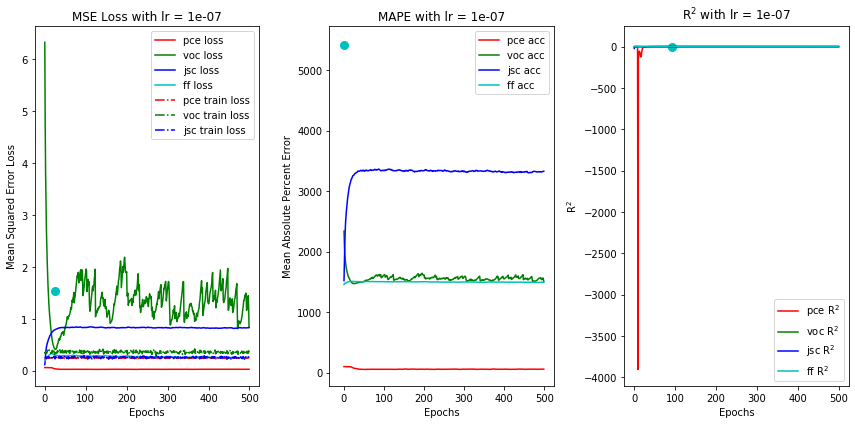

PCE epoch: 56
Voc epoch: 63
Jsc epoch: 22
FF epoch: 11


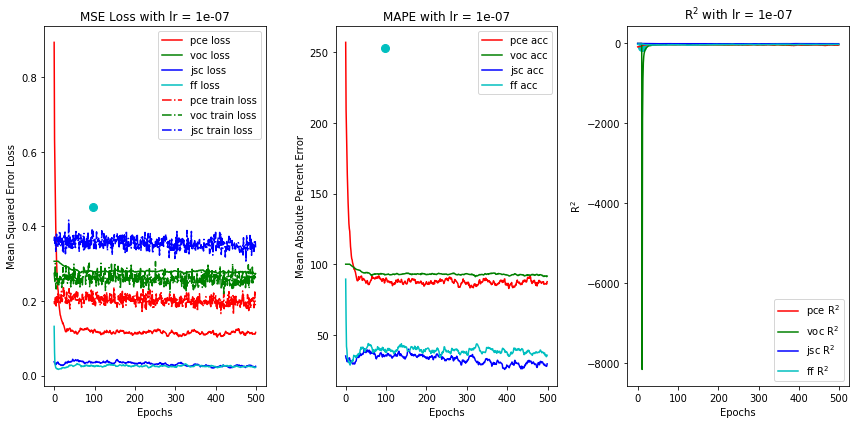

PCE epoch: 28
Voc epoch: 3
Jsc epoch: 70
FF epoch: 99


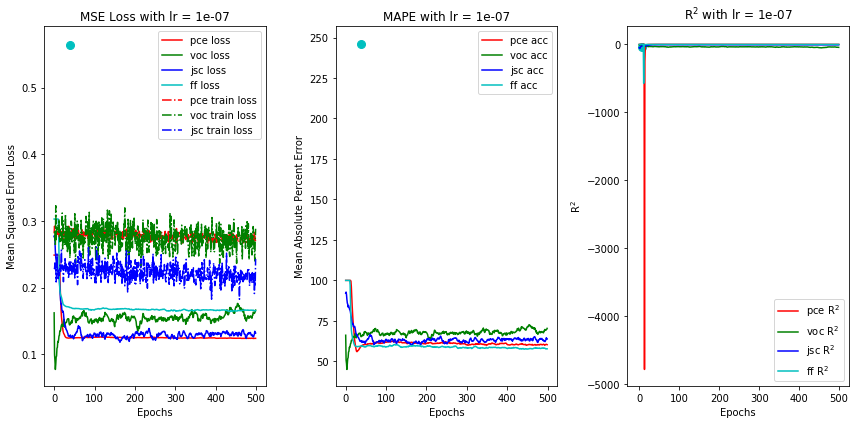

PCE epoch: 22
Voc epoch: 33
Jsc epoch: 33
FF epoch: 6


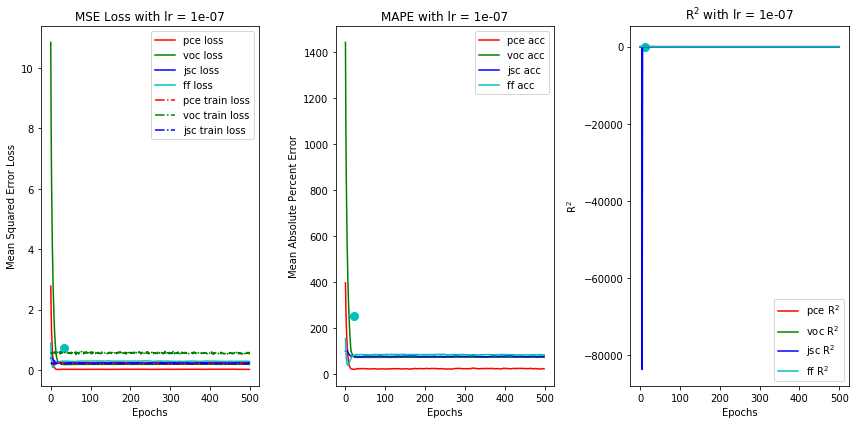

PCE epoch: 8
Voc epoch: 76
Jsc epoch: 2
FF epoch: 14


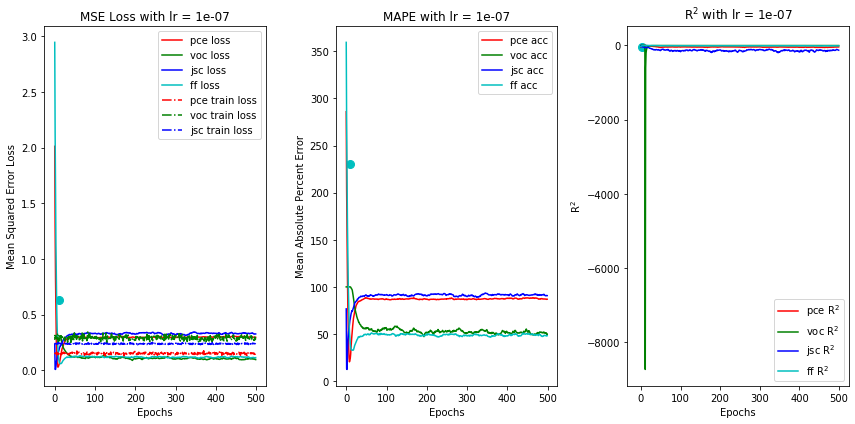

In [14]:
%autoreload

loss_summary = {}
acc_summary = {}
r2_summary = {}

pce_loss = []
pce_acc = []
pce_r2 = []
voc_loss = []
voc_acc = []
voc_r2 = []
jsc_loss = []
jsc_acc = []
jsc_r2 = []
ff_loss = []
ff_acc = []
ff_r2 = []


for key, fit_dict in data.items():
    plot_fit_results(fit_dict)
    losses, accs, r2s = report_metrics(fit_dict)
    
    pce_loss.append(losses[0])
    pce_acc.append(accs[0])
    pce_r2.append(r2s[0])
    
    voc_loss.append(losses[1])
    voc_acc.append(accs[1])
    voc_r2.append(r2s[1])
    
    jsc_loss.append(losses[2])
    jsc_acc.append(accs[2])
    jsc_r2.append(r2s[2])
    
    ff_loss.append(losses[3])
    ff_acc.append(accs[3])
    ff_r2.append(r2s[3])
    
    
loss_summary['PCE Worst'] = max(pce_loss)
loss_summary['PCE Avg'] = sum(pce_loss)/len(pce_loss)
loss_summary['PCE Best'] = min(pce_loss)

loss_summary['Voc Worst'] = max(voc_loss)
loss_summary['Voc Avg'] = sum(voc_loss)/len(voc_loss)
loss_summary['Voc Best'] = min(voc_loss)

loss_summary['Jsc Worst'] = max(jsc_loss)
loss_summary['Jsc Avg'] = sum(jsc_loss)/len(jsc_loss)
loss_summary['Jsc Best'] = min(jsc_loss)

loss_summary['FF Worst'] = max(ff_loss)
loss_summary['FF Avg'] = sum(ff_loss)/len(ff_loss)
loss_summary['FF Best'] = min(ff_loss)

acc_summary['PCE Worst'] = max(pce_acc)
acc_summary['PCE Avg'] = sum(pce_acc)/len(pce_acc)
acc_summary['PCE Best'] = min(pce_acc)

acc_summary['Voc Worst'] = max(voc_acc)
acc_summary['Voc Avg'] = sum(voc_acc)/len(voc_acc)
acc_summary['Voc Best'] = min(voc_acc)

acc_summary['Jsc Worst'] = max(jsc_acc)
acc_summary['Jsc Avg'] = sum(jsc_acc)/len(jsc_acc)
acc_summary['Jsc Best'] = min(jsc_acc)

acc_summary['FF Worst'] = max(ff_acc)
acc_summary['FF Avg'] = sum(ff_acc)/len(ff_acc)
acc_summary['FF Best'] = min(ff_acc)

r2_summary['PCE Worst'] = min(pce_r2)
r2_summary['PCE Avg'] = sum(pce_r2)/len(pce_r2)
r2_summary['PCE Best'] = max(pce_r2)

r2_summary['Voc Worst'] = min(voc_r2)
r2_summary['Voc Avg'] = sum(voc_r2)/len(voc_r2)
r2_summary['Voc Best'] = max(voc_r2)

r2_summary['Jsc Worst'] = min(jsc_r2)
r2_summary['Jsc Avg'] = sum(jsc_r2)/len(jsc_r2)
r2_summary['Jsc Best'] = max(jsc_r2)

r2_summary['FF Worst'] = min(ff_r2)
r2_summary['FF Avg'] = sum(ff_r2)/len(ff_r2)
r2_summary['FF Best'] = max(ff_r2)

In [10]:
loss_summary

{'PCE Worst': 0.125934898853302,
 'PCE Avg': 0.06135287955403328,
 'PCE Best': 0.01867704652249813,
 'Voc Worst': 0.41991308331489563,
 'Voc Avg': 0.21127099245786668,
 'Voc Best': 0.07716183364391327,
 'Jsc Worst': 0.22713050246238708,
 'Jsc Avg': 0.09955375865101815,
 'Jsc Best': 0.00795525312423706,
 'FF Worst': 0.1806713193655014,
 'FF Avg': 0.10095406658947467,
 'FF Best': 0.016351236030459404}

In [11]:
acc_summary

{'PCE Worst': 85.58804321289062,
 'PCE Avg': 46.84803695678711,
 'PCE Best': 20.326622009277344,
 'Voc Worst': 1471.1492919921875,
 'Voc Avg': 346.5383491516113,
 'Voc Best': 45.01115036010742,
 'Jsc Worst': 1519.3338623046875,
 'Jsc Avg': 339.2908239364624,
 'Jsc Best': 12.393708229064941,
 'FF Worst': 1457.5611572265625,
 'FF Avg': 323.2626838684082,
 'FF Best': 28.62091064453125}

In [12]:
r2_summary

{'PCE Worst': -28.026815999970605,
 'PCE Avg': -6.439128138006646,
 'PCE Best': 0.07066072450650429,
 'Voc Worst': -28.11251625090614,
 'Voc Avg': -8.629957273987777,
 'Voc Best': -0.3408317555451854,
 'Jsc Worst': -23.70046539719083,
 'Jsc Avg': -10.184525320695636,
 'Jsc Best': -2.7953979500281174,
 'FF Worst': -14.44649399598638,
 'FF Avg': -3.453929315788278,
 'FF Best': 0.04272720896899773}